# Halofit Emulation
Author: João Victor Rebouças, May 2023

In [1]:
from time import perf_counter
import numpy as np
import matplotlib.pyplot as plt
import keras
import euclidemu2 as ee2
import train_utils as utils
from train_utils import params, lims, ref
# Don't worry about tensorflow warnings

2023-06-28 12:26:23.628076: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-28 12:26:23.653982: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Train redshifts
redshifts = [z for z in utils.redshifts if z <= 3]

### Data preprocessing
**How to use**: select the desired dataset in `path_to_train` and run all subsequent cells until the [training section](#Training).

**Pipeline description**:
- Load chosen training data
- Smear BAO in linear $P(k)$ (using BACCO's code)
- Calculate $Q(k) = \log(P_\mathrm{NL}/P_\mathrm{lin,\, smear})$
- Normalize cosmological parameters based on EE2 box boundaries
- Normalize $Q$ using min-max
- Save $Q$ normalization parameters (for rescaling $Q$ after emulation)
- PCA

In [3]:
# Data can be downloaded at https://github.com/SBU-Jonathan/halofit_data
# LCDM datasets
path_to_spectra = "/home/grads/data/jonathan/cola_projects/COLA_output/"
path_to_train_lcdm = path_to_spectra + "LCDM/400_1"

# wCDM datasets
path_to_train_wcdm = path_to_spectra + "WCDM/500_1"

In [4]:
# Select which training dataset to use
path_to_train = path_to_train_lcdm
ks = utils.ks_cola_default

In [5]:
# Load training LHS
path_to_lcdm_lhs = "/home/grads/data/jonathan/cola_projects/COLA_input/LCDM/400_1/lhs.txt"
train_samples = np.loadtxt(path_to_lcdm_lhs)
print(train_samples[0])

[2.98998249e-01 5.84627549e-02 9.66097472e-01 1.99213595e-09
 6.75717014e-01]


In [13]:
# Load ref cosmology from CAMB, all redshifts
pk_lin_ref = np.zeros((len(redshifts), len(ks)))
pk_nl_a_ref = np.zeros((len(redshifts), len(ks)))
pk_nl_b_ref = np.zeros((len(redshifts), len(ks)))
pk_lin_smear_ref = np.zeros((len(redshifts), len(ks)))
for i, redshift in enumerate(redshifts):
    pk_nl_a_ref[i], pk_lin_ref[i] = np.loadtxt(f"{path_to_train}/a/output/ref/pofk_ref_total_z{redshift:.3f}.txt", unpack=True, max_rows=len(ks), usecols=(1,2))
    pk_nl_b_ref[i], pk_lin_ref[i] = np.loadtxt(f"{path_to_train}/b/output/ref/pofk_ref_total_z{redshift:.3f}.txt", unpack=True, max_rows=len(ks), usecols=(1,2))
    pk_lin_smear_ref[i] = utils.smear_bao(ks, pk_lin_ref[i], utils.smooth_bao(ks, pk_lin_ref[i]), par=0.5)
pk_nl_ref = (pk_nl_a_ref + pk_nl_b_ref)/2

/tmp/ipykernel_865695/2152983183.py:7: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=512`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  pk_nl_a_ref[i], pk_lin_ref[i] = np.loadtxt(f"{path_to_train}/a/output/ref/pofk_ref_total_z{redshift:.3f}.txt", unpack=True, max_rows=len(utils.ks_cola_default), usecols=(1,2))
/tmp/ipykernel_865695/2152983183.py:8: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=512`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.

In [14]:
ref_params = {
    "h": 0.67,
    "Omm": 0.319,
    "Omb": 0.049,
    "As": 2.1e-9,
    "ns": 0.96,
    "w": -1,
    "wa": 0,
    "mnu": 0.058
}
ks, boost_ref_ee2 = ee2.get_boost(ref_params, redshifts, ks)
expq_ref_ee2 = np.zeros((len(redshifts), len(ks)))
for i, z in enumerate(redshifts):
    expq_ref_ee2[i] = boost_ref_ee2[i] * pk_lin_ref[i] / pk_lin_smear_ref[i]

EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.


In [18]:
# Load training data, takes several minutes
pks_lin_train = np.zeros((len(train_samples), len(redshifts), len(ks)))
pks_lin_smear_train = np.zeros((len(train_samples), len(redshifts), len(ks)))
pks_nl_train = np.zeros((len(train_samples), len(redshifts), len(ks)))

for i in range(len(train_samples)):
    for j, redshift in enumerate(redshifts):
        pk_nl_a_train, pks_lin_train[i,j],  = np.loadtxt(f"{path_to_train}/a/output/{i}/pofk_run_{i}_total_z{redshift:.3f}.txt", unpack=True, max_rows=len(ks), usecols=(1,2))
        pk_nl_b_train, pks_lin_train[i,j] = np.loadtxt(f"{path_to_train}/b/output/{i}/pofk_run_{i}_total_z{redshift:.3f}.txt", unpack=True, max_rows=len(ks), usecols=(1,2))
        pks_nl_train[i,j] = (pk_nl_a_train + pk_nl_b_train)/2
        try:
            pks_lin_smear_train[i,j] = utils.smear_bao(ks, pks_lin_train[i,j], utils.smooth_bao(ks, pks_lin_train[i,j]))
        except Exception as err:
            print(f"Cannot smear pk in cosmology {i} at redshift {redshift}: {err}")

/tmp/ipykernel_865695/3158739856.py:8: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=512`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  pk_nl_a_train, pks_lin_train[i,j],  = np.loadtxt(f"{path_to_train}/a/output/{i}/pofk_run_{i}_total_z{redshift:.3f}.txt", unpack=True, max_rows=len(utils.ks_cola_default), usecols=(1,2))
/tmp/ipykernel_865695/3158739856.py:9: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=512`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `

In [19]:
# Subtracting shot noise
pk_nl_ref -= 1
pks_nl_train -= 1

In [20]:
# Defining emulated quantities
train_logboosts = np.zeros((len(train_samples), len(redshifts), len(ks)))
train_qs = np.zeros((len(train_samples), len(redshifts), len(ks)))
for i in range(len(train_samples)):
    r_nl = pks_nl_train[i]/pk_nl_ref
    r_lin = pks_lin_train[i]/pk_lin_ref
    r_lin_smear = pks_lin_smear_train[i]/pk_lin_smear_ref
    for j in range(len(redshifts)):
        train_logboosts[i,j] = np.log(boost_ref_ee2[j] * r_nl[j] / r_lin[j])
        train_qs[i,j] = np.log(expq_ref_ee2[j] * r_nl[j] / r_lin_smear[j])

/tmp/ipykernel_865695/897578998.py:9: RuntimeWarning: invalid value encountered in log
  train_logboosts[i,j] = np.log(boost_ref_ee2[j] * r_nl[j] / r_lin[j])
/tmp/ipykernel_865695/897578998.py:10: RuntimeWarning: invalid value encountered in log
  train_qs[i,j] = np.log(expq_ref_ee2[j] * r_nl[j] / r_lin_smear[j])


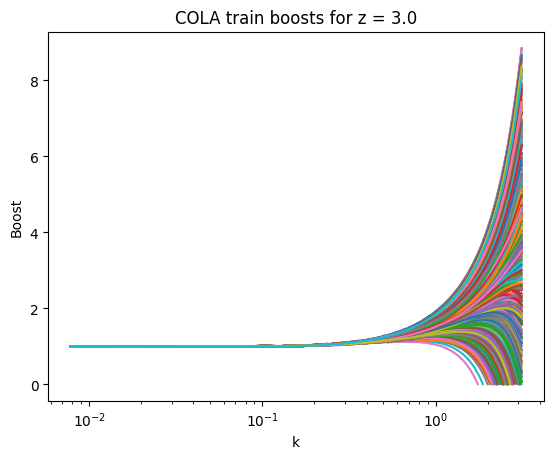

In [102]:
z_index = 39
for i in range(400):
    plt.semilogx(ks, np.exp(train_logboosts[i,z_index]))
plt.title(f"COLA train boosts for z = {redshifts[z_index]}")
plt.xlabel("k")
plt.ylabel("Boost");

In [38]:
# Normalized parameters - input for NN
train_sample_norm = np.zeros((len(train_samples), len(train_samples[0])))
for i, train_point in enumerate(train_samples):
    train_sample_norm[i] = utils.normalize_params(train_point)

In [43]:
# Normalized Boosts with Min-Max
train_logboosts_norm = np.zeros((len(train_samples), len(redshifts), len(ks)))
train_qs_norm = np.zeros((len(train_samples), len(redshifts), len(ks)))
for i in range(len(redshifts)):
    train_logboosts_norm[:,i,:] = utils.normalize_array(train_logboosts[:,i,:]) # I normalize within each redshift
    train_qs_norm[:,i,:] = utils.normalize_array(train_qs[:,i,:]) # I normalize within each redshift

In [44]:
# Getting and saving min and max for rescaling
mins_logboosts = np.zeros(len(redshifts))
maxs_logboosts = np.zeros(len(redshifts))
mins_qs = np.zeros(len(redshifts))
maxs_qs = np.zeros(len(redshifts))

for i in range(len(redshifts)):
    mins_logboosts[i] = np.amin(train_logboosts[:,i,:])
    maxs_logboosts[i] = np.amax(train_logboosts[:,i,:])
    mins_qs[i] = np.amin(train_qs[:,i,:])
    maxs_qs[i] = np.amax(train_qs[:,i,:])

In [110]:
# PCA reduction
num_pcs = 11
#pcas_logboosts, train_logboosts_pcs = utils.pca_reduction(num_pcs, train_logboosts_norm, redshifts[:35])
pcas_qs, train_qs_pcs = utils.pca_reduction(num_pcs, train_qs_norm, redshifts[:34])

### Training
**How to use**: 
- **Must have run [data preprocessing](#Data-preprocessing) section with the desired dataset**
- Define your model using the `utils.generate_resnet` or `utils.generate_mlp` functions.
- Train the model using the `utils.nn_model_train` function, where you can choose to train on `logboosts` or smeared boosts.
- Save your model using `model.save("path")`.
- See cells below for examples on training individual models at $z = 0$ and how to sequentially train models on all redshifts.

In [51]:
# Generate MLP model
mlp = utils.generate_mlp(
    input_shape=len(train_samples[0]),
    output_shape=num_pcs,
    num_layers=3,
    num_neurons=512,
    activation="custom",
    alpha=0,
    l1_ratio=0.1,
    loss='mse',
    learning_rate=1e-3,
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense (Dense)               (None, 512)               3072      
                                                                 
 custom_activation_layer (Cu  (None, 512)              1024      
 stomActivationLayer)                                            
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 custom_activation_layer_1 (  (None, 512)              1024      
 CustomActivationLayer)                                          
                                                                 
 dense_2 (Dense)             (None, 512)               262656

In [16]:
# Generate resnet model
resnet = utils.generate_resnet(
    input_shape=len(train_samples[0]),
    output_shape=num_pcs,
    num_res_blocks=1,
    num_of_neurons=1024,
    activation="relu",
    alpha=0,
    l1_ratio=0.1,
    dropout=0
)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 dense_4 (Dense)                (None, 1024)         6144        ['input_2[0][0]']                
                                                                                                  
 custom_activation_layer_3 (Cus  (None, 1024)        2048        ['dense_4[0][0]']                
 tomActivationLayer)                                                                              
                                                                                                  
 dense_5 (Dense)                (None, 1024)         1049600     ['custom_activation_layer_3

In [52]:
# Training (z=0) for 2.6k epochs. Starting from epoch 1500, the learning rate halves every 200 epochs
start = perf_counter()
last_loss = utils.nn_model_train(mlp, 1600, train_sample_norm, train_qs_pcs[:,0], decayevery=1500, decayrate=2)
last_loss = utils.nn_model_train(mlp, 1000, train_sample_norm, train_qs_pcs[:,0], decayevery=200, decayrate=2)
print(f"Training took {perf_counter() - start} seconds")

Epoch 1/1600
14/14 [==============================] - 1s 6ms/step - loss: 0.0262 - lr: 0.0010
Epoch 2/1600
14/14 [==============================] - 0s 6ms/step - loss: 0.0099 - lr: 0.0010
Epoch 3/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0061 - lr: 0.0010
Epoch 4/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0048 - lr: 0.0010
Epoch 5/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0042 - lr: 0.0010
Epoch 6/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0042 - lr: 0.0010
Epoch 7/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0044 - lr: 0.0010
Epoch 8/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0045 - lr: 0.0010
Epoch 9/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0044 - lr: 0.0010
Epoch 10/1600
14/14 [==============================] - 0s 5ms/step - loss: 0.0045 - lr: 0.0010
Epoch 11/1600
14/14 [==============================] - 0s 5

Epoch 86/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.9676e-04 - lr: 0.0010
Epoch 87/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.9062e-04 - lr: 0.0010
Epoch 88/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.1656e-04 - lr: 0.0010
Epoch 89/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.6686e-04 - lr: 0.0010
Epoch 90/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.8846e-04 - lr: 0.0010
Epoch 91/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.0639e-04 - lr: 0.0010
Epoch 92/1600
14/14 [==============================] - 0s 4ms/step - loss: 1.6259e-04 - lr: 0.0010
Epoch 93/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.4420e-04 - lr: 0.0010
Epoch 94/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.3916e-04 - lr: 0.0010
Epoch 95/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.4745e-04 - lr: 0.0010
Epoch 96/1

14/14 [==============================] - 0s 5ms/step - loss: 4.9974e-05 - lr: 0.0010
Epoch 169/1600
14/14 [==============================] - 0s 4ms/step - loss: 6.7060e-05 - lr: 0.0010
Epoch 170/1600
14/14 [==============================] - 0s 4ms/step - loss: 6.6538e-05 - lr: 0.0010
Epoch 171/1600
14/14 [==============================] - 0s 5ms/step - loss: 5.4236e-05 - lr: 0.0010
Epoch 172/1600
14/14 [==============================] - 0s 5ms/step - loss: 4.3298e-05 - lr: 0.0010
Epoch 173/1600
14/14 [==============================] - 0s 4ms/step - loss: 4.4220e-05 - lr: 0.0010
Epoch 174/1600
14/14 [==============================] - 0s 5ms/step - loss: 3.7968e-05 - lr: 0.0010
Epoch 175/1600
14/14 [==============================] - 0s 7ms/step - loss: 3.5783e-05 - lr: 0.0010
Epoch 176/1600
14/14 [==============================] - 0s 6ms/step - loss: 4.6648e-05 - lr: 0.0010
Epoch 177/1600
14/14 [==============================] - 0s 5ms/step - loss: 3.9561e-05 - lr: 0.0010
Epoch 178/1600


14/14 [==============================] - 0s 5ms/step - loss: 1.8160e-05 - lr: 0.0010
Epoch 251/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.1217e-05 - lr: 0.0010
Epoch 252/1600
14/14 [==============================] - 0s 4ms/step - loss: 2.0821e-05 - lr: 0.0010
Epoch 253/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.4192e-05 - lr: 0.0010
Epoch 254/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.7522e-05 - lr: 0.0010
Epoch 255/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.3662e-05 - lr: 0.0010
Epoch 256/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.1092e-05 - lr: 0.0010
Epoch 257/1600
14/14 [==============================] - 0s 5ms/step - loss: 4.2251e-05 - lr: 0.0010
Epoch 258/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.1745e-05 - lr: 0.0010
Epoch 259/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.7072e-05 - lr: 0.0010
Epoch 260/1600


14/14 [==============================] - 0s 5ms/step - loss: 1.4610e-05 - lr: 0.0010
Epoch 333/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.1087e-05 - lr: 0.0010
Epoch 334/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.0972e-05 - lr: 0.0010
Epoch 335/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.3011e-05 - lr: 0.0010
Epoch 336/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.3205e-05 - lr: 0.0010
Epoch 337/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.7854e-05 - lr: 0.0010
Epoch 338/1600
14/14 [==============================] - 0s 5ms/step - loss: 8.6356e-05 - lr: 0.0010
Epoch 339/1600
14/14 [==============================] - 0s 5ms/step - loss: 5.9738e-05 - lr: 0.0010
Epoch 340/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.7845e-05 - lr: 0.0010
Epoch 341/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.9256e-05 - lr: 0.0010
Epoch 342/1600


14/14 [==============================] - 0s 5ms/step - loss: 5.6149e-05 - lr: 0.0010
Epoch 415/1600
14/14 [==============================] - 0s 5ms/step - loss: 3.8080e-05 - lr: 0.0010
Epoch 416/1600
14/14 [==============================] - 0s 5ms/step - loss: 4.8366e-05 - lr: 0.0010
Epoch 417/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.7232e-05 - lr: 0.0010
Epoch 418/1600
14/14 [==============================] - 0s 5ms/step - loss: 4.5502e-05 - lr: 0.0010
Epoch 419/1600
14/14 [==============================] - 0s 5ms/step - loss: 3.6671e-05 - lr: 0.0010
Epoch 420/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.4762e-05 - lr: 0.0010
Epoch 421/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.2099e-05 - lr: 0.0010
Epoch 422/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.3069e-05 - lr: 0.0010
Epoch 423/1600
14/14 [==============================] - 0s 5ms/step - loss: 9.7226e-06 - lr: 0.0010
Epoch 424/1600


14/14 [==============================] - 0s 5ms/step - loss: 1.0775e-05 - lr: 0.0010
Epoch 497/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.3628e-05 - lr: 0.0010
Epoch 498/1600
14/14 [==============================] - 0s 5ms/step - loss: 3.3313e-05 - lr: 0.0010
Epoch 499/1600
14/14 [==============================] - 0s 6ms/step - loss: 1.4327e-04 - lr: 0.0010
Epoch 500/1600
14/14 [==============================] - 0s 5ms/step - loss: 7.1077e-05 - lr: 0.0010
Epoch 501/1600
14/14 [==============================] - 0s 3ms/step - loss: 3.1417e-05 - lr: 0.0010
Epoch 502/1600
14/14 [==============================] - 0s 3ms/step - loss: 1.4253e-05 - lr: 0.0010
Epoch 503/1600
14/14 [==============================] - 0s 3ms/step - loss: 2.3238e-05 - lr: 0.0010
Epoch 504/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.9862e-05 - lr: 0.0010
Epoch 505/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.5542e-05 - lr: 0.0010
Epoch 506/1600


14/14 [==============================] - 0s 5ms/step - loss: 1.3944e-05 - lr: 0.0010
Epoch 579/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.9915e-05 - lr: 0.0010
Epoch 580/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.4707e-05 - lr: 0.0010
Epoch 581/1600
14/14 [==============================] - 0s 6ms/step - loss: 1.2539e-05 - lr: 0.0010
Epoch 582/1600
14/14 [==============================] - 0s 5ms/step - loss: 9.1671e-06 - lr: 0.0010
Epoch 583/1600
14/14 [==============================] - 0s 5ms/step - loss: 8.0366e-06 - lr: 0.0010
Epoch 584/1600
14/14 [==============================] - 0s 5ms/step - loss: 5.2382e-06 - lr: 0.0010
Epoch 585/1600
14/14 [==============================] - 0s 5ms/step - loss: 7.0316e-06 - lr: 0.0010
Epoch 586/1600
14/14 [==============================] - 0s 5ms/step - loss: 7.0686e-06 - lr: 0.0010
Epoch 587/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.0423e-05 - lr: 0.0010
Epoch 588/1600


14/14 [==============================] - 0s 5ms/step - loss: 1.0476e-05 - lr: 0.0010
Epoch 661/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.6659e-05 - lr: 0.0010
Epoch 662/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.7769e-05 - lr: 0.0010
Epoch 663/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.4978e-05 - lr: 0.0010
Epoch 664/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.3835e-05 - lr: 0.0010
Epoch 665/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.6592e-05 - lr: 0.0010
Epoch 666/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.7180e-05 - lr: 0.0010
Epoch 667/1600
14/14 [==============================] - 0s 5ms/step - loss: 9.6108e-06 - lr: 0.0010
Epoch 668/1600
14/14 [==============================] - 0s 5ms/step - loss: 9.5575e-06 - lr: 0.0010
Epoch 669/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.3466e-05 - lr: 0.0010
Epoch 670/1600


14/14 [==============================] - 0s 5ms/step - loss: 6.6898e-05 - lr: 0.0010
Epoch 743/1600
14/14 [==============================] - 0s 5ms/step - loss: 7.8431e-05 - lr: 0.0010
Epoch 744/1600
14/14 [==============================] - 0s 5ms/step - loss: 5.0516e-05 - lr: 0.0010
Epoch 745/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.8084e-05 - lr: 0.0010
Epoch 746/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.7679e-05 - lr: 0.0010
Epoch 747/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.2700e-05 - lr: 0.0010
Epoch 748/1600
14/14 [==============================] - 0s 5ms/step - loss: 9.1225e-06 - lr: 0.0010
Epoch 749/1600
14/14 [==============================] - 0s 5ms/step - loss: 8.5875e-06 - lr: 0.0010
Epoch 750/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.0041e-05 - lr: 0.0010
Epoch 751/1600
14/14 [==============================] - 0s 6ms/step - loss: 1.5791e-05 - lr: 0.0010
Epoch 752/1600


14/14 [==============================] - 0s 5ms/step - loss: 1.5115e-04 - lr: 0.0010
Epoch 825/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.0157e-04 - lr: 0.0010
Epoch 826/1600
14/14 [==============================] - 0s 5ms/step - loss: 3.4923e-05 - lr: 0.0010
Epoch 827/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.2992e-05 - lr: 0.0010
Epoch 828/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.4221e-05 - lr: 0.0010
Epoch 829/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.6232e-05 - lr: 0.0010
Epoch 830/1600
14/14 [==============================] - 0s 4ms/step - loss: 1.2247e-05 - lr: 0.0010
Epoch 831/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.3030e-05 - lr: 0.0010
Epoch 832/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.6970e-05 - lr: 0.0010
Epoch 833/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.0105e-05 - lr: 0.0010
Epoch 834/1600


14/14 [==============================] - 0s 5ms/step - loss: 8.6997e-06 - lr: 0.0010
Epoch 907/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.0552e-05 - lr: 0.0010
Epoch 908/1600
14/14 [==============================] - 0s 5ms/step - loss: 3.3109e-05 - lr: 0.0010
Epoch 909/1600
14/14 [==============================] - 0s 5ms/step - loss: 7.3307e-05 - lr: 0.0010
Epoch 910/1600
14/14 [==============================] - 0s 5ms/step - loss: 3.7847e-05 - lr: 0.0010
Epoch 911/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.7746e-05 - lr: 0.0010
Epoch 912/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.4205e-05 - lr: 0.0010
Epoch 913/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.0398e-05 - lr: 0.0010
Epoch 914/1600
14/14 [==============================] - 0s 5ms/step - loss: 8.2948e-06 - lr: 0.0010
Epoch 915/1600
14/14 [==============================] - 0s 5ms/step - loss: 6.3448e-06 - lr: 0.0010
Epoch 916/1600


14/14 [==============================] - 0s 5ms/step - loss: 1.0309e-05 - lr: 0.0010
Epoch 989/1600
14/14 [==============================] - 0s 5ms/step - loss: 5.5785e-06 - lr: 0.0010
Epoch 990/1600
14/14 [==============================] - 0s 5ms/step - loss: 5.7946e-06 - lr: 0.0010
Epoch 991/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.0580e-05 - lr: 0.0010
Epoch 992/1600
14/14 [==============================] - 0s 5ms/step - loss: 9.1895e-06 - lr: 0.0010
Epoch 993/1600
14/14 [==============================] - 0s 5ms/step - loss: 4.9880e-06 - lr: 0.0010
Epoch 994/1600
14/14 [==============================] - 0s 5ms/step - loss: 7.3072e-06 - lr: 0.0010
Epoch 995/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.3460e-05 - lr: 0.0010
Epoch 996/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.7790e-05 - lr: 0.0010
Epoch 997/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.2937e-05 - lr: 0.0010
Epoch 998/1600


14/14 [==============================] - 0s 5ms/step - loss: 1.5654e-05 - lr: 0.0010
Epoch 1070/1600
14/14 [==============================] - 0s 5ms/step - loss: 7.0078e-06 - lr: 0.0010
Epoch 1071/1600
14/14 [==============================] - 0s 5ms/step - loss: 4.9605e-06 - lr: 0.0010
Epoch 1072/1600
14/14 [==============================] - 0s 5ms/step - loss: 6.5571e-06 - lr: 0.0010
Epoch 1073/1600
14/14 [==============================] - 0s 4ms/step - loss: 1.0011e-05 - lr: 0.0010
Epoch 1074/1600
14/14 [==============================] - 0s 4ms/step - loss: 6.2947e-06 - lr: 0.0010
Epoch 1075/1600
14/14 [==============================] - 0s 5ms/step - loss: 6.1758e-06 - lr: 0.0010
Epoch 1076/1600
14/14 [==============================] - 0s 5ms/step - loss: 6.0241e-06 - lr: 0.0010
Epoch 1077/1600
14/14 [==============================] - 0s 5ms/step - loss: 4.2015e-06 - lr: 0.0010
Epoch 1078/1600
14/14 [==============================] - 0s 5ms/step - loss: 6.2265e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 1.5155e-05 - lr: 0.0010
Epoch 1151/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.9665e-05 - lr: 0.0010
Epoch 1152/1600
14/14 [==============================] - 0s 5ms/step - loss: 4.5370e-05 - lr: 0.0010
Epoch 1153/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.1769e-05 - lr: 0.0010
Epoch 1154/1600
14/14 [==============================] - 0s 5ms/step - loss: 8.9986e-06 - lr: 0.0010
Epoch 1155/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.2400e-05 - lr: 0.0010
Epoch 1156/1600
14/14 [==============================] - 0s 5ms/step - loss: 8.9192e-06 - lr: 0.0010
Epoch 1157/1600
14/14 [==============================] - 0s 5ms/step - loss: 5.5103e-06 - lr: 0.0010
Epoch 1158/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.6910e-05 - lr: 0.0010
Epoch 1159/1600
14/14 [==============================] - 0s 5ms/step - loss: 9.7146e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 1.5554e-05 - lr: 0.0010
Epoch 1232/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.2751e-05 - lr: 0.0010
Epoch 1233/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.6142e-05 - lr: 0.0010
Epoch 1234/1600
14/14 [==============================] - 0s 5ms/step - loss: 6.6374e-05 - lr: 0.0010
Epoch 1235/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.5196e-05 - lr: 0.0010
Epoch 1236/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.2233e-05 - lr: 0.0010
Epoch 1237/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.7256e-05 - lr: 0.0010
Epoch 1238/1600
14/14 [==============================] - 0s 5ms/step - loss: 8.8310e-06 - lr: 0.0010
Epoch 1239/1600
14/14 [==============================] - 0s 5ms/step - loss: 7.1278e-06 - lr: 0.0010
Epoch 1240/1600
14/14 [==============================] - 0s 5ms/step - loss: 6.3743e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 8.9035e-06 - lr: 0.0010
Epoch 1313/1600
14/14 [==============================] - 0s 5ms/step - loss: 7.5104e-06 - lr: 0.0010
Epoch 1314/1600
14/14 [==============================] - 0s 5ms/step - loss: 4.5215e-06 - lr: 0.0010
Epoch 1315/1600
14/14 [==============================] - 0s 5ms/step - loss: 5.6864e-06 - lr: 0.0010
Epoch 1316/1600
14/14 [==============================] - 0s 5ms/step - loss: 5.0683e-06 - lr: 0.0010
Epoch 1317/1600
14/14 [==============================] - 0s 5ms/step - loss: 7.0355e-06 - lr: 0.0010
Epoch 1318/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.1849e-05 - lr: 0.0010
Epoch 1319/1600
14/14 [==============================] - 0s 5ms/step - loss: 7.5020e-06 - lr: 0.0010
Epoch 1320/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.0275e-05 - lr: 0.0010
Epoch 1321/1600
14/14 [==============================] - 0s 5ms/step - loss: 6.1576e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 7.4456e-06 - lr: 0.0010
Epoch 1394/1600
14/14 [==============================] - 0s 5ms/step - loss: 7.5796e-06 - lr: 0.0010
Epoch 1395/1600
14/14 [==============================] - 0s 5ms/step - loss: 6.8586e-06 - lr: 0.0010
Epoch 1396/1600
14/14 [==============================] - 0s 6ms/step - loss: 4.2211e-06 - lr: 0.0010
Epoch 1397/1600
14/14 [==============================] - 0s 5ms/step - loss: 3.3285e-06 - lr: 0.0010
Epoch 1398/1600
14/14 [==============================] - 0s 5ms/step - loss: 4.0650e-06 - lr: 0.0010
Epoch 1399/1600
14/14 [==============================] - 0s 5ms/step - loss: 6.0044e-06 - lr: 0.0010
Epoch 1400/1600
14/14 [==============================] - 0s 5ms/step - loss: 5.5168e-06 - lr: 0.0010
Epoch 1401/1600
14/14 [==============================] - 0s 5ms/step - loss: 4.3374e-06 - lr: 0.0010
Epoch 1402/1600
14/14 [==============================] - 0s 5ms/step - loss: 5.0488e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 8.2183e-06 - lr: 0.0010
Epoch 1475/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.8082e-05 - lr: 0.0010
Epoch 1476/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.1941e-05 - lr: 0.0010
Epoch 1477/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.0460e-05 - lr: 0.0010
Epoch 1478/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.9784e-05 - lr: 0.0010
Epoch 1479/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.6908e-05 - lr: 0.0010
Epoch 1480/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.6609e-05 - lr: 0.0010
Epoch 1481/1600
14/14 [==============================] - 0s 5ms/step - loss: 1.6716e-05 - lr: 0.0010
Epoch 1482/1600
14/14 [==============================] - 0s 5ms/step - loss: 7.4024e-06 - lr: 0.0010
Epoch 1483/1600
14/14 [==============================] - 0s 5ms/step - loss: 5.5606e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 5.1672e-06 - lr: 5.0000e-04
Epoch 1554/1600
14/14 [==============================] - 0s 5ms/step - loss: 4.4419e-06 - lr: 5.0000e-04
Epoch 1555/1600
14/14 [==============================] - 0s 5ms/step - loss: 3.3236e-06 - lr: 5.0000e-04
Epoch 1556/1600
14/14 [==============================] - 0s 5ms/step - loss: 3.3626e-06 - lr: 5.0000e-04
Epoch 1557/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.8911e-06 - lr: 5.0000e-04
Epoch 1558/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.5085e-06 - lr: 5.0000e-04
Epoch 1559/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.5687e-06 - lr: 5.0000e-04
Epoch 1560/1600
14/14 [==============================] - 0s 5ms/step - loss: 2.2364e-06 - lr: 5.0000e-04
Epoch 1561/1600
14/14 [==============================] - 0s 5ms/step - loss: 3.5381e-06 - lr: 5.0000e-04
Epoch 1562/1600
14/14 [==============================] - 0s 5ms/step - 

Epoch 32/1000
14/14 [==============================] - 0s 3ms/step - loss: 3.1606e-06 - lr: 5.0000e-04
Epoch 33/1000
14/14 [==============================] - 0s 3ms/step - loss: 4.2328e-06 - lr: 5.0000e-04
Epoch 34/1000
14/14 [==============================] - 0s 3ms/step - loss: 3.7396e-06 - lr: 5.0000e-04
Epoch 35/1000
14/14 [==============================] - 0s 3ms/step - loss: 2.8366e-06 - lr: 5.0000e-04
Epoch 36/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.4075e-06 - lr: 5.0000e-04
Epoch 37/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.0355e-06 - lr: 5.0000e-04
Epoch 38/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.3004e-06 - lr: 5.0000e-04
Epoch 39/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6099e-06 - lr: 5.0000e-04
Epoch 40/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.8675e-06 - lr: 5.0000e-04
Epoch 41/1000
14/14 [==============================] - 0s 5ms/step - loss

14/14 [==============================] - 0s 5ms/step - loss: 4.6785e-06 - lr: 5.0000e-04
Epoch 112/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8235e-06 - lr: 5.0000e-04
Epoch 113/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8230e-06 - lr: 5.0000e-04
Epoch 114/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.6266e-06 - lr: 5.0000e-04
Epoch 115/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.5652e-06 - lr: 5.0000e-04
Epoch 116/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.4660e-06 - lr: 5.0000e-04
Epoch 117/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6761e-06 - lr: 5.0000e-04
Epoch 118/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.1361e-06 - lr: 5.0000e-04
Epoch 119/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.3918e-06 - lr: 5.0000e-04
Epoch 120/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.1

Epoch 190/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.9757e-06 - lr: 5.0000e-04
Epoch 191/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.8810e-06 - lr: 5.0000e-04
Epoch 192/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.6777e-06 - lr: 5.0000e-04
Epoch 193/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.0286e-06 - lr: 5.0000e-04
Epoch 194/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.8966e-06 - lr: 5.0000e-04
Epoch 195/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.4543e-06 - lr: 5.0000e-04
Epoch 196/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8436e-06 - lr: 5.0000e-04
Epoch 197/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.0918e-06 - lr: 5.0000e-04
Epoch 198/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.9630e-06 - lr: 5.0000e-04
Epoch 199/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 2.1107e-06 - lr: 2.5000e-04
Epoch 269/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.7227e-06 - lr: 2.5000e-04
Epoch 270/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.2263e-06 - lr: 2.5000e-04
Epoch 271/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0256e-06 - lr: 2.5000e-04
Epoch 272/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0432e-06 - lr: 2.5000e-04
Epoch 273/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.9662e-06 - lr: 2.5000e-04
Epoch 274/1000
14/14 [==============================] - 0s 6ms/step - loss: 2.4197e-06 - lr: 2.5000e-04
Epoch 275/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.5346e-06 - lr: 2.5000e-04
Epoch 276/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.2151e-06 - lr: 2.5000e-04
Epoch 277/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0

Epoch 347/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.1725e-06 - lr: 2.5000e-04
Epoch 348/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.1770e-06 - lr: 2.5000e-04
Epoch 349/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.1762e-06 - lr: 2.5000e-04
Epoch 350/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.8347e-06 - lr: 2.5000e-04
Epoch 351/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0694e-06 - lr: 2.5000e-04
Epoch 352/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.4422e-06 - lr: 2.5000e-04
Epoch 353/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.4666e-06 - lr: 2.5000e-04
Epoch 354/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0618e-06 - lr: 2.5000e-04
Epoch 355/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.9657e-06 - lr: 2.5000e-04
Epoch 356/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 2.0358e-06 - lr: 1.2500e-04
Epoch 426/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6897e-06 - lr: 1.2500e-04
Epoch 427/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5682e-06 - lr: 1.2500e-04
Epoch 428/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.8123e-06 - lr: 1.2500e-04
Epoch 429/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6289e-06 - lr: 1.2500e-04
Epoch 430/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7243e-06 - lr: 1.2500e-04
Epoch 431/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6536e-06 - lr: 1.2500e-04
Epoch 432/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6503e-06 - lr: 1.2500e-04
Epoch 433/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5798e-06 - lr: 1.2500e-04
Epoch 434/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7

Epoch 504/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.8715e-06 - lr: 1.2500e-04
Epoch 505/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7313e-06 - lr: 1.2500e-04
Epoch 506/1000
14/14 [==============================] - 0s 4ms/step - loss: 1.6211e-06 - lr: 1.2500e-04
Epoch 507/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6776e-06 - lr: 1.2500e-04
Epoch 508/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6461e-06 - lr: 1.2500e-04
Epoch 509/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6879e-06 - lr: 1.2500e-04
Epoch 510/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.1367e-06 - lr: 1.2500e-04
Epoch 511/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0185e-06 - lr: 1.2500e-04
Epoch 512/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7824e-06 - lr: 1.2500e-04
Epoch 513/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 1.6640e-06 - lr: 1.2500e-04
Epoch 583/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6191e-06 - lr: 1.2500e-04
Epoch 584/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7203e-06 - lr: 1.2500e-04
Epoch 585/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.5540e-06 - lr: 1.2500e-04
Epoch 586/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.8338e-06 - lr: 1.2500e-04
Epoch 587/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7588e-06 - lr: 1.2500e-04
Epoch 588/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7427e-06 - lr: 1.2500e-04
Epoch 589/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.8976e-06 - lr: 1.2500e-04
Epoch 590/1000
14/14 [==============================] - 0s 4ms/step - loss: 1.8569e-06 - lr: 1.2500e-04
Epoch 591/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.9

Epoch 661/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5203e-06 - lr: 6.2500e-05
Epoch 662/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5707e-06 - lr: 6.2500e-05
Epoch 663/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5724e-06 - lr: 6.2500e-05
Epoch 664/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7104e-06 - lr: 6.2500e-05
Epoch 665/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0433e-06 - lr: 6.2500e-05
Epoch 666/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5668e-06 - lr: 6.2500e-05
Epoch 667/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7579e-06 - lr: 6.2500e-05
Epoch 668/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6366e-06 - lr: 6.2500e-05
Epoch 669/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7445e-06 - lr: 6.2500e-05
Epoch 670/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 1.4932e-06 - lr: 6.2500e-05
Epoch 740/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4781e-06 - lr: 6.2500e-05
Epoch 741/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5369e-06 - lr: 6.2500e-05
Epoch 742/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6836e-06 - lr: 6.2500e-05
Epoch 743/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7383e-06 - lr: 6.2500e-05
Epoch 744/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5082e-06 - lr: 6.2500e-05
Epoch 745/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5379e-06 - lr: 6.2500e-05
Epoch 746/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6176e-06 - lr: 6.2500e-05
Epoch 747/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6856e-06 - lr: 6.2500e-05
Epoch 748/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7

Epoch 818/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4234e-06 - lr: 3.1250e-05
Epoch 819/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4807e-06 - lr: 3.1250e-05
Epoch 820/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3906e-06 - lr: 3.1250e-05
Epoch 821/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4228e-06 - lr: 3.1250e-05
Epoch 822/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4090e-06 - lr: 3.1250e-05
Epoch 823/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4293e-06 - lr: 3.1250e-05
Epoch 824/1000
14/14 [==============================] - 0s 4ms/step - loss: 1.4582e-06 - lr: 3.1250e-05
Epoch 825/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4194e-06 - lr: 3.1250e-05
Epoch 826/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4252e-06 - lr: 3.1250e-05
Epoch 827/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 1.5238e-06 - lr: 3.1250e-05
Epoch 897/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4827e-06 - lr: 3.1250e-05
Epoch 898/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4107e-06 - lr: 3.1250e-05
Epoch 899/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4090e-06 - lr: 3.1250e-05
Epoch 900/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4644e-06 - lr: 3.1250e-05
Epoch 901/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4453e-06 - lr: 3.1250e-05
Epoch 902/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4968e-06 - lr: 3.1250e-05
Epoch 903/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5086e-06 - lr: 3.1250e-05
Epoch 904/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4038e-06 - lr: 3.1250e-05
Epoch 905/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4

Epoch 975/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4862e-06 - lr: 3.1250e-05
Epoch 976/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4192e-06 - lr: 3.1250e-05
Epoch 977/1000
14/14 [==============================] - 0s 4ms/step - loss: 1.4499e-06 - lr: 3.1250e-05
Epoch 978/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4626e-06 - lr: 3.1250e-05
Epoch 979/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4682e-06 - lr: 3.1250e-05
Epoch 980/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4870e-06 - lr: 3.1250e-05
Epoch 981/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3994e-06 - lr: 3.1250e-05
Epoch 982/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4442e-06 - lr: 3.1250e-05
Epoch 983/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5437e-06 - lr: 3.1250e-05
Epoch 984/1000
14/14 [==============================] - 0s 5ms/s

In [16]:
mlp.save("./models/LCDM/NN_z0.000")

INFO:tensorflow:Assets written to: models/lcdm/customactivation/assets


INFO:tensorflow:Assets written to: models/lcdm/customactivation/assets


In [106]:
# Automatically generate and save models for each redshift
for i, z in enumerate(redshifts):
    if i == 0 or i > 20:
        continue
    mlp = utils.generate_mlp(
        input_shape=len(train_samples[0]),
        output_shape=num_pcs,
        num_layers=3,
        num_neurons=512,
        activation="custom",
        alpha=0,
        l1_ratio=0.1,
        loss='mse',
        learning_rate=1e-3,
    )
    
    print(f"Starting training for redshift {z:.3f}")
    start = perf_counter()
    # Notice that i'm passing the PCs for redshift i to the training
    truths = train_qs_pcs[:,i]
    
    last_loss = utils.nn_model_train(mlp, 1500, train_sample_norm, truths, decayevery=1400, decayrate=2)
    last_loss = utils.nn_model_train(mlp, 1000, train_sample_norm, truths, decayevery=200, decayrate=10)
    print(f"Training for redshift {z:.2f} took {perf_counter() - start} seconds")
    
    mlp.save(f"models/LCDM/NN_Z{z:.3f}")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_4 (Dense)             (None, 512)               3072      
                                                                 
 custom_activation_layer_3 (  (None, 512)              1024      
 CustomActivationLayer)                                          
                                                                 
 dense_5 (Dense)             (None, 512)               262656    
                                                                 
 custom_activation_layer_4 (  (None, 512)              1024      
 CustomActivationLayer)                                          
                                                                 
 dense_6 (Dense)             (None, 512)               2626

14/14 [==============================] - 0s 5ms/step - loss: 2.1024e-04 - lr: 0.0010
Epoch 69/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2084e-04 - lr: 0.0010
Epoch 70/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5543e-04 - lr: 0.0010
Epoch 71/1500
14/14 [==============================] - 0s 4ms/step - loss: 3.5066e-04 - lr: 0.0010
Epoch 72/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.5419e-04 - lr: 0.0010
Epoch 73/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4198e-04 - lr: 0.0010
Epoch 74/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9087e-04 - lr: 0.0010
Epoch 75/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1723e-04 - lr: 0.0010
Epoch 76/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1660e-04 - lr: 0.0010
Epoch 77/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8591e-04 - lr: 0.0010
Epoch 78/1500
14/14 [===

14/14 [==============================] - 0s 5ms/step - loss: 1.0642e-04 - lr: 0.0010
Epoch 151/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.2280e-05 - lr: 0.0010
Epoch 152/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.8772e-05 - lr: 0.0010
Epoch 153/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.9060e-05 - lr: 0.0010
Epoch 154/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.7814e-05 - lr: 0.0010
Epoch 155/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.6742e-05 - lr: 0.0010
Epoch 156/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.3598e-05 - lr: 0.0010
Epoch 157/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.0718e-05 - lr: 0.0010
Epoch 158/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.4321e-05 - lr: 0.0010
Epoch 159/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1481e-05 - lr: 0.0010
Epoch 160/1500


14/14 [==============================] - 0s 5ms/step - loss: 3.9820e-05 - lr: 0.0010
Epoch 233/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.5541e-05 - lr: 0.0010
Epoch 234/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.5163e-05 - lr: 0.0010
Epoch 235/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.6209e-05 - lr: 0.0010
Epoch 236/1500
14/14 [==============================] - 0s 4ms/step - loss: 2.4200e-05 - lr: 0.0010
Epoch 237/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.5172e-05 - lr: 0.0010
Epoch 238/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.3895e-05 - lr: 0.0010
Epoch 239/1500
14/14 [==============================] - 0s 4ms/step - loss: 7.7863e-05 - lr: 0.0010
Epoch 240/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.3460e-05 - lr: 0.0010
Epoch 241/1500
14/14 [==============================] - 0s 4ms/step - loss: 3.7788e-05 - lr: 0.0010
Epoch 242/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.3910e-05 - lr: 0.0010
Epoch 315/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5729e-05 - lr: 0.0010
Epoch 316/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9479e-05 - lr: 0.0010
Epoch 317/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1546e-05 - lr: 0.0010
Epoch 318/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6503e-05 - lr: 0.0010
Epoch 319/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1832e-05 - lr: 0.0010
Epoch 320/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9690e-05 - lr: 0.0010
Epoch 321/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.3085e-05 - lr: 0.0010
Epoch 322/1500
14/14 [==============================] - 0s 4ms/step - loss: 5.5185e-05 - lr: 0.0010
Epoch 323/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2410e-04 - lr: 0.0010
Epoch 324/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.4572e-05 - lr: 0.0010
Epoch 397/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3029e-05 - lr: 0.0010
Epoch 398/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5692e-05 - lr: 0.0010
Epoch 399/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0100e-05 - lr: 0.0010
Epoch 400/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0152e-05 - lr: 0.0010
Epoch 401/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8034e-05 - lr: 0.0010
Epoch 402/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3804e-05 - lr: 0.0010
Epoch 403/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3333e-05 - lr: 0.0010
Epoch 404/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1046e-05 - lr: 0.0010
Epoch 405/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4376e-05 - lr: 0.0010
Epoch 406/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.7427e-05 - lr: 0.0010
Epoch 479/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8712e-05 - lr: 0.0010
Epoch 480/1500
14/14 [==============================] - 0s 4ms/step - loss: 1.4616e-05 - lr: 0.0010
Epoch 481/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4869e-05 - lr: 0.0010
Epoch 482/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7001e-05 - lr: 0.0010
Epoch 483/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5885e-05 - lr: 0.0010
Epoch 484/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6547e-05 - lr: 0.0010
Epoch 485/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5295e-05 - lr: 0.0010
Epoch 486/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.7228e-05 - lr: 0.0010
Epoch 487/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.2497e-05 - lr: 0.0010
Epoch 488/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.3797e-05 - lr: 0.0010
Epoch 561/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6785e-05 - lr: 0.0010
Epoch 562/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1189e-05 - lr: 0.0010
Epoch 563/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0551e-05 - lr: 0.0010
Epoch 564/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0426e-05 - lr: 0.0010
Epoch 565/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2106e-05 - lr: 0.0010
Epoch 566/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.9814e-06 - lr: 0.0010
Epoch 567/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.6492e-06 - lr: 0.0010
Epoch 568/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.6908e-06 - lr: 0.0010
Epoch 569/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.5846e-06 - lr: 0.0010
Epoch 570/1500


14/14 [==============================] - 0s 5ms/step - loss: 3.3771e-05 - lr: 0.0010
Epoch 643/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.7028e-05 - lr: 0.0010
Epoch 644/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7317e-05 - lr: 0.0010
Epoch 645/1500
14/14 [==============================] - 0s 7ms/step - loss: 1.8821e-05 - lr: 0.0010
Epoch 646/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.7202e-05 - lr: 0.0010
Epoch 647/1500
14/14 [==============================] - 0s 4ms/step - loss: 6.5713e-05 - lr: 0.0010
Epoch 648/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.9549e-05 - lr: 0.0010
Epoch 649/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2495e-05 - lr: 0.0010
Epoch 650/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7828e-05 - lr: 0.0010
Epoch 651/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2425e-05 - lr: 0.0010
Epoch 652/1500


14/14 [==============================] - 0s 5ms/step - loss: 9.1668e-06 - lr: 0.0010
Epoch 725/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.6032e-06 - lr: 0.0010
Epoch 726/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5715e-05 - lr: 0.0010
Epoch 727/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5445e-05 - lr: 0.0010
Epoch 728/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.5469e-06 - lr: 0.0010
Epoch 729/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.2619e-06 - lr: 0.0010
Epoch 730/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8936e-06 - lr: 0.0010
Epoch 731/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2125e-05 - lr: 0.0010
Epoch 732/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.4717e-05 - lr: 0.0010
Epoch 733/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.2596e-05 - lr: 0.0010
Epoch 734/1500


14/14 [==============================] - 0s 5ms/step - loss: 4.8444e-06 - lr: 0.0010
Epoch 807/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.4080e-06 - lr: 0.0010
Epoch 808/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.7017e-06 - lr: 0.0010
Epoch 809/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.4232e-06 - lr: 0.0010
Epoch 810/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3626e-05 - lr: 0.0010
Epoch 811/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9095e-05 - lr: 0.0010
Epoch 812/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3406e-05 - lr: 0.0010
Epoch 813/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.6033e-06 - lr: 0.0010
Epoch 814/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.9396e-06 - lr: 0.0010
Epoch 815/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1134e-05 - lr: 0.0010
Epoch 816/1500


14/14 [==============================] - 0s 5ms/step - loss: 6.3564e-06 - lr: 0.0010
Epoch 889/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0025e-05 - lr: 0.0010
Epoch 890/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6024e-05 - lr: 0.0010
Epoch 891/1500
14/14 [==============================] - 0s 7ms/step - loss: 3.3869e-05 - lr: 0.0010
Epoch 892/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.0178e-05 - lr: 0.0010
Epoch 893/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.8134e-05 - lr: 0.0010
Epoch 894/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.2388e-05 - lr: 0.0010
Epoch 895/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.7385e-05 - lr: 0.0010
Epoch 896/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6651e-05 - lr: 0.0010
Epoch 897/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2551e-05 - lr: 0.0010
Epoch 898/1500


14/14 [==============================] - 0s 5ms/step - loss: 7.1422e-06 - lr: 0.0010
Epoch 971/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.4131e-06 - lr: 0.0010
Epoch 972/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.6955e-06 - lr: 0.0010
Epoch 973/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.8863e-06 - lr: 0.0010
Epoch 974/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.0665e-06 - lr: 0.0010
Epoch 975/1500
14/14 [==============================] - 0s 8ms/step - loss: 4.8155e-06 - lr: 0.0010
Epoch 976/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.6598e-06 - lr: 0.0010
Epoch 977/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.0193e-06 - lr: 0.0010
Epoch 978/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.3476e-06 - lr: 0.0010
Epoch 979/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8829e-06 - lr: 0.0010
Epoch 980/1500


14/14 [==============================] - 0s 5ms/step - loss: 4.9720e-06 - lr: 0.0010
Epoch 1052/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.7814e-06 - lr: 0.0010
Epoch 1053/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9340e-05 - lr: 0.0010
Epoch 1054/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8293e-05 - lr: 0.0010
Epoch 1055/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4260e-05 - lr: 0.0010
Epoch 1056/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1939e-05 - lr: 0.0010
Epoch 1057/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.0707e-06 - lr: 0.0010
Epoch 1058/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.9203e-06 - lr: 0.0010
Epoch 1059/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.0987e-06 - lr: 0.0010
Epoch 1060/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.9469e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 1.5377e-05 - lr: 0.0010
Epoch 1133/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6080e-05 - lr: 0.0010
Epoch 1134/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0985e-05 - lr: 0.0010
Epoch 1135/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1206e-05 - lr: 0.0010
Epoch 1136/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.6286e-06 - lr: 0.0010
Epoch 1137/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.5958e-06 - lr: 0.0010
Epoch 1138/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.1233e-06 - lr: 0.0010
Epoch 1139/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.6749e-06 - lr: 0.0010
Epoch 1140/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.0670e-06 - lr: 0.0010
Epoch 1141/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.7637e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 4ms/step - loss: 9.4629e-06 - lr: 0.0010
Epoch 1214/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.0398e-06 - lr: 0.0010
Epoch 1215/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.9850e-06 - lr: 0.0010
Epoch 1216/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8571e-06 - lr: 0.0010
Epoch 1217/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.9817e-06 - lr: 0.0010
Epoch 1218/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.7023e-06 - lr: 0.0010
Epoch 1219/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.3068e-06 - lr: 0.0010
Epoch 1220/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.3606e-06 - lr: 0.0010
Epoch 1221/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.4434e-06 - lr: 0.0010
Epoch 1222/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.8919e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 6.4692e-06 - lr: 0.0010
Epoch 1295/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2778e-05 - lr: 0.0010
Epoch 1296/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5544e-05 - lr: 0.0010
Epoch 1297/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3674e-05 - lr: 0.0010
Epoch 1298/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2767e-05 - lr: 0.0010
Epoch 1299/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1765e-05 - lr: 0.0010
Epoch 1300/1500
14/14 [==============================] - 0s 4ms/step - loss: 3.3917e-05 - lr: 0.0010
Epoch 1301/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9358e-05 - lr: 0.0010
Epoch 1302/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0082e-05 - lr: 0.0010
Epoch 1303/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5913e-05 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 1.1466e-05 - lr: 0.0010
Epoch 1376/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1625e-05 - lr: 0.0010
Epoch 1377/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4546e-05 - lr: 0.0010
Epoch 1378/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1066e-05 - lr: 0.0010
Epoch 1379/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.4963e-06 - lr: 0.0010
Epoch 1380/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.0873e-06 - lr: 0.0010
Epoch 1381/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8816e-06 - lr: 0.0010
Epoch 1382/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.8804e-06 - lr: 0.0010
Epoch 1383/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.9391e-06 - lr: 0.0010
Epoch 1384/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.3214e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 2.7515e-06 - lr: 5.0000e-04
Epoch 1455/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6496e-06 - lr: 5.0000e-04
Epoch 1456/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1691e-06 - lr: 5.0000e-04
Epoch 1457/1500
14/14 [==============================] - 0s 6ms/step - loss: 2.5600e-06 - lr: 5.0000e-04
Epoch 1458/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8093e-06 - lr: 5.0000e-04
Epoch 1459/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1411e-06 - lr: 5.0000e-04
Epoch 1460/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3998e-06 - lr: 5.0000e-04
Epoch 1461/1500
14/14 [==============================] - 0s 6ms/step - loss: 2.7039e-06 - lr: 5.0000e-04
Epoch 1462/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.3995e-06 - lr: 5.0000e-04
Epoch 1463/1500
14/14 [==============================] - 0s 5ms/step - 

Epoch 33/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.0482e-06 - lr: 5.0000e-04
Epoch 34/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.7749e-06 - lr: 5.0000e-04
Epoch 35/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.8607e-06 - lr: 5.0000e-04
Epoch 36/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.1377e-06 - lr: 5.0000e-04
Epoch 37/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.3031e-06 - lr: 5.0000e-04
Epoch 38/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.1259e-06 - lr: 5.0000e-04
Epoch 39/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.6439e-06 - lr: 5.0000e-04
Epoch 40/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.0473e-06 - lr: 5.0000e-04
Epoch 41/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.0912e-06 - lr: 5.0000e-04
Epoch 42/1000
14/14 [==============================] - 0s 5ms/step - loss

14/14 [==============================] - 0s 5ms/step - loss: 3.0971e-06 - lr: 5.0000e-04
Epoch 113/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.7354e-06 - lr: 5.0000e-04
Epoch 114/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.7824e-06 - lr: 5.0000e-04
Epoch 115/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.1606e-06 - lr: 5.0000e-04
Epoch 116/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.6523e-06 - lr: 5.0000e-04
Epoch 117/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.9554e-06 - lr: 5.0000e-04
Epoch 118/1000
14/14 [==============================] - 0s 4ms/step - loss: 3.3131e-06 - lr: 5.0000e-04
Epoch 119/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8093e-06 - lr: 5.0000e-04
Epoch 120/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.7626e-06 - lr: 5.0000e-04
Epoch 121/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.4

Epoch 191/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.0317e-06 - lr: 5.0000e-04
Epoch 192/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.7497e-06 - lr: 5.0000e-04
Epoch 193/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.2719e-06 - lr: 5.0000e-04
Epoch 194/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.7580e-06 - lr: 5.0000e-04
Epoch 195/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.2996e-06 - lr: 5.0000e-04
Epoch 196/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.3516e-06 - lr: 5.0000e-04
Epoch 197/1000
14/14 [==============================] - 0s 6ms/step - loss: 2.4400e-06 - lr: 5.0000e-04
Epoch 198/1000
14/14 [==============================] - 0s 4ms/step - loss: 3.0587e-06 - lr: 5.0000e-04
Epoch 199/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.5281e-06 - lr: 5.0000e-04
Epoch 200/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 1.4442e-06 - lr: 5.0000e-05
Epoch 270/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3904e-06 - lr: 5.0000e-05
Epoch 271/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4359e-06 - lr: 5.0000e-05
Epoch 272/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4444e-06 - lr: 5.0000e-05
Epoch 273/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4416e-06 - lr: 5.0000e-05
Epoch 274/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4069e-06 - lr: 5.0000e-05
Epoch 275/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3740e-06 - lr: 5.0000e-05
Epoch 276/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4108e-06 - lr: 5.0000e-05
Epoch 277/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4611e-06 - lr: 5.0000e-05
Epoch 278/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3

Epoch 348/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5239e-06 - lr: 5.0000e-05
Epoch 349/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5843e-06 - lr: 5.0000e-05
Epoch 350/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5205e-06 - lr: 5.0000e-05
Epoch 351/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4523e-06 - lr: 5.0000e-05
Epoch 352/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4419e-06 - lr: 5.0000e-05
Epoch 353/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4277e-06 - lr: 5.0000e-05
Epoch 354/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4164e-06 - lr: 5.0000e-05
Epoch 355/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4540e-06 - lr: 5.0000e-05
Epoch 356/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4118e-06 - lr: 5.0000e-05
Epoch 357/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 4ms/step - loss: 1.3050e-06 - lr: 5.0000e-06
Epoch 427/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3051e-06 - lr: 5.0000e-06
Epoch 428/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3068e-06 - lr: 5.0000e-06
Epoch 429/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3085e-06 - lr: 5.0000e-06
Epoch 430/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3030e-06 - lr: 5.0000e-06
Epoch 431/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3093e-06 - lr: 5.0000e-06
Epoch 432/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3128e-06 - lr: 5.0000e-06
Epoch 433/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3276e-06 - lr: 5.0000e-06
Epoch 434/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3084e-06 - lr: 5.0000e-06
Epoch 435/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3

Epoch 505/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3192e-06 - lr: 5.0000e-06
Epoch 506/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3172e-06 - lr: 5.0000e-06
Epoch 507/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3251e-06 - lr: 5.0000e-06
Epoch 508/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3052e-06 - lr: 5.0000e-06
Epoch 509/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3149e-06 - lr: 5.0000e-06
Epoch 510/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3161e-06 - lr: 5.0000e-06
Epoch 511/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3228e-06 - lr: 5.0000e-06
Epoch 512/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3048e-06 - lr: 5.0000e-06
Epoch 513/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3168e-06 - lr: 5.0000e-06
Epoch 514/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 1.3061e-06 - lr: 5.0000e-06
Epoch 584/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3145e-06 - lr: 5.0000e-06
Epoch 585/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3149e-06 - lr: 5.0000e-06
Epoch 586/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3319e-06 - lr: 5.0000e-06
Epoch 587/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3336e-06 - lr: 5.0000e-06
Epoch 588/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3187e-06 - lr: 5.0000e-06
Epoch 589/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3114e-06 - lr: 5.0000e-06
Epoch 590/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3219e-06 - lr: 5.0000e-06
Epoch 591/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3385e-06 - lr: 5.0000e-06
Epoch 592/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3

Epoch 662/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2961e-06 - lr: 5.0000e-07
Epoch 663/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2956e-06 - lr: 5.0000e-07
Epoch 664/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2967e-06 - lr: 5.0000e-07
Epoch 665/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2964e-06 - lr: 5.0000e-07
Epoch 666/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2965e-06 - lr: 5.0000e-07
Epoch 667/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2969e-06 - lr: 5.0000e-07
Epoch 668/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2956e-06 - lr: 5.0000e-07
Epoch 669/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2962e-06 - lr: 5.0000e-07
Epoch 670/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2962e-06 - lr: 5.0000e-07
Epoch 671/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 1.2988e-06 - lr: 5.0000e-07
Epoch 741/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2977e-06 - lr: 5.0000e-07
Epoch 742/1000
14/14 [==============================] - 0s 7ms/step - loss: 1.2963e-06 - lr: 5.0000e-07
Epoch 743/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2959e-06 - lr: 5.0000e-07
Epoch 744/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2955e-06 - lr: 5.0000e-07
Epoch 745/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2958e-06 - lr: 5.0000e-07
Epoch 746/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2974e-06 - lr: 5.0000e-07
Epoch 747/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2960e-06 - lr: 5.0000e-07
Epoch 748/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2959e-06 - lr: 5.0000e-07
Epoch 749/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2

Epoch 819/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2947e-06 - lr: 5.0000e-08
Epoch 820/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2947e-06 - lr: 5.0000e-08
Epoch 821/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2947e-06 - lr: 5.0000e-08
Epoch 822/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2947e-06 - lr: 5.0000e-08
Epoch 823/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2947e-06 - lr: 5.0000e-08
Epoch 824/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2946e-06 - lr: 5.0000e-08
Epoch 825/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2947e-06 - lr: 5.0000e-08
Epoch 826/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2947e-06 - lr: 5.0000e-08
Epoch 827/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2947e-06 - lr: 5.0000e-08
Epoch 828/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 1.2947e-06 - lr: 5.0000e-08
Epoch 898/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2948e-06 - lr: 5.0000e-08
Epoch 899/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2952e-06 - lr: 5.0000e-08
Epoch 900/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2946e-06 - lr: 5.0000e-08
Epoch 901/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2947e-06 - lr: 5.0000e-08
Epoch 902/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2946e-06 - lr: 5.0000e-08
Epoch 903/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2947e-06 - lr: 5.0000e-08
Epoch 904/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2948e-06 - lr: 5.0000e-08
Epoch 905/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2946e-06 - lr: 5.0000e-08
Epoch 906/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2

Epoch 976/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2947e-06 - lr: 5.0000e-08
Epoch 977/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2947e-06 - lr: 5.0000e-08
Epoch 978/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2947e-06 - lr: 5.0000e-08
Epoch 979/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2947e-06 - lr: 5.0000e-08
Epoch 980/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2946e-06 - lr: 5.0000e-08
Epoch 981/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2948e-06 - lr: 5.0000e-08
Epoch 982/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2946e-06 - lr: 5.0000e-08
Epoch 983/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2947e-06 - lr: 5.0000e-08
Epoch 984/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2945e-06 - lr: 5.0000e-08
Epoch 985/1000
14/14 [==============================] - 0s 5ms/s

INFO:tensorflow:Assets written to: models/LCDM/NN_Z0.020/assets


INFO:tensorflow:Assets written to: models/LCDM/NN_Z0.020/assets


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_8 (Dense)             (None, 512)               3072      
                                                                 
 custom_activation_layer_6 (  (None, 512)              1024      
 CustomActivationLayer)                                          
                                                                 
 dense_9 (Dense)             (None, 512)               262656    
                                                                 
 custom_activation_layer_7 (  (None, 512)              1024      
 CustomActivationLayer)                                          
                                                                 
 dense_10 (Dense)            (None, 512)               2626

14/14 [==============================] - 0s 5ms/step - loss: 1.6274e-04 - lr: 0.0010
Epoch 69/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5413e-04 - lr: 0.0010
Epoch 70/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6490e-04 - lr: 0.0010
Epoch 71/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5116e-04 - lr: 0.0010
Epoch 72/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6164e-04 - lr: 0.0010
Epoch 73/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8175e-04 - lr: 0.0010
Epoch 74/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5863e-04 - lr: 0.0010
Epoch 75/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5723e-04 - lr: 0.0010
Epoch 76/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5898e-04 - lr: 0.0010
Epoch 77/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6301e-04 - lr: 0.0010
Epoch 78/1500
14/14 [===

14/14 [==============================] - 0s 5ms/step - loss: 8.0789e-05 - lr: 0.0010
Epoch 151/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.0897e-05 - lr: 0.0010
Epoch 152/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.4833e-05 - lr: 0.0010
Epoch 153/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.0673e-05 - lr: 0.0010
Epoch 154/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.7597e-05 - lr: 0.0010
Epoch 155/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.3534e-05 - lr: 0.0010
Epoch 156/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.8156e-05 - lr: 0.0010
Epoch 157/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.1438e-05 - lr: 0.0010
Epoch 158/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.0285e-05 - lr: 0.0010
Epoch 159/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.4939e-05 - lr: 0.0010
Epoch 160/1500


14/14 [==============================] - 0s 5ms/step - loss: 3.4044e-05 - lr: 0.0010
Epoch 233/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1623e-05 - lr: 0.0010
Epoch 234/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.8898e-05 - lr: 0.0010
Epoch 235/1500
14/14 [==============================] - 0s 6ms/step - loss: 3.4780e-05 - lr: 0.0010
Epoch 236/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1693e-05 - lr: 0.0010
Epoch 237/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.0332e-05 - lr: 0.0010
Epoch 238/1500
14/14 [==============================] - 0s 6ms/step - loss: 2.9618e-05 - lr: 0.0010
Epoch 239/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1761e-05 - lr: 0.0010
Epoch 240/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7153e-05 - lr: 0.0010
Epoch 241/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1134e-05 - lr: 0.0010
Epoch 242/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.4494e-05 - lr: 0.0010
Epoch 315/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6570e-05 - lr: 0.0010
Epoch 316/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6307e-05 - lr: 0.0010
Epoch 317/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8682e-05 - lr: 0.0010
Epoch 318/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7833e-05 - lr: 0.0010
Epoch 319/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6513e-05 - lr: 0.0010
Epoch 320/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8807e-05 - lr: 0.0010
Epoch 321/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8615e-05 - lr: 0.0010
Epoch 322/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8622e-05 - lr: 0.0010
Epoch 323/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6360e-05 - lr: 0.0010
Epoch 324/1500


14/14 [==============================] - 0s 5ms/step - loss: 2.6955e-05 - lr: 0.0010
Epoch 397/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9725e-05 - lr: 0.0010
Epoch 398/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8674e-05 - lr: 0.0010
Epoch 399/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.7617e-05 - lr: 0.0010
Epoch 400/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.2883e-05 - lr: 0.0010
Epoch 401/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.7565e-05 - lr: 0.0010
Epoch 402/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.8048e-05 - lr: 0.0010
Epoch 403/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.4761e-05 - lr: 0.0010
Epoch 404/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8371e-05 - lr: 0.0010
Epoch 405/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.7993e-05 - lr: 0.0010
Epoch 406/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.3767e-05 - lr: 0.0010
Epoch 479/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2966e-05 - lr: 0.0010
Epoch 480/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3335e-05 - lr: 0.0010
Epoch 481/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4228e-05 - lr: 0.0010
Epoch 482/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1478e-05 - lr: 0.0010
Epoch 483/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4115e-05 - lr: 0.0010
Epoch 484/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.0051e-05 - lr: 0.0010
Epoch 485/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.0013e-05 - lr: 0.0010
Epoch 486/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1993e-05 - lr: 0.0010
Epoch 487/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.2984e-05 - lr: 0.0010
Epoch 488/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.7021e-05 - lr: 0.0010
Epoch 561/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.4360e-06 - lr: 0.0010
Epoch 562/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.4033e-06 - lr: 0.0010
Epoch 563/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0596e-05 - lr: 0.0010
Epoch 564/1500
14/14 [==============================] - 0s 6ms/step - loss: 9.0435e-06 - lr: 0.0010
Epoch 565/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5003e-05 - lr: 0.0010
Epoch 566/1500
14/14 [==============================] - 0s 6ms/step - loss: 3.4971e-05 - lr: 0.0010
Epoch 567/1500
14/14 [==============================] - 0s 6ms/step - loss: 1.9657e-05 - lr: 0.0010
Epoch 568/1500
14/14 [==============================] - 0s 4ms/step - loss: 1.6424e-05 - lr: 0.0010
Epoch 569/1500
14/14 [==============================] - 0s 4ms/step - loss: 1.5855e-05 - lr: 0.0010
Epoch 570/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.1443e-05 - lr: 0.0010
Epoch 643/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.2286e-06 - lr: 0.0010
Epoch 644/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.4258e-06 - lr: 0.0010
Epoch 645/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1105e-05 - lr: 0.0010
Epoch 646/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.5853e-06 - lr: 0.0010
Epoch 647/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5562e-05 - lr: 0.0010
Epoch 648/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9207e-05 - lr: 0.0010
Epoch 649/1500
14/14 [==============================] - 0s 6ms/step - loss: 1.5953e-05 - lr: 0.0010
Epoch 650/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7338e-05 - lr: 0.0010
Epoch 651/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1601e-05 - lr: 0.0010
Epoch 652/1500


14/14 [==============================] - 0s 5ms/step - loss: 2.3329e-05 - lr: 0.0010
Epoch 725/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8982e-05 - lr: 0.0010
Epoch 726/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8626e-05 - lr: 0.0010
Epoch 727/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4762e-05 - lr: 0.0010
Epoch 728/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.0111e-06 - lr: 0.0010
Epoch 729/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.2531e-06 - lr: 0.0010
Epoch 730/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.1901e-06 - lr: 0.0010
Epoch 731/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.5177e-06 - lr: 0.0010
Epoch 732/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.7579e-06 - lr: 0.0010
Epoch 733/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.0065e-06 - lr: 0.0010
Epoch 734/1500


14/14 [==============================] - 0s 5ms/step - loss: 8.2284e-06 - lr: 0.0010
Epoch 807/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.4658e-06 - lr: 0.0010
Epoch 808/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.8884e-06 - lr: 0.0010
Epoch 809/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1480e-05 - lr: 0.0010
Epoch 810/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4330e-05 - lr: 0.0010
Epoch 811/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2315e-05 - lr: 0.0010
Epoch 812/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.7834e-06 - lr: 0.0010
Epoch 813/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0791e-05 - lr: 0.0010
Epoch 814/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.6390e-06 - lr: 0.0010
Epoch 815/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.4373e-06 - lr: 0.0010
Epoch 816/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.4413e-05 - lr: 0.0010
Epoch 889/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0064e-05 - lr: 0.0010
Epoch 890/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1506e-05 - lr: 0.0010
Epoch 891/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1849e-05 - lr: 0.0010
Epoch 892/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.4801e-06 - lr: 0.0010
Epoch 893/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.5755e-06 - lr: 0.0010
Epoch 894/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.9878e-06 - lr: 0.0010
Epoch 895/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.3227e-06 - lr: 0.0010
Epoch 896/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1718e-06 - lr: 0.0010
Epoch 897/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.0023e-06 - lr: 0.0010
Epoch 898/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.0429e-05 - lr: 0.0010
Epoch 971/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.6100e-06 - lr: 0.0010
Epoch 972/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.3472e-06 - lr: 0.0010
Epoch 973/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.5474e-06 - lr: 0.0010
Epoch 974/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.9659e-06 - lr: 0.0010
Epoch 975/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.5749e-06 - lr: 0.0010
Epoch 976/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.3839e-06 - lr: 0.0010
Epoch 977/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.9161e-06 - lr: 0.0010
Epoch 978/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0029e-05 - lr: 0.0010
Epoch 979/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.7195e-06 - lr: 0.0010
Epoch 980/1500


14/14 [==============================] - 0s 5ms/step - loss: 8.3190e-06 - lr: 0.0010
Epoch 1052/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.9735e-06 - lr: 0.0010
Epoch 1053/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9398e-05 - lr: 0.0010
Epoch 1054/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2436e-05 - lr: 0.0010
Epoch 1055/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7263e-05 - lr: 0.0010
Epoch 1056/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1143e-05 - lr: 0.0010
Epoch 1057/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.8116e-06 - lr: 0.0010
Epoch 1058/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.2148e-06 - lr: 0.0010
Epoch 1059/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.5916e-06 - lr: 0.0010
Epoch 1060/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1935e-05 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 6ms/step - loss: 1.0479e-05 - lr: 0.0010
Epoch 1133/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5276e-05 - lr: 0.0010
Epoch 1134/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4596e-05 - lr: 0.0010
Epoch 1135/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1881e-05 - lr: 0.0010
Epoch 1136/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.2315e-06 - lr: 0.0010
Epoch 1137/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2564e-05 - lr: 0.0010
Epoch 1138/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2805e-05 - lr: 0.0010
Epoch 1139/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.8829e-06 - lr: 0.0010
Epoch 1140/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.0091e-06 - lr: 0.0010
Epoch 1141/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.7380e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 6.7719e-06 - lr: 0.0010
Epoch 1214/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.2280e-06 - lr: 0.0010
Epoch 1215/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.7321e-06 - lr: 0.0010
Epoch 1216/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.1973e-06 - lr: 0.0010
Epoch 1217/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.0132e-06 - lr: 0.0010
Epoch 1218/1500
14/14 [==============================] - 0s 6ms/step - loss: 7.1323e-06 - lr: 0.0010
Epoch 1219/1500
14/14 [==============================] - 0s 7ms/step - loss: 6.5542e-06 - lr: 0.0010
Epoch 1220/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.0852e-06 - lr: 0.0010
Epoch 1221/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.7481e-06 - lr: 0.0010
Epoch 1222/1500
14/14 [==============================] - 0s 6ms/step - loss: 5.3924e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 5.9699e-06 - lr: 0.0010
Epoch 1295/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8349e-06 - lr: 0.0010
Epoch 1296/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.5727e-06 - lr: 0.0010
Epoch 1297/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.3388e-06 - lr: 0.0010
Epoch 1298/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.2573e-06 - lr: 0.0010
Epoch 1299/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5175e-05 - lr: 0.0010
Epoch 1300/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1295e-05 - lr: 0.0010
Epoch 1301/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7873e-05 - lr: 0.0010
Epoch 1302/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7268e-05 - lr: 0.0010
Epoch 1303/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7801e-05 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 1.1139e-05 - lr: 0.0010
Epoch 1376/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.0316e-06 - lr: 0.0010
Epoch 1377/1500
14/14 [==============================] - 0s 6ms/step - loss: 4.6789e-06 - lr: 0.0010
Epoch 1378/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.3224e-06 - lr: 0.0010
Epoch 1379/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0949e-05 - lr: 0.0010
Epoch 1380/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4176e-05 - lr: 0.0010
Epoch 1381/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.4093e-06 - lr: 0.0010
Epoch 1382/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1997e-05 - lr: 0.0010
Epoch 1383/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.6557e-06 - lr: 0.0010
Epoch 1384/1500
14/14 [==============================] - 0s 6ms/step - loss: 6.5960e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 2.0269e-06 - lr: 5.0000e-04
Epoch 1455/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5918e-06 - lr: 5.0000e-04
Epoch 1456/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2492e-06 - lr: 5.0000e-04
Epoch 1457/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3911e-06 - lr: 5.0000e-04
Epoch 1458/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5613e-06 - lr: 5.0000e-04
Epoch 1459/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8861e-06 - lr: 5.0000e-04
Epoch 1460/1500
14/14 [==============================] - 0s 4ms/step - loss: 3.0351e-06 - lr: 5.0000e-04
Epoch 1461/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5053e-06 - lr: 5.0000e-04
Epoch 1462/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.9127e-06 - lr: 5.0000e-04
Epoch 1463/1500
14/14 [==============================] - 0s 5ms/step - 

Epoch 33/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.4952e-06 - lr: 5.0000e-04
Epoch 34/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.8802e-06 - lr: 5.0000e-04
Epoch 35/1000
14/14 [==============================] - 0s 4ms/step - loss: 2.7778e-06 - lr: 5.0000e-04
Epoch 36/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.3256e-06 - lr: 5.0000e-04
Epoch 37/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.9019e-06 - lr: 5.0000e-04
Epoch 38/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.6744e-06 - lr: 5.0000e-04
Epoch 39/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.2317e-06 - lr: 5.0000e-04
Epoch 40/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.6358e-06 - lr: 5.0000e-04
Epoch 41/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.2452e-06 - lr: 5.0000e-04
Epoch 42/1000
14/14 [==============================] - 0s 5ms/step - loss

14/14 [==============================] - 0s 5ms/step - loss: 5.2384e-06 - lr: 5.0000e-04
Epoch 113/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.1761e-06 - lr: 5.0000e-04
Epoch 114/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.9042e-06 - lr: 5.0000e-04
Epoch 115/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.2455e-06 - lr: 5.0000e-04
Epoch 116/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.8955e-06 - lr: 5.0000e-04
Epoch 117/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.9531e-06 - lr: 5.0000e-04
Epoch 118/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.8147e-06 - lr: 5.0000e-04
Epoch 119/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.5637e-06 - lr: 5.0000e-04
Epoch 120/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.7731e-06 - lr: 5.0000e-04
Epoch 121/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.8

Epoch 191/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.1779e-06 - lr: 5.0000e-04
Epoch 192/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.3166e-06 - lr: 5.0000e-04
Epoch 193/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.2797e-06 - lr: 5.0000e-04
Epoch 194/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.7214e-06 - lr: 5.0000e-04
Epoch 195/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.6943e-06 - lr: 5.0000e-04
Epoch 196/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.3987e-06 - lr: 5.0000e-04
Epoch 197/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.2304e-06 - lr: 5.0000e-04
Epoch 198/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.5605e-06 - lr: 5.0000e-04
Epoch 199/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.3263e-06 - lr: 5.0000e-04
Epoch 200/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 1.4523e-06 - lr: 5.0000e-05
Epoch 270/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4571e-06 - lr: 5.0000e-05
Epoch 271/1000
14/14 [==============================] - 0s 4ms/step - loss: 1.5029e-06 - lr: 5.0000e-05
Epoch 272/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4238e-06 - lr: 5.0000e-05
Epoch 273/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4102e-06 - lr: 5.0000e-05
Epoch 274/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4199e-06 - lr: 5.0000e-05
Epoch 275/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4016e-06 - lr: 5.0000e-05
Epoch 276/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4835e-06 - lr: 5.0000e-05
Epoch 277/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3766e-06 - lr: 5.0000e-05
Epoch 278/1000
14/14 [==============================] - 0s 6ms/step - loss: 1.4

Epoch 348/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5565e-06 - lr: 5.0000e-05
Epoch 349/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4879e-06 - lr: 5.0000e-05
Epoch 350/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4225e-06 - lr: 5.0000e-05
Epoch 351/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5639e-06 - lr: 5.0000e-05
Epoch 352/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6565e-06 - lr: 5.0000e-05
Epoch 353/1000
14/14 [==============================] - 0s 4ms/step - loss: 1.4949e-06 - lr: 5.0000e-05
Epoch 354/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.8921e-06 - lr: 5.0000e-05
Epoch 355/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7250e-06 - lr: 5.0000e-05
Epoch 356/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6446e-06 - lr: 5.0000e-05
Epoch 357/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 1.3228e-06 - lr: 5.0000e-06
Epoch 427/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3275e-06 - lr: 5.0000e-06
Epoch 428/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3321e-06 - lr: 5.0000e-06
Epoch 429/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3202e-06 - lr: 5.0000e-06
Epoch 430/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3190e-06 - lr: 5.0000e-06
Epoch 431/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3195e-06 - lr: 5.0000e-06
Epoch 432/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3216e-06 - lr: 5.0000e-06
Epoch 433/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3203e-06 - lr: 5.0000e-06
Epoch 434/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3290e-06 - lr: 5.0000e-06
Epoch 435/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3

Epoch 505/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3294e-06 - lr: 5.0000e-06
Epoch 506/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3197e-06 - lr: 5.0000e-06
Epoch 507/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3260e-06 - lr: 5.0000e-06
Epoch 508/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3289e-06 - lr: 5.0000e-06
Epoch 509/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3188e-06 - lr: 5.0000e-06
Epoch 510/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3277e-06 - lr: 5.0000e-06
Epoch 511/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3323e-06 - lr: 5.0000e-06
Epoch 512/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3264e-06 - lr: 5.0000e-06
Epoch 513/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3264e-06 - lr: 5.0000e-06
Epoch 514/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 1.3450e-06 - lr: 5.0000e-06
Epoch 584/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3195e-06 - lr: 5.0000e-06
Epoch 585/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3199e-06 - lr: 5.0000e-06
Epoch 586/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3232e-06 - lr: 5.0000e-06
Epoch 587/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3176e-06 - lr: 5.0000e-06
Epoch 588/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3521e-06 - lr: 5.0000e-06
Epoch 589/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3276e-06 - lr: 5.0000e-06
Epoch 590/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3299e-06 - lr: 5.0000e-06
Epoch 591/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3258e-06 - lr: 5.0000e-06
Epoch 592/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3

Epoch 662/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3081e-06 - lr: 5.0000e-07
Epoch 663/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3088e-06 - lr: 5.0000e-07
Epoch 664/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3072e-06 - lr: 5.0000e-07
Epoch 665/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3069e-06 - lr: 5.0000e-07
Epoch 666/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3077e-06 - lr: 5.0000e-07
Epoch 667/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3076e-06 - lr: 5.0000e-07
Epoch 668/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3071e-06 - lr: 5.0000e-07
Epoch 669/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3081e-06 - lr: 5.0000e-07
Epoch 670/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3093e-06 - lr: 5.0000e-07
Epoch 671/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 1.3066e-06 - lr: 5.0000e-07
Epoch 741/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3068e-06 - lr: 5.0000e-07
Epoch 742/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3069e-06 - lr: 5.0000e-07
Epoch 743/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3095e-06 - lr: 5.0000e-07
Epoch 744/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3070e-06 - lr: 5.0000e-07
Epoch 745/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3066e-06 - lr: 5.0000e-07
Epoch 746/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3082e-06 - lr: 5.0000e-07
Epoch 747/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3066e-06 - lr: 5.0000e-07
Epoch 748/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3064e-06 - lr: 5.0000e-07
Epoch 749/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3

Epoch 819/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3056e-06 - lr: 5.0000e-08
Epoch 820/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3056e-06 - lr: 5.0000e-08
Epoch 821/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3055e-06 - lr: 5.0000e-08
Epoch 822/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3056e-06 - lr: 5.0000e-08
Epoch 823/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3057e-06 - lr: 5.0000e-08
Epoch 824/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3056e-06 - lr: 5.0000e-08
Epoch 825/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3056e-06 - lr: 5.0000e-08
Epoch 826/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3055e-06 - lr: 5.0000e-08
Epoch 827/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3056e-06 - lr: 5.0000e-08
Epoch 828/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 1.3054e-06 - lr: 5.0000e-08
Epoch 898/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3055e-06 - lr: 5.0000e-08
Epoch 899/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3055e-06 - lr: 5.0000e-08
Epoch 900/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3055e-06 - lr: 5.0000e-08
Epoch 901/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3056e-06 - lr: 5.0000e-08
Epoch 902/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3055e-06 - lr: 5.0000e-08
Epoch 903/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3055e-06 - lr: 5.0000e-08
Epoch 904/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3055e-06 - lr: 5.0000e-08
Epoch 905/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3055e-06 - lr: 5.0000e-08
Epoch 906/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3

Epoch 976/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3054e-06 - lr: 5.0000e-08
Epoch 977/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3054e-06 - lr: 5.0000e-08
Epoch 978/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3055e-06 - lr: 5.0000e-08
Epoch 979/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3055e-06 - lr: 5.0000e-08
Epoch 980/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3054e-06 - lr: 5.0000e-08
Epoch 981/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3054e-06 - lr: 5.0000e-08
Epoch 982/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3054e-06 - lr: 5.0000e-08
Epoch 983/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3055e-06 - lr: 5.0000e-08
Epoch 984/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3055e-06 - lr: 5.0000e-08
Epoch 985/1000
14/14 [==============================] - 0s 5ms/s

INFO:tensorflow:Assets written to: models/LCDM/NN_Z0.041/assets


INFO:tensorflow:Assets written to: models/LCDM/NN_Z0.041/assets


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_12 (Dense)            (None, 512)               3072      
                                                                 
 custom_activation_layer_9 (  (None, 512)              1024      
 CustomActivationLayer)                                          
                                                                 
 dense_13 (Dense)            (None, 512)               262656    
                                                                 
 custom_activation_layer_10   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_14 (Dense)            (None, 512)               2626

14/14 [==============================] - 0s 5ms/step - loss: 1.8081e-04 - lr: 0.0010
Epoch 69/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4078e-04 - lr: 0.0010
Epoch 70/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8902e-04 - lr: 0.0010
Epoch 71/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9392e-04 - lr: 0.0010
Epoch 72/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0378e-04 - lr: 0.0010
Epoch 73/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5041e-04 - lr: 0.0010
Epoch 74/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4676e-04 - lr: 0.0010
Epoch 75/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6921e-04 - lr: 0.0010
Epoch 76/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5278e-04 - lr: 0.0010
Epoch 77/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5355e-04 - lr: 0.0010
Epoch 78/1500
14/14 [===

14/14 [==============================] - 0s 5ms/step - loss: 7.3791e-05 - lr: 0.0010
Epoch 151/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.7497e-05 - lr: 0.0010
Epoch 152/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.7855e-05 - lr: 0.0010
Epoch 153/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.4564e-05 - lr: 0.0010
Epoch 154/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.9590e-05 - lr: 0.0010
Epoch 155/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.1005e-05 - lr: 0.0010
Epoch 156/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.3438e-05 - lr: 0.0010
Epoch 157/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.6758e-05 - lr: 0.0010
Epoch 158/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.7012e-05 - lr: 0.0010
Epoch 159/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.4950e-05 - lr: 0.0010
Epoch 160/1500


14/14 [==============================] - 0s 5ms/step - loss: 5.4356e-05 - lr: 0.0010
Epoch 233/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.0048e-05 - lr: 0.0010
Epoch 234/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.7114e-05 - lr: 0.0010
Epoch 235/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.1628e-05 - lr: 0.0010
Epoch 236/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.7054e-05 - lr: 0.0010
Epoch 237/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1687e-05 - lr: 0.0010
Epoch 238/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4051e-05 - lr: 0.0010
Epoch 239/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7349e-05 - lr: 0.0010
Epoch 240/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2093e-05 - lr: 0.0010
Epoch 241/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9547e-05 - lr: 0.0010
Epoch 242/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.3865e-05 - lr: 0.0010
Epoch 315/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0653e-05 - lr: 0.0010
Epoch 316/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1505e-05 - lr: 0.0010
Epoch 317/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6472e-05 - lr: 0.0010
Epoch 318/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7022e-05 - lr: 0.0010
Epoch 319/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5349e-05 - lr: 0.0010
Epoch 320/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4829e-05 - lr: 0.0010
Epoch 321/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8837e-05 - lr: 0.0010
Epoch 322/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8899e-05 - lr: 0.0010
Epoch 323/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0229e-05 - lr: 0.0010
Epoch 324/1500


14/14 [==============================] - 0s 5ms/step - loss: 2.8821e-05 - lr: 0.0010
Epoch 397/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1930e-05 - lr: 0.0010
Epoch 398/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7342e-05 - lr: 0.0010
Epoch 399/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8897e-05 - lr: 0.0010
Epoch 400/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7193e-05 - lr: 0.0010
Epoch 401/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5824e-05 - lr: 0.0010
Epoch 402/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7389e-05 - lr: 0.0010
Epoch 403/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0843e-05 - lr: 0.0010
Epoch 404/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3006e-05 - lr: 0.0010
Epoch 405/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1891e-05 - lr: 0.0010
Epoch 406/1500


14/14 [==============================] - 0s 5ms/step - loss: 3.1142e-05 - lr: 0.0010
Epoch 479/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5729e-05 - lr: 0.0010
Epoch 480/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4996e-05 - lr: 0.0010
Epoch 481/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1357e-05 - lr: 0.0010
Epoch 482/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8969e-05 - lr: 0.0010
Epoch 483/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3349e-05 - lr: 0.0010
Epoch 484/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9165e-05 - lr: 0.0010
Epoch 485/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.0129e-05 - lr: 0.0010
Epoch 486/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1610e-05 - lr: 0.0010
Epoch 487/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6686e-05 - lr: 0.0010
Epoch 488/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.1055e-05 - lr: 0.0010
Epoch 561/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1092e-05 - lr: 0.0010
Epoch 562/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0049e-05 - lr: 0.0010
Epoch 563/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.3819e-06 - lr: 0.0010
Epoch 564/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1514e-05 - lr: 0.0010
Epoch 565/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0485e-05 - lr: 0.0010
Epoch 566/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1288e-05 - lr: 0.0010
Epoch 567/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.1551e-06 - lr: 0.0010
Epoch 568/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0939e-05 - lr: 0.0010
Epoch 569/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.8639e-06 - lr: 0.0010
Epoch 570/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.8887e-05 - lr: 0.0010
Epoch 643/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1509e-05 - lr: 0.0010
Epoch 644/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.6316e-05 - lr: 0.0010
Epoch 645/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.8863e-05 - lr: 0.0010
Epoch 646/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8852e-05 - lr: 0.0010
Epoch 647/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0958e-05 - lr: 0.0010
Epoch 648/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1111e-05 - lr: 0.0010
Epoch 649/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.6426e-06 - lr: 0.0010
Epoch 650/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.7178e-06 - lr: 0.0010
Epoch 651/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.8401e-06 - lr: 0.0010
Epoch 652/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.2006e-05 - lr: 0.0010
Epoch 725/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2913e-05 - lr: 0.0010
Epoch 726/1500
14/14 [==============================] - 0s 4ms/step - loss: 7.0738e-06 - lr: 0.0010
Epoch 727/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0385e-05 - lr: 0.0010
Epoch 728/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0852e-05 - lr: 0.0010
Epoch 729/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6031e-05 - lr: 0.0010
Epoch 730/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0108e-05 - lr: 0.0010
Epoch 731/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.6780e-06 - lr: 0.0010
Epoch 732/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.7814e-06 - lr: 0.0010
Epoch 733/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.1616e-06 - lr: 0.0010
Epoch 734/1500


14/14 [==============================] - 0s 5ms/step - loss: 7.7329e-06 - lr: 0.0010
Epoch 807/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.8213e-06 - lr: 0.0010
Epoch 808/1500
14/14 [==============================] - 0s 6ms/step - loss: 8.5948e-06 - lr: 0.0010
Epoch 809/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4999e-05 - lr: 0.0010
Epoch 810/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1199e-05 - lr: 0.0010
Epoch 811/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5784e-05 - lr: 0.0010
Epoch 812/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3135e-05 - lr: 0.0010
Epoch 813/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1316e-05 - lr: 0.0010
Epoch 814/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4016e-05 - lr: 0.0010
Epoch 815/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0729e-05 - lr: 0.0010
Epoch 816/1500


14/14 [==============================] - 0s 5ms/step - loss: 8.3300e-06 - lr: 0.0010
Epoch 889/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2215e-05 - lr: 0.0010
Epoch 890/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.9867e-06 - lr: 0.0010
Epoch 891/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.7738e-06 - lr: 0.0010
Epoch 892/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.3165e-06 - lr: 0.0010
Epoch 893/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.3463e-06 - lr: 0.0010
Epoch 894/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.8370e-06 - lr: 0.0010
Epoch 895/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.6156e-06 - lr: 0.0010
Epoch 896/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.9868e-06 - lr: 0.0010
Epoch 897/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.4427e-06 - lr: 0.0010
Epoch 898/1500


14/14 [==============================] - 0s 5ms/step - loss: 4.2617e-06 - lr: 0.0010
Epoch 971/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.5348e-06 - lr: 0.0010
Epoch 972/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1070e-06 - lr: 0.0010
Epoch 973/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.0129e-06 - lr: 0.0010
Epoch 974/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.7698e-06 - lr: 0.0010
Epoch 975/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8133e-06 - lr: 0.0010
Epoch 976/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.4721e-06 - lr: 0.0010
Epoch 977/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.6617e-06 - lr: 0.0010
Epoch 978/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.2461e-06 - lr: 0.0010
Epoch 979/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.6350e-06 - lr: 0.0010
Epoch 980/1500


14/14 [==============================] - 0s 5ms/step - loss: 9.5716e-06 - lr: 0.0010
Epoch 1052/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.3923e-06 - lr: 0.0010
Epoch 1053/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.7984e-06 - lr: 0.0010
Epoch 1054/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.0455e-06 - lr: 0.0010
Epoch 1055/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.1224e-06 - lr: 0.0010
Epoch 1056/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.4592e-06 - lr: 0.0010
Epoch 1057/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.6416e-06 - lr: 0.0010
Epoch 1058/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0749e-05 - lr: 0.0010
Epoch 1059/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.2327e-06 - lr: 0.0010
Epoch 1060/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.2794e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 8.1192e-06 - lr: 0.0010
Epoch 1133/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.3254e-06 - lr: 0.0010
Epoch 1134/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.3873e-06 - lr: 0.0010
Epoch 1135/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.7340e-06 - lr: 0.0010
Epoch 1136/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2152e-05 - lr: 0.0010
Epoch 1137/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3997e-04 - lr: 0.0010
Epoch 1138/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.5491e-05 - lr: 0.0010
Epoch 1139/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.0336e-05 - lr: 0.0010
Epoch 1140/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4005e-05 - lr: 0.0010
Epoch 1141/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2685e-05 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 3.2536e-06 - lr: 0.0010
Epoch 1214/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.6017e-06 - lr: 0.0010
Epoch 1215/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.3002e-06 - lr: 0.0010
Epoch 1216/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.3443e-06 - lr: 0.0010
Epoch 1217/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.2021e-06 - lr: 0.0010
Epoch 1218/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.2745e-06 - lr: 0.0010
Epoch 1219/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0146e-05 - lr: 0.0010
Epoch 1220/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1925e-05 - lr: 0.0010
Epoch 1221/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.9592e-06 - lr: 0.0010
Epoch 1222/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.4150e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 5.1488e-06 - lr: 0.0010
Epoch 1295/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.6010e-06 - lr: 0.0010
Epoch 1296/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9283e-06 - lr: 0.0010
Epoch 1297/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.2360e-06 - lr: 0.0010
Epoch 1298/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.6317e-06 - lr: 0.0010
Epoch 1299/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.0085e-06 - lr: 0.0010
Epoch 1300/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.7874e-06 - lr: 0.0010
Epoch 1301/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4645e-06 - lr: 0.0010
Epoch 1302/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.0106e-06 - lr: 0.0010
Epoch 1303/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.6306e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 6ms/step - loss: 5.5104e-06 - lr: 0.0010
Epoch 1376/1500
14/14 [==============================] - 0s 4ms/step - loss: 5.4241e-06 - lr: 0.0010
Epoch 1377/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.6447e-06 - lr: 0.0010
Epoch 1378/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2228e-05 - lr: 0.0010
Epoch 1379/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1398e-05 - lr: 0.0010
Epoch 1380/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7484e-05 - lr: 0.0010
Epoch 1381/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.6994e-06 - lr: 0.0010
Epoch 1382/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.3367e-06 - lr: 0.0010
Epoch 1383/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.5959e-06 - lr: 0.0010
Epoch 1384/1500
14/14 [==============================] - 0s 4ms/step - loss: 4.2388e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 1.9279e-06 - lr: 5.0000e-04
Epoch 1455/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6588e-06 - lr: 5.0000e-04
Epoch 1456/1500
14/14 [==============================] - 0s 6ms/step - loss: 2.6888e-06 - lr: 5.0000e-04
Epoch 1457/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0338e-06 - lr: 5.0000e-04
Epoch 1458/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9200e-06 - lr: 5.0000e-04
Epoch 1459/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1283e-06 - lr: 5.0000e-04
Epoch 1460/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2743e-06 - lr: 5.0000e-04
Epoch 1461/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1806e-06 - lr: 5.0000e-04
Epoch 1462/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.8128e-06 - lr: 5.0000e-04
Epoch 1463/1500
14/14 [==============================] - 0s 5ms/step - 

Epoch 33/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.0219e-06 - lr: 5.0000e-04
Epoch 34/1000
14/14 [==============================] - 0s 7ms/step - loss: 3.0597e-06 - lr: 5.0000e-04
Epoch 35/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.2835e-06 - lr: 5.0000e-04
Epoch 36/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.2898e-06 - lr: 5.0000e-04
Epoch 37/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.9008e-06 - lr: 5.0000e-04
Epoch 38/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.7049e-06 - lr: 5.0000e-04
Epoch 39/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.3146e-06 - lr: 5.0000e-04
Epoch 40/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.9254e-06 - lr: 5.0000e-04
Epoch 41/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.7654e-06 - lr: 5.0000e-04
Epoch 42/1000
14/14 [==============================] - 0s 5ms/step - loss

14/14 [==============================] - 0s 5ms/step - loss: 2.4691e-06 - lr: 5.0000e-04
Epoch 113/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.4041e-06 - lr: 5.0000e-04
Epoch 114/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.4339e-06 - lr: 5.0000e-04
Epoch 115/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.7000e-06 - lr: 5.0000e-04
Epoch 116/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.6636e-06 - lr: 5.0000e-04
Epoch 117/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.3158e-06 - lr: 5.0000e-04
Epoch 118/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.6412e-06 - lr: 5.0000e-04
Epoch 119/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.1736e-06 - lr: 5.0000e-04
Epoch 120/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.1698e-06 - lr: 5.0000e-04
Epoch 121/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.6

Epoch 191/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9799e-06 - lr: 5.0000e-04
Epoch 192/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.3683e-06 - lr: 5.0000e-04
Epoch 193/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4554e-06 - lr: 5.0000e-04
Epoch 194/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0646e-05 - lr: 5.0000e-04
Epoch 195/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.9851e-06 - lr: 5.0000e-04
Epoch 196/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.8774e-06 - lr: 5.0000e-04
Epoch 197/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.9542e-06 - lr: 5.0000e-04
Epoch 198/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.3563e-06 - lr: 5.0000e-04
Epoch 199/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.1866e-06 - lr: 5.0000e-04
Epoch 200/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 1.3259e-06 - lr: 5.0000e-05
Epoch 270/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4268e-06 - lr: 5.0000e-05
Epoch 271/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3738e-06 - lr: 5.0000e-05
Epoch 272/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3496e-06 - lr: 5.0000e-05
Epoch 273/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3555e-06 - lr: 5.0000e-05
Epoch 274/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3622e-06 - lr: 5.0000e-05
Epoch 275/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3613e-06 - lr: 5.0000e-05
Epoch 276/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3613e-06 - lr: 5.0000e-05
Epoch 277/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3618e-06 - lr: 5.0000e-05
Epoch 278/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3

Epoch 348/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3701e-06 - lr: 5.0000e-05
Epoch 349/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3600e-06 - lr: 5.0000e-05
Epoch 350/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4203e-06 - lr: 5.0000e-05
Epoch 351/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4677e-06 - lr: 5.0000e-05
Epoch 352/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4470e-06 - lr: 5.0000e-05
Epoch 353/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4942e-06 - lr: 5.0000e-05
Epoch 354/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4368e-06 - lr: 5.0000e-05
Epoch 355/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3674e-06 - lr: 5.0000e-05
Epoch 356/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3116e-06 - lr: 5.0000e-05
Epoch 357/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 1.2480e-06 - lr: 5.0000e-06
Epoch 427/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2541e-06 - lr: 5.0000e-06
Epoch 428/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2487e-06 - lr: 5.0000e-06
Epoch 429/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2463e-06 - lr: 5.0000e-06
Epoch 430/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2565e-06 - lr: 5.0000e-06
Epoch 431/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2627e-06 - lr: 5.0000e-06
Epoch 432/1000
14/14 [==============================] - 0s 6ms/step - loss: 1.2479e-06 - lr: 5.0000e-06
Epoch 433/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2646e-06 - lr: 5.0000e-06
Epoch 434/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2609e-06 - lr: 5.0000e-06
Epoch 435/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2

Epoch 505/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2626e-06 - lr: 5.0000e-06
Epoch 506/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2430e-06 - lr: 5.0000e-06
Epoch 507/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2437e-06 - lr: 5.0000e-06
Epoch 508/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2478e-06 - lr: 5.0000e-06
Epoch 509/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2517e-06 - lr: 5.0000e-06
Epoch 510/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2539e-06 - lr: 5.0000e-06
Epoch 511/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2553e-06 - lr: 5.0000e-06
Epoch 512/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2657e-06 - lr: 5.0000e-06
Epoch 513/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2536e-06 - lr: 5.0000e-06
Epoch 514/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 1.2633e-06 - lr: 5.0000e-06
Epoch 584/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2530e-06 - lr: 5.0000e-06
Epoch 585/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2486e-06 - lr: 5.0000e-06
Epoch 586/1000
14/14 [==============================] - 0s 7ms/step - loss: 1.2628e-06 - lr: 5.0000e-06
Epoch 587/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2545e-06 - lr: 5.0000e-06
Epoch 588/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2510e-06 - lr: 5.0000e-06
Epoch 589/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2512e-06 - lr: 5.0000e-06
Epoch 590/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2476e-06 - lr: 5.0000e-06
Epoch 591/1000
14/14 [==============================] - 0s 6ms/step - loss: 1.2580e-06 - lr: 5.0000e-06
Epoch 592/1000
14/14 [==============================] - 0s 6ms/step - loss: 1.2

Epoch 662/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2343e-06 - lr: 5.0000e-07
Epoch 663/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2359e-06 - lr: 5.0000e-07
Epoch 664/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2342e-06 - lr: 5.0000e-07
Epoch 665/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2343e-06 - lr: 5.0000e-07
Epoch 666/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2359e-06 - lr: 5.0000e-07
Epoch 667/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2356e-06 - lr: 5.0000e-07
Epoch 668/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2338e-06 - lr: 5.0000e-07
Epoch 669/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2341e-06 - lr: 5.0000e-07
Epoch 670/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2346e-06 - lr: 5.0000e-07
Epoch 671/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 1.2348e-06 - lr: 5.0000e-07
Epoch 741/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2345e-06 - lr: 5.0000e-07
Epoch 742/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2341e-06 - lr: 5.0000e-07
Epoch 743/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2339e-06 - lr: 5.0000e-07
Epoch 744/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2337e-06 - lr: 5.0000e-07
Epoch 745/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2348e-06 - lr: 5.0000e-07
Epoch 746/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2339e-06 - lr: 5.0000e-07
Epoch 747/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2345e-06 - lr: 5.0000e-07
Epoch 748/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2341e-06 - lr: 5.0000e-07
Epoch 749/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2

Epoch 819/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2329e-06 - lr: 5.0000e-08
Epoch 820/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2328e-06 - lr: 5.0000e-08
Epoch 821/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2327e-06 - lr: 5.0000e-08
Epoch 822/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2327e-06 - lr: 5.0000e-08
Epoch 823/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2328e-06 - lr: 5.0000e-08
Epoch 824/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2327e-06 - lr: 5.0000e-08
Epoch 825/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2328e-06 - lr: 5.0000e-08
Epoch 826/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2327e-06 - lr: 5.0000e-08
Epoch 827/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2327e-06 - lr: 5.0000e-08
Epoch 828/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 1.2327e-06 - lr: 5.0000e-08
Epoch 898/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2327e-06 - lr: 5.0000e-08
Epoch 899/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2328e-06 - lr: 5.0000e-08
Epoch 900/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2327e-06 - lr: 5.0000e-08
Epoch 901/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2327e-06 - lr: 5.0000e-08
Epoch 902/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2327e-06 - lr: 5.0000e-08
Epoch 903/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2327e-06 - lr: 5.0000e-08
Epoch 904/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2328e-06 - lr: 5.0000e-08
Epoch 905/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2327e-06 - lr: 5.0000e-08
Epoch 906/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2

Epoch 976/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2327e-06 - lr: 5.0000e-08
Epoch 977/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2327e-06 - lr: 5.0000e-08
Epoch 978/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2327e-06 - lr: 5.0000e-08
Epoch 979/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2326e-06 - lr: 5.0000e-08
Epoch 980/1000
14/14 [==============================] - 0s 6ms/step - loss: 1.2328e-06 - lr: 5.0000e-08
Epoch 981/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2326e-06 - lr: 5.0000e-08
Epoch 982/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2328e-06 - lr: 5.0000e-08
Epoch 983/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2327e-06 - lr: 5.0000e-08
Epoch 984/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2327e-06 - lr: 5.0000e-08
Epoch 985/1000
14/14 [==============================] - 0s 5ms/s

INFO:tensorflow:Assets written to: models/LCDM/NN_Z0.062/assets


INFO:tensorflow:Assets written to: models/LCDM/NN_Z0.062/assets


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_16 (Dense)            (None, 512)               3072      
                                                                 
 custom_activation_layer_12   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_17 (Dense)            (None, 512)               262656    
                                                                 
 custom_activation_layer_13   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_18 (Dense)            (None, 512)               2626

14/14 [==============================] - 0s 5ms/step - loss: 2.8132e-04 - lr: 0.0010
Epoch 69/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.7607e-04 - lr: 0.0010
Epoch 70/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.3982e-04 - lr: 0.0010
Epoch 71/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.3842e-04 - lr: 0.0010
Epoch 72/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.8955e-04 - lr: 0.0010
Epoch 73/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1622e-04 - lr: 0.0010
Epoch 74/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2167e-04 - lr: 0.0010
Epoch 75/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8800e-04 - lr: 0.0010
Epoch 76/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3315e-04 - lr: 0.0010
Epoch 77/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1372e-04 - lr: 0.0010
Epoch 78/1500
14/14 [===

14/14 [==============================] - 0s 5ms/step - loss: 4.6068e-05 - lr: 0.0010
Epoch 151/1500
14/14 [==============================] - 0s 4ms/step - loss: 4.7190e-05 - lr: 0.0010
Epoch 152/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.4224e-05 - lr: 0.0010
Epoch 153/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.6745e-05 - lr: 0.0010
Epoch 154/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.5793e-05 - lr: 0.0010
Epoch 155/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.1091e-05 - lr: 0.0010
Epoch 156/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.5638e-05 - lr: 0.0010
Epoch 157/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.0330e-05 - lr: 0.0010
Epoch 158/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8530e-05 - lr: 0.0010
Epoch 159/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.4911e-05 - lr: 0.0010
Epoch 160/1500


14/14 [==============================] - 0s 5ms/step - loss: 2.3666e-05 - lr: 0.0010
Epoch 233/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3072e-05 - lr: 0.0010
Epoch 234/1500
14/14 [==============================] - 0s 6ms/step - loss: 2.1924e-05 - lr: 0.0010
Epoch 235/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6025e-05 - lr: 0.0010
Epoch 236/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9980e-05 - lr: 0.0010
Epoch 237/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9473e-05 - lr: 0.0010
Epoch 238/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2326e-05 - lr: 0.0010
Epoch 239/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.5089e-05 - lr: 0.0010
Epoch 240/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9627e-05 - lr: 0.0010
Epoch 241/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.3134e-05 - lr: 0.0010
Epoch 242/1500


14/14 [==============================] - 0s 5ms/step - loss: 2.3225e-05 - lr: 0.0010
Epoch 315/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.3307e-05 - lr: 0.0010
Epoch 316/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9690e-05 - lr: 0.0010
Epoch 317/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0787e-05 - lr: 0.0010
Epoch 318/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2421e-05 - lr: 0.0010
Epoch 319/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4727e-05 - lr: 0.0010
Epoch 320/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6756e-05 - lr: 0.0010
Epoch 321/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2697e-05 - lr: 0.0010
Epoch 322/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7127e-05 - lr: 0.0010
Epoch 323/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8052e-05 - lr: 0.0010
Epoch 324/1500


14/14 [==============================] - 0s 5ms/step - loss: 9.5931e-06 - lr: 0.0010
Epoch 397/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0182e-05 - lr: 0.0010
Epoch 398/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.2725e-06 - lr: 0.0010
Epoch 399/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0898e-05 - lr: 0.0010
Epoch 400/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3572e-05 - lr: 0.0010
Epoch 401/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5951e-05 - lr: 0.0010
Epoch 402/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6986e-05 - lr: 0.0010
Epoch 403/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2506e-05 - lr: 0.0010
Epoch 404/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5733e-05 - lr: 0.0010
Epoch 405/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4640e-05 - lr: 0.0010
Epoch 406/1500


14/14 [==============================] - 0s 5ms/step - loss: 8.2971e-06 - lr: 0.0010
Epoch 479/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.0968e-06 - lr: 0.0010
Epoch 480/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4969e-05 - lr: 0.0010
Epoch 481/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5457e-05 - lr: 0.0010
Epoch 482/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2535e-05 - lr: 0.0010
Epoch 483/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1712e-05 - lr: 0.0010
Epoch 484/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1702e-05 - lr: 0.0010
Epoch 485/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4508e-05 - lr: 0.0010
Epoch 486/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2726e-05 - lr: 0.0010
Epoch 487/1500
14/14 [==============================] - 0s 4ms/step - loss: 7.5362e-06 - lr: 0.0010
Epoch 488/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.3612e-05 - lr: 0.0010
Epoch 561/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2848e-05 - lr: 0.0010
Epoch 562/1500
14/14 [==============================] - 0s 6ms/step - loss: 1.0035e-05 - lr: 0.0010
Epoch 563/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.9750e-06 - lr: 0.0010
Epoch 564/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.1553e-06 - lr: 0.0010
Epoch 565/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1270e-05 - lr: 0.0010
Epoch 566/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.0245e-06 - lr: 0.0010
Epoch 567/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.9113e-06 - lr: 0.0010
Epoch 568/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.4120e-06 - lr: 0.0010
Epoch 569/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.9352e-06 - lr: 0.0010
Epoch 570/1500


14/14 [==============================] - 0s 5ms/step - loss: 7.3778e-06 - lr: 0.0010
Epoch 643/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.6502e-06 - lr: 0.0010
Epoch 644/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0250e-05 - lr: 0.0010
Epoch 645/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.8677e-06 - lr: 0.0010
Epoch 646/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.7391e-06 - lr: 0.0010
Epoch 647/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7184e-05 - lr: 0.0010
Epoch 648/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1657e-05 - lr: 0.0010
Epoch 649/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.8511e-06 - lr: 0.0010
Epoch 650/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.6692e-06 - lr: 0.0010
Epoch 651/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.0677e-06 - lr: 0.0010
Epoch 652/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.8812e-04 - lr: 0.0010
Epoch 725/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5206e-04 - lr: 0.0010
Epoch 726/1500
14/14 [==============================] - 0s 6ms/step - loss: 1.3968e-04 - lr: 0.0010
Epoch 727/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.0663e-05 - lr: 0.0010
Epoch 728/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7977e-05 - lr: 0.0010
Epoch 729/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1942e-05 - lr: 0.0010
Epoch 730/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.7583e-06 - lr: 0.0010
Epoch 731/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.5911e-06 - lr: 0.0010
Epoch 732/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.2933e-06 - lr: 0.0010
Epoch 733/1500
14/14 [==============================] - 0s 4ms/step - loss: 5.6190e-06 - lr: 0.0010
Epoch 734/1500


14/14 [==============================] - 0s 5ms/step - loss: 8.5486e-06 - lr: 0.0010
Epoch 807/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.7535e-06 - lr: 0.0010
Epoch 808/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.6108e-06 - lr: 0.0010
Epoch 809/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.5265e-06 - lr: 0.0010
Epoch 810/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.1835e-06 - lr: 0.0010
Epoch 811/1500
14/14 [==============================] - 0s 4ms/step - loss: 7.2649e-06 - lr: 0.0010
Epoch 812/1500
14/14 [==============================] - 0s 4ms/step - loss: 1.0305e-05 - lr: 0.0010
Epoch 813/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.4832e-06 - lr: 0.0010
Epoch 814/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.8369e-06 - lr: 0.0010
Epoch 815/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.7610e-06 - lr: 0.0010
Epoch 816/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.0210e-05 - lr: 0.0010
Epoch 889/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.1996e-06 - lr: 0.0010
Epoch 890/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.1002e-06 - lr: 0.0010
Epoch 891/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.9944e-06 - lr: 0.0010
Epoch 892/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8801e-06 - lr: 0.0010
Epoch 893/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.4097e-06 - lr: 0.0010
Epoch 894/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.7305e-06 - lr: 0.0010
Epoch 895/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.5631e-06 - lr: 0.0010
Epoch 896/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0382e-05 - lr: 0.0010
Epoch 897/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.0920e-06 - lr: 0.0010
Epoch 898/1500


14/14 [==============================] - 0s 5ms/step - loss: 5.9933e-06 - lr: 0.0010
Epoch 971/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.6211e-06 - lr: 0.0010
Epoch 972/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.3856e-06 - lr: 0.0010
Epoch 973/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.7255e-06 - lr: 0.0010
Epoch 974/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.4011e-06 - lr: 0.0010
Epoch 975/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.0433e-06 - lr: 0.0010
Epoch 976/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4175e-06 - lr: 0.0010
Epoch 977/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.2675e-06 - lr: 0.0010
Epoch 978/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.9916e-06 - lr: 0.0010
Epoch 979/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.0667e-06 - lr: 0.0010
Epoch 980/1500


14/14 [==============================] - 0s 6ms/step - loss: 7.8634e-06 - lr: 0.0010
Epoch 1052/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.7327e-06 - lr: 0.0010
Epoch 1053/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.9800e-06 - lr: 0.0010
Epoch 1054/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.2641e-06 - lr: 0.0010
Epoch 1055/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.3080e-06 - lr: 0.0010
Epoch 1056/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.4467e-06 - lr: 0.0010
Epoch 1057/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1925e-06 - lr: 0.0010
Epoch 1058/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.6881e-06 - lr: 0.0010
Epoch 1059/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.6694e-06 - lr: 0.0010
Epoch 1060/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.9849e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 7.2404e-06 - lr: 0.0010
Epoch 1133/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.4699e-06 - lr: 0.0010
Epoch 1134/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7001e-05 - lr: 0.0010
Epoch 1135/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5770e-05 - lr: 0.0010
Epoch 1136/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6043e-05 - lr: 0.0010
Epoch 1137/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9301e-05 - lr: 0.0010
Epoch 1138/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.7140e-05 - lr: 0.0010
Epoch 1139/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3049e-05 - lr: 0.0010
Epoch 1140/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.7000e-06 - lr: 0.0010
Epoch 1141/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.0424e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 4ms/step - loss: 5.0266e-06 - lr: 0.0010
Epoch 1214/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1254e-06 - lr: 0.0010
Epoch 1215/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.1725e-06 - lr: 0.0010
Epoch 1216/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.0038e-06 - lr: 0.0010
Epoch 1217/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.5547e-06 - lr: 0.0010
Epoch 1218/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.2094e-06 - lr: 0.0010
Epoch 1219/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.6926e-06 - lr: 0.0010
Epoch 1220/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.4882e-06 - lr: 0.0010
Epoch 1221/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.5766e-06 - lr: 0.0010
Epoch 1222/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.6782e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 7.4090e-06 - lr: 0.0010
Epoch 1295/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.0654e-06 - lr: 0.0010
Epoch 1296/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.6891e-06 - lr: 0.0010
Epoch 1297/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.0318e-06 - lr: 0.0010
Epoch 1298/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8988e-06 - lr: 0.0010
Epoch 1299/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.1371e-06 - lr: 0.0010
Epoch 1300/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.7970e-06 - lr: 0.0010
Epoch 1301/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3381e-05 - lr: 0.0010
Epoch 1302/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0176e-05 - lr: 0.0010
Epoch 1303/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2990e-05 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 6.0109e-06 - lr: 0.0010
Epoch 1376/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.9474e-06 - lr: 0.0010
Epoch 1377/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.7702e-06 - lr: 0.0010
Epoch 1378/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0416e-05 - lr: 0.0010
Epoch 1379/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.2898e-06 - lr: 0.0010
Epoch 1380/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.7972e-06 - lr: 0.0010
Epoch 1381/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8818e-06 - lr: 0.0010
Epoch 1382/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1170e-06 - lr: 0.0010
Epoch 1383/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.8928e-06 - lr: 0.0010
Epoch 1384/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.3741e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 2.3862e-06 - lr: 5.0000e-04
Epoch 1455/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4724e-06 - lr: 5.0000e-04
Epoch 1456/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.3834e-06 - lr: 5.0000e-04
Epoch 1457/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.0983e-06 - lr: 5.0000e-04
Epoch 1458/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.0696e-06 - lr: 5.0000e-04
Epoch 1459/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2556e-06 - lr: 5.0000e-04
Epoch 1460/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5181e-06 - lr: 5.0000e-04
Epoch 1461/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.6626e-06 - lr: 5.0000e-04
Epoch 1462/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.2304e-06 - lr: 5.0000e-04
Epoch 1463/1500
14/14 [==============================] - 0s 5ms/step - 

Epoch 33/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8002e-06 - lr: 5.0000e-04
Epoch 34/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.3439e-06 - lr: 5.0000e-04
Epoch 35/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3910e-06 - lr: 5.0000e-04
Epoch 36/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4704e-06 - lr: 5.0000e-04
Epoch 37/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.3826e-06 - lr: 5.0000e-04
Epoch 38/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.2013e-06 - lr: 5.0000e-04
Epoch 39/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.0785e-06 - lr: 5.0000e-04
Epoch 40/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8296e-06 - lr: 5.0000e-04
Epoch 41/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.5399e-06 - lr: 5.0000e-04
Epoch 42/1000
14/14 [==============================] - 0s 5ms/step - loss

14/14 [==============================] - 0s 5ms/step - loss: 2.6115e-06 - lr: 5.0000e-04
Epoch 113/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.6323e-06 - lr: 5.0000e-04
Epoch 114/1000
14/14 [==============================] - 0s 4ms/step - loss: 3.7278e-06 - lr: 5.0000e-04
Epoch 115/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.4352e-06 - lr: 5.0000e-04
Epoch 116/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.7820e-06 - lr: 5.0000e-04
Epoch 117/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.5616e-06 - lr: 5.0000e-04
Epoch 118/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.9169e-06 - lr: 5.0000e-04
Epoch 119/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.7867e-06 - lr: 5.0000e-04
Epoch 120/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.9168e-06 - lr: 5.0000e-04
Epoch 121/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.4

Epoch 191/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.8040e-06 - lr: 5.0000e-04
Epoch 192/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.3917e-06 - lr: 5.0000e-04
Epoch 193/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.3677e-06 - lr: 5.0000e-04
Epoch 194/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.3281e-06 - lr: 5.0000e-04
Epoch 195/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.4173e-06 - lr: 5.0000e-04
Epoch 196/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.8231e-06 - lr: 5.0000e-04
Epoch 197/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.2298e-06 - lr: 5.0000e-04
Epoch 198/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.8135e-06 - lr: 5.0000e-04
Epoch 199/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.1222e-06 - lr: 5.0000e-04
Epoch 200/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 1.2831e-06 - lr: 5.0000e-05
Epoch 270/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2768e-06 - lr: 5.0000e-05
Epoch 271/1000
14/14 [==============================] - 0s 6ms/step - loss: 1.2914e-06 - lr: 5.0000e-05
Epoch 272/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3174e-06 - lr: 5.0000e-05
Epoch 273/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2779e-06 - lr: 5.0000e-05
Epoch 274/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3084e-06 - lr: 5.0000e-05
Epoch 275/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3212e-06 - lr: 5.0000e-05
Epoch 276/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2934e-06 - lr: 5.0000e-05
Epoch 277/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3394e-06 - lr: 5.0000e-05
Epoch 278/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2

Epoch 348/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3992e-06 - lr: 5.0000e-05
Epoch 349/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3456e-06 - lr: 5.0000e-05
Epoch 350/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3823e-06 - lr: 5.0000e-05
Epoch 351/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4352e-06 - lr: 5.0000e-05
Epoch 352/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3491e-06 - lr: 5.0000e-05
Epoch 353/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3348e-06 - lr: 5.0000e-05
Epoch 354/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3097e-06 - lr: 5.0000e-05
Epoch 355/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3048e-06 - lr: 5.0000e-05
Epoch 356/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3429e-06 - lr: 5.0000e-05
Epoch 357/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 1.2105e-06 - lr: 5.0000e-06
Epoch 427/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2181e-06 - lr: 5.0000e-06
Epoch 428/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2077e-06 - lr: 5.0000e-06
Epoch 429/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2046e-06 - lr: 5.0000e-06
Epoch 430/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2121e-06 - lr: 5.0000e-06
Epoch 431/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2050e-06 - lr: 5.0000e-06
Epoch 432/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2045e-06 - lr: 5.0000e-06
Epoch 433/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2040e-06 - lr: 5.0000e-06
Epoch 434/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2059e-06 - lr: 5.0000e-06
Epoch 435/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2

Epoch 505/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2229e-06 - lr: 5.0000e-06
Epoch 506/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2153e-06 - lr: 5.0000e-06
Epoch 507/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2077e-06 - lr: 5.0000e-06
Epoch 508/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2056e-06 - lr: 5.0000e-06
Epoch 509/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2015e-06 - lr: 5.0000e-06
Epoch 510/1000
14/14 [==============================] - 0s 7ms/step - loss: 1.2035e-06 - lr: 5.0000e-06
Epoch 511/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2041e-06 - lr: 5.0000e-06
Epoch 512/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2088e-06 - lr: 5.0000e-06
Epoch 513/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2034e-06 - lr: 5.0000e-06
Epoch 514/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 1.2083e-06 - lr: 5.0000e-06
Epoch 584/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2075e-06 - lr: 5.0000e-06
Epoch 585/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2047e-06 - lr: 5.0000e-06
Epoch 586/1000
14/14 [==============================] - 0s 4ms/step - loss: 1.2062e-06 - lr: 5.0000e-06
Epoch 587/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2101e-06 - lr: 5.0000e-06
Epoch 588/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2138e-06 - lr: 5.0000e-06
Epoch 589/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2090e-06 - lr: 5.0000e-06
Epoch 590/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2086e-06 - lr: 5.0000e-06
Epoch 591/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2014e-06 - lr: 5.0000e-06
Epoch 592/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2

Epoch 662/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1902e-06 - lr: 5.0000e-07
Epoch 663/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1906e-06 - lr: 5.0000e-07
Epoch 664/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1907e-06 - lr: 5.0000e-07
Epoch 665/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1925e-06 - lr: 5.0000e-07
Epoch 666/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1914e-06 - lr: 5.0000e-07
Epoch 667/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1919e-06 - lr: 5.0000e-07
Epoch 668/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1903e-06 - lr: 5.0000e-07
Epoch 669/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1903e-06 - lr: 5.0000e-07
Epoch 670/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1904e-06 - lr: 5.0000e-07
Epoch 671/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 1.1909e-06 - lr: 5.0000e-07
Epoch 741/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1903e-06 - lr: 5.0000e-07
Epoch 742/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1915e-06 - lr: 5.0000e-07
Epoch 743/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1900e-06 - lr: 5.0000e-07
Epoch 744/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1912e-06 - lr: 5.0000e-07
Epoch 745/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1908e-06 - lr: 5.0000e-07
Epoch 746/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1907e-06 - lr: 5.0000e-07
Epoch 747/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1902e-06 - lr: 5.0000e-07
Epoch 748/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1909e-06 - lr: 5.0000e-07
Epoch 749/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1

Epoch 819/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1891e-06 - lr: 5.0000e-08
Epoch 820/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1891e-06 - lr: 5.0000e-08
Epoch 821/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1890e-06 - lr: 5.0000e-08
Epoch 822/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1890e-06 - lr: 5.0000e-08
Epoch 823/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1891e-06 - lr: 5.0000e-08
Epoch 824/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1890e-06 - lr: 5.0000e-08
Epoch 825/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1892e-06 - lr: 5.0000e-08
Epoch 826/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1891e-06 - lr: 5.0000e-08
Epoch 827/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1890e-06 - lr: 5.0000e-08
Epoch 828/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 1.1889e-06 - lr: 5.0000e-08
Epoch 898/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1889e-06 - lr: 5.0000e-08
Epoch 899/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1890e-06 - lr: 5.0000e-08
Epoch 900/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1889e-06 - lr: 5.0000e-08
Epoch 901/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1889e-06 - lr: 5.0000e-08
Epoch 902/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1891e-06 - lr: 5.0000e-08
Epoch 903/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1889e-06 - lr: 5.0000e-08
Epoch 904/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1889e-06 - lr: 5.0000e-08
Epoch 905/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1890e-06 - lr: 5.0000e-08
Epoch 906/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1

Epoch 976/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1888e-06 - lr: 5.0000e-08
Epoch 977/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1888e-06 - lr: 5.0000e-08
Epoch 978/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1888e-06 - lr: 5.0000e-08
Epoch 979/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1889e-06 - lr: 5.0000e-08
Epoch 980/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1889e-06 - lr: 5.0000e-08
Epoch 981/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1890e-06 - lr: 5.0000e-08
Epoch 982/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1889e-06 - lr: 5.0000e-08
Epoch 983/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1888e-06 - lr: 5.0000e-08
Epoch 984/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1890e-06 - lr: 5.0000e-08
Epoch 985/1000
14/14 [==============================] - 0s 5ms/s

INFO:tensorflow:Assets written to: models/LCDM/NN_Z0.085/assets


INFO:tensorflow:Assets written to: models/LCDM/NN_Z0.085/assets


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_20 (Dense)            (None, 512)               3072      
                                                                 
 custom_activation_layer_15   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_21 (Dense)            (None, 512)               262656    
                                                                 
 custom_activation_layer_16   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_22 (Dense)            (None, 512)               2626

14/14 [==============================] - 0s 5ms/step - loss: 2.3292e-04 - lr: 0.0010
Epoch 69/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2994e-04 - lr: 0.0010
Epoch 70/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9609e-04 - lr: 0.0010
Epoch 71/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3770e-04 - lr: 0.0010
Epoch 72/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0744e-04 - lr: 0.0010
Epoch 73/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1767e-04 - lr: 0.0010
Epoch 74/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9397e-04 - lr: 0.0010
Epoch 75/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0422e-04 - lr: 0.0010
Epoch 76/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4506e-04 - lr: 0.0010
Epoch 77/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1861e-04 - lr: 0.0010
Epoch 78/1500
14/14 [===

14/14 [==============================] - 0s 5ms/step - loss: 8.8041e-05 - lr: 0.0010
Epoch 151/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.5787e-05 - lr: 0.0010
Epoch 152/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.1583e-05 - lr: 0.0010
Epoch 153/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.4463e-05 - lr: 0.0010
Epoch 154/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0546e-04 - lr: 0.0010
Epoch 155/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.7628e-05 - lr: 0.0010
Epoch 156/1500
14/14 [==============================] - 0s 4ms/step - loss: 6.3082e-05 - lr: 0.0010
Epoch 157/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.3534e-05 - lr: 0.0010
Epoch 158/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.2030e-05 - lr: 0.0010
Epoch 159/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.7437e-05 - lr: 0.0010
Epoch 160/1500


14/14 [==============================] - 0s 5ms/step - loss: 2.4347e-05 - lr: 0.0010
Epoch 233/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4657e-05 - lr: 0.0010
Epoch 234/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3717e-05 - lr: 0.0010
Epoch 235/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9305e-05 - lr: 0.0010
Epoch 236/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2866e-05 - lr: 0.0010
Epoch 237/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3978e-05 - lr: 0.0010
Epoch 238/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7505e-05 - lr: 0.0010
Epoch 239/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.7969e-05 - lr: 0.0010
Epoch 240/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1781e-05 - lr: 0.0010
Epoch 241/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.9364e-05 - lr: 0.0010
Epoch 242/1500


14/14 [==============================] - 0s 4ms/step - loss: 4.1261e-05 - lr: 0.0010
Epoch 315/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8625e-05 - lr: 0.0010
Epoch 316/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3892e-05 - lr: 0.0010
Epoch 317/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3460e-05 - lr: 0.0010
Epoch 318/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1177e-05 - lr: 0.0010
Epoch 319/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8828e-05 - lr: 0.0010
Epoch 320/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3065e-05 - lr: 0.0010
Epoch 321/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6268e-05 - lr: 0.0010
Epoch 322/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3103e-05 - lr: 0.0010
Epoch 323/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4344e-05 - lr: 0.0010
Epoch 324/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.8124e-05 - lr: 0.0010
Epoch 397/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0814e-05 - lr: 0.0010
Epoch 398/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.8535e-06 - lr: 0.0010
Epoch 399/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1671e-05 - lr: 0.0010
Epoch 400/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.9596e-06 - lr: 0.0010
Epoch 401/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2604e-05 - lr: 0.0010
Epoch 402/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4666e-05 - lr: 0.0010
Epoch 403/1500
14/14 [==============================] - 0s 7ms/step - loss: 1.5271e-05 - lr: 0.0010
Epoch 404/1500
14/14 [==============================] - 0s 6ms/step - loss: 1.6533e-05 - lr: 0.0010
Epoch 405/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8973e-05 - lr: 0.0010
Epoch 406/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.1203e-05 - lr: 0.0010
Epoch 479/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3913e-05 - lr: 0.0010
Epoch 480/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1046e-05 - lr: 0.0010
Epoch 481/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3506e-05 - lr: 0.0010
Epoch 482/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7747e-05 - lr: 0.0010
Epoch 483/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0427e-05 - lr: 0.0010
Epoch 484/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3594e-05 - lr: 0.0010
Epoch 485/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8574e-05 - lr: 0.0010
Epoch 486/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8182e-05 - lr: 0.0010
Epoch 487/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2484e-05 - lr: 0.0010
Epoch 488/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.8000e-05 - lr: 0.0010
Epoch 561/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0507e-05 - lr: 0.0010
Epoch 562/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0700e-05 - lr: 0.0010
Epoch 563/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0512e-05 - lr: 0.0010
Epoch 564/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3448e-05 - lr: 0.0010
Epoch 565/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2311e-05 - lr: 0.0010
Epoch 566/1500
14/14 [==============================] - 0s 4ms/step - loss: 1.7258e-05 - lr: 0.0010
Epoch 567/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0191e-05 - lr: 0.0010
Epoch 568/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.5670e-05 - lr: 0.0010
Epoch 569/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4259e-05 - lr: 0.0010
Epoch 570/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.0419e-05 - lr: 0.0010
Epoch 643/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.0392e-06 - lr: 0.0010
Epoch 644/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0310e-05 - lr: 0.0010
Epoch 645/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4159e-05 - lr: 0.0010
Epoch 646/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0967e-05 - lr: 0.0010
Epoch 647/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7973e-05 - lr: 0.0010
Epoch 648/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4545e-05 - lr: 0.0010
Epoch 649/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5945e-05 - lr: 0.0010
Epoch 650/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2604e-05 - lr: 0.0010
Epoch 651/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2192e-05 - lr: 0.0010
Epoch 652/1500


14/14 [==============================] - 0s 5ms/step - loss: 5.5359e-06 - lr: 0.0010
Epoch 725/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.5683e-06 - lr: 0.0010
Epoch 726/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.6184e-06 - lr: 0.0010
Epoch 727/1500
14/14 [==============================] - 0s 4ms/step - loss: 8.3074e-06 - lr: 0.0010
Epoch 728/1500
14/14 [==============================] - 0s 4ms/step - loss: 5.7704e-06 - lr: 0.0010
Epoch 729/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.8037e-06 - lr: 0.0010
Epoch 730/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.4565e-06 - lr: 0.0010
Epoch 731/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6387e-05 - lr: 0.0010
Epoch 732/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.5040e-05 - lr: 0.0010
Epoch 733/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.5033e-05 - lr: 0.0010
Epoch 734/1500


14/14 [==============================] - 0s 5ms/step - loss: 2.4088e-05 - lr: 0.0010
Epoch 807/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.7066e-05 - lr: 0.0010
Epoch 808/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.9115e-05 - lr: 0.0010
Epoch 809/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.4338e-05 - lr: 0.0010
Epoch 810/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.9952e-05 - lr: 0.0010
Epoch 811/1500
14/14 [==============================] - 0s 4ms/step - loss: 1.0973e-04 - lr: 0.0010
Epoch 812/1500
14/14 [==============================] - 0s 4ms/step - loss: 9.6141e-05 - lr: 0.0010
Epoch 813/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.6177e-05 - lr: 0.0010
Epoch 814/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1610e-04 - lr: 0.0010
Epoch 815/1500
14/14 [==============================] - 0s 4ms/step - loss: 1.8416e-04 - lr: 0.0010
Epoch 816/1500


14/14 [==============================] - 0s 5ms/step - loss: 6.0102e-06 - lr: 0.0010
Epoch 889/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8950e-06 - lr: 0.0010
Epoch 890/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.5448e-06 - lr: 0.0010
Epoch 891/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.0295e-06 - lr: 0.0010
Epoch 892/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.8523e-06 - lr: 0.0010
Epoch 893/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2356e-05 - lr: 0.0010
Epoch 894/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1279e-05 - lr: 0.0010
Epoch 895/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2651e-05 - lr: 0.0010
Epoch 896/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.7602e-05 - lr: 0.0010
Epoch 897/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.9400e-05 - lr: 0.0010
Epoch 898/1500


14/14 [==============================] - 0s 5ms/step - loss: 8.8418e-06 - lr: 0.0010
Epoch 971/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.1096e-06 - lr: 0.0010
Epoch 972/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.0625e-06 - lr: 0.0010
Epoch 973/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.4624e-06 - lr: 0.0010
Epoch 974/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.3886e-06 - lr: 0.0010
Epoch 975/1500
14/14 [==============================] - 0s 4ms/step - loss: 4.3409e-06 - lr: 0.0010
Epoch 976/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.5238e-06 - lr: 0.0010
Epoch 977/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1639e-05 - lr: 0.0010
Epoch 978/1500
14/14 [==============================] - 0s 4ms/step - loss: 9.4005e-06 - lr: 0.0010
Epoch 979/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4240e-05 - lr: 0.0010
Epoch 980/1500


14/14 [==============================] - 0s 6ms/step - loss: 1.0364e-05 - lr: 0.0010
Epoch 1052/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3171e-05 - lr: 0.0010
Epoch 1053/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.9411e-06 - lr: 0.0010
Epoch 1054/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.3028e-06 - lr: 0.0010
Epoch 1055/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.6763e-06 - lr: 0.0010
Epoch 1056/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8767e-06 - lr: 0.0010
Epoch 1057/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.2789e-06 - lr: 0.0010
Epoch 1058/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.7419e-06 - lr: 0.0010
Epoch 1059/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.4662e-06 - lr: 0.0010
Epoch 1060/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.5175e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 7.9057e-06 - lr: 0.0010
Epoch 1133/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.2927e-06 - lr: 0.0010
Epoch 1134/1500
14/14 [==============================] - 0s 6ms/step - loss: 7.9482e-06 - lr: 0.0010
Epoch 1135/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.0291e-06 - lr: 0.0010
Epoch 1136/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.3031e-06 - lr: 0.0010
Epoch 1137/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.3346e-06 - lr: 0.0010
Epoch 1138/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0657e-05 - lr: 0.0010
Epoch 1139/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.8555e-06 - lr: 0.0010
Epoch 1140/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.2525e-06 - lr: 0.0010
Epoch 1141/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.2190e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 4.0192e-06 - lr: 0.0010
Epoch 1214/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.7198e-06 - lr: 0.0010
Epoch 1215/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.7307e-06 - lr: 0.0010
Epoch 1216/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.5688e-06 - lr: 0.0010
Epoch 1217/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.2007e-06 - lr: 0.0010
Epoch 1218/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.1192e-06 - lr: 0.0010
Epoch 1219/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.6469e-06 - lr: 0.0010
Epoch 1220/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.3484e-06 - lr: 0.0010
Epoch 1221/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.0967e-06 - lr: 0.0010
Epoch 1222/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.9750e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 1.5286e-05 - lr: 0.0010
Epoch 1295/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3420e-05 - lr: 0.0010
Epoch 1296/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.9077e-06 - lr: 0.0010
Epoch 1297/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.8373e-06 - lr: 0.0010
Epoch 1298/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.2348e-06 - lr: 0.0010
Epoch 1299/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.7332e-06 - lr: 0.0010
Epoch 1300/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.8928e-06 - lr: 0.0010
Epoch 1301/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.4877e-06 - lr: 0.0010
Epoch 1302/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.2143e-06 - lr: 0.0010
Epoch 1303/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1219e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 4.1199e-06 - lr: 0.0010
Epoch 1376/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.8497e-06 - lr: 0.0010
Epoch 1377/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1940e-06 - lr: 0.0010
Epoch 1378/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.3146e-06 - lr: 0.0010
Epoch 1379/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2422e-06 - lr: 0.0010
Epoch 1380/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2654e-06 - lr: 0.0010
Epoch 1381/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.6688e-06 - lr: 0.0010
Epoch 1382/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.8520e-06 - lr: 0.0010
Epoch 1383/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8972e-06 - lr: 0.0010
Epoch 1384/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.1359e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 2.0477e-06 - lr: 5.0000e-04
Epoch 1455/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9507e-06 - lr: 5.0000e-04
Epoch 1456/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6811e-06 - lr: 5.0000e-04
Epoch 1457/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6004e-06 - lr: 5.0000e-04
Epoch 1458/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6907e-06 - lr: 5.0000e-04
Epoch 1459/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6699e-06 - lr: 5.0000e-04
Epoch 1460/1500
14/14 [==============================] - 0s 6ms/step - loss: 2.7307e-06 - lr: 5.0000e-04
Epoch 1461/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8933e-06 - lr: 5.0000e-04
Epoch 1462/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8766e-06 - lr: 5.0000e-04
Epoch 1463/1500
14/14 [==============================] - 0s 5ms/step - 

Epoch 33/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.1836e-06 - lr: 5.0000e-04
Epoch 34/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.7387e-06 - lr: 5.0000e-04
Epoch 35/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.6482e-06 - lr: 5.0000e-04
Epoch 36/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5584e-06 - lr: 5.0000e-04
Epoch 37/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.5314e-06 - lr: 5.0000e-04
Epoch 38/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.2568e-06 - lr: 5.0000e-04
Epoch 39/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.3080e-06 - lr: 5.0000e-04
Epoch 40/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.8351e-06 - lr: 5.0000e-04
Epoch 41/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.8850e-06 - lr: 5.0000e-04
Epoch 42/1000
14/14 [==============================] - 0s 5ms/step - loss

14/14 [==============================] - 0s 5ms/step - loss: 2.6561e-06 - lr: 5.0000e-04
Epoch 113/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.4034e-06 - lr: 5.0000e-04
Epoch 114/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.5627e-06 - lr: 5.0000e-04
Epoch 115/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.8867e-06 - lr: 5.0000e-04
Epoch 116/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.0463e-06 - lr: 5.0000e-04
Epoch 117/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.8188e-06 - lr: 5.0000e-04
Epoch 118/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.9970e-06 - lr: 5.0000e-04
Epoch 119/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.3536e-06 - lr: 5.0000e-04
Epoch 120/1000
14/14 [==============================] - 0s 6ms/step - loss: 3.7695e-06 - lr: 5.0000e-04
Epoch 121/1000
14/14 [==============================] - 0s 6ms/step - loss: 1.8

Epoch 191/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0943e-06 - lr: 5.0000e-04
Epoch 192/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.6753e-06 - lr: 5.0000e-04
Epoch 193/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0018e-06 - lr: 5.0000e-04
Epoch 194/1000
14/14 [==============================] - 0s 6ms/step - loss: 2.0408e-06 - lr: 5.0000e-04
Epoch 195/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.8523e-06 - lr: 5.0000e-04
Epoch 196/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0364e-06 - lr: 5.0000e-04
Epoch 197/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.6401e-06 - lr: 5.0000e-04
Epoch 198/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.9558e-06 - lr: 5.0000e-04
Epoch 199/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4315e-06 - lr: 5.0000e-04
Epoch 200/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 1.1105e-06 - lr: 5.0000e-05
Epoch 270/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0813e-06 - lr: 5.0000e-05
Epoch 271/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0832e-06 - lr: 5.0000e-05
Epoch 272/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1066e-06 - lr: 5.0000e-05
Epoch 273/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1628e-06 - lr: 5.0000e-05
Epoch 274/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1065e-06 - lr: 5.0000e-05
Epoch 275/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0972e-06 - lr: 5.0000e-05
Epoch 276/1000
14/14 [==============================] - 0s 4ms/step - loss: 1.1166e-06 - lr: 5.0000e-05
Epoch 277/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1030e-06 - lr: 5.0000e-05
Epoch 278/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1

Epoch 348/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1023e-06 - lr: 5.0000e-05
Epoch 349/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0871e-06 - lr: 5.0000e-05
Epoch 350/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1681e-06 - lr: 5.0000e-05
Epoch 351/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1637e-06 - lr: 5.0000e-05
Epoch 352/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1266e-06 - lr: 5.0000e-05
Epoch 353/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1751e-06 - lr: 5.0000e-05
Epoch 354/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1326e-06 - lr: 5.0000e-05
Epoch 355/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1745e-06 - lr: 5.0000e-05
Epoch 356/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1804e-06 - lr: 5.0000e-05
Epoch 357/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 1.0101e-06 - lr: 5.0000e-06
Epoch 427/1000
14/14 [==============================] - 0s 4ms/step - loss: 1.0194e-06 - lr: 5.0000e-06
Epoch 428/1000
14/14 [==============================] - 0s 4ms/step - loss: 1.0100e-06 - lr: 5.0000e-06
Epoch 429/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0157e-06 - lr: 5.0000e-06
Epoch 430/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0140e-06 - lr: 5.0000e-06
Epoch 431/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0103e-06 - lr: 5.0000e-06
Epoch 432/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0158e-06 - lr: 5.0000e-06
Epoch 433/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0116e-06 - lr: 5.0000e-06
Epoch 434/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0154e-06 - lr: 5.0000e-06
Epoch 435/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0

Epoch 505/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0125e-06 - lr: 5.0000e-06
Epoch 506/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0141e-06 - lr: 5.0000e-06
Epoch 507/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0210e-06 - lr: 5.0000e-06
Epoch 508/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0094e-06 - lr: 5.0000e-06
Epoch 509/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0121e-06 - lr: 5.0000e-06
Epoch 510/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0064e-06 - lr: 5.0000e-06
Epoch 511/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0142e-06 - lr: 5.0000e-06
Epoch 512/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0146e-06 - lr: 5.0000e-06
Epoch 513/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0130e-06 - lr: 5.0000e-06
Epoch 514/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 1.0112e-06 - lr: 5.0000e-06
Epoch 584/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0092e-06 - lr: 5.0000e-06
Epoch 585/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0180e-06 - lr: 5.0000e-06
Epoch 586/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0127e-06 - lr: 5.0000e-06
Epoch 587/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0137e-06 - lr: 5.0000e-06
Epoch 588/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0105e-06 - lr: 5.0000e-06
Epoch 589/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0014e-06 - lr: 5.0000e-06
Epoch 590/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0097e-06 - lr: 5.0000e-06
Epoch 591/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0052e-06 - lr: 5.0000e-06
Epoch 592/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0

Epoch 662/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9607e-07 - lr: 5.0000e-07
Epoch 663/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9607e-07 - lr: 5.0000e-07
Epoch 664/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9712e-07 - lr: 5.0000e-07
Epoch 665/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9658e-07 - lr: 5.0000e-07
Epoch 666/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9687e-07 - lr: 5.0000e-07
Epoch 667/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9643e-07 - lr: 5.0000e-07
Epoch 668/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9605e-07 - lr: 5.0000e-07
Epoch 669/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9658e-07 - lr: 5.0000e-07
Epoch 670/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9606e-07 - lr: 5.0000e-07
Epoch 671/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 9.9591e-07 - lr: 5.0000e-07
Epoch 741/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9681e-07 - lr: 5.0000e-07
Epoch 742/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9672e-07 - lr: 5.0000e-07
Epoch 743/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9807e-07 - lr: 5.0000e-07
Epoch 744/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9664e-07 - lr: 5.0000e-07
Epoch 745/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9681e-07 - lr: 5.0000e-07
Epoch 746/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9663e-07 - lr: 5.0000e-07
Epoch 747/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9733e-07 - lr: 5.0000e-07
Epoch 748/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9748e-07 - lr: 5.0000e-07
Epoch 749/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9

Epoch 819/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9495e-07 - lr: 5.0000e-08
Epoch 820/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9494e-07 - lr: 5.0000e-08
Epoch 821/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9497e-07 - lr: 5.0000e-08
Epoch 822/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9501e-07 - lr: 5.0000e-08
Epoch 823/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9483e-07 - lr: 5.0000e-08
Epoch 824/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9480e-07 - lr: 5.0000e-08
Epoch 825/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9486e-07 - lr: 5.0000e-08
Epoch 826/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9486e-07 - lr: 5.0000e-08
Epoch 827/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9483e-07 - lr: 5.0000e-08
Epoch 828/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 9.9478e-07 - lr: 5.0000e-08
Epoch 898/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9467e-07 - lr: 5.0000e-08
Epoch 899/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9480e-07 - lr: 5.0000e-08
Epoch 900/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9474e-07 - lr: 5.0000e-08
Epoch 901/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9478e-07 - lr: 5.0000e-08
Epoch 902/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9477e-07 - lr: 5.0000e-08
Epoch 903/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9476e-07 - lr: 5.0000e-08
Epoch 904/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9472e-07 - lr: 5.0000e-08
Epoch 905/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9471e-07 - lr: 5.0000e-08
Epoch 906/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9

Epoch 976/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9480e-07 - lr: 5.0000e-08
Epoch 977/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9470e-07 - lr: 5.0000e-08
Epoch 978/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9474e-07 - lr: 5.0000e-08
Epoch 979/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9471e-07 - lr: 5.0000e-08
Epoch 980/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9478e-07 - lr: 5.0000e-08
Epoch 981/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9480e-07 - lr: 5.0000e-08
Epoch 982/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9470e-07 - lr: 5.0000e-08
Epoch 983/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9474e-07 - lr: 5.0000e-08
Epoch 984/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.9480e-07 - lr: 5.0000e-08
Epoch 985/1000
14/14 [==============================] - 0s 5ms/s

INFO:tensorflow:Assets written to: models/LCDM/NN_Z0.109/assets


INFO:tensorflow:Assets written to: models/LCDM/NN_Z0.109/assets


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_24 (Dense)            (None, 512)               3072      
                                                                 
 custom_activation_layer_18   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_25 (Dense)            (None, 512)               262656    
                                                                 
 custom_activation_layer_19   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_26 (Dense)            (None, 512)               2626

14/14 [==============================] - 0s 5ms/step - loss: 2.8048e-04 - lr: 0.0010
Epoch 69/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5485e-04 - lr: 0.0010
Epoch 70/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2047e-04 - lr: 0.0010
Epoch 71/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9744e-04 - lr: 0.0010
Epoch 72/1500
14/14 [==============================] - 0s 6ms/step - loss: 3.4277e-04 - lr: 0.0010
Epoch 73/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2574e-04 - lr: 0.0010
Epoch 74/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4420e-04 - lr: 0.0010
Epoch 75/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7778e-04 - lr: 0.0010
Epoch 76/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2326e-04 - lr: 0.0010
Epoch 77/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4377e-04 - lr: 0.0010
Epoch 78/1500
14/14 [===

14/14 [==============================] - 0s 5ms/step - loss: 8.4803e-05 - lr: 0.0010
Epoch 151/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.0933e-05 - lr: 0.0010
Epoch 152/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1428e-04 - lr: 0.0010
Epoch 153/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.5020e-05 - lr: 0.0010
Epoch 154/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.9300e-05 - lr: 0.0010
Epoch 155/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.1053e-05 - lr: 0.0010
Epoch 156/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.4341e-05 - lr: 0.0010
Epoch 157/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.6157e-05 - lr: 0.0010
Epoch 158/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.4806e-05 - lr: 0.0010
Epoch 159/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0722e-04 - lr: 0.0010
Epoch 160/1500


14/14 [==============================] - 0s 5ms/step - loss: 5.8211e-05 - lr: 0.0010
Epoch 233/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.2951e-05 - lr: 0.0010
Epoch 234/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.2267e-05 - lr: 0.0010
Epoch 235/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.0393e-05 - lr: 0.0010
Epoch 236/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.7874e-05 - lr: 0.0010
Epoch 237/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.6750e-05 - lr: 0.0010
Epoch 238/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.7768e-05 - lr: 0.0010
Epoch 239/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.0581e-05 - lr: 0.0010
Epoch 240/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.8235e-05 - lr: 0.0010
Epoch 241/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8294e-05 - lr: 0.0010
Epoch 242/1500


14/14 [==============================] - 0s 5ms/step - loss: 5.0343e-05 - lr: 0.0010
Epoch 315/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.6163e-05 - lr: 0.0010
Epoch 316/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.9334e-05 - lr: 0.0010
Epoch 317/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.2536e-05 - lr: 0.0010
Epoch 318/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.0424e-05 - lr: 0.0010
Epoch 319/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.0089e-05 - lr: 0.0010
Epoch 320/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0593e-05 - lr: 0.0010
Epoch 321/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9253e-05 - lr: 0.0010
Epoch 322/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.0004e-05 - lr: 0.0010
Epoch 323/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.4462e-05 - lr: 0.0010
Epoch 324/1500


14/14 [==============================] - 0s 5ms/step - loss: 3.7355e-05 - lr: 0.0010
Epoch 397/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3802e-05 - lr: 0.0010
Epoch 398/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1727e-05 - lr: 0.0010
Epoch 399/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7030e-05 - lr: 0.0010
Epoch 400/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5566e-05 - lr: 0.0010
Epoch 401/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7643e-05 - lr: 0.0010
Epoch 402/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2652e-05 - lr: 0.0010
Epoch 403/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6437e-05 - lr: 0.0010
Epoch 404/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0597e-05 - lr: 0.0010
Epoch 405/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1141e-05 - lr: 0.0010
Epoch 406/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.2622e-05 - lr: 0.0010
Epoch 479/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1931e-05 - lr: 0.0010
Epoch 480/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5058e-05 - lr: 0.0010
Epoch 481/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5731e-05 - lr: 0.0010
Epoch 482/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0569e-05 - lr: 0.0010
Epoch 483/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4690e-05 - lr: 0.0010
Epoch 484/1500
14/14 [==============================] - 0s 4ms/step - loss: 1.3743e-05 - lr: 0.0010
Epoch 485/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0528e-05 - lr: 0.0010
Epoch 486/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5795e-05 - lr: 0.0010
Epoch 487/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0980e-05 - lr: 0.0010
Epoch 488/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.3855e-05 - lr: 0.0010
Epoch 561/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3985e-05 - lr: 0.0010
Epoch 562/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6334e-05 - lr: 0.0010
Epoch 563/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1359e-05 - lr: 0.0010
Epoch 564/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1462e-05 - lr: 0.0010
Epoch 565/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.3253e-06 - lr: 0.0010
Epoch 566/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0689e-05 - lr: 0.0010
Epoch 567/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1262e-05 - lr: 0.0010
Epoch 568/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7841e-05 - lr: 0.0010
Epoch 569/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3608e-05 - lr: 0.0010
Epoch 570/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.4055e-05 - lr: 0.0010
Epoch 643/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3906e-05 - lr: 0.0010
Epoch 644/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1803e-05 - lr: 0.0010
Epoch 645/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.2881e-06 - lr: 0.0010
Epoch 646/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0167e-05 - lr: 0.0010
Epoch 647/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5588e-05 - lr: 0.0010
Epoch 648/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6196e-05 - lr: 0.0010
Epoch 649/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.7595e-05 - lr: 0.0010
Epoch 650/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4393e-05 - lr: 0.0010
Epoch 651/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0658e-05 - lr: 0.0010
Epoch 652/1500


14/14 [==============================] - 0s 5ms/step - loss: 6.8053e-06 - lr: 0.0010
Epoch 725/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.8017e-06 - lr: 0.0010
Epoch 726/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1148e-05 - lr: 0.0010
Epoch 727/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0235e-05 - lr: 0.0010
Epoch 728/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.6974e-06 - lr: 0.0010
Epoch 729/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.1645e-06 - lr: 0.0010
Epoch 730/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.4020e-06 - lr: 0.0010
Epoch 731/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.7175e-06 - lr: 0.0010
Epoch 732/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.4276e-05 - lr: 0.0010
Epoch 733/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1166e-05 - lr: 0.0010
Epoch 734/1500


14/14 [==============================] - 0s 5ms/step - loss: 7.6856e-06 - lr: 0.0010
Epoch 807/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.2611e-06 - lr: 0.0010
Epoch 808/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1818e-06 - lr: 0.0010
Epoch 809/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.8261e-06 - lr: 0.0010
Epoch 810/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0807e-05 - lr: 0.0010
Epoch 811/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.4056e-06 - lr: 0.0010
Epoch 812/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.7908e-06 - lr: 0.0010
Epoch 813/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.2593e-06 - lr: 0.0010
Epoch 814/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.5230e-06 - lr: 0.0010
Epoch 815/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.1908e-06 - lr: 0.0010
Epoch 816/1500


14/14 [==============================] - 0s 5ms/step - loss: 6.3294e-06 - lr: 0.0010
Epoch 889/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.0489e-06 - lr: 0.0010
Epoch 890/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.7820e-06 - lr: 0.0010
Epoch 891/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.7506e-06 - lr: 0.0010
Epoch 892/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.0409e-06 - lr: 0.0010
Epoch 893/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.3288e-06 - lr: 0.0010
Epoch 894/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0905e-05 - lr: 0.0010
Epoch 895/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0671e-05 - lr: 0.0010
Epoch 896/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.8382e-06 - lr: 0.0010
Epoch 897/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.7976e-06 - lr: 0.0010
Epoch 898/1500


14/14 [==============================] - 0s 5ms/step - loss: 6.4191e-06 - lr: 0.0010
Epoch 971/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.9242e-06 - lr: 0.0010
Epoch 972/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.8167e-06 - lr: 0.0010
Epoch 973/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0744e-05 - lr: 0.0010
Epoch 974/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6693e-05 - lr: 0.0010
Epoch 975/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4134e-05 - lr: 0.0010
Epoch 976/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6729e-05 - lr: 0.0010
Epoch 977/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.4784e-05 - lr: 0.0010
Epoch 978/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0424e-05 - lr: 0.0010
Epoch 979/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1782e-05 - lr: 0.0010
Epoch 980/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.1803e-05 - lr: 0.0010
Epoch 1052/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0710e-05 - lr: 0.0010
Epoch 1053/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.4048e-06 - lr: 0.0010
Epoch 1054/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8131e-06 - lr: 0.0010
Epoch 1055/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.3154e-06 - lr: 0.0010
Epoch 1056/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7615e-05 - lr: 0.0010
Epoch 1057/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3800e-05 - lr: 0.0010
Epoch 1058/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.5201e-06 - lr: 0.0010
Epoch 1059/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.0333e-06 - lr: 0.0010
Epoch 1060/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.9878e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 5.5014e-06 - lr: 0.0010
Epoch 1133/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.8934e-06 - lr: 0.0010
Epoch 1134/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.0014e-06 - lr: 0.0010
Epoch 1135/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.8321e-06 - lr: 0.0010
Epoch 1136/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.1064e-06 - lr: 0.0010
Epoch 1137/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.3117e-06 - lr: 0.0010
Epoch 1138/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.3839e-06 - lr: 0.0010
Epoch 1139/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.4850e-06 - lr: 0.0010
Epoch 1140/1500
14/14 [==============================] - 0s 6ms/step - loss: 6.5618e-06 - lr: 0.0010
Epoch 1141/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.0900e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 6.2535e-06 - lr: 0.0010
Epoch 1214/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8146e-06 - lr: 0.0010
Epoch 1215/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.0002e-06 - lr: 0.0010
Epoch 1216/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.7134e-06 - lr: 0.0010
Epoch 1217/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4816e-06 - lr: 0.0010
Epoch 1218/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.0291e-06 - lr: 0.0010
Epoch 1219/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.5955e-06 - lr: 0.0010
Epoch 1220/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.2829e-06 - lr: 0.0010
Epoch 1221/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.6486e-06 - lr: 0.0010
Epoch 1222/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1603e-05 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 6.7611e-06 - lr: 0.0010
Epoch 1295/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.4929e-06 - lr: 0.0010
Epoch 1296/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.6213e-06 - lr: 0.0010
Epoch 1297/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.3391e-06 - lr: 0.0010
Epoch 1298/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.8498e-06 - lr: 0.0010
Epoch 1299/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.3434e-06 - lr: 0.0010
Epoch 1300/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.5681e-06 - lr: 0.0010
Epoch 1301/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.9767e-06 - lr: 0.0010
Epoch 1302/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.7889e-06 - lr: 0.0010
Epoch 1303/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.0076e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 5.6173e-06 - lr: 0.0010
Epoch 1376/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8778e-06 - lr: 0.0010
Epoch 1377/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.6692e-06 - lr: 0.0010
Epoch 1378/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0340e-05 - lr: 0.0010
Epoch 1379/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.5853e-06 - lr: 0.0010
Epoch 1380/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1871e-05 - lr: 0.0010
Epoch 1381/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0098e-05 - lr: 0.0010
Epoch 1382/1500
14/14 [==============================] - 0s 6ms/step - loss: 1.8831e-05 - lr: 0.0010
Epoch 1383/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8244e-05 - lr: 0.0010
Epoch 1384/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9952e-05 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 2.4645e-06 - lr: 5.0000e-04
Epoch 1455/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2247e-06 - lr: 5.0000e-04
Epoch 1456/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8272e-06 - lr: 5.0000e-04
Epoch 1457/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5064e-06 - lr: 5.0000e-04
Epoch 1458/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3785e-06 - lr: 5.0000e-04
Epoch 1459/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3618e-06 - lr: 5.0000e-04
Epoch 1460/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2257e-06 - lr: 5.0000e-04
Epoch 1461/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9038e-06 - lr: 5.0000e-04
Epoch 1462/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9532e-06 - lr: 5.0000e-04
Epoch 1463/1500
14/14 [==============================] - 0s 5ms/step - 

Epoch 33/1000
14/14 [==============================] - 0s 6ms/step - loss: 3.3136e-06 - lr: 5.0000e-04
Epoch 34/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.5280e-06 - lr: 5.0000e-04
Epoch 35/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.2030e-06 - lr: 5.0000e-04
Epoch 36/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.3438e-06 - lr: 5.0000e-04
Epoch 37/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.9220e-06 - lr: 5.0000e-04
Epoch 38/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.7700e-06 - lr: 5.0000e-04
Epoch 39/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.6221e-06 - lr: 5.0000e-04
Epoch 40/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.7975e-06 - lr: 5.0000e-04
Epoch 41/1000
14/14 [==============================] - 0s 4ms/step - loss: 4.1760e-06 - lr: 5.0000e-04
Epoch 42/1000
14/14 [==============================] - 0s 5ms/step - loss

14/14 [==============================] - 0s 5ms/step - loss: 2.8193e-06 - lr: 5.0000e-04
Epoch 113/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.7027e-06 - lr: 5.0000e-04
Epoch 114/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.3997e-06 - lr: 5.0000e-04
Epoch 115/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0889e-06 - lr: 5.0000e-04
Epoch 116/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.4031e-06 - lr: 5.0000e-04
Epoch 117/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.7558e-06 - lr: 5.0000e-04
Epoch 118/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.8815e-06 - lr: 5.0000e-04
Epoch 119/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.4530e-06 - lr: 5.0000e-04
Epoch 120/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.8177e-06 - lr: 5.0000e-04
Epoch 121/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.5

Epoch 191/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.8198e-06 - lr: 5.0000e-04
Epoch 192/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.3681e-06 - lr: 5.0000e-04
Epoch 193/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.1938e-06 - lr: 5.0000e-04
Epoch 194/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.2257e-06 - lr: 5.0000e-04
Epoch 195/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.1957e-06 - lr: 5.0000e-04
Epoch 196/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.4378e-06 - lr: 5.0000e-04
Epoch 197/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.5379e-06 - lr: 5.0000e-04
Epoch 198/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.5932e-06 - lr: 5.0000e-04
Epoch 199/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.4229e-06 - lr: 5.0000e-04
Epoch 200/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 1.2328e-06 - lr: 5.0000e-05
Epoch 270/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2029e-06 - lr: 5.0000e-05
Epoch 271/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2739e-06 - lr: 5.0000e-05
Epoch 272/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2548e-06 - lr: 5.0000e-05
Epoch 273/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2626e-06 - lr: 5.0000e-05
Epoch 274/1000
14/14 [==============================] - 0s 4ms/step - loss: 1.2179e-06 - lr: 5.0000e-05
Epoch 275/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2284e-06 - lr: 5.0000e-05
Epoch 276/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1928e-06 - lr: 5.0000e-05
Epoch 277/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2585e-06 - lr: 5.0000e-05
Epoch 278/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2

Epoch 348/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2335e-06 - lr: 5.0000e-05
Epoch 349/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3247e-06 - lr: 5.0000e-05
Epoch 350/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3522e-06 - lr: 5.0000e-05
Epoch 351/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4306e-06 - lr: 5.0000e-05
Epoch 352/1000
14/14 [==============================] - 0s 6ms/step - loss: 1.2944e-06 - lr: 5.0000e-05
Epoch 353/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2698e-06 - lr: 5.0000e-05
Epoch 354/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2983e-06 - lr: 5.0000e-05
Epoch 355/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2569e-06 - lr: 5.0000e-05
Epoch 356/1000
14/14 [==============================] - 0s 4ms/step - loss: 1.3417e-06 - lr: 5.0000e-05
Epoch 357/1000
14/14 [==============================] - 0s 7ms/s

14/14 [==============================] - 0s 5ms/step - loss: 1.1426e-06 - lr: 5.0000e-06
Epoch 427/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1393e-06 - lr: 5.0000e-06
Epoch 428/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1342e-06 - lr: 5.0000e-06
Epoch 429/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1373e-06 - lr: 5.0000e-06
Epoch 430/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1385e-06 - lr: 5.0000e-06
Epoch 431/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1407e-06 - lr: 5.0000e-06
Epoch 432/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1335e-06 - lr: 5.0000e-06
Epoch 433/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1362e-06 - lr: 5.0000e-06
Epoch 434/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1353e-06 - lr: 5.0000e-06
Epoch 435/1000
14/14 [==============================] - 0s 7ms/step - loss: 1.1

Epoch 505/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1441e-06 - lr: 5.0000e-06
Epoch 506/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1400e-06 - lr: 5.0000e-06
Epoch 507/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1421e-06 - lr: 5.0000e-06
Epoch 508/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1427e-06 - lr: 5.0000e-06
Epoch 509/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1449e-06 - lr: 5.0000e-06
Epoch 510/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1485e-06 - lr: 5.0000e-06
Epoch 511/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1364e-06 - lr: 5.0000e-06
Epoch 512/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1477e-06 - lr: 5.0000e-06
Epoch 513/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1345e-06 - lr: 5.0000e-06
Epoch 514/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 1.1434e-06 - lr: 5.0000e-06
Epoch 584/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1477e-06 - lr: 5.0000e-06
Epoch 585/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1371e-06 - lr: 5.0000e-06
Epoch 586/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1361e-06 - lr: 5.0000e-06
Epoch 587/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1421e-06 - lr: 5.0000e-06
Epoch 588/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1395e-06 - lr: 5.0000e-06
Epoch 589/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1374e-06 - lr: 5.0000e-06
Epoch 590/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1351e-06 - lr: 5.0000e-06
Epoch 591/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1409e-06 - lr: 5.0000e-06
Epoch 592/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1

Epoch 662/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1253e-06 - lr: 5.0000e-07
Epoch 663/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1257e-06 - lr: 5.0000e-07
Epoch 664/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1256e-06 - lr: 5.0000e-07
Epoch 665/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1258e-06 - lr: 5.0000e-07
Epoch 666/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1268e-06 - lr: 5.0000e-07
Epoch 667/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1258e-06 - lr: 5.0000e-07
Epoch 668/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1261e-06 - lr: 5.0000e-07
Epoch 669/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1254e-06 - lr: 5.0000e-07
Epoch 670/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1261e-06 - lr: 5.0000e-07
Epoch 671/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 1.1269e-06 - lr: 5.0000e-07
Epoch 741/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1263e-06 - lr: 5.0000e-07
Epoch 742/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1253e-06 - lr: 5.0000e-07
Epoch 743/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1254e-06 - lr: 5.0000e-07
Epoch 744/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1261e-06 - lr: 5.0000e-07
Epoch 745/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1252e-06 - lr: 5.0000e-07
Epoch 746/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1268e-06 - lr: 5.0000e-07
Epoch 747/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1254e-06 - lr: 5.0000e-07
Epoch 748/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1255e-06 - lr: 5.0000e-07
Epoch 749/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1

Epoch 819/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1243e-06 - lr: 5.0000e-08
Epoch 820/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1243e-06 - lr: 5.0000e-08
Epoch 821/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1243e-06 - lr: 5.0000e-08
Epoch 822/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1243e-06 - lr: 5.0000e-08
Epoch 823/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1243e-06 - lr: 5.0000e-08
Epoch 824/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1244e-06 - lr: 5.0000e-08
Epoch 825/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1243e-06 - lr: 5.0000e-08
Epoch 826/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1243e-06 - lr: 5.0000e-08
Epoch 827/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1244e-06 - lr: 5.0000e-08
Epoch 828/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 1.1243e-06 - lr: 5.0000e-08
Epoch 898/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1243e-06 - lr: 5.0000e-08
Epoch 899/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1243e-06 - lr: 5.0000e-08
Epoch 900/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1243e-06 - lr: 5.0000e-08
Epoch 901/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1243e-06 - lr: 5.0000e-08
Epoch 902/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1244e-06 - lr: 5.0000e-08
Epoch 903/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1243e-06 - lr: 5.0000e-08
Epoch 904/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1243e-06 - lr: 5.0000e-08
Epoch 905/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1244e-06 - lr: 5.0000e-08
Epoch 906/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1

Epoch 976/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1243e-06 - lr: 5.0000e-08
Epoch 977/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1244e-06 - lr: 5.0000e-08
Epoch 978/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1243e-06 - lr: 5.0000e-08
Epoch 979/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1243e-06 - lr: 5.0000e-08
Epoch 980/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1243e-06 - lr: 5.0000e-08
Epoch 981/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1246e-06 - lr: 5.0000e-08
Epoch 982/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1243e-06 - lr: 5.0000e-08
Epoch 983/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1243e-06 - lr: 5.0000e-08
Epoch 984/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1242e-06 - lr: 5.0000e-08
Epoch 985/1000
14/14 [==============================] - 0s 5ms/s

INFO:tensorflow:Assets written to: models/LCDM/NN_Z0.133/assets


INFO:tensorflow:Assets written to: models/LCDM/NN_Z0.133/assets


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_28 (Dense)            (None, 512)               3072      
                                                                 
 custom_activation_layer_21   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_29 (Dense)            (None, 512)               262656    
                                                                 
 custom_activation_layer_22   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_30 (Dense)            (None, 512)               2626

14/14 [==============================] - 0s 5ms/step - loss: 2.1956e-04 - lr: 0.0010
Epoch 69/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2057e-04 - lr: 0.0010
Epoch 70/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4004e-04 - lr: 0.0010
Epoch 71/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1560e-04 - lr: 0.0010
Epoch 72/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0570e-04 - lr: 0.0010
Epoch 73/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3646e-04 - lr: 0.0010
Epoch 74/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9063e-04 - lr: 0.0010
Epoch 75/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1628e-04 - lr: 0.0010
Epoch 76/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8843e-04 - lr: 0.0010
Epoch 77/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7667e-04 - lr: 0.0010
Epoch 78/1500
14/14 [===

14/14 [==============================] - 0s 5ms/step - loss: 1.0210e-04 - lr: 0.0010
Epoch 151/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0194e-04 - lr: 0.0010
Epoch 152/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.6541e-05 - lr: 0.0010
Epoch 153/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.8024e-05 - lr: 0.0010
Epoch 154/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.4591e-05 - lr: 0.0010
Epoch 155/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.0256e-05 - lr: 0.0010
Epoch 156/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.1438e-05 - lr: 0.0010
Epoch 157/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.9895e-05 - lr: 0.0010
Epoch 158/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.5658e-05 - lr: 0.0010
Epoch 159/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.7842e-05 - lr: 0.0010
Epoch 160/1500


14/14 [==============================] - 0s 5ms/step - loss: 6.5271e-04 - lr: 0.0010
Epoch 233/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.4805e-04 - lr: 0.0010
Epoch 234/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6190e-04 - lr: 0.0010
Epoch 235/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.4474e-05 - lr: 0.0010
Epoch 236/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.7255e-05 - lr: 0.0010
Epoch 237/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2998e-05 - lr: 0.0010
Epoch 238/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2763e-05 - lr: 0.0010
Epoch 239/1500
14/14 [==============================] - 0s 6ms/step - loss: 1.9119e-05 - lr: 0.0010
Epoch 240/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9490e-05 - lr: 0.0010
Epoch 241/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8420e-05 - lr: 0.0010
Epoch 242/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.3497e-05 - lr: 0.0010
Epoch 315/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2475e-05 - lr: 0.0010
Epoch 316/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3289e-05 - lr: 0.0010
Epoch 317/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1238e-05 - lr: 0.0010
Epoch 318/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0965e-05 - lr: 0.0010
Epoch 319/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.2749e-06 - lr: 0.0010
Epoch 320/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.5393e-06 - lr: 0.0010
Epoch 321/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0845e-05 - lr: 0.0010
Epoch 322/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0997e-05 - lr: 0.0010
Epoch 323/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9045e-05 - lr: 0.0010
Epoch 324/1500


14/14 [==============================] - 0s 5ms/step - loss: 4.7254e-05 - lr: 0.0010
Epoch 397/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7796e-05 - lr: 0.0010
Epoch 398/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3106e-05 - lr: 0.0010
Epoch 399/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3771e-05 - lr: 0.0010
Epoch 400/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2726e-05 - lr: 0.0010
Epoch 401/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0118e-05 - lr: 0.0010
Epoch 402/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1425e-05 - lr: 0.0010
Epoch 403/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2620e-05 - lr: 0.0010
Epoch 404/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4374e-05 - lr: 0.0010
Epoch 405/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0715e-05 - lr: 0.0010
Epoch 406/1500


14/14 [==============================] - 0s 5ms/step - loss: 5.9800e-05 - lr: 0.0010
Epoch 479/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.5574e-05 - lr: 0.0010
Epoch 480/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.2242e-05 - lr: 0.0010
Epoch 481/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.9569e-05 - lr: 0.0010
Epoch 482/1500
14/14 [==============================] - 0s 4ms/step - loss: 2.2790e-05 - lr: 0.0010
Epoch 483/1500
14/14 [==============================] - 0s 4ms/step - loss: 1.6281e-05 - lr: 0.0010
Epoch 484/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7777e-05 - lr: 0.0010
Epoch 485/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1106e-05 - lr: 0.0010
Epoch 486/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.7733e-06 - lr: 0.0010
Epoch 487/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.9497e-06 - lr: 0.0010
Epoch 488/1500


14/14 [==============================] - 0s 5ms/step - loss: 9.0941e-06 - lr: 0.0010
Epoch 561/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.9310e-06 - lr: 0.0010
Epoch 562/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.4213e-06 - lr: 0.0010
Epoch 563/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.4447e-06 - lr: 0.0010
Epoch 564/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2942e-05 - lr: 0.0010
Epoch 565/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1060e-05 - lr: 0.0010
Epoch 566/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.0548e-06 - lr: 0.0010
Epoch 567/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.5303e-06 - lr: 0.0010
Epoch 568/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2099e-05 - lr: 0.0010
Epoch 569/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4731e-05 - lr: 0.0010
Epoch 570/1500


14/14 [==============================] - 0s 5ms/step - loss: 5.4210e-06 - lr: 0.0010
Epoch 643/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.1140e-06 - lr: 0.0010
Epoch 644/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.0377e-06 - lr: 0.0010
Epoch 645/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.6508e-06 - lr: 0.0010
Epoch 646/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.7621e-06 - lr: 0.0010
Epoch 647/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3936e-05 - lr: 0.0010
Epoch 648/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7633e-05 - lr: 0.0010
Epoch 649/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4090e-05 - lr: 0.0010
Epoch 650/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1495e-05 - lr: 0.0010
Epoch 651/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6617e-05 - lr: 0.0010
Epoch 652/1500


14/14 [==============================] - 0s 5ms/step - loss: 8.1614e-06 - lr: 0.0010
Epoch 725/1500
14/14 [==============================] - 0s 4ms/step - loss: 5.7703e-06 - lr: 0.0010
Epoch 726/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.6650e-06 - lr: 0.0010
Epoch 727/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.5644e-06 - lr: 0.0010
Epoch 728/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3581e-05 - lr: 0.0010
Epoch 729/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.2308e-05 - lr: 0.0010
Epoch 730/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2257e-05 - lr: 0.0010
Epoch 731/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6933e-05 - lr: 0.0010
Epoch 732/1500
14/14 [==============================] - 0s 9ms/step - loss: 1.5149e-05 - lr: 0.0010
Epoch 733/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0926e-05 - lr: 0.0010
Epoch 734/1500


14/14 [==============================] - 0s 5ms/step - loss: 7.9344e-06 - lr: 0.0010
Epoch 807/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0393e-05 - lr: 0.0010
Epoch 808/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.2743e-06 - lr: 0.0010
Epoch 809/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.6294e-06 - lr: 0.0010
Epoch 810/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1683e-05 - lr: 0.0010
Epoch 811/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0036e-05 - lr: 0.0010
Epoch 812/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.2195e-06 - lr: 0.0010
Epoch 813/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6896e-05 - lr: 0.0010
Epoch 814/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0248e-05 - lr: 0.0010
Epoch 815/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.0498e-06 - lr: 0.0010
Epoch 816/1500


14/14 [==============================] - 0s 4ms/step - loss: 1.1356e-05 - lr: 0.0010
Epoch 889/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2050e-05 - lr: 0.0010
Epoch 890/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.3577e-06 - lr: 0.0010
Epoch 891/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.3082e-06 - lr: 0.0010
Epoch 892/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1078e-06 - lr: 0.0010
Epoch 893/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4541e-05 - lr: 0.0010
Epoch 894/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.6705e-06 - lr: 0.0010
Epoch 895/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.1309e-06 - lr: 0.0010
Epoch 896/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.0152e-06 - lr: 0.0010
Epoch 897/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.7328e-06 - lr: 0.0010
Epoch 898/1500


14/14 [==============================] - 0s 5ms/step - loss: 6.2405e-06 - lr: 0.0010
Epoch 971/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.0863e-06 - lr: 0.0010
Epoch 972/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.5963e-06 - lr: 0.0010
Epoch 973/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.3255e-06 - lr: 0.0010
Epoch 974/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8782e-06 - lr: 0.0010
Epoch 975/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.8671e-06 - lr: 0.0010
Epoch 976/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2413e-05 - lr: 0.0010
Epoch 977/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5700e-05 - lr: 0.0010
Epoch 978/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1049e-05 - lr: 0.0010
Epoch 979/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.7309e-06 - lr: 0.0010
Epoch 980/1500


14/14 [==============================] - 0s 5ms/step - loss: 5.4981e-06 - lr: 0.0010
Epoch 1052/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.8110e-06 - lr: 0.0010
Epoch 1053/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.5630e-06 - lr: 0.0010
Epoch 1054/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.9510e-06 - lr: 0.0010
Epoch 1055/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.9607e-06 - lr: 0.0010
Epoch 1056/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.2322e-06 - lr: 0.0010
Epoch 1057/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.6704e-06 - lr: 0.0010
Epoch 1058/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.2734e-06 - lr: 0.0010
Epoch 1059/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.6266e-06 - lr: 0.0010
Epoch 1060/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.9393e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 8.1073e-05 - lr: 0.0010
Epoch 1133/1500
14/14 [==============================] - 0s 6ms/step - loss: 2.8540e-05 - lr: 0.0010
Epoch 1134/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1224e-05 - lr: 0.0010
Epoch 1135/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.0300e-06 - lr: 0.0010
Epoch 1136/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.8904e-06 - lr: 0.0010
Epoch 1137/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9713e-06 - lr: 0.0010
Epoch 1138/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1613e-06 - lr: 0.0010
Epoch 1139/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8147e-06 - lr: 0.0010
Epoch 1140/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6324e-06 - lr: 0.0010
Epoch 1141/1500
14/14 [==============================] - 0s 6ms/step - loss: 2.2085e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 8.4574e-06 - lr: 0.0010
Epoch 1214/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.4035e-06 - lr: 0.0010
Epoch 1215/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.0315e-06 - lr: 0.0010
Epoch 1216/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2070e-06 - lr: 0.0010
Epoch 1217/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.2561e-06 - lr: 0.0010
Epoch 1218/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.9016e-06 - lr: 0.0010
Epoch 1219/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.0094e-06 - lr: 0.0010
Epoch 1220/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8996e-06 - lr: 0.0010
Epoch 1221/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2166e-05 - lr: 0.0010
Epoch 1222/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0904e-05 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 4.5666e-06 - lr: 0.0010
Epoch 1295/1500
14/14 [==============================] - 0s 4ms/step - loss: 9.1526e-06 - lr: 0.0010
Epoch 1296/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8245e-05 - lr: 0.0010
Epoch 1297/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7271e-05 - lr: 0.0010
Epoch 1298/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6092e-05 - lr: 0.0010
Epoch 1299/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3889e-05 - lr: 0.0010
Epoch 1300/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2576e-05 - lr: 0.0010
Epoch 1301/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0787e-05 - lr: 0.0010
Epoch 1302/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.0501e-06 - lr: 0.0010
Epoch 1303/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2188e-05 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 4ms/step - loss: 5.7587e-06 - lr: 0.0010
Epoch 1376/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.9993e-06 - lr: 0.0010
Epoch 1377/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.7556e-06 - lr: 0.0010
Epoch 1378/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.0770e-06 - lr: 0.0010
Epoch 1379/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4145e-06 - lr: 0.0010
Epoch 1380/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.3959e-06 - lr: 0.0010
Epoch 1381/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1635e-06 - lr: 0.0010
Epoch 1382/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.4524e-06 - lr: 0.0010
Epoch 1383/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.1322e-06 - lr: 0.0010
Epoch 1384/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.2618e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 1.7784e-06 - lr: 5.0000e-04
Epoch 1455/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1834e-06 - lr: 5.0000e-04
Epoch 1456/1500
14/14 [==============================] - 0s 4ms/step - loss: 2.1974e-06 - lr: 5.0000e-04
Epoch 1457/1500
14/14 [==============================] - 0s 7ms/step - loss: 2.1417e-06 - lr: 5.0000e-04
Epoch 1458/1500
14/14 [==============================] - 0s 4ms/step - loss: 2.0169e-06 - lr: 5.0000e-04
Epoch 1459/1500
14/14 [==============================] - 0s 4ms/step - loss: 1.8729e-06 - lr: 5.0000e-04
Epoch 1460/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2840e-06 - lr: 5.0000e-04
Epoch 1461/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.8365e-06 - lr: 5.0000e-04
Epoch 1462/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7840e-06 - lr: 5.0000e-04
Epoch 1463/1500
14/14 [==============================] - 0s 5ms/step - 

Epoch 33/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.3510e-06 - lr: 5.0000e-04
Epoch 34/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.3302e-06 - lr: 5.0000e-04
Epoch 35/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.1584e-06 - lr: 5.0000e-04
Epoch 36/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.0924e-06 - lr: 5.0000e-04
Epoch 37/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.4536e-06 - lr: 5.0000e-04
Epoch 38/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.9731e-06 - lr: 5.0000e-04
Epoch 39/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.1893e-06 - lr: 5.0000e-04
Epoch 40/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.4517e-06 - lr: 5.0000e-04
Epoch 41/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.0404e-06 - lr: 5.0000e-04
Epoch 42/1000
14/14 [==============================] - 0s 5ms/step - loss

14/14 [==============================] - 0s 5ms/step - loss: 2.4670e-06 - lr: 5.0000e-04
Epoch 113/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6646e-06 - lr: 5.0000e-04
Epoch 114/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.0049e-06 - lr: 5.0000e-04
Epoch 115/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.2699e-06 - lr: 5.0000e-04
Epoch 116/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.6070e-06 - lr: 5.0000e-04
Epoch 117/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.6074e-06 - lr: 5.0000e-04
Epoch 118/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.6691e-06 - lr: 5.0000e-04
Epoch 119/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.0215e-06 - lr: 5.0000e-04
Epoch 120/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.4013e-06 - lr: 5.0000e-04
Epoch 121/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.4

Epoch 191/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.8017e-06 - lr: 5.0000e-04
Epoch 192/1000
14/14 [==============================] - 0s 6ms/step - loss: 3.2613e-06 - lr: 5.0000e-04
Epoch 193/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0338e-06 - lr: 5.0000e-04
Epoch 194/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2425e-06 - lr: 5.0000e-04
Epoch 195/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.5789e-06 - lr: 5.0000e-04
Epoch 196/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.7363e-06 - lr: 5.0000e-04
Epoch 197/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.0385e-06 - lr: 5.0000e-04
Epoch 198/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.5541e-06 - lr: 5.0000e-04
Epoch 199/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.6667e-06 - lr: 5.0000e-04
Epoch 200/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 9.1075e-07 - lr: 5.0000e-05
Epoch 270/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.9822e-07 - lr: 5.0000e-05
Epoch 271/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.6078e-07 - lr: 5.0000e-05
Epoch 272/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.3421e-07 - lr: 5.0000e-05
Epoch 273/1000
14/14 [==============================] - 0s 6ms/step - loss: 9.4931e-07 - lr: 5.0000e-05
Epoch 274/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.8784e-07 - lr: 5.0000e-05
Epoch 275/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.1362e-07 - lr: 5.0000e-05
Epoch 276/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.4790e-07 - lr: 5.0000e-05
Epoch 277/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.3209e-07 - lr: 5.0000e-05
Epoch 278/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.3

Epoch 348/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0632e-06 - lr: 5.0000e-05
Epoch 349/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.7037e-07 - lr: 5.0000e-05
Epoch 350/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.8789e-07 - lr: 5.0000e-05
Epoch 351/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.1058e-06 - lr: 5.0000e-05
Epoch 352/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.6252e-07 - lr: 5.0000e-05
Epoch 353/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.8747e-07 - lr: 5.0000e-05
Epoch 354/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0210e-06 - lr: 5.0000e-05
Epoch 355/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.4606e-07 - lr: 5.0000e-05
Epoch 356/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.5891e-07 - lr: 5.0000e-05
Epoch 357/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 8.5419e-07 - lr: 5.0000e-06
Epoch 427/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5379e-07 - lr: 5.0000e-06
Epoch 428/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5775e-07 - lr: 5.0000e-06
Epoch 429/1000
14/14 [==============================] - 0s 4ms/step - loss: 8.5466e-07 - lr: 5.0000e-06
Epoch 430/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5469e-07 - lr: 5.0000e-06
Epoch 431/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5389e-07 - lr: 5.0000e-06
Epoch 432/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5284e-07 - lr: 5.0000e-06
Epoch 433/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4766e-07 - lr: 5.0000e-06
Epoch 434/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5109e-07 - lr: 5.0000e-06
Epoch 435/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5

Epoch 505/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5386e-07 - lr: 5.0000e-06
Epoch 506/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4677e-07 - lr: 5.0000e-06
Epoch 507/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.6521e-07 - lr: 5.0000e-06
Epoch 508/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4738e-07 - lr: 5.0000e-06
Epoch 509/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5223e-07 - lr: 5.0000e-06
Epoch 510/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5149e-07 - lr: 5.0000e-06
Epoch 511/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5688e-07 - lr: 5.0000e-06
Epoch 512/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5577e-07 - lr: 5.0000e-06
Epoch 513/1000
14/14 [==============================] - 0s 4ms/step - loss: 8.6606e-07 - lr: 5.0000e-06
Epoch 514/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 8.5224e-07 - lr: 5.0000e-06
Epoch 584/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4748e-07 - lr: 5.0000e-06
Epoch 585/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5329e-07 - lr: 5.0000e-06
Epoch 586/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5160e-07 - lr: 5.0000e-06
Epoch 587/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4695e-07 - lr: 5.0000e-06
Epoch 588/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5010e-07 - lr: 5.0000e-06
Epoch 589/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5233e-07 - lr: 5.0000e-06
Epoch 590/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5566e-07 - lr: 5.0000e-06
Epoch 591/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5477e-07 - lr: 5.0000e-06
Epoch 592/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4

Epoch 662/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4082e-07 - lr: 5.0000e-07
Epoch 663/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4137e-07 - lr: 5.0000e-07
Epoch 664/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4102e-07 - lr: 5.0000e-07
Epoch 665/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4097e-07 - lr: 5.0000e-07
Epoch 666/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4134e-07 - lr: 5.0000e-07
Epoch 667/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4129e-07 - lr: 5.0000e-07
Epoch 668/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4152e-07 - lr: 5.0000e-07
Epoch 669/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4123e-07 - lr: 5.0000e-07
Epoch 670/1000
14/14 [==============================] - 0s 4ms/step - loss: 8.4125e-07 - lr: 5.0000e-07
Epoch 671/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 4ms/step - loss: 8.4109e-07 - lr: 5.0000e-07
Epoch 741/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4086e-07 - lr: 5.0000e-07
Epoch 742/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4087e-07 - lr: 5.0000e-07
Epoch 743/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4152e-07 - lr: 5.0000e-07
Epoch 744/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4216e-07 - lr: 5.0000e-07
Epoch 745/1000
14/14 [==============================] - 0s 4ms/step - loss: 8.4093e-07 - lr: 5.0000e-07
Epoch 746/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4069e-07 - lr: 5.0000e-07
Epoch 747/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4151e-07 - lr: 5.0000e-07
Epoch 748/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4184e-07 - lr: 5.0000e-07
Epoch 749/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4

Epoch 819/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.3986e-07 - lr: 5.0000e-08
Epoch 820/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.3983e-07 - lr: 5.0000e-08
Epoch 821/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.3986e-07 - lr: 5.0000e-08
Epoch 822/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.3989e-07 - lr: 5.0000e-08
Epoch 823/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.3994e-07 - lr: 5.0000e-08
Epoch 824/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.3990e-07 - lr: 5.0000e-08
Epoch 825/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.3989e-07 - lr: 5.0000e-08
Epoch 826/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.3984e-07 - lr: 5.0000e-08
Epoch 827/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.3988e-07 - lr: 5.0000e-08
Epoch 828/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 8.3988e-07 - lr: 5.0000e-08
Epoch 898/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.3990e-07 - lr: 5.0000e-08
Epoch 899/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.3981e-07 - lr: 5.0000e-08
Epoch 900/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.3983e-07 - lr: 5.0000e-08
Epoch 901/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.3993e-07 - lr: 5.0000e-08
Epoch 902/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.3980e-07 - lr: 5.0000e-08
Epoch 903/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.3984e-07 - lr: 5.0000e-08
Epoch 904/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.3980e-07 - lr: 5.0000e-08
Epoch 905/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.3981e-07 - lr: 5.0000e-08
Epoch 906/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4

Epoch 976/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.3985e-07 - lr: 5.0000e-08
Epoch 977/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.3987e-07 - lr: 5.0000e-08
Epoch 978/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.3976e-07 - lr: 5.0000e-08
Epoch 979/1000
14/14 [==============================] - 0s 6ms/step - loss: 8.3976e-07 - lr: 5.0000e-08
Epoch 980/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.3980e-07 - lr: 5.0000e-08
Epoch 981/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.3983e-07 - lr: 5.0000e-08
Epoch 982/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.3985e-07 - lr: 5.0000e-08
Epoch 983/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.3985e-07 - lr: 5.0000e-08
Epoch 984/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.3975e-07 - lr: 5.0000e-08
Epoch 985/1000
14/14 [==============================] - 0s 5ms/s

INFO:tensorflow:Assets written to: models/LCDM/NN_Z0.159/assets


INFO:tensorflow:Assets written to: models/LCDM/NN_Z0.159/assets


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_32 (Dense)            (None, 512)               3072      
                                                                 
 custom_activation_layer_24   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_33 (Dense)            (None, 512)               262656    
                                                                 
 custom_activation_layer_25   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_34 (Dense)            (None, 512)               2626

14/14 [==============================] - 0s 5ms/step - loss: 2.5779e-04 - lr: 0.0010
Epoch 69/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8308e-04 - lr: 0.0010
Epoch 70/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5582e-04 - lr: 0.0010
Epoch 71/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4488e-04 - lr: 0.0010
Epoch 72/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6473e-04 - lr: 0.0010
Epoch 73/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4426e-04 - lr: 0.0010
Epoch 74/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4114e-04 - lr: 0.0010
Epoch 75/1500
14/14 [==============================] - 0s 6ms/step - loss: 2.8628e-04 - lr: 0.0010
Epoch 76/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7320e-04 - lr: 0.0010
Epoch 77/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6281e-04 - lr: 0.0010
Epoch 78/1500
14/14 [===

14/14 [==============================] - 0s 5ms/step - loss: 1.1165e-04 - lr: 0.0010
Epoch 151/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.1130e-05 - lr: 0.0010
Epoch 152/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.6982e-05 - lr: 0.0010
Epoch 153/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.5130e-05 - lr: 0.0010
Epoch 154/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.6950e-05 - lr: 0.0010
Epoch 155/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.3215e-05 - lr: 0.0010
Epoch 156/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.6065e-05 - lr: 0.0010
Epoch 157/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.4797e-05 - lr: 0.0010
Epoch 158/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.2645e-05 - lr: 0.0010
Epoch 159/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.8414e-05 - lr: 0.0010
Epoch 160/1500


14/14 [==============================] - 0s 5ms/step - loss: 5.5994e-05 - lr: 0.0010
Epoch 233/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.0028e-05 - lr: 0.0010
Epoch 234/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1817e-05 - lr: 0.0010
Epoch 235/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.6344e-05 - lr: 0.0010
Epoch 236/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.2957e-05 - lr: 0.0010
Epoch 237/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.5937e-05 - lr: 0.0010
Epoch 238/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.6475e-05 - lr: 0.0010
Epoch 239/1500
14/14 [==============================] - 0s 4ms/step - loss: 3.6875e-05 - lr: 0.0010
Epoch 240/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.7746e-05 - lr: 0.0010
Epoch 241/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4099e-05 - lr: 0.0010
Epoch 242/1500


14/14 [==============================] - 0s 5ms/step - loss: 3.0980e-05 - lr: 0.0010
Epoch 315/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9334e-05 - lr: 0.0010
Epoch 316/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.5571e-05 - lr: 0.0010
Epoch 317/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.9259e-05 - lr: 0.0010
Epoch 318/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2789e-05 - lr: 0.0010
Epoch 319/1500
14/14 [==============================] - 0s 6ms/step - loss: 4.0348e-05 - lr: 0.0010
Epoch 320/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.6837e-05 - lr: 0.0010
Epoch 321/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1872e-04 - lr: 0.0010
Epoch 322/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.5619e-05 - lr: 0.0010
Epoch 323/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.2391e-05 - lr: 0.0010
Epoch 324/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.6555e-05 - lr: 0.0010
Epoch 397/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8014e-05 - lr: 0.0010
Epoch 398/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1073e-05 - lr: 0.0010
Epoch 399/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7933e-05 - lr: 0.0010
Epoch 400/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6594e-05 - lr: 0.0010
Epoch 401/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4781e-05 - lr: 0.0010
Epoch 402/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3622e-05 - lr: 0.0010
Epoch 403/1500
14/14 [==============================] - 0s 7ms/step - loss: 1.8626e-05 - lr: 0.0010
Epoch 404/1500
14/14 [==============================] - 0s 4ms/step - loss: 1.3999e-05 - lr: 0.0010
Epoch 405/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8546e-05 - lr: 0.0010
Epoch 406/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.0989e-04 - lr: 0.0010
Epoch 479/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.9934e-05 - lr: 0.0010
Epoch 480/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.1061e-05 - lr: 0.0010
Epoch 481/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.6700e-05 - lr: 0.0010
Epoch 482/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9345e-05 - lr: 0.0010
Epoch 483/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4863e-05 - lr: 0.0010
Epoch 484/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6367e-05 - lr: 0.0010
Epoch 485/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9157e-05 - lr: 0.0010
Epoch 486/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5391e-05 - lr: 0.0010
Epoch 487/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2173e-05 - lr: 0.0010
Epoch 488/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.5368e-05 - lr: 0.0010
Epoch 561/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1083e-05 - lr: 0.0010
Epoch 562/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2128e-05 - lr: 0.0010
Epoch 563/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0244e-05 - lr: 0.0010
Epoch 564/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.9364e-06 - lr: 0.0010
Epoch 565/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7418e-05 - lr: 0.0010
Epoch 566/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.6681e-05 - lr: 0.0010
Epoch 567/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.9869e-05 - lr: 0.0010
Epoch 568/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5436e-04 - lr: 0.0010
Epoch 569/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3092e-04 - lr: 0.0010
Epoch 570/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.4542e-05 - lr: 0.0010
Epoch 643/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0612e-05 - lr: 0.0010
Epoch 644/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3499e-05 - lr: 0.0010
Epoch 645/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1327e-05 - lr: 0.0010
Epoch 646/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.5214e-06 - lr: 0.0010
Epoch 647/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.7066e-06 - lr: 0.0010
Epoch 648/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.7492e-06 - lr: 0.0010
Epoch 649/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.1444e-06 - lr: 0.0010
Epoch 650/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.7053e-06 - lr: 0.0010
Epoch 651/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.0172e-06 - lr: 0.0010
Epoch 652/1500


14/14 [==============================] - 0s 5ms/step - loss: 7.5882e-06 - lr: 0.0010
Epoch 725/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.1103e-06 - lr: 0.0010
Epoch 726/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.8778e-06 - lr: 0.0010
Epoch 727/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.8603e-06 - lr: 0.0010
Epoch 728/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.8661e-06 - lr: 0.0010
Epoch 729/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.6094e-06 - lr: 0.0010
Epoch 730/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.8113e-06 - lr: 0.0010
Epoch 731/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0649e-05 - lr: 0.0010
Epoch 732/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2824e-05 - lr: 0.0010
Epoch 733/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.0013e-05 - lr: 0.0010
Epoch 734/1500


14/14 [==============================] - 0s 5ms/step - loss: 2.1256e-05 - lr: 0.0010
Epoch 807/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2606e-05 - lr: 0.0010
Epoch 808/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.8575e-06 - lr: 0.0010
Epoch 809/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.5938e-06 - lr: 0.0010
Epoch 810/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2728e-05 - lr: 0.0010
Epoch 811/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2460e-05 - lr: 0.0010
Epoch 812/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9557e-05 - lr: 0.0010
Epoch 813/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.0992e-05 - lr: 0.0010
Epoch 814/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.2836e-05 - lr: 0.0010
Epoch 815/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8334e-05 - lr: 0.0010
Epoch 816/1500


14/14 [==============================] - 0s 5ms/step - loss: 9.8967e-06 - lr: 0.0010
Epoch 889/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.6221e-06 - lr: 0.0010
Epoch 890/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.6565e-06 - lr: 0.0010
Epoch 891/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2062e-05 - lr: 0.0010
Epoch 892/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.6446e-06 - lr: 0.0010
Epoch 893/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3749e-05 - lr: 0.0010
Epoch 894/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.9248e-06 - lr: 0.0010
Epoch 895/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0430e-05 - lr: 0.0010
Epoch 896/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.4555e-06 - lr: 0.0010
Epoch 897/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.2142e-06 - lr: 0.0010
Epoch 898/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.1944e-05 - lr: 0.0010
Epoch 971/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2392e-05 - lr: 0.0010
Epoch 972/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.1521e-06 - lr: 0.0010
Epoch 973/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.8513e-06 - lr: 0.0010
Epoch 974/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.8422e-06 - lr: 0.0010
Epoch 975/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2368e-05 - lr: 0.0010
Epoch 976/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5838e-05 - lr: 0.0010
Epoch 977/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.8309e-06 - lr: 0.0010
Epoch 978/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.8739e-06 - lr: 0.0010
Epoch 979/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.6270e-06 - lr: 0.0010
Epoch 980/1500


14/14 [==============================] - 0s 5ms/step - loss: 6.0053e-06 - lr: 0.0010
Epoch 1052/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.8846e-06 - lr: 0.0010
Epoch 1053/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.4239e-06 - lr: 0.0010
Epoch 1054/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8737e-05 - lr: 0.0010
Epoch 1055/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.1515e-06 - lr: 0.0010
Epoch 1056/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.7617e-06 - lr: 0.0010
Epoch 1057/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.1817e-06 - lr: 0.0010
Epoch 1058/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.1645e-06 - lr: 0.0010
Epoch 1059/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.7408e-06 - lr: 0.0010
Epoch 1060/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.9699e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 1.4396e-05 - lr: 0.0010
Epoch 1133/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1279e-05 - lr: 0.0010
Epoch 1134/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.9409e-05 - lr: 0.0010
Epoch 1135/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.4870e-05 - lr: 0.0010
Epoch 1136/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0736e-04 - lr: 0.0010
Epoch 1137/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5402e-04 - lr: 0.0010
Epoch 1138/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.5128e-05 - lr: 0.0010
Epoch 1139/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4029e-05 - lr: 0.0010
Epoch 1140/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8979e-05 - lr: 0.0010
Epoch 1141/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0257e-05 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 4.1729e-06 - lr: 0.0010
Epoch 1214/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.5783e-06 - lr: 0.0010
Epoch 1215/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.9881e-06 - lr: 0.0010
Epoch 1216/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.9954e-06 - lr: 0.0010
Epoch 1217/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.2602e-06 - lr: 0.0010
Epoch 1218/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.3391e-06 - lr: 0.0010
Epoch 1219/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.9592e-06 - lr: 0.0010
Epoch 1220/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.4945e-06 - lr: 0.0010
Epoch 1221/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9341e-05 - lr: 0.0010
Epoch 1222/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.3565e-05 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 3.7192e-06 - lr: 0.0010
Epoch 1295/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1402e-06 - lr: 0.0010
Epoch 1296/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.4433e-06 - lr: 0.0010
Epoch 1297/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.7020e-06 - lr: 0.0010
Epoch 1298/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.3734e-06 - lr: 0.0010
Epoch 1299/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.2715e-06 - lr: 0.0010
Epoch 1300/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.3793e-06 - lr: 0.0010
Epoch 1301/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.3298e-06 - lr: 0.0010
Epoch 1302/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.7357e-06 - lr: 0.0010
Epoch 1303/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7386e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 4ms/step - loss: 7.8738e-06 - lr: 0.0010
Epoch 1376/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.9208e-06 - lr: 0.0010
Epoch 1377/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.0958e-06 - lr: 0.0010
Epoch 1378/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.6494e-06 - lr: 0.0010
Epoch 1379/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.4282e-06 - lr: 0.0010
Epoch 1380/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.4805e-06 - lr: 0.0010
Epoch 1381/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.0029e-06 - lr: 0.0010
Epoch 1382/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.1860e-06 - lr: 0.0010
Epoch 1383/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.0677e-06 - lr: 0.0010
Epoch 1384/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1709e-05 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 1.8669e-06 - lr: 5.0000e-04
Epoch 1455/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1034e-06 - lr: 5.0000e-04
Epoch 1456/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6059e-06 - lr: 5.0000e-04
Epoch 1457/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7127e-06 - lr: 5.0000e-04
Epoch 1458/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5730e-06 - lr: 5.0000e-04
Epoch 1459/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5258e-06 - lr: 5.0000e-04
Epoch 1460/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9656e-06 - lr: 5.0000e-04
Epoch 1461/1500
14/14 [==============================] - 0s 6ms/step - loss: 1.7945e-06 - lr: 5.0000e-04
Epoch 1462/1500
14/14 [==============================] - 0s 4ms/step - loss: 1.6163e-06 - lr: 5.0000e-04
Epoch 1463/1500
14/14 [==============================] - 0s 5ms/step - 

Epoch 33/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.9178e-06 - lr: 5.0000e-04
Epoch 34/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.2657e-06 - lr: 5.0000e-04
Epoch 35/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.1866e-06 - lr: 5.0000e-04
Epoch 36/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.2467e-06 - lr: 5.0000e-04
Epoch 37/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6915e-06 - lr: 5.0000e-04
Epoch 38/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.1991e-06 - lr: 5.0000e-04
Epoch 39/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.5292e-06 - lr: 5.0000e-04
Epoch 40/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.2112e-06 - lr: 5.0000e-04
Epoch 41/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.9112e-06 - lr: 5.0000e-04
Epoch 42/1000
14/14 [==============================] - 0s 5ms/step - loss

14/14 [==============================] - 0s 5ms/step - loss: 3.4801e-06 - lr: 5.0000e-04
Epoch 113/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.2146e-06 - lr: 5.0000e-04
Epoch 114/1000
14/14 [==============================] - 0s 6ms/step - loss: 4.1580e-06 - lr: 5.0000e-04
Epoch 115/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.3111e-06 - lr: 5.0000e-04
Epoch 116/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.1957e-06 - lr: 5.0000e-04
Epoch 117/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.0707e-06 - lr: 5.0000e-04
Epoch 118/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.2484e-06 - lr: 5.0000e-04
Epoch 119/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.9870e-06 - lr: 5.0000e-04
Epoch 120/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.3573e-06 - lr: 5.0000e-04
Epoch 121/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.8

Epoch 191/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.2277e-06 - lr: 5.0000e-04
Epoch 192/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.2577e-06 - lr: 5.0000e-04
Epoch 193/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7302e-06 - lr: 5.0000e-04
Epoch 194/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.9094e-06 - lr: 5.0000e-04
Epoch 195/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5266e-06 - lr: 5.0000e-04
Epoch 196/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5920e-06 - lr: 5.0000e-04
Epoch 197/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4052e-06 - lr: 5.0000e-04
Epoch 198/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.2549e-06 - lr: 5.0000e-04
Epoch 199/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.1160e-06 - lr: 5.0000e-04
Epoch 200/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 8.7579e-07 - lr: 5.0000e-05
Epoch 270/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4070e-07 - lr: 5.0000e-05
Epoch 271/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4693e-07 - lr: 5.0000e-05
Epoch 272/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5247e-07 - lr: 5.0000e-05
Epoch 273/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.0822e-07 - lr: 5.0000e-05
Epoch 274/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.5005e-07 - lr: 5.0000e-05
Epoch 275/1000
14/14 [==============================] - 0s 6ms/step - loss: 8.6314e-07 - lr: 5.0000e-05
Epoch 276/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.8295e-07 - lr: 5.0000e-05
Epoch 277/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.6772e-07 - lr: 5.0000e-05
Epoch 278/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.8

Epoch 348/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.3568e-07 - lr: 5.0000e-05
Epoch 349/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.9072e-07 - lr: 5.0000e-05
Epoch 350/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0151e-06 - lr: 5.0000e-05
Epoch 351/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.5450e-07 - lr: 5.0000e-05
Epoch 352/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.5217e-07 - lr: 5.0000e-05
Epoch 353/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.2834e-07 - lr: 5.0000e-05
Epoch 354/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.8864e-07 - lr: 5.0000e-05
Epoch 355/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.6715e-07 - lr: 5.0000e-05
Epoch 356/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.6875e-07 - lr: 5.0000e-05
Epoch 357/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 7.9568e-07 - lr: 5.0000e-06
Epoch 427/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.9758e-07 - lr: 5.0000e-06
Epoch 428/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.9587e-07 - lr: 5.0000e-06
Epoch 429/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8914e-07 - lr: 5.0000e-06
Epoch 430/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.9417e-07 - lr: 5.0000e-06
Epoch 431/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.9792e-07 - lr: 5.0000e-06
Epoch 432/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.9928e-07 - lr: 5.0000e-06
Epoch 433/1000
14/14 [==============================] - 0s 6ms/step - loss: 7.9749e-07 - lr: 5.0000e-06
Epoch 434/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.0474e-07 - lr: 5.0000e-06
Epoch 435/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.9

Epoch 505/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.9894e-07 - lr: 5.0000e-06
Epoch 506/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.9083e-07 - lr: 5.0000e-06
Epoch 507/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.9032e-07 - lr: 5.0000e-06
Epoch 508/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.9405e-07 - lr: 5.0000e-06
Epoch 509/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.9443e-07 - lr: 5.0000e-06
Epoch 510/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.9282e-07 - lr: 5.0000e-06
Epoch 511/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8787e-07 - lr: 5.0000e-06
Epoch 512/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.9993e-07 - lr: 5.0000e-06
Epoch 513/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.9236e-07 - lr: 5.0000e-06
Epoch 514/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 7.8894e-07 - lr: 5.0000e-06
Epoch 584/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.9427e-07 - lr: 5.0000e-06
Epoch 585/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.9814e-07 - lr: 5.0000e-06
Epoch 586/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.9173e-07 - lr: 5.0000e-06
Epoch 587/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.9267e-07 - lr: 5.0000e-06
Epoch 588/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.0243e-07 - lr: 5.0000e-06
Epoch 589/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1163e-07 - lr: 5.0000e-06
Epoch 590/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8925e-07 - lr: 5.0000e-06
Epoch 591/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.9237e-07 - lr: 5.0000e-06
Epoch 592/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.9

Epoch 662/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8159e-07 - lr: 5.0000e-07
Epoch 663/1000
14/14 [==============================] - 0s 4ms/step - loss: 7.8193e-07 - lr: 5.0000e-07
Epoch 664/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8268e-07 - lr: 5.0000e-07
Epoch 665/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8240e-07 - lr: 5.0000e-07
Epoch 666/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8223e-07 - lr: 5.0000e-07
Epoch 667/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8141e-07 - lr: 5.0000e-07
Epoch 668/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8262e-07 - lr: 5.0000e-07
Epoch 669/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8216e-07 - lr: 5.0000e-07
Epoch 670/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8191e-07 - lr: 5.0000e-07
Epoch 671/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 7.8203e-07 - lr: 5.0000e-07
Epoch 741/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8228e-07 - lr: 5.0000e-07
Epoch 742/1000
14/14 [==============================] - 0s 4ms/step - loss: 7.8156e-07 - lr: 5.0000e-07
Epoch 743/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8294e-07 - lr: 5.0000e-07
Epoch 744/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8201e-07 - lr: 5.0000e-07
Epoch 745/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8208e-07 - lr: 5.0000e-07
Epoch 746/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8249e-07 - lr: 5.0000e-07
Epoch 747/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8194e-07 - lr: 5.0000e-07
Epoch 748/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8192e-07 - lr: 5.0000e-07
Epoch 749/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8

Epoch 819/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8087e-07 - lr: 5.0000e-08
Epoch 820/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8090e-07 - lr: 5.0000e-08
Epoch 821/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8092e-07 - lr: 5.0000e-08
Epoch 822/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8090e-07 - lr: 5.0000e-08
Epoch 823/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8090e-07 - lr: 5.0000e-08
Epoch 824/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8088e-07 - lr: 5.0000e-08
Epoch 825/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8093e-07 - lr: 5.0000e-08
Epoch 826/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8093e-07 - lr: 5.0000e-08
Epoch 827/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8101e-07 - lr: 5.0000e-08
Epoch 828/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 4ms/step - loss: 7.8087e-07 - lr: 5.0000e-08
Epoch 898/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8091e-07 - lr: 5.0000e-08
Epoch 899/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8091e-07 - lr: 5.0000e-08
Epoch 900/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8088e-07 - lr: 5.0000e-08
Epoch 901/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8093e-07 - lr: 5.0000e-08
Epoch 902/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8084e-07 - lr: 5.0000e-08
Epoch 903/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8101e-07 - lr: 5.0000e-08
Epoch 904/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8091e-07 - lr: 5.0000e-08
Epoch 905/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8088e-07 - lr: 5.0000e-08
Epoch 906/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8

Epoch 976/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8084e-07 - lr: 5.0000e-08
Epoch 977/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8080e-07 - lr: 5.0000e-08
Epoch 978/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8081e-07 - lr: 5.0000e-08
Epoch 979/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8083e-07 - lr: 5.0000e-08
Epoch 980/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8084e-07 - lr: 5.0000e-08
Epoch 981/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8080e-07 - lr: 5.0000e-08
Epoch 982/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8082e-07 - lr: 5.0000e-08
Epoch 983/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8083e-07 - lr: 5.0000e-08
Epoch 984/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8089e-07 - lr: 5.0000e-08
Epoch 985/1000
14/14 [==============================] - 0s 5ms/s

INFO:tensorflow:Assets written to: models/LCDM/NN_Z0.186/assets


INFO:tensorflow:Assets written to: models/LCDM/NN_Z0.186/assets


Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_36 (Dense)            (None, 512)               3072      
                                                                 
 custom_activation_layer_27   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_37 (Dense)            (None, 512)               262656    
                                                                 
 custom_activation_layer_28   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_38 (Dense)            (None, 512)               2626

14/14 [==============================] - 0s 5ms/step - loss: 2.1221e-04 - lr: 0.0010
Epoch 69/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0032e-04 - lr: 0.0010
Epoch 70/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2130e-04 - lr: 0.0010
Epoch 71/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1541e-04 - lr: 0.0010
Epoch 72/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8709e-04 - lr: 0.0010
Epoch 73/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9905e-04 - lr: 0.0010
Epoch 74/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3187e-04 - lr: 0.0010
Epoch 75/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2411e-04 - lr: 0.0010
Epoch 76/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0215e-04 - lr: 0.0010
Epoch 77/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2049e-04 - lr: 0.0010
Epoch 78/1500
14/14 [===

14/14 [==============================] - 0s 5ms/step - loss: 7.2993e-05 - lr: 0.0010
Epoch 151/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.0584e-05 - lr: 0.0010
Epoch 152/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.4289e-05 - lr: 0.0010
Epoch 153/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.7722e-05 - lr: 0.0010
Epoch 154/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.6204e-05 - lr: 0.0010
Epoch 155/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.7959e-05 - lr: 0.0010
Epoch 156/1500
14/14 [==============================] - 0s 6ms/step - loss: 6.8818e-05 - lr: 0.0010
Epoch 157/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.4464e-05 - lr: 0.0010
Epoch 158/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.8694e-05 - lr: 0.0010
Epoch 159/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0005e-04 - lr: 0.0010
Epoch 160/1500


14/14 [==============================] - 0s 5ms/step - loss: 2.7277e-05 - lr: 0.0010
Epoch 233/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.8159e-05 - lr: 0.0010
Epoch 234/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.7514e-05 - lr: 0.0010
Epoch 235/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5350e-04 - lr: 0.0010
Epoch 236/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.3179e-05 - lr: 0.0010
Epoch 237/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.3011e-05 - lr: 0.0010
Epoch 238/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8261e-05 - lr: 0.0010
Epoch 239/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4691e-05 - lr: 0.0010
Epoch 240/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7347e-05 - lr: 0.0010
Epoch 241/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9062e-05 - lr: 0.0010
Epoch 242/1500


14/14 [==============================] - 0s 6ms/step - loss: 2.2245e-05 - lr: 0.0010
Epoch 315/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4537e-05 - lr: 0.0010
Epoch 316/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1478e-05 - lr: 0.0010
Epoch 317/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1056e-05 - lr: 0.0010
Epoch 318/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4833e-05 - lr: 0.0010
Epoch 319/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6224e-05 - lr: 0.0010
Epoch 320/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6947e-05 - lr: 0.0010
Epoch 321/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4477e-05 - lr: 0.0010
Epoch 322/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4030e-05 - lr: 0.0010
Epoch 323/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2177e-05 - lr: 0.0010
Epoch 324/1500


14/14 [==============================] - 0s 5ms/step - loss: 3.6166e-05 - lr: 0.0010
Epoch 397/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.0917e-05 - lr: 0.0010
Epoch 398/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.2133e-05 - lr: 0.0010
Epoch 399/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6819e-05 - lr: 0.0010
Epoch 400/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5597e-05 - lr: 0.0010
Epoch 401/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7434e-05 - lr: 0.0010
Epoch 402/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7524e-05 - lr: 0.0010
Epoch 403/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1285e-05 - lr: 0.0010
Epoch 404/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.8079e-05 - lr: 0.0010
Epoch 405/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.6087e-05 - lr: 0.0010
Epoch 406/1500


14/14 [==============================] - 0s 5ms/step - loss: 8.5465e-06 - lr: 0.0010
Epoch 479/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.6737e-06 - lr: 0.0010
Epoch 480/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1615e-06 - lr: 0.0010
Epoch 481/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.2073e-06 - lr: 0.0010
Epoch 482/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.2241e-06 - lr: 0.0010
Epoch 483/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8995e-06 - lr: 0.0010
Epoch 484/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.3871e-06 - lr: 0.0010
Epoch 485/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.3376e-06 - lr: 0.0010
Epoch 486/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.2333e-06 - lr: 0.0010
Epoch 487/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.7858e-06 - lr: 0.0010
Epoch 488/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.0927e-05 - lr: 0.0010
Epoch 561/1500
14/14 [==============================] - 0s 6ms/step - loss: 8.7790e-06 - lr: 0.0010
Epoch 562/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3162e-05 - lr: 0.0010
Epoch 563/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1569e-05 - lr: 0.0010
Epoch 564/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.9374e-05 - lr: 0.0010
Epoch 565/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5220e-05 - lr: 0.0010
Epoch 566/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7163e-05 - lr: 0.0010
Epoch 567/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1032e-05 - lr: 0.0010
Epoch 568/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.2234e-06 - lr: 0.0010
Epoch 569/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1492e-06 - lr: 0.0010
Epoch 570/1500


14/14 [==============================] - 0s 5ms/step - loss: 7.8974e-06 - lr: 0.0010
Epoch 643/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.6880e-06 - lr: 0.0010
Epoch 644/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.3572e-06 - lr: 0.0010
Epoch 645/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1323e-05 - lr: 0.0010
Epoch 646/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0633e-05 - lr: 0.0010
Epoch 647/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.9594e-06 - lr: 0.0010
Epoch 648/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.3866e-06 - lr: 0.0010
Epoch 649/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.6788e-06 - lr: 0.0010
Epoch 650/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.3292e-06 - lr: 0.0010
Epoch 651/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.4020e-06 - lr: 0.0010
Epoch 652/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.2173e-04 - lr: 0.0010
Epoch 725/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.2705e-05 - lr: 0.0010
Epoch 726/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.5741e-05 - lr: 0.0010
Epoch 727/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.6543e-05 - lr: 0.0010
Epoch 728/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.5318e-05 - lr: 0.0010
Epoch 729/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3754e-05 - lr: 0.0010
Epoch 730/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1772e-05 - lr: 0.0010
Epoch 731/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.7054e-06 - lr: 0.0010
Epoch 732/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.9394e-06 - lr: 0.0010
Epoch 733/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.2611e-06 - lr: 0.0010
Epoch 734/1500


14/14 [==============================] - 0s 5ms/step - loss: 2.5542e-05 - lr: 0.0010
Epoch 807/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2418e-05 - lr: 0.0010
Epoch 808/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.8382e-05 - lr: 0.0010
Epoch 809/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.3724e-05 - lr: 0.0010
Epoch 810/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.0111e-05 - lr: 0.0010
Epoch 811/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0881e-05 - lr: 0.0010
Epoch 812/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0290e-05 - lr: 0.0010
Epoch 813/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.9264e-06 - lr: 0.0010
Epoch 814/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.7050e-06 - lr: 0.0010
Epoch 815/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.9030e-06 - lr: 0.0010
Epoch 816/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.0609e-05 - lr: 0.0010
Epoch 889/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1609e-05 - lr: 0.0010
Epoch 890/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.7394e-06 - lr: 0.0010
Epoch 891/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.9233e-06 - lr: 0.0010
Epoch 892/1500
14/14 [==============================] - 0s 6ms/step - loss: 1.0694e-05 - lr: 0.0010
Epoch 893/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7470e-05 - lr: 0.0010
Epoch 894/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.0140e-05 - lr: 0.0010
Epoch 895/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2565e-05 - lr: 0.0010
Epoch 896/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6997e-05 - lr: 0.0010
Epoch 897/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.0155e-06 - lr: 0.0010
Epoch 898/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.0875e-05 - lr: 0.0010
Epoch 971/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0367e-05 - lr: 0.0010
Epoch 972/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.4383e-06 - lr: 0.0010
Epoch 973/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.4722e-06 - lr: 0.0010
Epoch 974/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6862e-05 - lr: 0.0010
Epoch 975/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7630e-05 - lr: 0.0010
Epoch 976/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4606e-05 - lr: 0.0010
Epoch 977/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2289e-05 - lr: 0.0010
Epoch 978/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.4137e-06 - lr: 0.0010
Epoch 979/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.3689e-06 - lr: 0.0010
Epoch 980/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.4622e-05 - lr: 0.0010
Epoch 1052/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0797e-05 - lr: 0.0010
Epoch 1053/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5085e-05 - lr: 0.0010
Epoch 1054/1500
14/14 [==============================] - 0s 6ms/step - loss: 1.0709e-05 - lr: 0.0010
Epoch 1055/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.8587e-06 - lr: 0.0010
Epoch 1056/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.3363e-06 - lr: 0.0010
Epoch 1057/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.3528e-06 - lr: 0.0010
Epoch 1058/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.3440e-06 - lr: 0.0010
Epoch 1059/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.0910e-06 - lr: 0.0010
Epoch 1060/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.0824e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 6.3366e-06 - lr: 0.0010
Epoch 1133/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8203e-06 - lr: 0.0010
Epoch 1134/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.5225e-06 - lr: 0.0010
Epoch 1135/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4922e-06 - lr: 0.0010
Epoch 1136/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1139e-06 - lr: 0.0010
Epoch 1137/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4128e-06 - lr: 0.0010
Epoch 1138/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.3995e-06 - lr: 0.0010
Epoch 1139/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6950e-06 - lr: 0.0010
Epoch 1140/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9605e-06 - lr: 0.0010
Epoch 1141/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4781e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 5.2922e-06 - lr: 0.0010
Epoch 1214/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.9916e-06 - lr: 0.0010
Epoch 1215/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.7331e-06 - lr: 0.0010
Epoch 1216/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.9786e-06 - lr: 0.0010
Epoch 1217/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.3365e-06 - lr: 0.0010
Epoch 1218/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.5307e-06 - lr: 0.0010
Epoch 1219/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.0035e-06 - lr: 0.0010
Epoch 1220/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.3944e-06 - lr: 0.0010
Epoch 1221/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.1370e-06 - lr: 0.0010
Epoch 1222/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0188e-05 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 3.4537e-06 - lr: 0.0010
Epoch 1295/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.6421e-06 - lr: 0.0010
Epoch 1296/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.7139e-06 - lr: 0.0010
Epoch 1297/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.2865e-06 - lr: 0.0010
Epoch 1298/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0112e-05 - lr: 0.0010
Epoch 1299/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.6208e-06 - lr: 0.0010
Epoch 1300/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3262e-05 - lr: 0.0010
Epoch 1301/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.2739e-05 - lr: 0.0010
Epoch 1302/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.7683e-05 - lr: 0.0010
Epoch 1303/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.9289e-05 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 9.3517e-06 - lr: 0.0010
Epoch 1376/1500
14/14 [==============================] - 0s 4ms/step - loss: 8.3163e-06 - lr: 0.0010
Epoch 1377/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.3279e-06 - lr: 0.0010
Epoch 1378/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.0496e-06 - lr: 0.0010
Epoch 1379/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3090e-05 - lr: 0.0010
Epoch 1380/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.1785e-06 - lr: 0.0010
Epoch 1381/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.8308e-06 - lr: 0.0010
Epoch 1382/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.4515e-06 - lr: 0.0010
Epoch 1383/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.2757e-06 - lr: 0.0010
Epoch 1384/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.3071e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 2.2821e-06 - lr: 5.0000e-04
Epoch 1455/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7369e-06 - lr: 5.0000e-04
Epoch 1456/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5254e-06 - lr: 5.0000e-04
Epoch 1457/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0875e-06 - lr: 5.0000e-04
Epoch 1458/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0837e-06 - lr: 5.0000e-04
Epoch 1459/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7082e-06 - lr: 5.0000e-04
Epoch 1460/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9462e-06 - lr: 5.0000e-04
Epoch 1461/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2301e-06 - lr: 5.0000e-04
Epoch 1462/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3317e-06 - lr: 5.0000e-04
Epoch 1463/1500
14/14 [==============================] - 0s 5ms/step - 

Epoch 33/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.9620e-06 - lr: 5.0000e-04
Epoch 34/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.9251e-06 - lr: 5.0000e-04
Epoch 35/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.4523e-06 - lr: 5.0000e-04
Epoch 36/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.9276e-06 - lr: 5.0000e-04
Epoch 37/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.3547e-06 - lr: 5.0000e-04
Epoch 38/1000
14/14 [==============================] - 0s 4ms/step - loss: 3.2687e-06 - lr: 5.0000e-04
Epoch 39/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.5867e-06 - lr: 5.0000e-04
Epoch 40/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.8623e-06 - lr: 5.0000e-04
Epoch 41/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.5856e-06 - lr: 5.0000e-04
Epoch 42/1000
14/14 [==============================] - 0s 5ms/step - loss

14/14 [==============================] - 0s 5ms/step - loss: 2.6037e-06 - lr: 5.0000e-04
Epoch 113/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.3208e-06 - lr: 5.0000e-04
Epoch 114/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.1935e-06 - lr: 5.0000e-04
Epoch 115/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.6141e-06 - lr: 5.0000e-04
Epoch 116/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.6985e-06 - lr: 5.0000e-04
Epoch 117/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.2574e-06 - lr: 5.0000e-04
Epoch 118/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0654e-06 - lr: 5.0000e-04
Epoch 119/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.1161e-06 - lr: 5.0000e-04
Epoch 120/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.8472e-06 - lr: 5.0000e-04
Epoch 121/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.0

Epoch 191/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.2490e-06 - lr: 5.0000e-04
Epoch 192/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.4413e-06 - lr: 5.0000e-04
Epoch 193/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.7876e-06 - lr: 5.0000e-04
Epoch 194/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.8025e-06 - lr: 5.0000e-04
Epoch 195/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.2186e-06 - lr: 5.0000e-04
Epoch 196/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.0499e-06 - lr: 5.0000e-04
Epoch 197/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.3667e-06 - lr: 5.0000e-04
Epoch 198/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.5857e-06 - lr: 5.0000e-04
Epoch 199/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.4735e-06 - lr: 5.0000e-04
Epoch 200/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 9.0477e-07 - lr: 5.0000e-05
Epoch 270/1000
14/14 [==============================] - 0s 7ms/step - loss: 9.1135e-07 - lr: 5.0000e-05
Epoch 271/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.1171e-07 - lr: 5.0000e-05
Epoch 272/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.0822e-07 - lr: 5.0000e-05
Epoch 273/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.1119e-07 - lr: 5.0000e-05
Epoch 274/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.4458e-07 - lr: 5.0000e-05
Epoch 275/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.5487e-07 - lr: 5.0000e-05
Epoch 276/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.3136e-07 - lr: 5.0000e-05
Epoch 277/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.5854e-07 - lr: 5.0000e-05
Epoch 278/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.3

Epoch 348/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0152e-06 - lr: 5.0000e-05
Epoch 349/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0275e-06 - lr: 5.0000e-05
Epoch 350/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.7249e-07 - lr: 5.0000e-05
Epoch 351/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.4564e-07 - lr: 5.0000e-05
Epoch 352/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.3069e-07 - lr: 5.0000e-05
Epoch 353/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.1698e-07 - lr: 5.0000e-05
Epoch 354/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.1100e-07 - lr: 5.0000e-05
Epoch 355/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.7017e-07 - lr: 5.0000e-05
Epoch 356/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.4090e-07 - lr: 5.0000e-05
Epoch 357/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 8.5002e-07 - lr: 5.0000e-06
Epoch 427/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5105e-07 - lr: 5.0000e-06
Epoch 428/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5981e-07 - lr: 5.0000e-06
Epoch 429/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5239e-07 - lr: 5.0000e-06
Epoch 430/1000
14/14 [==============================] - 0s 6ms/step - loss: 8.5380e-07 - lr: 5.0000e-06
Epoch 431/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4929e-07 - lr: 5.0000e-06
Epoch 432/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5225e-07 - lr: 5.0000e-06
Epoch 433/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5387e-07 - lr: 5.0000e-06
Epoch 434/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.6396e-07 - lr: 5.0000e-06
Epoch 435/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.6

Epoch 505/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4975e-07 - lr: 5.0000e-06
Epoch 506/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.6403e-07 - lr: 5.0000e-06
Epoch 507/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5519e-07 - lr: 5.0000e-06
Epoch 508/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5293e-07 - lr: 5.0000e-06
Epoch 509/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5801e-07 - lr: 5.0000e-06
Epoch 510/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5044e-07 - lr: 5.0000e-06
Epoch 511/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5975e-07 - lr: 5.0000e-06
Epoch 512/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5468e-07 - lr: 5.0000e-06
Epoch 513/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5711e-07 - lr: 5.0000e-06
Epoch 514/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 8.5263e-07 - lr: 5.0000e-06
Epoch 584/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5925e-07 - lr: 5.0000e-06
Epoch 585/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5472e-07 - lr: 5.0000e-06
Epoch 586/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4940e-07 - lr: 5.0000e-06
Epoch 587/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5432e-07 - lr: 5.0000e-06
Epoch 588/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5358e-07 - lr: 5.0000e-06
Epoch 589/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5691e-07 - lr: 5.0000e-06
Epoch 590/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4786e-07 - lr: 5.0000e-06
Epoch 591/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4897e-07 - lr: 5.0000e-06
Epoch 592/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5

Epoch 662/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4141e-07 - lr: 5.0000e-07
Epoch 663/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4134e-07 - lr: 5.0000e-07
Epoch 664/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4121e-07 - lr: 5.0000e-07
Epoch 665/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4184e-07 - lr: 5.0000e-07
Epoch 666/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4211e-07 - lr: 5.0000e-07
Epoch 667/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4188e-07 - lr: 5.0000e-07
Epoch 668/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4099e-07 - lr: 5.0000e-07
Epoch 669/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4189e-07 - lr: 5.0000e-07
Epoch 670/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4141e-07 - lr: 5.0000e-07
Epoch 671/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 8.4087e-07 - lr: 5.0000e-07
Epoch 741/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4137e-07 - lr: 5.0000e-07
Epoch 742/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4085e-07 - lr: 5.0000e-07
Epoch 743/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4161e-07 - lr: 5.0000e-07
Epoch 744/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4234e-07 - lr: 5.0000e-07
Epoch 745/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4113e-07 - lr: 5.0000e-07
Epoch 746/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4138e-07 - lr: 5.0000e-07
Epoch 747/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4130e-07 - lr: 5.0000e-07
Epoch 748/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4126e-07 - lr: 5.0000e-07
Epoch 749/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4

Epoch 819/1000
14/14 [==============================] - 0s 6ms/step - loss: 8.4011e-07 - lr: 5.0000e-08
Epoch 820/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4024e-07 - lr: 5.0000e-08
Epoch 821/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4015e-07 - lr: 5.0000e-08
Epoch 822/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4019e-07 - lr: 5.0000e-08
Epoch 823/1000
14/14 [==============================] - 0s 4ms/step - loss: 8.4014e-07 - lr: 5.0000e-08
Epoch 824/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4016e-07 - lr: 5.0000e-08
Epoch 825/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4008e-07 - lr: 5.0000e-08
Epoch 826/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4011e-07 - lr: 5.0000e-08
Epoch 827/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4010e-07 - lr: 5.0000e-08
Epoch 828/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 8.4017e-07 - lr: 5.0000e-08
Epoch 898/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4011e-07 - lr: 5.0000e-08
Epoch 899/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4017e-07 - lr: 5.0000e-08
Epoch 900/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4019e-07 - lr: 5.0000e-08
Epoch 901/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4009e-07 - lr: 5.0000e-08
Epoch 902/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4008e-07 - lr: 5.0000e-08
Epoch 903/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4010e-07 - lr: 5.0000e-08
Epoch 904/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4005e-07 - lr: 5.0000e-08
Epoch 905/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4003e-07 - lr: 5.0000e-08
Epoch 906/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4

Epoch 976/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4008e-07 - lr: 5.0000e-08
Epoch 977/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4011e-07 - lr: 5.0000e-08
Epoch 978/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4016e-07 - lr: 5.0000e-08
Epoch 979/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4008e-07 - lr: 5.0000e-08
Epoch 980/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4016e-07 - lr: 5.0000e-08
Epoch 981/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4006e-07 - lr: 5.0000e-08
Epoch 982/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4014e-07 - lr: 5.0000e-08
Epoch 983/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4007e-07 - lr: 5.0000e-08
Epoch 984/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4008e-07 - lr: 5.0000e-08
Epoch 985/1000
14/14 [==============================] - 0s 5ms/s

INFO:tensorflow:Assets written to: models/LCDM/NN_Z0.214/assets


INFO:tensorflow:Assets written to: models/LCDM/NN_Z0.214/assets


Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_40 (Dense)            (None, 512)               3072      
                                                                 
 custom_activation_layer_30   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_41 (Dense)            (None, 512)               262656    
                                                                 
 custom_activation_layer_31   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_42 (Dense)            (None, 512)               262

14/14 [==============================] - 0s 5ms/step - loss: 2.3397e-04 - lr: 0.0010
Epoch 69/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2570e-04 - lr: 0.0010
Epoch 70/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1073e-04 - lr: 0.0010
Epoch 71/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1544e-04 - lr: 0.0010
Epoch 72/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1427e-04 - lr: 0.0010
Epoch 73/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0629e-04 - lr: 0.0010
Epoch 74/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1010e-04 - lr: 0.0010
Epoch 75/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1067e-04 - lr: 0.0010
Epoch 76/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2350e-04 - lr: 0.0010
Epoch 77/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9200e-04 - lr: 0.0010
Epoch 78/1500
14/14 [===

14/14 [==============================] - 0s 5ms/step - loss: 9.9940e-05 - lr: 0.0010
Epoch 151/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.3816e-05 - lr: 0.0010
Epoch 152/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1172e-04 - lr: 0.0010
Epoch 153/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1323e-04 - lr: 0.0010
Epoch 154/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0279e-04 - lr: 0.0010
Epoch 155/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9578e-04 - lr: 0.0010
Epoch 156/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.5691e-05 - lr: 0.0010
Epoch 157/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.9568e-05 - lr: 0.0010
Epoch 158/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.2582e-05 - lr: 0.0010
Epoch 159/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.8905e-05 - lr: 0.0010
Epoch 160/1500


14/14 [==============================] - 0s 5ms/step - loss: 2.0883e-05 - lr: 0.0010
Epoch 233/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.3350e-05 - lr: 0.0010
Epoch 234/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.0901e-05 - lr: 0.0010
Epoch 235/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.2235e-05 - lr: 0.0010
Epoch 236/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.0169e-05 - lr: 0.0010
Epoch 237/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.7409e-05 - lr: 0.0010
Epoch 238/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.5897e-05 - lr: 0.0010
Epoch 239/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.6132e-05 - lr: 0.0010
Epoch 240/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8776e-05 - lr: 0.0010
Epoch 241/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2435e-05 - lr: 0.0010
Epoch 242/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.6263e-05 - lr: 0.0010
Epoch 315/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7915e-05 - lr: 0.0010
Epoch 316/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.9875e-05 - lr: 0.0010
Epoch 317/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.8789e-05 - lr: 0.0010
Epoch 318/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.8026e-05 - lr: 0.0010
Epoch 319/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.2846e-05 - lr: 0.0010
Epoch 320/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.4908e-05 - lr: 0.0010
Epoch 321/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.2950e-05 - lr: 0.0010
Epoch 322/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2402e-05 - lr: 0.0010
Epoch 323/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.3021e-05 - lr: 0.0010
Epoch 324/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.4483e-05 - lr: 0.0010
Epoch 397/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4083e-05 - lr: 0.0010
Epoch 398/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9366e-05 - lr: 0.0010
Epoch 399/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6245e-05 - lr: 0.0010
Epoch 400/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.2338e-05 - lr: 0.0010
Epoch 401/1500
14/14 [==============================] - 0s 6ms/step - loss: 1.9678e-05 - lr: 0.0010
Epoch 402/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3149e-05 - lr: 0.0010
Epoch 403/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.7308e-06 - lr: 0.0010
Epoch 404/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.9929e-06 - lr: 0.0010
Epoch 405/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4758e-05 - lr: 0.0010
Epoch 406/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.2750e-04 - lr: 0.0010
Epoch 479/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7192e-04 - lr: 0.0010
Epoch 480/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1716e-04 - lr: 0.0010
Epoch 481/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1914e-05 - lr: 0.0010
Epoch 482/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4996e-05 - lr: 0.0010
Epoch 483/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7050e-05 - lr: 0.0010
Epoch 484/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4207e-05 - lr: 0.0010
Epoch 485/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1367e-05 - lr: 0.0010
Epoch 486/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4349e-05 - lr: 0.0010
Epoch 487/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4327e-05 - lr: 0.0010
Epoch 488/1500


14/14 [==============================] - 0s 5ms/step - loss: 9.1038e-06 - lr: 0.0010
Epoch 561/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3359e-05 - lr: 0.0010
Epoch 562/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.1484e-06 - lr: 0.0010
Epoch 563/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6550e-05 - lr: 0.0010
Epoch 564/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.9339e-05 - lr: 0.0010
Epoch 565/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.3763e-05 - lr: 0.0010
Epoch 566/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4271e-05 - lr: 0.0010
Epoch 567/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6273e-05 - lr: 0.0010
Epoch 568/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.9090e-05 - lr: 0.0010
Epoch 569/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7900e-04 - lr: 0.0010
Epoch 570/1500


14/14 [==============================] - 0s 5ms/step - loss: 2.0102e-05 - lr: 0.0010
Epoch 643/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7496e-05 - lr: 0.0010
Epoch 644/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5507e-05 - lr: 0.0010
Epoch 645/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.4092e-06 - lr: 0.0010
Epoch 646/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.3368e-06 - lr: 0.0010
Epoch 647/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.8629e-06 - lr: 0.0010
Epoch 648/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.5971e-06 - lr: 0.0010
Epoch 649/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8970e-05 - lr: 0.0010
Epoch 650/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4682e-05 - lr: 0.0010
Epoch 651/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.6141e-05 - lr: 0.0010
Epoch 652/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.2679e-05 - lr: 0.0010
Epoch 725/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3033e-05 - lr: 0.0010
Epoch 726/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0963e-05 - lr: 0.0010
Epoch 727/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2147e-05 - lr: 0.0010
Epoch 728/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.4872e-06 - lr: 0.0010
Epoch 729/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2964e-05 - lr: 0.0010
Epoch 730/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1418e-05 - lr: 0.0010
Epoch 731/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8735e-05 - lr: 0.0010
Epoch 732/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.2746e-05 - lr: 0.0010
Epoch 733/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.8208e-05 - lr: 0.0010
Epoch 734/1500


14/14 [==============================] - 0s 5ms/step - loss: 4.0374e-06 - lr: 0.0010
Epoch 807/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.6171e-06 - lr: 0.0010
Epoch 808/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.4343e-06 - lr: 0.0010
Epoch 809/1500
14/14 [==============================] - 0s 6ms/step - loss: 4.8629e-06 - lr: 0.0010
Epoch 810/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.5875e-06 - lr: 0.0010
Epoch 811/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.0449e-06 - lr: 0.0010
Epoch 812/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.1844e-06 - lr: 0.0010
Epoch 813/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.0134e-06 - lr: 0.0010
Epoch 814/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.2689e-06 - lr: 0.0010
Epoch 815/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.5590e-06 - lr: 0.0010
Epoch 816/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.0571e-05 - lr: 0.0010
Epoch 889/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0063e-05 - lr: 0.0010
Epoch 890/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3501e-05 - lr: 0.0010
Epoch 891/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2343e-05 - lr: 0.0010
Epoch 892/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.6171e-06 - lr: 0.0010
Epoch 893/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.7542e-06 - lr: 0.0010
Epoch 894/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.4027e-06 - lr: 0.0010
Epoch 895/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.9342e-06 - lr: 0.0010
Epoch 896/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.7397e-06 - lr: 0.0010
Epoch 897/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.2452e-06 - lr: 0.0010
Epoch 898/1500


14/14 [==============================] - 0s 5ms/step - loss: 7.7639e-06 - lr: 0.0010
Epoch 971/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.4457e-06 - lr: 0.0010
Epoch 972/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9993e-05 - lr: 0.0010
Epoch 973/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9987e-05 - lr: 0.0010
Epoch 974/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.0721e-05 - lr: 0.0010
Epoch 975/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.4924e-05 - lr: 0.0010
Epoch 976/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1238e-05 - lr: 0.0010
Epoch 977/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.0798e-05 - lr: 0.0010
Epoch 978/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3412e-05 - lr: 0.0010
Epoch 979/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9250e-05 - lr: 0.0010
Epoch 980/1500


14/14 [==============================] - 0s 5ms/step - loss: 7.6052e-06 - lr: 0.0010
Epoch 1052/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.9136e-06 - lr: 0.0010
Epoch 1053/1500
14/14 [==============================] - 0s 4ms/step - loss: 9.6392e-06 - lr: 0.0010
Epoch 1054/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2736e-05 - lr: 0.0010
Epoch 1055/1500
14/14 [==============================] - 0s 4ms/step - loss: 2.6112e-05 - lr: 0.0010
Epoch 1056/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7101e-05 - lr: 0.0010
Epoch 1057/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6979e-05 - lr: 0.0010
Epoch 1058/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5508e-05 - lr: 0.0010
Epoch 1059/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.8758e-06 - lr: 0.0010
Epoch 1060/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.7715e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 6.0520e-06 - lr: 0.0010
Epoch 1133/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.3429e-06 - lr: 0.0010
Epoch 1134/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.8689e-06 - lr: 0.0010
Epoch 1135/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.9299e-06 - lr: 0.0010
Epoch 1136/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.1308e-06 - lr: 0.0010
Epoch 1137/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.7893e-06 - lr: 0.0010
Epoch 1138/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.5723e-06 - lr: 0.0010
Epoch 1139/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.3427e-06 - lr: 0.0010
Epoch 1140/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9096e-06 - lr: 0.0010
Epoch 1141/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2051e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 3.0126e-06 - lr: 0.0010
Epoch 1214/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.3892e-06 - lr: 0.0010
Epoch 1215/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.6239e-06 - lr: 0.0010
Epoch 1216/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.3644e-06 - lr: 0.0010
Epoch 1217/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2893e-05 - lr: 0.0010
Epoch 1218/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6411e-05 - lr: 0.0010
Epoch 1219/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0795e-05 - lr: 0.0010
Epoch 1220/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2680e-05 - lr: 0.0010
Epoch 1221/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1261e-05 - lr: 0.0010
Epoch 1222/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.9917e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 5.3099e-06 - lr: 0.0010
Epoch 1295/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7911e-06 - lr: 0.0010
Epoch 1296/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.0654e-06 - lr: 0.0010
Epoch 1297/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.1928e-06 - lr: 0.0010
Epoch 1298/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1774e-06 - lr: 0.0010
Epoch 1299/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.7755e-06 - lr: 0.0010
Epoch 1300/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.0314e-06 - lr: 0.0010
Epoch 1301/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1009e-05 - lr: 0.0010
Epoch 1302/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.7319e-06 - lr: 0.0010
Epoch 1303/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.7142e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 5.7556e-06 - lr: 0.0010
Epoch 1376/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1808e-06 - lr: 0.0010
Epoch 1377/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.3489e-06 - lr: 0.0010
Epoch 1378/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.6368e-06 - lr: 0.0010
Epoch 1379/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.9368e-06 - lr: 0.0010
Epoch 1380/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2120e-05 - lr: 0.0010
Epoch 1381/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7543e-05 - lr: 0.0010
Epoch 1382/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.0490e-06 - lr: 0.0010
Epoch 1383/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.3290e-06 - lr: 0.0010
Epoch 1384/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1823e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 2.2307e-06 - lr: 5.0000e-04
Epoch 1455/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3588e-06 - lr: 5.0000e-04
Epoch 1456/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9050e-06 - lr: 5.0000e-04
Epoch 1457/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1036e-06 - lr: 5.0000e-04
Epoch 1458/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0647e-06 - lr: 5.0000e-04
Epoch 1459/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8040e-06 - lr: 5.0000e-04
Epoch 1460/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4173e-06 - lr: 5.0000e-04
Epoch 1461/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7684e-06 - lr: 5.0000e-04
Epoch 1462/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6149e-06 - lr: 5.0000e-04
Epoch 1463/1500
14/14 [==============================] - 0s 5ms/step - 

Epoch 33/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.6036e-06 - lr: 5.0000e-04
Epoch 34/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7467e-06 - lr: 5.0000e-04
Epoch 35/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0614e-06 - lr: 5.0000e-04
Epoch 36/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.4732e-06 - lr: 5.0000e-04
Epoch 37/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.7687e-06 - lr: 5.0000e-04
Epoch 38/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.9535e-06 - lr: 5.0000e-04
Epoch 39/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.8488e-06 - lr: 5.0000e-04
Epoch 40/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.6878e-06 - lr: 5.0000e-04
Epoch 41/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.9999e-06 - lr: 5.0000e-04
Epoch 42/1000
14/14 [==============================] - 0s 6ms/step - loss

14/14 [==============================] - 0s 5ms/step - loss: 2.1502e-06 - lr: 5.0000e-04
Epoch 113/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.1393e-06 - lr: 5.0000e-04
Epoch 114/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.8324e-06 - lr: 5.0000e-04
Epoch 115/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.1386e-06 - lr: 5.0000e-04
Epoch 116/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.1940e-06 - lr: 5.0000e-04
Epoch 117/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0705e-06 - lr: 5.0000e-04
Epoch 118/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7824e-06 - lr: 5.0000e-04
Epoch 119/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.3588e-06 - lr: 5.0000e-04
Epoch 120/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.8994e-06 - lr: 5.0000e-04
Epoch 121/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.1

Epoch 191/1000
14/14 [==============================] - 0s 4ms/step - loss: 4.1747e-06 - lr: 5.0000e-04
Epoch 192/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.1002e-06 - lr: 5.0000e-04
Epoch 193/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.9297e-06 - lr: 5.0000e-04
Epoch 194/1000
14/14 [==============================] - 0s 6ms/step - loss: 3.0398e-06 - lr: 5.0000e-04
Epoch 195/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.9612e-06 - lr: 5.0000e-04
Epoch 196/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.5963e-06 - lr: 5.0000e-04
Epoch 197/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.7906e-05 - lr: 5.0000e-04
Epoch 198/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.9314e-05 - lr: 5.0000e-04
Epoch 199/1000
14/14 [==============================] - 0s 4ms/step - loss: 1.2996e-05 - lr: 5.0000e-04
Epoch 200/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 9.3286e-07 - lr: 5.0000e-05
Epoch 270/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.5118e-07 - lr: 5.0000e-05
Epoch 271/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.7092e-07 - lr: 5.0000e-05
Epoch 272/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.7127e-07 - lr: 5.0000e-05
Epoch 273/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.9105e-07 - lr: 5.0000e-05
Epoch 274/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5821e-07 - lr: 5.0000e-05
Epoch 275/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.8406e-07 - lr: 5.0000e-05
Epoch 276/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.0286e-07 - lr: 5.0000e-05
Epoch 277/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.7436e-07 - lr: 5.0000e-05
Epoch 278/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.6

Epoch 348/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.1507e-07 - lr: 5.0000e-05
Epoch 349/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.9999e-07 - lr: 5.0000e-05
Epoch 350/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.2311e-07 - lr: 5.0000e-05
Epoch 351/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.9813e-07 - lr: 5.0000e-05
Epoch 352/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.3095e-07 - lr: 5.0000e-05
Epoch 353/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.1669e-07 - lr: 5.0000e-05
Epoch 354/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.9092e-07 - lr: 5.0000e-05
Epoch 355/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.0975e-07 - lr: 5.0000e-05
Epoch 356/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.8535e-07 - lr: 5.0000e-05
Epoch 357/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 8.2833e-07 - lr: 5.0000e-06
Epoch 427/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.2746e-07 - lr: 5.0000e-06
Epoch 428/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.2933e-07 - lr: 5.0000e-06
Epoch 429/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.2486e-07 - lr: 5.0000e-06
Epoch 430/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.2381e-07 - lr: 5.0000e-06
Epoch 431/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.2276e-07 - lr: 5.0000e-06
Epoch 432/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.2619e-07 - lr: 5.0000e-06
Epoch 433/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.2835e-07 - lr: 5.0000e-06
Epoch 434/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.2423e-07 - lr: 5.0000e-06
Epoch 435/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.2

Epoch 505/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.3023e-07 - lr: 5.0000e-06
Epoch 506/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.3257e-07 - lr: 5.0000e-06
Epoch 507/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.3384e-07 - lr: 5.0000e-06
Epoch 508/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.2823e-07 - lr: 5.0000e-06
Epoch 509/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.2133e-07 - lr: 5.0000e-06
Epoch 510/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.2307e-07 - lr: 5.0000e-06
Epoch 511/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.2479e-07 - lr: 5.0000e-06
Epoch 512/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.2050e-07 - lr: 5.0000e-06
Epoch 513/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.2404e-07 - lr: 5.0000e-06
Epoch 514/1000
14/14 [==============================] - 0s 4ms/s

14/14 [==============================] - 0s 5ms/step - loss: 8.3049e-07 - lr: 5.0000e-06
Epoch 584/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.3228e-07 - lr: 5.0000e-06
Epoch 585/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.2433e-07 - lr: 5.0000e-06
Epoch 586/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.2442e-07 - lr: 5.0000e-06
Epoch 587/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.3170e-07 - lr: 5.0000e-06
Epoch 588/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.3834e-07 - lr: 5.0000e-06
Epoch 589/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.2502e-07 - lr: 5.0000e-06
Epoch 590/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.3352e-07 - lr: 5.0000e-06
Epoch 591/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.3567e-07 - lr: 5.0000e-06
Epoch 592/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.3

Epoch 662/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1458e-07 - lr: 5.0000e-07
Epoch 663/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1460e-07 - lr: 5.0000e-07
Epoch 664/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1419e-07 - lr: 5.0000e-07
Epoch 665/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1395e-07 - lr: 5.0000e-07
Epoch 666/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1391e-07 - lr: 5.0000e-07
Epoch 667/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1488e-07 - lr: 5.0000e-07
Epoch 668/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1377e-07 - lr: 5.0000e-07
Epoch 669/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1414e-07 - lr: 5.0000e-07
Epoch 670/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1503e-07 - lr: 5.0000e-07
Epoch 671/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 8.1442e-07 - lr: 5.0000e-07
Epoch 741/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1393e-07 - lr: 5.0000e-07
Epoch 742/1000
14/14 [==============================] - 0s 6ms/step - loss: 8.1526e-07 - lr: 5.0000e-07
Epoch 743/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1428e-07 - lr: 5.0000e-07
Epoch 744/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1482e-07 - lr: 5.0000e-07
Epoch 745/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1436e-07 - lr: 5.0000e-07
Epoch 746/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1374e-07 - lr: 5.0000e-07
Epoch 747/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1410e-07 - lr: 5.0000e-07
Epoch 748/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1404e-07 - lr: 5.0000e-07
Epoch 749/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1

Epoch 819/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1307e-07 - lr: 5.0000e-08
Epoch 820/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1299e-07 - lr: 5.0000e-08
Epoch 821/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1304e-07 - lr: 5.0000e-08
Epoch 822/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1303e-07 - lr: 5.0000e-08
Epoch 823/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1308e-07 - lr: 5.0000e-08
Epoch 824/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1297e-07 - lr: 5.0000e-08
Epoch 825/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1294e-07 - lr: 5.0000e-08
Epoch 826/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1298e-07 - lr: 5.0000e-08
Epoch 827/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1298e-07 - lr: 5.0000e-08
Epoch 828/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 8.1293e-07 - lr: 5.0000e-08
Epoch 898/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1293e-07 - lr: 5.0000e-08
Epoch 899/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1298e-07 - lr: 5.0000e-08
Epoch 900/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1294e-07 - lr: 5.0000e-08
Epoch 901/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1303e-07 - lr: 5.0000e-08
Epoch 902/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1295e-07 - lr: 5.0000e-08
Epoch 903/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1298e-07 - lr: 5.0000e-08
Epoch 904/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1294e-07 - lr: 5.0000e-08
Epoch 905/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1296e-07 - lr: 5.0000e-08
Epoch 906/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1

Epoch 976/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1292e-07 - lr: 5.0000e-08
Epoch 977/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1290e-07 - lr: 5.0000e-08
Epoch 978/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1295e-07 - lr: 5.0000e-08
Epoch 979/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1293e-07 - lr: 5.0000e-08
Epoch 980/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1303e-07 - lr: 5.0000e-08
Epoch 981/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1288e-07 - lr: 5.0000e-08
Epoch 982/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1293e-07 - lr: 5.0000e-08
Epoch 983/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1292e-07 - lr: 5.0000e-08
Epoch 984/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1298e-07 - lr: 5.0000e-08
Epoch 985/1000
14/14 [==============================] - 0s 5ms/s

INFO:tensorflow:Assets written to: models/LCDM/NN_Z0.244/assets


INFO:tensorflow:Assets written to: models/LCDM/NN_Z0.244/assets


Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_44 (Dense)            (None, 512)               3072      
                                                                 
 custom_activation_layer_33   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_45 (Dense)            (None, 512)               262656    
                                                                 
 custom_activation_layer_34   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_46 (Dense)            (None, 512)               262

14/14 [==============================] - 0s 5ms/step - loss: 2.5732e-04 - lr: 0.0010
Epoch 69/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3585e-04 - lr: 0.0010
Epoch 70/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0794e-04 - lr: 0.0010
Epoch 71/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0566e-04 - lr: 0.0010
Epoch 72/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1576e-04 - lr: 0.0010
Epoch 73/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7235e-04 - lr: 0.0010
Epoch 74/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0832e-04 - lr: 0.0010
Epoch 75/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4810e-04 - lr: 0.0010
Epoch 76/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4487e-04 - lr: 0.0010
Epoch 77/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7372e-04 - lr: 0.0010
Epoch 78/1500
14/14 [===

14/14 [==============================] - 0s 5ms/step - loss: 8.6242e-05 - lr: 0.0010
Epoch 151/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.0001e-05 - lr: 0.0010
Epoch 152/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.3664e-05 - lr: 0.0010
Epoch 153/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.9555e-05 - lr: 0.0010
Epoch 154/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.5601e-05 - lr: 0.0010
Epoch 155/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.2124e-05 - lr: 0.0010
Epoch 156/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.2322e-05 - lr: 0.0010
Epoch 157/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.5834e-05 - lr: 0.0010
Epoch 158/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.0624e-05 - lr: 0.0010
Epoch 159/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.9747e-05 - lr: 0.0010
Epoch 160/1500


14/14 [==============================] - 0s 5ms/step - loss: 4.2979e-05 - lr: 0.0010
Epoch 233/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.8567e-05 - lr: 0.0010
Epoch 234/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.8397e-05 - lr: 0.0010
Epoch 235/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9991e-05 - lr: 0.0010
Epoch 236/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5504e-05 - lr: 0.0010
Epoch 237/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7006e-05 - lr: 0.0010
Epoch 238/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7311e-05 - lr: 0.0010
Epoch 239/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9609e-05 - lr: 0.0010
Epoch 240/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3768e-05 - lr: 0.0010
Epoch 241/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3349e-05 - lr: 0.0010
Epoch 242/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.3286e-05 - lr: 0.0010
Epoch 315/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1878e-05 - lr: 0.0010
Epoch 316/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.9026e-06 - lr: 0.0010
Epoch 317/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0726e-05 - lr: 0.0010
Epoch 318/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5147e-05 - lr: 0.0010
Epoch 319/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4280e-05 - lr: 0.0010
Epoch 320/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5656e-05 - lr: 0.0010
Epoch 321/1500
14/14 [==============================] - 0s 6ms/step - loss: 2.1492e-05 - lr: 0.0010
Epoch 322/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2709e-05 - lr: 0.0010
Epoch 323/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5625e-05 - lr: 0.0010
Epoch 324/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.8610e-05 - lr: 0.0010
Epoch 397/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3589e-05 - lr: 0.0010
Epoch 398/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.9800e-06 - lr: 0.0010
Epoch 399/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7290e-05 - lr: 0.0010
Epoch 400/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9443e-05 - lr: 0.0010
Epoch 401/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4401e-05 - lr: 0.0010
Epoch 402/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1718e-05 - lr: 0.0010
Epoch 403/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0958e-05 - lr: 0.0010
Epoch 404/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0217e-05 - lr: 0.0010
Epoch 405/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.3822e-06 - lr: 0.0010
Epoch 406/1500


14/14 [==============================] - 0s 5ms/step - loss: 2.5939e-05 - lr: 0.0010
Epoch 479/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5133e-05 - lr: 0.0010
Epoch 480/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4542e-05 - lr: 0.0010
Epoch 481/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6252e-05 - lr: 0.0010
Epoch 482/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0423e-05 - lr: 0.0010
Epoch 483/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.9443e-06 - lr: 0.0010
Epoch 484/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3326e-05 - lr: 0.0010
Epoch 485/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2708e-05 - lr: 0.0010
Epoch 486/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.1630e-06 - lr: 0.0010
Epoch 487/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0300e-05 - lr: 0.0010
Epoch 488/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.2451e-05 - lr: 0.0010
Epoch 561/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.2840e-06 - lr: 0.0010
Epoch 562/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.0959e-06 - lr: 0.0010
Epoch 563/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1660e-05 - lr: 0.0010
Epoch 564/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2009e-05 - lr: 0.0010
Epoch 565/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1476e-05 - lr: 0.0010
Epoch 566/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5662e-05 - lr: 0.0010
Epoch 567/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5739e-05 - lr: 0.0010
Epoch 568/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0068e-05 - lr: 0.0010
Epoch 569/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7543e-05 - lr: 0.0010
Epoch 570/1500


14/14 [==============================] - 0s 4ms/step - loss: 1.8433e-05 - lr: 0.0010
Epoch 643/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8434e-05 - lr: 0.0010
Epoch 644/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4744e-05 - lr: 0.0010
Epoch 645/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5088e-05 - lr: 0.0010
Epoch 646/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.7344e-06 - lr: 0.0010
Epoch 647/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.7241e-06 - lr: 0.0010
Epoch 648/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.5153e-06 - lr: 0.0010
Epoch 649/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1837e-06 - lr: 0.0010
Epoch 650/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8029e-06 - lr: 0.0010
Epoch 651/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.0342e-06 - lr: 0.0010
Epoch 652/1500


14/14 [==============================] - 0s 4ms/step - loss: 5.2675e-06 - lr: 0.0010
Epoch 725/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.5992e-06 - lr: 0.0010
Epoch 726/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.3328e-06 - lr: 0.0010
Epoch 727/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.6720e-06 - lr: 0.0010
Epoch 728/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.8202e-06 - lr: 0.0010
Epoch 729/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.1961e-06 - lr: 0.0010
Epoch 730/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0113e-05 - lr: 0.0010
Epoch 731/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1214e-05 - lr: 0.0010
Epoch 732/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.4765e-06 - lr: 0.0010
Epoch 733/1500
14/14 [==============================] - 0s 6ms/step - loss: 5.4294e-06 - lr: 0.0010
Epoch 734/1500


14/14 [==============================] - 0s 5ms/step - loss: 9.7168e-06 - lr: 0.0010
Epoch 807/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4022e-05 - lr: 0.0010
Epoch 808/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4959e-05 - lr: 0.0010
Epoch 809/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4841e-05 - lr: 0.0010
Epoch 810/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2766e-05 - lr: 0.0010
Epoch 811/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0287e-05 - lr: 0.0010
Epoch 812/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2441e-05 - lr: 0.0010
Epoch 813/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5463e-05 - lr: 0.0010
Epoch 814/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0725e-05 - lr: 0.0010
Epoch 815/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.3562e-06 - lr: 0.0010
Epoch 816/1500


14/14 [==============================] - 0s 5ms/step - loss: 2.8929e-05 - lr: 0.0010
Epoch 889/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1890e-05 - lr: 0.0010
Epoch 890/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.6465e-05 - lr: 0.0010
Epoch 891/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.5492e-05 - lr: 0.0010
Epoch 892/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4279e-05 - lr: 0.0010
Epoch 893/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6294e-05 - lr: 0.0010
Epoch 894/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6432e-05 - lr: 0.0010
Epoch 895/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0156e-05 - lr: 0.0010
Epoch 896/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.6813e-06 - lr: 0.0010
Epoch 897/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7475e-05 - lr: 0.0010
Epoch 898/1500


14/14 [==============================] - 0s 5ms/step - loss: 9.1014e-06 - lr: 0.0010
Epoch 971/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.1346e-06 - lr: 0.0010
Epoch 972/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.7089e-06 - lr: 0.0010
Epoch 973/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.6408e-06 - lr: 0.0010
Epoch 974/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.6273e-06 - lr: 0.0010
Epoch 975/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.6723e-06 - lr: 0.0010
Epoch 976/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.2914e-06 - lr: 0.0010
Epoch 977/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.4927e-06 - lr: 0.0010
Epoch 978/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.0779e-06 - lr: 0.0010
Epoch 979/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.5502e-06 - lr: 0.0010
Epoch 980/1500


14/14 [==============================] - 0s 5ms/step - loss: 6.4491e-06 - lr: 0.0010
Epoch 1052/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.5025e-06 - lr: 0.0010
Epoch 1053/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1467e-06 - lr: 0.0010
Epoch 1054/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.2775e-06 - lr: 0.0010
Epoch 1055/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.3279e-06 - lr: 0.0010
Epoch 1056/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.6102e-06 - lr: 0.0010
Epoch 1057/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1091e-06 - lr: 0.0010
Epoch 1058/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.1722e-06 - lr: 0.0010
Epoch 1059/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.1911e-06 - lr: 0.0010
Epoch 1060/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.0087e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 3.7351e-06 - lr: 0.0010
Epoch 1133/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1194e-06 - lr: 0.0010
Epoch 1134/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4291e-06 - lr: 0.0010
Epoch 1135/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.4305e-06 - lr: 0.0010
Epoch 1136/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0438e-05 - lr: 0.0010
Epoch 1137/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7911e-05 - lr: 0.0010
Epoch 1138/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.2892e-05 - lr: 0.0010
Epoch 1139/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.6865e-05 - lr: 0.0010
Epoch 1140/1500
14/14 [==============================] - 0s 4ms/step - loss: 2.7386e-05 - lr: 0.0010
Epoch 1141/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0504e-05 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 8.2010e-06 - lr: 0.0010
Epoch 1214/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.1240e-06 - lr: 0.0010
Epoch 1215/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.9259e-06 - lr: 0.0010
Epoch 1216/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.6990e-06 - lr: 0.0010
Epoch 1217/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.0664e-06 - lr: 0.0010
Epoch 1218/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.3545e-06 - lr: 0.0010
Epoch 1219/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.6588e-06 - lr: 0.0010
Epoch 1220/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.9853e-06 - lr: 0.0010
Epoch 1221/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.3503e-06 - lr: 0.0010
Epoch 1222/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.6977e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 1.1726e-05 - lr: 0.0010
Epoch 1295/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.7524e-06 - lr: 0.0010
Epoch 1296/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.0749e-06 - lr: 0.0010
Epoch 1297/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.7574e-06 - lr: 0.0010
Epoch 1298/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.2339e-06 - lr: 0.0010
Epoch 1299/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.2613e-06 - lr: 0.0010
Epoch 1300/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.2787e-06 - lr: 0.0010
Epoch 1301/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.9480e-06 - lr: 0.0010
Epoch 1302/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4261e-06 - lr: 0.0010
Epoch 1303/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1863e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 5.5171e-06 - lr: 0.0010
Epoch 1376/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.7028e-06 - lr: 0.0010
Epoch 1377/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.2164e-06 - lr: 0.0010
Epoch 1378/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.9903e-06 - lr: 0.0010
Epoch 1379/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.6894e-06 - lr: 0.0010
Epoch 1380/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.3614e-06 - lr: 0.0010
Epoch 1381/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.2551e-06 - lr: 0.0010
Epoch 1382/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1579e-06 - lr: 0.0010
Epoch 1383/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.2375e-06 - lr: 0.0010
Epoch 1384/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.7958e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 2.4122e-06 - lr: 5.0000e-04
Epoch 1455/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6627e-06 - lr: 5.0000e-04
Epoch 1456/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5518e-06 - lr: 5.0000e-04
Epoch 1457/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7101e-06 - lr: 5.0000e-04
Epoch 1458/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4581e-06 - lr: 5.0000e-04
Epoch 1459/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7339e-06 - lr: 5.0000e-04
Epoch 1460/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3616e-06 - lr: 5.0000e-04
Epoch 1461/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8653e-06 - lr: 5.0000e-04
Epoch 1462/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6180e-06 - lr: 5.0000e-04
Epoch 1463/1500
14/14 [==============================] - 0s 5ms/step - 

Epoch 33/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.5928e-06 - lr: 5.0000e-04
Epoch 34/1000
14/14 [==============================] - 0s 7ms/step - loss: 2.5782e-06 - lr: 5.0000e-04
Epoch 35/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.8575e-06 - lr: 5.0000e-04
Epoch 36/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.4942e-06 - lr: 5.0000e-04
Epoch 37/1000
14/14 [==============================] - 0s 6ms/step - loss: 2.9482e-06 - lr: 5.0000e-04
Epoch 38/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.1023e-06 - lr: 5.0000e-04
Epoch 39/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.9287e-06 - lr: 5.0000e-04
Epoch 40/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.4031e-06 - lr: 5.0000e-04
Epoch 41/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.1800e-06 - lr: 5.0000e-04
Epoch 42/1000
14/14 [==============================] - 0s 5ms/step - loss

14/14 [==============================] - 0s 5ms/step - loss: 3.0913e-06 - lr: 5.0000e-04
Epoch 113/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9498e-06 - lr: 5.0000e-04
Epoch 114/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.9143e-06 - lr: 5.0000e-04
Epoch 115/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6826e-06 - lr: 5.0000e-04
Epoch 116/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.4283e-06 - lr: 5.0000e-04
Epoch 117/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.0718e-05 - lr: 5.0000e-04
Epoch 118/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5640e-06 - lr: 5.0000e-04
Epoch 119/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.8264e-06 - lr: 5.0000e-04
Epoch 120/1000
14/14 [==============================] - 0s 4ms/step - loss: 2.5705e-06 - lr: 5.0000e-04
Epoch 121/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.4

Epoch 191/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.8871e-06 - lr: 5.0000e-04
Epoch 192/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.7794e-06 - lr: 5.0000e-04
Epoch 193/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.4357e-06 - lr: 5.0000e-04
Epoch 194/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.8304e-06 - lr: 5.0000e-04
Epoch 195/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5325e-06 - lr: 5.0000e-04
Epoch 196/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7390e-06 - lr: 5.0000e-04
Epoch 197/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6047e-06 - lr: 5.0000e-04
Epoch 198/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.8366e-06 - lr: 5.0000e-04
Epoch 199/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5940e-06 - lr: 5.0000e-04
Epoch 200/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 9.2938e-07 - lr: 5.0000e-05
Epoch 270/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.0361e-07 - lr: 5.0000e-05
Epoch 271/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4621e-07 - lr: 5.0000e-05
Epoch 272/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4847e-07 - lr: 5.0000e-05
Epoch 273/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.5627e-07 - lr: 5.0000e-05
Epoch 274/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.7867e-07 - lr: 5.0000e-05
Epoch 275/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.9382e-07 - lr: 5.0000e-05
Epoch 276/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.7589e-07 - lr: 5.0000e-05
Epoch 277/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.9587e-07 - lr: 5.0000e-05
Epoch 278/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.7

Epoch 348/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.2419e-07 - lr: 5.0000e-05
Epoch 349/1000
14/14 [==============================] - 0s 7ms/step - loss: 9.1388e-07 - lr: 5.0000e-05
Epoch 350/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.9665e-07 - lr: 5.0000e-05
Epoch 351/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.9752e-07 - lr: 5.0000e-05
Epoch 352/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.7224e-07 - lr: 5.0000e-05
Epoch 353/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.7451e-07 - lr: 5.0000e-05
Epoch 354/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.0172e-07 - lr: 5.0000e-05
Epoch 355/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.8386e-07 - lr: 5.0000e-05
Epoch 356/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.7278e-07 - lr: 5.0000e-05
Epoch 357/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 7.9839e-07 - lr: 5.0000e-06
Epoch 427/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.0078e-07 - lr: 5.0000e-06
Epoch 428/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.0015e-07 - lr: 5.0000e-06
Epoch 429/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.9707e-07 - lr: 5.0000e-06
Epoch 430/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.9743e-07 - lr: 5.0000e-06
Epoch 431/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.0129e-07 - lr: 5.0000e-06
Epoch 432/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.0064e-07 - lr: 5.0000e-06
Epoch 433/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.0031e-07 - lr: 5.0000e-06
Epoch 434/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.0478e-07 - lr: 5.0000e-06
Epoch 435/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.0

Epoch 505/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.0486e-07 - lr: 5.0000e-06
Epoch 506/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.0800e-07 - lr: 5.0000e-06
Epoch 507/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.0569e-07 - lr: 5.0000e-06
Epoch 508/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1156e-07 - lr: 5.0000e-06
Epoch 509/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.0010e-07 - lr: 5.0000e-06
Epoch 510/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.0612e-07 - lr: 5.0000e-06
Epoch 511/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.0381e-07 - lr: 5.0000e-06
Epoch 512/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.9737e-07 - lr: 5.0000e-06
Epoch 513/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.0042e-07 - lr: 5.0000e-06
Epoch 514/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 8.0115e-07 - lr: 5.0000e-06
Epoch 584/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.0339e-07 - lr: 5.0000e-06
Epoch 585/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.0131e-07 - lr: 5.0000e-06
Epoch 586/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1015e-07 - lr: 5.0000e-06
Epoch 587/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.0220e-07 - lr: 5.0000e-06
Epoch 588/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.0419e-07 - lr: 5.0000e-06
Epoch 589/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1005e-07 - lr: 5.0000e-06
Epoch 590/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.0658e-07 - lr: 5.0000e-06
Epoch 591/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1264e-07 - lr: 5.0000e-06
Epoch 592/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4

Epoch 662/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8928e-07 - lr: 5.0000e-07
Epoch 663/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8958e-07 - lr: 5.0000e-07
Epoch 664/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.9005e-07 - lr: 5.0000e-07
Epoch 665/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8952e-07 - lr: 5.0000e-07
Epoch 666/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.9022e-07 - lr: 5.0000e-07
Epoch 667/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8939e-07 - lr: 5.0000e-07
Epoch 668/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8939e-07 - lr: 5.0000e-07
Epoch 669/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8957e-07 - lr: 5.0000e-07
Epoch 670/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.9057e-07 - lr: 5.0000e-07
Epoch 671/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 7.9023e-07 - lr: 5.0000e-07
Epoch 741/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8991e-07 - lr: 5.0000e-07
Epoch 742/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8970e-07 - lr: 5.0000e-07
Epoch 743/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8935e-07 - lr: 5.0000e-07
Epoch 744/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8947e-07 - lr: 5.0000e-07
Epoch 745/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8909e-07 - lr: 5.0000e-07
Epoch 746/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8930e-07 - lr: 5.0000e-07
Epoch 747/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8927e-07 - lr: 5.0000e-07
Epoch 748/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8911e-07 - lr: 5.0000e-07
Epoch 749/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8

Epoch 819/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8836e-07 - lr: 5.0000e-08
Epoch 820/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8837e-07 - lr: 5.0000e-08
Epoch 821/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8839e-07 - lr: 5.0000e-08
Epoch 822/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8833e-07 - lr: 5.0000e-08
Epoch 823/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8832e-07 - lr: 5.0000e-08
Epoch 824/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8832e-07 - lr: 5.0000e-08
Epoch 825/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8830e-07 - lr: 5.0000e-08
Epoch 826/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8837e-07 - lr: 5.0000e-08
Epoch 827/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8829e-07 - lr: 5.0000e-08
Epoch 828/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 7.8828e-07 - lr: 5.0000e-08
Epoch 898/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8840e-07 - lr: 5.0000e-08
Epoch 899/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8824e-07 - lr: 5.0000e-08
Epoch 900/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8825e-07 - lr: 5.0000e-08
Epoch 901/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8843e-07 - lr: 5.0000e-08
Epoch 902/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8829e-07 - lr: 5.0000e-08
Epoch 903/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8830e-07 - lr: 5.0000e-08
Epoch 904/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8829e-07 - lr: 5.0000e-08
Epoch 905/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8828e-07 - lr: 5.0000e-08
Epoch 906/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8

Epoch 976/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8832e-07 - lr: 5.0000e-08
Epoch 977/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8831e-07 - lr: 5.0000e-08
Epoch 978/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8824e-07 - lr: 5.0000e-08
Epoch 979/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8826e-07 - lr: 5.0000e-08
Epoch 980/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8823e-07 - lr: 5.0000e-08
Epoch 981/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8830e-07 - lr: 5.0000e-08
Epoch 982/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8828e-07 - lr: 5.0000e-08
Epoch 983/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8826e-07 - lr: 5.0000e-08
Epoch 984/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.8824e-07 - lr: 5.0000e-08
Epoch 985/1000
14/14 [==============================] - 0s 5ms/s

INFO:tensorflow:Assets written to: models/LCDM/NN_Z0.275/assets


INFO:tensorflow:Assets written to: models/LCDM/NN_Z0.275/assets


Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_48 (Dense)            (None, 512)               3072      
                                                                 
 custom_activation_layer_36   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_49 (Dense)            (None, 512)               262656    
                                                                 
 custom_activation_layer_37   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_50 (Dense)            (None, 512)               262

14/14 [==============================] - 0s 5ms/step - loss: 2.9929e-04 - lr: 0.0010
Epoch 69/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3025e-04 - lr: 0.0010
Epoch 70/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3132e-04 - lr: 0.0010
Epoch 71/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2811e-04 - lr: 0.0010
Epoch 72/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4912e-04 - lr: 0.0010
Epoch 73/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2548e-04 - lr: 0.0010
Epoch 74/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9607e-04 - lr: 0.0010
Epoch 75/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9420e-04 - lr: 0.0010
Epoch 76/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9595e-04 - lr: 0.0010
Epoch 77/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0302e-04 - lr: 0.0010
Epoch 78/1500
14/14 [===

14/14 [==============================] - 0s 5ms/step - loss: 6.5396e-05 - lr: 0.0010
Epoch 151/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.2969e-05 - lr: 0.0010
Epoch 152/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.2892e-05 - lr: 0.0010
Epoch 153/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.8456e-05 - lr: 0.0010
Epoch 154/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.3475e-05 - lr: 0.0010
Epoch 155/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.7815e-05 - lr: 0.0010
Epoch 156/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.7272e-05 - lr: 0.0010
Epoch 157/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1621e-05 - lr: 0.0010
Epoch 158/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.4641e-05 - lr: 0.0010
Epoch 159/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1780e-05 - lr: 0.0010
Epoch 160/1500


14/14 [==============================] - 0s 5ms/step - loss: 7.4673e-05 - lr: 0.0010
Epoch 233/1500
14/14 [==============================] - 0s 4ms/step - loss: 6.9239e-05 - lr: 0.0010
Epoch 234/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.2932e-05 - lr: 0.0010
Epoch 235/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.0752e-05 - lr: 0.0010
Epoch 236/1500
14/14 [==============================] - 0s 4ms/step - loss: 3.7296e-05 - lr: 0.0010
Epoch 237/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.6670e-05 - lr: 0.0010
Epoch 238/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.8567e-05 - lr: 0.0010
Epoch 239/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.0551e-05 - lr: 0.0010
Epoch 240/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.7425e-05 - lr: 0.0010
Epoch 241/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.6752e-05 - lr: 0.0010
Epoch 242/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.8318e-05 - lr: 0.0010
Epoch 315/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4027e-05 - lr: 0.0010
Epoch 316/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8263e-05 - lr: 0.0010
Epoch 317/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1503e-05 - lr: 0.0010
Epoch 318/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6555e-05 - lr: 0.0010
Epoch 319/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6513e-05 - lr: 0.0010
Epoch 320/1500
14/14 [==============================] - 0s 4ms/step - loss: 5.8426e-05 - lr: 0.0010
Epoch 321/1500
14/14 [==============================] - 0s 4ms/step - loss: 9.1473e-05 - lr: 0.0010
Epoch 322/1500
14/14 [==============================] - 0s 4ms/step - loss: 1.1894e-04 - lr: 0.0010
Epoch 323/1500
14/14 [==============================] - 0s 4ms/step - loss: 1.0730e-04 - lr: 0.0010
Epoch 324/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.1848e-05 - lr: 0.0010
Epoch 397/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0983e-05 - lr: 0.0010
Epoch 398/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2516e-05 - lr: 0.0010
Epoch 399/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1015e-05 - lr: 0.0010
Epoch 400/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.8277e-06 - lr: 0.0010
Epoch 401/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.0065e-06 - lr: 0.0010
Epoch 402/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1262e-05 - lr: 0.0010
Epoch 403/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0305e-05 - lr: 0.0010
Epoch 404/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.2959e-06 - lr: 0.0010
Epoch 405/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.7873e-06 - lr: 0.0010
Epoch 406/1500


14/14 [==============================] - 0s 5ms/step - loss: 7.6462e-06 - lr: 0.0010
Epoch 479/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.1502e-06 - lr: 0.0010
Epoch 480/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.7675e-06 - lr: 0.0010
Epoch 481/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.6148e-06 - lr: 0.0010
Epoch 482/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.6732e-06 - lr: 0.0010
Epoch 483/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.1709e-06 - lr: 0.0010
Epoch 484/1500
14/14 [==============================] - 0s 4ms/step - loss: 6.7642e-06 - lr: 0.0010
Epoch 485/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.5819e-06 - lr: 0.0010
Epoch 486/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.1392e-06 - lr: 0.0010
Epoch 487/1500
14/14 [==============================] - 0s 4ms/step - loss: 1.3664e-05 - lr: 0.0010
Epoch 488/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.0429e-05 - lr: 0.0010
Epoch 561/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0250e-05 - lr: 0.0010
Epoch 562/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.1816e-06 - lr: 0.0010
Epoch 563/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.7055e-06 - lr: 0.0010
Epoch 564/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.8726e-06 - lr: 0.0010
Epoch 565/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.0200e-06 - lr: 0.0010
Epoch 566/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0572e-05 - lr: 0.0010
Epoch 567/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.3876e-06 - lr: 0.0010
Epoch 568/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0146e-05 - lr: 0.0010
Epoch 569/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.8290e-05 - lr: 0.0010
Epoch 570/1500


14/14 [==============================] - 0s 5ms/step - loss: 4.8283e-06 - lr: 0.0010
Epoch 643/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1297e-06 - lr: 0.0010
Epoch 644/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.4426e-06 - lr: 0.0010
Epoch 645/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.4366e-06 - lr: 0.0010
Epoch 646/1500
14/14 [==============================] - 0s 4ms/step - loss: 5.9996e-06 - lr: 0.0010
Epoch 647/1500
14/14 [==============================] - 0s 4ms/step - loss: 9.1052e-06 - lr: 0.0010
Epoch 648/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0810e-05 - lr: 0.0010
Epoch 649/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.2829e-06 - lr: 0.0010
Epoch 650/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5168e-05 - lr: 0.0010
Epoch 651/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.8064e-06 - lr: 0.0010
Epoch 652/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.5425e-05 - lr: 0.0010
Epoch 725/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5943e-05 - lr: 0.0010
Epoch 726/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2051e-05 - lr: 0.0010
Epoch 727/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1102e-05 - lr: 0.0010
Epoch 728/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.6255e-06 - lr: 0.0010
Epoch 729/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.4585e-06 - lr: 0.0010
Epoch 730/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.8710e-06 - lr: 0.0010
Epoch 731/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.8029e-06 - lr: 0.0010
Epoch 732/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.1213e-06 - lr: 0.0010
Epoch 733/1500
14/14 [==============================] - 0s 4ms/step - loss: 5.0836e-06 - lr: 0.0010
Epoch 734/1500


14/14 [==============================] - 0s 5ms/step - loss: 3.0165e-06 - lr: 0.0010
Epoch 807/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6603e-06 - lr: 0.0010
Epoch 808/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7179e-06 - lr: 0.0010
Epoch 809/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.0844e-06 - lr: 0.0010
Epoch 810/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.1172e-06 - lr: 0.0010
Epoch 811/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.7546e-06 - lr: 0.0010
Epoch 812/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.6351e-06 - lr: 0.0010
Epoch 813/1500
14/14 [==============================] - 0s 4ms/step - loss: 1.3085e-05 - lr: 0.0010
Epoch 814/1500
14/14 [==============================] - 0s 6ms/step - loss: 9.5129e-06 - lr: 0.0010
Epoch 815/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.1284e-06 - lr: 0.0010
Epoch 816/1500


14/14 [==============================] - 0s 5ms/step - loss: 5.9461e-06 - lr: 0.0010
Epoch 889/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.9715e-06 - lr: 0.0010
Epoch 890/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0714e-05 - lr: 0.0010
Epoch 891/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1631e-05 - lr: 0.0010
Epoch 892/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6767e-05 - lr: 0.0010
Epoch 893/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2191e-05 - lr: 0.0010
Epoch 894/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3144e-05 - lr: 0.0010
Epoch 895/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.7552e-06 - lr: 0.0010
Epoch 896/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.2279e-06 - lr: 0.0010
Epoch 897/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1134e-06 - lr: 0.0010
Epoch 898/1500


14/14 [==============================] - 0s 5ms/step - loss: 3.1822e-06 - lr: 0.0010
Epoch 971/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2469e-06 - lr: 0.0010
Epoch 972/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.5296e-06 - lr: 0.0010
Epoch 973/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7176e-06 - lr: 0.0010
Epoch 974/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9571e-06 - lr: 0.0010
Epoch 975/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6645e-06 - lr: 0.0010
Epoch 976/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.7936e-06 - lr: 0.0010
Epoch 977/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.4165e-06 - lr: 0.0010
Epoch 978/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.8133e-06 - lr: 0.0010
Epoch 979/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.9993e-06 - lr: 0.0010
Epoch 980/1500


14/14 [==============================] - 0s 5ms/step - loss: 5.3348e-06 - lr: 0.0010
Epoch 1052/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.7504e-06 - lr: 0.0010
Epoch 1053/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1025e-06 - lr: 0.0010
Epoch 1054/1500
14/14 [==============================] - 0s 4ms/step - loss: 6.9648e-06 - lr: 0.0010
Epoch 1055/1500
14/14 [==============================] - 0s 4ms/step - loss: 3.4479e-06 - lr: 0.0010
Epoch 1056/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9940e-06 - lr: 0.0010
Epoch 1057/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8767e-06 - lr: 0.0010
Epoch 1058/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8138e-05 - lr: 0.0010
Epoch 1059/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1645e-05 - lr: 0.0010
Epoch 1060/1500
14/14 [==============================] - 0s 4ms/step - loss: 3.0006e-05 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 4ms/step - loss: 3.4753e-06 - lr: 0.0010
Epoch 1133/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2850e-06 - lr: 0.0010
Epoch 1134/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1075e-06 - lr: 0.0010
Epoch 1135/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9357e-06 - lr: 0.0010
Epoch 1136/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7685e-06 - lr: 0.0010
Epoch 1137/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1156e-06 - lr: 0.0010
Epoch 1138/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9190e-06 - lr: 0.0010
Epoch 1139/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.6970e-06 - lr: 0.0010
Epoch 1140/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5698e-06 - lr: 0.0010
Epoch 1141/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6424e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 6.1111e-06 - lr: 0.0010
Epoch 1214/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.2280e-06 - lr: 0.0010
Epoch 1215/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.4178e-06 - lr: 0.0010
Epoch 1216/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2004e-06 - lr: 0.0010
Epoch 1217/1500
14/14 [==============================] - 0s 4ms/step - loss: 5.4017e-06 - lr: 0.0010
Epoch 1218/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.3261e-06 - lr: 0.0010
Epoch 1219/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.4704e-06 - lr: 0.0010
Epoch 1220/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.4303e-06 - lr: 0.0010
Epoch 1221/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.4047e-06 - lr: 0.0010
Epoch 1222/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.1320e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 3.2053e-06 - lr: 0.0010
Epoch 1295/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1773e-06 - lr: 0.0010
Epoch 1296/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.5250e-06 - lr: 0.0010
Epoch 1297/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.2460e-06 - lr: 0.0010
Epoch 1298/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.2448e-06 - lr: 0.0010
Epoch 1299/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2084e-06 - lr: 0.0010
Epoch 1300/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5766e-06 - lr: 0.0010
Epoch 1301/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.6141e-06 - lr: 0.0010
Epoch 1302/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.9265e-06 - lr: 0.0010
Epoch 1303/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.5031e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 3.8645e-06 - lr: 0.0010
Epoch 1376/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.4850e-06 - lr: 0.0010
Epoch 1377/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.6501e-06 - lr: 0.0010
Epoch 1378/1500
14/14 [==============================] - 0s 6ms/step - loss: 9.3011e-06 - lr: 0.0010
Epoch 1379/1500
14/14 [==============================] - 0s 4ms/step - loss: 1.9214e-05 - lr: 0.0010
Epoch 1380/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2836e-05 - lr: 0.0010
Epoch 1381/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7070e-05 - lr: 0.0010
Epoch 1382/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4394e-05 - lr: 0.0010
Epoch 1383/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1304e-05 - lr: 0.0010
Epoch 1384/1500
14/14 [==============================] - 0s 4ms/step - loss: 1.5312e-05 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 1.6005e-06 - lr: 5.0000e-04
Epoch 1455/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3206e-06 - lr: 5.0000e-04
Epoch 1456/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5439e-06 - lr: 5.0000e-04
Epoch 1457/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4381e-06 - lr: 5.0000e-04
Epoch 1458/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3297e-06 - lr: 5.0000e-04
Epoch 1459/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2542e-06 - lr: 5.0000e-04
Epoch 1460/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2655e-06 - lr: 5.0000e-04
Epoch 1461/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6778e-06 - lr: 5.0000e-04
Epoch 1462/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6624e-06 - lr: 5.0000e-04
Epoch 1463/1500
14/14 [==============================] - 0s 5ms/step - 

Epoch 33/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.4514e-06 - lr: 5.0000e-04
Epoch 34/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.8457e-06 - lr: 5.0000e-04
Epoch 35/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5691e-06 - lr: 5.0000e-04
Epoch 36/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7089e-06 - lr: 5.0000e-04
Epoch 37/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.8840e-06 - lr: 5.0000e-04
Epoch 38/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.4566e-06 - lr: 5.0000e-04
Epoch 39/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.1871e-06 - lr: 5.0000e-04
Epoch 40/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.4743e-06 - lr: 5.0000e-04
Epoch 41/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.2581e-06 - lr: 5.0000e-04
Epoch 42/1000
14/14 [==============================] - 0s 5ms/step - loss

14/14 [==============================] - 0s 5ms/step - loss: 2.3213e-06 - lr: 5.0000e-04
Epoch 113/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.2962e-06 - lr: 5.0000e-04
Epoch 114/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.1936e-06 - lr: 5.0000e-04
Epoch 115/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.9736e-06 - lr: 5.0000e-04
Epoch 116/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5321e-06 - lr: 5.0000e-04
Epoch 117/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7522e-06 - lr: 5.0000e-04
Epoch 118/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6127e-06 - lr: 5.0000e-04
Epoch 119/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7480e-06 - lr: 5.0000e-04
Epoch 120/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6109e-06 - lr: 5.0000e-04
Epoch 121/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4

Epoch 191/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.1888e-06 - lr: 5.0000e-04
Epoch 192/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.1385e-06 - lr: 5.0000e-04
Epoch 193/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0066e-06 - lr: 5.0000e-04
Epoch 194/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.8354e-06 - lr: 5.0000e-04
Epoch 195/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.2422e-06 - lr: 5.0000e-04
Epoch 196/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.2007e-06 - lr: 5.0000e-04
Epoch 197/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.7629e-06 - lr: 5.0000e-04
Epoch 198/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.3566e-06 - lr: 5.0000e-04
Epoch 199/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.0623e-06 - lr: 5.0000e-04
Epoch 200/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 6.9720e-07 - lr: 5.0000e-05
Epoch 270/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.1200e-07 - lr: 5.0000e-05
Epoch 271/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.1617e-07 - lr: 5.0000e-05
Epoch 272/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.9792e-07 - lr: 5.0000e-05
Epoch 273/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.9264e-07 - lr: 5.0000e-05
Epoch 274/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.0010e-07 - lr: 5.0000e-05
Epoch 275/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.0384e-07 - lr: 5.0000e-05
Epoch 276/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.0749e-07 - lr: 5.0000e-05
Epoch 277/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.1115e-07 - lr: 5.0000e-05
Epoch 278/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.0

Epoch 348/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.3156e-07 - lr: 5.0000e-05
Epoch 349/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.0703e-07 - lr: 5.0000e-05
Epoch 350/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.6593e-07 - lr: 5.0000e-05
Epoch 351/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.6248e-07 - lr: 5.0000e-05
Epoch 352/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.5653e-07 - lr: 5.0000e-05
Epoch 353/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.3885e-07 - lr: 5.0000e-05
Epoch 354/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.4193e-07 - lr: 5.0000e-05
Epoch 355/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.6270e-07 - lr: 5.0000e-05
Epoch 356/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.5943e-07 - lr: 5.0000e-05
Epoch 357/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 6.5052e-07 - lr: 5.0000e-06
Epoch 427/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4243e-07 - lr: 5.0000e-06
Epoch 428/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3783e-07 - lr: 5.0000e-06
Epoch 429/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3808e-07 - lr: 5.0000e-06
Epoch 430/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3724e-07 - lr: 5.0000e-06
Epoch 431/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4025e-07 - lr: 5.0000e-06
Epoch 432/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3732e-07 - lr: 5.0000e-06
Epoch 433/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4369e-07 - lr: 5.0000e-06
Epoch 434/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4503e-07 - lr: 5.0000e-06
Epoch 435/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3

Epoch 505/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3591e-07 - lr: 5.0000e-06
Epoch 506/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4605e-07 - lr: 5.0000e-06
Epoch 507/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4249e-07 - lr: 5.0000e-06
Epoch 508/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4058e-07 - lr: 5.0000e-06
Epoch 509/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3926e-07 - lr: 5.0000e-06
Epoch 510/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3849e-07 - lr: 5.0000e-06
Epoch 511/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4188e-07 - lr: 5.0000e-06
Epoch 512/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3737e-07 - lr: 5.0000e-06
Epoch 513/1000
14/14 [==============================] - 0s 4ms/step - loss: 6.3817e-07 - lr: 5.0000e-06
Epoch 514/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 6.3894e-07 - lr: 5.0000e-06
Epoch 584/1000
14/14 [==============================] - 0s 6ms/step - loss: 6.4298e-07 - lr: 5.0000e-06
Epoch 585/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4058e-07 - lr: 5.0000e-06
Epoch 586/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4058e-07 - lr: 5.0000e-06
Epoch 587/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.5021e-07 - lr: 5.0000e-06
Epoch 588/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4417e-07 - lr: 5.0000e-06
Epoch 589/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4350e-07 - lr: 5.0000e-06
Epoch 590/1000
14/14 [==============================] - 0s 4ms/step - loss: 6.4179e-07 - lr: 5.0000e-06
Epoch 591/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3757e-07 - lr: 5.0000e-06
Epoch 592/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3

Epoch 662/1000
14/14 [==============================] - 0s 4ms/step - loss: 6.2978e-07 - lr: 5.0000e-07
Epoch 663/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2968e-07 - lr: 5.0000e-07
Epoch 664/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2982e-07 - lr: 5.0000e-07
Epoch 665/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2974e-07 - lr: 5.0000e-07
Epoch 666/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2977e-07 - lr: 5.0000e-07
Epoch 667/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3021e-07 - lr: 5.0000e-07
Epoch 668/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3023e-07 - lr: 5.0000e-07
Epoch 669/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2980e-07 - lr: 5.0000e-07
Epoch 670/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3028e-07 - lr: 5.0000e-07
Epoch 671/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 6.2970e-07 - lr: 5.0000e-07
Epoch 741/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2960e-07 - lr: 5.0000e-07
Epoch 742/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2955e-07 - lr: 5.0000e-07
Epoch 743/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3036e-07 - lr: 5.0000e-07
Epoch 744/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3036e-07 - lr: 5.0000e-07
Epoch 745/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3005e-07 - lr: 5.0000e-07
Epoch 746/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2988e-07 - lr: 5.0000e-07
Epoch 747/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2941e-07 - lr: 5.0000e-07
Epoch 748/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2936e-07 - lr: 5.0000e-07
Epoch 749/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2

Epoch 819/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2874e-07 - lr: 5.0000e-08
Epoch 820/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2874e-07 - lr: 5.0000e-08
Epoch 821/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2881e-07 - lr: 5.0000e-08
Epoch 822/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2882e-07 - lr: 5.0000e-08
Epoch 823/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2882e-07 - lr: 5.0000e-08
Epoch 824/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2877e-07 - lr: 5.0000e-08
Epoch 825/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2876e-07 - lr: 5.0000e-08
Epoch 826/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2880e-07 - lr: 5.0000e-08
Epoch 827/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2882e-07 - lr: 5.0000e-08
Epoch 828/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 6.2867e-07 - lr: 5.0000e-08
Epoch 898/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2868e-07 - lr: 5.0000e-08
Epoch 899/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2866e-07 - lr: 5.0000e-08
Epoch 900/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2868e-07 - lr: 5.0000e-08
Epoch 901/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2869e-07 - lr: 5.0000e-08
Epoch 902/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2867e-07 - lr: 5.0000e-08
Epoch 903/1000
14/14 [==============================] - 0s 4ms/step - loss: 6.2871e-07 - lr: 5.0000e-08
Epoch 904/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2866e-07 - lr: 5.0000e-08
Epoch 905/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2871e-07 - lr: 5.0000e-08
Epoch 906/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2

Epoch 976/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2873e-07 - lr: 5.0000e-08
Epoch 977/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2873e-07 - lr: 5.0000e-08
Epoch 978/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2867e-07 - lr: 5.0000e-08
Epoch 979/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2872e-07 - lr: 5.0000e-08
Epoch 980/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2868e-07 - lr: 5.0000e-08
Epoch 981/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2867e-07 - lr: 5.0000e-08
Epoch 982/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2866e-07 - lr: 5.0000e-08
Epoch 983/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2864e-07 - lr: 5.0000e-08
Epoch 984/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2868e-07 - lr: 5.0000e-08
Epoch 985/1000
14/14 [==============================] - 0s 5ms/s

INFO:tensorflow:Assets written to: models/LCDM/NN_Z0.308/assets


INFO:tensorflow:Assets written to: models/LCDM/NN_Z0.308/assets


Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_52 (Dense)            (None, 512)               3072      
                                                                 
 custom_activation_layer_39   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_53 (Dense)            (None, 512)               262656    
                                                                 
 custom_activation_layer_40   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_54 (Dense)            (None, 512)               262

14/14 [==============================] - 0s 5ms/step - loss: 2.4622e-04 - lr: 0.0010
Epoch 69/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1578e-04 - lr: 0.0010
Epoch 70/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6695e-04 - lr: 0.0010
Epoch 71/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3114e-04 - lr: 0.0010
Epoch 72/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1591e-04 - lr: 0.0010
Epoch 73/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9374e-04 - lr: 0.0010
Epoch 74/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9454e-04 - lr: 0.0010
Epoch 75/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8628e-04 - lr: 0.0010
Epoch 76/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1022e-04 - lr: 0.0010
Epoch 77/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6395e-04 - lr: 0.0010
Epoch 78/1500
14/14 [===

14/14 [==============================] - 0s 5ms/step - loss: 5.8245e-05 - lr: 0.0010
Epoch 151/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.2442e-05 - lr: 0.0010
Epoch 152/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.6018e-05 - lr: 0.0010
Epoch 153/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.5045e-05 - lr: 0.0010
Epoch 154/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1814e-05 - lr: 0.0010
Epoch 155/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.0671e-05 - lr: 0.0010
Epoch 156/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.0944e-05 - lr: 0.0010
Epoch 157/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.6903e-05 - lr: 0.0010
Epoch 158/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8253e-05 - lr: 0.0010
Epoch 159/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.0718e-05 - lr: 0.0010
Epoch 160/1500


14/14 [==============================] - 0s 4ms/step - loss: 4.7263e-05 - lr: 0.0010
Epoch 233/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.1501e-05 - lr: 0.0010
Epoch 234/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.0668e-05 - lr: 0.0010
Epoch 235/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7631e-05 - lr: 0.0010
Epoch 236/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1245e-05 - lr: 0.0010
Epoch 237/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9655e-05 - lr: 0.0010
Epoch 238/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5226e-05 - lr: 0.0010
Epoch 239/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5177e-05 - lr: 0.0010
Epoch 240/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4792e-05 - lr: 0.0010
Epoch 241/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0256e-05 - lr: 0.0010
Epoch 242/1500


14/14 [==============================] - 0s 5ms/step - loss: 2.3597e-05 - lr: 0.0010
Epoch 315/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3311e-05 - lr: 0.0010
Epoch 316/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4381e-05 - lr: 0.0010
Epoch 317/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4479e-05 - lr: 0.0010
Epoch 318/1500
14/14 [==============================] - 0s 4ms/step - loss: 1.0766e-05 - lr: 0.0010
Epoch 319/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.0290e-06 - lr: 0.0010
Epoch 320/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.7270e-06 - lr: 0.0010
Epoch 321/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4422e-05 - lr: 0.0010
Epoch 322/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5892e-05 - lr: 0.0010
Epoch 323/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7286e-05 - lr: 0.0010
Epoch 324/1500


14/14 [==============================] - 0s 4ms/step - loss: 9.7058e-06 - lr: 0.0010
Epoch 397/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.8221e-06 - lr: 0.0010
Epoch 398/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0087e-05 - lr: 0.0010
Epoch 399/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.1959e-06 - lr: 0.0010
Epoch 400/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1487e-05 - lr: 0.0010
Epoch 401/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0969e-05 - lr: 0.0010
Epoch 402/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7783e-05 - lr: 0.0010
Epoch 403/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5026e-05 - lr: 0.0010
Epoch 404/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8621e-05 - lr: 0.0010
Epoch 405/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6247e-05 - lr: 0.0010
Epoch 406/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.3352e-05 - lr: 0.0010
Epoch 479/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4771e-05 - lr: 0.0010
Epoch 480/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5387e-05 - lr: 0.0010
Epoch 481/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7475e-05 - lr: 0.0010
Epoch 482/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.9331e-05 - lr: 0.0010
Epoch 483/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4242e-05 - lr: 0.0010
Epoch 484/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.0682e-05 - lr: 0.0010
Epoch 485/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.0503e-05 - lr: 0.0010
Epoch 486/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4582e-05 - lr: 0.0010
Epoch 487/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7735e-05 - lr: 0.0010
Epoch 488/1500


14/14 [==============================] - 0s 5ms/step - loss: 7.8279e-06 - lr: 0.0010
Epoch 561/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.5293e-06 - lr: 0.0010
Epoch 562/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.0496e-06 - lr: 0.0010
Epoch 563/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0310e-05 - lr: 0.0010
Epoch 564/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.4474e-06 - lr: 0.0010
Epoch 565/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2637e-05 - lr: 0.0010
Epoch 566/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2426e-05 - lr: 0.0010
Epoch 567/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3064e-05 - lr: 0.0010
Epoch 568/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3085e-05 - lr: 0.0010
Epoch 569/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1106e-05 - lr: 0.0010
Epoch 570/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.3544e-05 - lr: 0.0010
Epoch 643/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7918e-05 - lr: 0.0010
Epoch 644/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4266e-05 - lr: 0.0010
Epoch 645/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.3049e-06 - lr: 0.0010
Epoch 646/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2408e-05 - lr: 0.0010
Epoch 647/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8169e-05 - lr: 0.0010
Epoch 648/1500
14/14 [==============================] - 0s 4ms/step - loss: 8.1573e-06 - lr: 0.0010
Epoch 649/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0539e-05 - lr: 0.0010
Epoch 650/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.4173e-06 - lr: 0.0010
Epoch 651/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1888e-06 - lr: 0.0010
Epoch 652/1500


14/14 [==============================] - 0s 5ms/step - loss: 4.3796e-05 - lr: 0.0010
Epoch 725/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2602e-05 - lr: 0.0010
Epoch 726/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4228e-05 - lr: 0.0010
Epoch 727/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.0125e-05 - lr: 0.0010
Epoch 728/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0263e-05 - lr: 0.0010
Epoch 729/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1302e-05 - lr: 0.0010
Epoch 730/1500
14/14 [==============================] - 0s 6ms/step - loss: 1.2035e-05 - lr: 0.0010
Epoch 731/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.7630e-06 - lr: 0.0010
Epoch 732/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.8921e-06 - lr: 0.0010
Epoch 733/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.7386e-06 - lr: 0.0010
Epoch 734/1500


14/14 [==============================] - 0s 5ms/step - loss: 4.2142e-05 - lr: 0.0010
Epoch 807/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.2423e-05 - lr: 0.0010
Epoch 808/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5083e-05 - lr: 0.0010
Epoch 809/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.1930e-06 - lr: 0.0010
Epoch 810/1500
14/14 [==============================] - 0s 4ms/step - loss: 6.8627e-06 - lr: 0.0010
Epoch 811/1500
14/14 [==============================] - 0s 4ms/step - loss: 5.4049e-06 - lr: 0.0010
Epoch 812/1500
14/14 [==============================] - 0s 4ms/step - loss: 6.9146e-06 - lr: 0.0010
Epoch 813/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.4084e-06 - lr: 0.0010
Epoch 814/1500
14/14 [==============================] - 0s 6ms/step - loss: 1.0121e-05 - lr: 0.0010
Epoch 815/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.6536e-06 - lr: 0.0010
Epoch 816/1500


14/14 [==============================] - 0s 5ms/step - loss: 3.9192e-06 - lr: 0.0010
Epoch 889/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.0380e-06 - lr: 0.0010
Epoch 890/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3301e-05 - lr: 0.0010
Epoch 891/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.3393e-05 - lr: 0.0010
Epoch 892/1500
14/14 [==============================] - 0s 4ms/step - loss: 2.6062e-05 - lr: 0.0010
Epoch 893/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6326e-05 - lr: 0.0010
Epoch 894/1500
14/14 [==============================] - 0s 4ms/step - loss: 1.4286e-05 - lr: 0.0010
Epoch 895/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0459e-05 - lr: 0.0010
Epoch 896/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.2577e-06 - lr: 0.0010
Epoch 897/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.5667e-06 - lr: 0.0010
Epoch 898/1500


14/14 [==============================] - 0s 5ms/step - loss: 4.5751e-06 - lr: 0.0010
Epoch 971/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1064e-06 - lr: 0.0010
Epoch 972/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8014e-06 - lr: 0.0010
Epoch 973/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.5143e-06 - lr: 0.0010
Epoch 974/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1989e-05 - lr: 0.0010
Epoch 975/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.1756e-06 - lr: 0.0010
Epoch 976/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.4151e-06 - lr: 0.0010
Epoch 977/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.7975e-06 - lr: 0.0010
Epoch 978/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.7217e-06 - lr: 0.0010
Epoch 979/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1715e-06 - lr: 0.0010
Epoch 980/1500


14/14 [==============================] - 0s 5ms/step - loss: 5.5361e-06 - lr: 0.0010
Epoch 1052/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.2433e-06 - lr: 0.0010
Epoch 1053/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.4865e-06 - lr: 0.0010
Epoch 1054/1500
14/14 [==============================] - 0s 4ms/step - loss: 5.4003e-06 - lr: 0.0010
Epoch 1055/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.2314e-06 - lr: 0.0010
Epoch 1056/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.3564e-06 - lr: 0.0010
Epoch 1057/1500
14/14 [==============================] - 0s 4ms/step - loss: 3.1546e-06 - lr: 0.0010
Epoch 1058/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4872e-06 - lr: 0.0010
Epoch 1059/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.5162e-06 - lr: 0.0010
Epoch 1060/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.8847e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 1.5250e-05 - lr: 0.0010
Epoch 1133/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7850e-05 - lr: 0.0010
Epoch 1134/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.6312e-06 - lr: 0.0010
Epoch 1135/1500
14/14 [==============================] - 0s 4ms/step - loss: 3.3604e-06 - lr: 0.0010
Epoch 1136/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.8934e-06 - lr: 0.0010
Epoch 1137/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1349e-06 - lr: 0.0010
Epoch 1138/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.0024e-06 - lr: 0.0010
Epoch 1139/1500
14/14 [==============================] - 0s 4ms/step - loss: 8.7110e-06 - lr: 0.0010
Epoch 1140/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.9158e-06 - lr: 0.0010
Epoch 1141/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.3836e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 7.9249e-06 - lr: 0.0010
Epoch 1214/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4098e-06 - lr: 0.0010
Epoch 1215/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2482e-06 - lr: 0.0010
Epoch 1216/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.6479e-06 - lr: 0.0010
Epoch 1217/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.9783e-06 - lr: 0.0010
Epoch 1218/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.5708e-06 - lr: 0.0010
Epoch 1219/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.8224e-06 - lr: 0.0010
Epoch 1220/1500
14/14 [==============================] - 0s 7ms/step - loss: 3.4309e-06 - lr: 0.0010
Epoch 1221/1500
14/14 [==============================] - 0s 4ms/step - loss: 2.6461e-06 - lr: 0.0010
Epoch 1222/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5060e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 1.5533e-05 - lr: 0.0010
Epoch 1295/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.5130e-06 - lr: 0.0010
Epoch 1296/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.6958e-06 - lr: 0.0010
Epoch 1297/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.4416e-06 - lr: 0.0010
Epoch 1298/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.2107e-06 - lr: 0.0010
Epoch 1299/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.1161e-06 - lr: 0.0010
Epoch 1300/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.7456e-06 - lr: 0.0010
Epoch 1301/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.7134e-06 - lr: 0.0010
Epoch 1302/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3756e-05 - lr: 0.0010
Epoch 1303/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.7129e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 6.1515e-06 - lr: 0.0010
Epoch 1376/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.6499e-06 - lr: 0.0010
Epoch 1377/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.9328e-06 - lr: 0.0010
Epoch 1378/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5017e-05 - lr: 0.0010
Epoch 1379/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3287e-05 - lr: 0.0010
Epoch 1380/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5582e-05 - lr: 0.0010
Epoch 1381/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2262e-05 - lr: 0.0010
Epoch 1382/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4132e-05 - lr: 0.0010
Epoch 1383/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0138e-05 - lr: 0.0010
Epoch 1384/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7201e-05 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 1.3894e-06 - lr: 5.0000e-04
Epoch 1455/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9947e-06 - lr: 5.0000e-04
Epoch 1456/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3280e-06 - lr: 5.0000e-04
Epoch 1457/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5772e-06 - lr: 5.0000e-04
Epoch 1458/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2780e-06 - lr: 5.0000e-04
Epoch 1459/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0891e-06 - lr: 5.0000e-04
Epoch 1460/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1581e-06 - lr: 5.0000e-04
Epoch 1461/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2493e-06 - lr: 5.0000e-04
Epoch 1462/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4455e-06 - lr: 5.0000e-04
Epoch 1463/1500
14/14 [==============================] - 0s 5ms/step - 

Epoch 33/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.3414e-06 - lr: 5.0000e-04
Epoch 34/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.2421e-06 - lr: 5.0000e-04
Epoch 35/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.9539e-06 - lr: 5.0000e-04
Epoch 36/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.6328e-06 - lr: 5.0000e-04
Epoch 37/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.2978e-06 - lr: 5.0000e-04
Epoch 38/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2205e-06 - lr: 5.0000e-04
Epoch 39/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.1972e-06 - lr: 5.0000e-04
Epoch 40/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.6242e-06 - lr: 5.0000e-04
Epoch 41/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.3055e-06 - lr: 5.0000e-04
Epoch 42/1000
14/14 [==============================] - 0s 6ms/step - loss

14/14 [==============================] - 0s 5ms/step - loss: 1.8354e-06 - lr: 5.0000e-04
Epoch 113/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7228e-06 - lr: 5.0000e-04
Epoch 114/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.8559e-06 - lr: 5.0000e-04
Epoch 115/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.7916e-06 - lr: 5.0000e-04
Epoch 116/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.2773e-06 - lr: 5.0000e-04
Epoch 117/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.1473e-06 - lr: 5.0000e-04
Epoch 118/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.7553e-06 - lr: 5.0000e-04
Epoch 119/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.1443e-06 - lr: 5.0000e-04
Epoch 120/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5576e-06 - lr: 5.0000e-04
Epoch 121/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4

Epoch 191/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.6069e-06 - lr: 5.0000e-04
Epoch 192/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.4688e-06 - lr: 5.0000e-04
Epoch 193/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.1980e-06 - lr: 5.0000e-04
Epoch 194/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.4444e-06 - lr: 5.0000e-04
Epoch 195/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.8458e-06 - lr: 5.0000e-04
Epoch 196/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0203e-06 - lr: 5.0000e-04
Epoch 197/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0271e-06 - lr: 5.0000e-04
Epoch 198/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3857e-06 - lr: 5.0000e-04
Epoch 199/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7075e-06 - lr: 5.0000e-04
Epoch 200/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 6.4696e-07 - lr: 5.0000e-05
Epoch 270/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4531e-07 - lr: 5.0000e-05
Epoch 271/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.6279e-07 - lr: 5.0000e-05
Epoch 272/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.5637e-07 - lr: 5.0000e-05
Epoch 273/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.5553e-07 - lr: 5.0000e-05
Epoch 274/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.5288e-07 - lr: 5.0000e-05
Epoch 275/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.7493e-07 - lr: 5.0000e-05
Epoch 276/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.9856e-07 - lr: 5.0000e-05
Epoch 277/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.2314e-07 - lr: 5.0000e-05
Epoch 278/1000
14/14 [==============================] - 0s 6ms/step - loss: 6.4

Epoch 348/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.5036e-07 - lr: 5.0000e-05
Epoch 349/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3003e-07 - lr: 5.0000e-05
Epoch 350/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.1229e-07 - lr: 5.0000e-05
Epoch 351/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.6308e-07 - lr: 5.0000e-05
Epoch 352/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.6327e-07 - lr: 5.0000e-05
Epoch 353/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4343e-07 - lr: 5.0000e-05
Epoch 354/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3328e-07 - lr: 5.0000e-05
Epoch 355/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.6512e-07 - lr: 5.0000e-05
Epoch 356/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.0751e-07 - lr: 5.0000e-05
Epoch 357/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 5.9737e-07 - lr: 5.0000e-06
Epoch 427/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0269e-07 - lr: 5.0000e-06
Epoch 428/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.9613e-07 - lr: 5.0000e-06
Epoch 429/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.9921e-07 - lr: 5.0000e-06
Epoch 430/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0587e-07 - lr: 5.0000e-06
Epoch 431/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.9732e-07 - lr: 5.0000e-06
Epoch 432/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.9546e-07 - lr: 5.0000e-06
Epoch 433/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.9936e-07 - lr: 5.0000e-06
Epoch 434/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.9963e-07 - lr: 5.0000e-06
Epoch 435/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.9

Epoch 505/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.9756e-07 - lr: 5.0000e-06
Epoch 506/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.9956e-07 - lr: 5.0000e-06
Epoch 507/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.1084e-07 - lr: 5.0000e-06
Epoch 508/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.9935e-07 - lr: 5.0000e-06
Epoch 509/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.9950e-07 - lr: 5.0000e-06
Epoch 510/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.9834e-07 - lr: 5.0000e-06
Epoch 511/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.9989e-07 - lr: 5.0000e-06
Epoch 512/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.9468e-07 - lr: 5.0000e-06
Epoch 513/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.1011e-07 - lr: 5.0000e-06
Epoch 514/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 5.9914e-07 - lr: 5.0000e-06
Epoch 584/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.9864e-07 - lr: 5.0000e-06
Epoch 585/1000
14/14 [==============================] - 0s 6ms/step - loss: 5.9734e-07 - lr: 5.0000e-06
Epoch 586/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0350e-07 - lr: 5.0000e-06
Epoch 587/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0348e-07 - lr: 5.0000e-06
Epoch 588/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.9716e-07 - lr: 5.0000e-06
Epoch 589/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.9981e-07 - lr: 5.0000e-06
Epoch 590/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.9691e-07 - lr: 5.0000e-06
Epoch 591/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.9643e-07 - lr: 5.0000e-06
Epoch 592/1000
14/14 [==============================] - 0s 6ms/step - loss: 5.9

Epoch 662/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8865e-07 - lr: 5.0000e-07
Epoch 663/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8926e-07 - lr: 5.0000e-07
Epoch 664/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8873e-07 - lr: 5.0000e-07
Epoch 665/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8859e-07 - lr: 5.0000e-07
Epoch 666/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8916e-07 - lr: 5.0000e-07
Epoch 667/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8913e-07 - lr: 5.0000e-07
Epoch 668/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8973e-07 - lr: 5.0000e-07
Epoch 669/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8873e-07 - lr: 5.0000e-07
Epoch 670/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8882e-07 - lr: 5.0000e-07
Epoch 671/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 5.8845e-07 - lr: 5.0000e-07
Epoch 741/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8933e-07 - lr: 5.0000e-07
Epoch 742/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8881e-07 - lr: 5.0000e-07
Epoch 743/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8866e-07 - lr: 5.0000e-07
Epoch 744/1000
14/14 [==============================] - 0s 4ms/step - loss: 5.8870e-07 - lr: 5.0000e-07
Epoch 745/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8908e-07 - lr: 5.0000e-07
Epoch 746/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8835e-07 - lr: 5.0000e-07
Epoch 747/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8834e-07 - lr: 5.0000e-07
Epoch 748/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8867e-07 - lr: 5.0000e-07
Epoch 749/1000
14/14 [==============================] - 0s 4ms/step - loss: 5.8

Epoch 819/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8766e-07 - lr: 5.0000e-08
Epoch 820/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8769e-07 - lr: 5.0000e-08
Epoch 821/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8769e-07 - lr: 5.0000e-08
Epoch 822/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8767e-07 - lr: 5.0000e-08
Epoch 823/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8766e-07 - lr: 5.0000e-08
Epoch 824/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8770e-07 - lr: 5.0000e-08
Epoch 825/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8765e-07 - lr: 5.0000e-08
Epoch 826/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8784e-07 - lr: 5.0000e-08
Epoch 827/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8772e-07 - lr: 5.0000e-08
Epoch 828/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 5.8769e-07 - lr: 5.0000e-08
Epoch 898/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8767e-07 - lr: 5.0000e-08
Epoch 899/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8766e-07 - lr: 5.0000e-08
Epoch 900/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8770e-07 - lr: 5.0000e-08
Epoch 901/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8768e-07 - lr: 5.0000e-08
Epoch 902/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8771e-07 - lr: 5.0000e-08
Epoch 903/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8767e-07 - lr: 5.0000e-08
Epoch 904/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8771e-07 - lr: 5.0000e-08
Epoch 905/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8768e-07 - lr: 5.0000e-08
Epoch 906/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8

Epoch 976/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8764e-07 - lr: 5.0000e-08
Epoch 977/1000
14/14 [==============================] - 0s 4ms/step - loss: 5.8767e-07 - lr: 5.0000e-08
Epoch 978/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8767e-07 - lr: 5.0000e-08
Epoch 979/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8764e-07 - lr: 5.0000e-08
Epoch 980/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8765e-07 - lr: 5.0000e-08
Epoch 981/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8765e-07 - lr: 5.0000e-08
Epoch 982/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8773e-07 - lr: 5.0000e-08
Epoch 983/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8772e-07 - lr: 5.0000e-08
Epoch 984/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8768e-07 - lr: 5.0000e-08
Epoch 985/1000
14/14 [==============================] - 0s 5ms/s

INFO:tensorflow:Assets written to: models/LCDM/NN_Z0.342/assets


INFO:tensorflow:Assets written to: models/LCDM/NN_Z0.342/assets


Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_56 (Dense)            (None, 512)               3072      
                                                                 
 custom_activation_layer_42   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_57 (Dense)            (None, 512)               262656    
                                                                 
 custom_activation_layer_43   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_58 (Dense)            (None, 512)               262

14/14 [==============================] - 0s 5ms/step - loss: 2.5676e-04 - lr: 0.0010
Epoch 69/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6043e-04 - lr: 0.0010
Epoch 70/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2273e-04 - lr: 0.0010
Epoch 71/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1464e-04 - lr: 0.0010
Epoch 72/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7896e-04 - lr: 0.0010
Epoch 73/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3269e-04 - lr: 0.0010
Epoch 74/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5258e-04 - lr: 0.0010
Epoch 75/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3881e-04 - lr: 0.0010
Epoch 76/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1778e-04 - lr: 0.0010
Epoch 77/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2300e-04 - lr: 0.0010
Epoch 78/1500
14/14 [===

14/14 [==============================] - 0s 5ms/step - loss: 1.1732e-04 - lr: 0.0010
Epoch 151/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1884e-04 - lr: 0.0010
Epoch 152/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0248e-04 - lr: 0.0010
Epoch 153/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.9526e-05 - lr: 0.0010
Epoch 154/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.6306e-05 - lr: 0.0010
Epoch 155/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.2711e-05 - lr: 0.0010
Epoch 156/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.1505e-05 - lr: 0.0010
Epoch 157/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.0230e-05 - lr: 0.0010
Epoch 158/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.6176e-05 - lr: 0.0010
Epoch 159/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.0184e-05 - lr: 0.0010
Epoch 160/1500


14/14 [==============================] - 0s 5ms/step - loss: 2.4319e-05 - lr: 0.0010
Epoch 233/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2590e-05 - lr: 0.0010
Epoch 234/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2753e-05 - lr: 0.0010
Epoch 235/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1642e-05 - lr: 0.0010
Epoch 236/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9613e-05 - lr: 0.0010
Epoch 237/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3885e-05 - lr: 0.0010
Epoch 238/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2635e-05 - lr: 0.0010
Epoch 239/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1998e-05 - lr: 0.0010
Epoch 240/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3335e-05 - lr: 0.0010
Epoch 241/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7163e-05 - lr: 0.0010
Epoch 242/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.8767e-05 - lr: 0.0010
Epoch 315/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0892e-05 - lr: 0.0010
Epoch 316/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8937e-05 - lr: 0.0010
Epoch 317/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5733e-05 - lr: 0.0010
Epoch 318/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.3366e-05 - lr: 0.0010
Epoch 319/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6003e-04 - lr: 0.0010
Epoch 320/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4195e-04 - lr: 0.0010
Epoch 321/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6902e-04 - lr: 0.0010
Epoch 322/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0678e-04 - lr: 0.0010
Epoch 323/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.3067e-05 - lr: 0.0010
Epoch 324/1500


14/14 [==============================] - 0s 5ms/step - loss: 2.4647e-05 - lr: 0.0010
Epoch 397/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3159e-05 - lr: 0.0010
Epoch 398/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2418e-05 - lr: 0.0010
Epoch 399/1500
14/14 [==============================] - 0s 4ms/step - loss: 2.2175e-05 - lr: 0.0010
Epoch 400/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.0854e-05 - lr: 0.0010
Epoch 401/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.9179e-05 - lr: 0.0010
Epoch 402/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.5546e-05 - lr: 0.0010
Epoch 403/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9332e-05 - lr: 0.0010
Epoch 404/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.7989e-05 - lr: 0.0010
Epoch 405/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4121e-05 - lr: 0.0010
Epoch 406/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.8448e-05 - lr: 0.0010
Epoch 479/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4452e-05 - lr: 0.0010
Epoch 480/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2944e-05 - lr: 0.0010
Epoch 481/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2368e-05 - lr: 0.0010
Epoch 482/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0227e-05 - lr: 0.0010
Epoch 483/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.9309e-06 - lr: 0.0010
Epoch 484/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.6223e-06 - lr: 0.0010
Epoch 485/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.6009e-06 - lr: 0.0010
Epoch 486/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.3023e-06 - lr: 0.0010
Epoch 487/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1749e-06 - lr: 0.0010
Epoch 488/1500


14/14 [==============================] - 0s 5ms/step - loss: 2.5584e-05 - lr: 0.0010
Epoch 561/1500
14/14 [==============================] - 0s 6ms/step - loss: 1.4716e-05 - lr: 0.0010
Epoch 562/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0157e-05 - lr: 0.0010
Epoch 563/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.4862e-06 - lr: 0.0010
Epoch 564/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.6985e-06 - lr: 0.0010
Epoch 565/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.2047e-06 - lr: 0.0010
Epoch 566/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.3175e-06 - lr: 0.0010
Epoch 567/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0188e-05 - lr: 0.0010
Epoch 568/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1660e-05 - lr: 0.0010
Epoch 569/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.0675e-06 - lr: 0.0010
Epoch 570/1500


14/14 [==============================] - 0s 5ms/step - loss: 7.5953e-06 - lr: 0.0010
Epoch 643/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.0557e-06 - lr: 0.0010
Epoch 644/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2324e-05 - lr: 0.0010
Epoch 645/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.8124e-06 - lr: 0.0010
Epoch 646/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.9147e-06 - lr: 0.0010
Epoch 647/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4040e-05 - lr: 0.0010
Epoch 648/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1699e-05 - lr: 0.0010
Epoch 649/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.7290e-05 - lr: 0.0010
Epoch 650/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.1777e-05 - lr: 0.0010
Epoch 651/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8407e-05 - lr: 0.0010
Epoch 652/1500


14/14 [==============================] - 0s 5ms/step - loss: 4.2006e-05 - lr: 0.0010
Epoch 725/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6412e-05 - lr: 0.0010
Epoch 726/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9175e-05 - lr: 0.0010
Epoch 727/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.2050e-06 - lr: 0.0010
Epoch 728/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.8397e-06 - lr: 0.0010
Epoch 729/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.2602e-06 - lr: 0.0010
Epoch 730/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.4910e-06 - lr: 0.0010
Epoch 731/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.9838e-06 - lr: 0.0010
Epoch 732/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2534e-06 - lr: 0.0010
Epoch 733/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1978e-06 - lr: 0.0010
Epoch 734/1500


14/14 [==============================] - 0s 5ms/step - loss: 6.7860e-06 - lr: 0.0010
Epoch 807/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.7295e-06 - lr: 0.0010
Epoch 808/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.8433e-06 - lr: 0.0010
Epoch 809/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0311e-05 - lr: 0.0010
Epoch 810/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5761e-05 - lr: 0.0010
Epoch 811/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1677e-05 - lr: 0.0010
Epoch 812/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1113e-05 - lr: 0.0010
Epoch 813/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.5828e-06 - lr: 0.0010
Epoch 814/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7037e-05 - lr: 0.0010
Epoch 815/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3550e-05 - lr: 0.0010
Epoch 816/1500


14/14 [==============================] - 0s 5ms/step - loss: 6.4085e-06 - lr: 0.0010
Epoch 889/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.2505e-06 - lr: 0.0010
Epoch 890/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.7783e-06 - lr: 0.0010
Epoch 891/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.4296e-06 - lr: 0.0010
Epoch 892/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.0345e-06 - lr: 0.0010
Epoch 893/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2613e-05 - lr: 0.0010
Epoch 894/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3158e-05 - lr: 0.0010
Epoch 895/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5030e-05 - lr: 0.0010
Epoch 896/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.3190e-05 - lr: 0.0010
Epoch 897/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1947e-05 - lr: 0.0010
Epoch 898/1500


14/14 [==============================] - 0s 5ms/step - loss: 4.3937e-06 - lr: 0.0010
Epoch 971/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.2782e-06 - lr: 0.0010
Epoch 972/1500
14/14 [==============================] - 0s 6ms/step - loss: 5.2233e-06 - lr: 0.0010
Epoch 973/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.0849e-06 - lr: 0.0010
Epoch 974/1500
14/14 [==============================] - 0s 6ms/step - loss: 4.9787e-06 - lr: 0.0010
Epoch 975/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.8062e-06 - lr: 0.0010
Epoch 976/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.5481e-06 - lr: 0.0010
Epoch 977/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.5368e-06 - lr: 0.0010
Epoch 978/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6784e-06 - lr: 0.0010
Epoch 979/1500
14/14 [==============================] - 0s 4ms/step - loss: 2.8265e-06 - lr: 0.0010
Epoch 980/1500


14/14 [==============================] - 0s 5ms/step - loss: 7.3615e-06 - lr: 0.0010
Epoch 1052/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.7354e-06 - lr: 0.0010
Epoch 1053/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.3021e-06 - lr: 0.0010
Epoch 1054/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.5930e-06 - lr: 0.0010
Epoch 1055/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.9006e-06 - lr: 0.0010
Epoch 1056/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1544e-06 - lr: 0.0010
Epoch 1057/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9072e-06 - lr: 0.0010
Epoch 1058/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.6573e-06 - lr: 0.0010
Epoch 1059/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.5818e-06 - lr: 0.0010
Epoch 1060/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.8433e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 1.3671e-05 - lr: 0.0010
Epoch 1133/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3041e-05 - lr: 0.0010
Epoch 1134/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1258e-05 - lr: 0.0010
Epoch 1135/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4913e-05 - lr: 0.0010
Epoch 1136/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1898e-05 - lr: 0.0010
Epoch 1137/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0017e-05 - lr: 0.0010
Epoch 1138/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3618e-05 - lr: 0.0010
Epoch 1139/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.3742e-06 - lr: 0.0010
Epoch 1140/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.5193e-06 - lr: 0.0010
Epoch 1141/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.4274e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 1.3703e-05 - lr: 0.0010
Epoch 1214/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.5614e-06 - lr: 0.0010
Epoch 1215/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.8253e-06 - lr: 0.0010
Epoch 1216/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.3998e-06 - lr: 0.0010
Epoch 1217/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.2377e-06 - lr: 0.0010
Epoch 1218/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3204e-05 - lr: 0.0010
Epoch 1219/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1358e-05 - lr: 0.0010
Epoch 1220/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.6369e-06 - lr: 0.0010
Epoch 1221/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.2733e-06 - lr: 0.0010
Epoch 1222/1500
14/14 [==============================] - 0s 6ms/step - loss: 4.1209e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 1.8524e-05 - lr: 0.0010
Epoch 1295/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.7184e-06 - lr: 0.0010
Epoch 1296/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.4181e-06 - lr: 0.0010
Epoch 1297/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8252e-06 - lr: 0.0010
Epoch 1298/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8074e-06 - lr: 0.0010
Epoch 1299/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8219e-06 - lr: 0.0010
Epoch 1300/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8068e-06 - lr: 0.0010
Epoch 1301/1500
14/14 [==============================] - 0s 6ms/step - loss: 2.0049e-06 - lr: 0.0010
Epoch 1302/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1258e-06 - lr: 0.0010
Epoch 1303/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.1139e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 2.6581e-06 - lr: 0.0010
Epoch 1376/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2041e-06 - lr: 0.0010
Epoch 1377/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8584e-06 - lr: 0.0010
Epoch 1378/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.1242e-06 - lr: 0.0010
Epoch 1379/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.6186e-06 - lr: 0.0010
Epoch 1380/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.2831e-06 - lr: 0.0010
Epoch 1381/1500
14/14 [==============================] - 0s 6ms/step - loss: 4.9400e-06 - lr: 0.0010
Epoch 1382/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.0414e-06 - lr: 0.0010
Epoch 1383/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6708e-06 - lr: 0.0010
Epoch 1384/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9582e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 1.2932e-06 - lr: 5.0000e-04
Epoch 1455/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5940e-06 - lr: 5.0000e-04
Epoch 1456/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3274e-06 - lr: 5.0000e-04
Epoch 1457/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3050e-06 - lr: 5.0000e-04
Epoch 1458/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1439e-06 - lr: 5.0000e-04
Epoch 1459/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0034e-06 - lr: 5.0000e-04
Epoch 1460/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4155e-06 - lr: 5.0000e-04
Epoch 1461/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6158e-06 - lr: 5.0000e-04
Epoch 1462/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9682e-06 - lr: 5.0000e-04
Epoch 1463/1500
14/14 [==============================] - 0s 5ms/step - 

Epoch 33/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.0921e-06 - lr: 5.0000e-04
Epoch 34/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.6302e-06 - lr: 5.0000e-04
Epoch 35/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.9582e-06 - lr: 5.0000e-04
Epoch 36/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.9693e-06 - lr: 5.0000e-04
Epoch 37/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3727e-06 - lr: 5.0000e-04
Epoch 38/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2643e-06 - lr: 5.0000e-04
Epoch 39/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4150e-06 - lr: 5.0000e-04
Epoch 40/1000
14/14 [==============================] - 0s 7ms/step - loss: 1.1395e-06 - lr: 5.0000e-04
Epoch 41/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4258e-06 - lr: 5.0000e-04
Epoch 42/1000
14/14 [==============================] - 0s 5ms/step - loss

14/14 [==============================] - 0s 5ms/step - loss: 1.7260e-06 - lr: 5.0000e-04
Epoch 113/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.2883e-06 - lr: 5.0000e-04
Epoch 114/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.1274e-06 - lr: 5.0000e-04
Epoch 115/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0388e-06 - lr: 5.0000e-04
Epoch 116/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2886e-06 - lr: 5.0000e-04
Epoch 117/1000
14/14 [==============================] - 0s 6ms/step - loss: 1.2526e-06 - lr: 5.0000e-04
Epoch 118/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5117e-06 - lr: 5.0000e-04
Epoch 119/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.4790e-06 - lr: 5.0000e-04
Epoch 120/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.4356e-06 - lr: 5.0000e-04
Epoch 121/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7

Epoch 191/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.4900e-06 - lr: 5.0000e-04
Epoch 192/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.8527e-06 - lr: 5.0000e-04
Epoch 193/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.0721e-06 - lr: 5.0000e-04
Epoch 194/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.5254e-06 - lr: 5.0000e-04
Epoch 195/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.8575e-06 - lr: 5.0000e-04
Epoch 196/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3551e-06 - lr: 5.0000e-04
Epoch 197/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5690e-06 - lr: 5.0000e-04
Epoch 198/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.2164e-06 - lr: 5.0000e-04
Epoch 199/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7229e-06 - lr: 5.0000e-04
Epoch 200/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 6.0234e-07 - lr: 5.0000e-05
Epoch 270/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.9571e-07 - lr: 5.0000e-05
Epoch 271/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2122e-07 - lr: 5.0000e-05
Epoch 272/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.1774e-07 - lr: 5.0000e-05
Epoch 273/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0378e-07 - lr: 5.0000e-05
Epoch 274/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.1498e-07 - lr: 5.0000e-05
Epoch 275/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.1554e-07 - lr: 5.0000e-05
Epoch 276/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0357e-07 - lr: 5.0000e-05
Epoch 277/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.9483e-07 - lr: 5.0000e-05
Epoch 278/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.9

Epoch 348/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.8484e-07 - lr: 5.0000e-05
Epoch 349/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.6713e-07 - lr: 5.0000e-05
Epoch 350/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4899e-07 - lr: 5.0000e-05
Epoch 351/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3732e-07 - lr: 5.0000e-05
Epoch 352/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.6179e-07 - lr: 5.0000e-05
Epoch 353/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3097e-07 - lr: 5.0000e-05
Epoch 354/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0011e-07 - lr: 5.0000e-05
Epoch 355/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0796e-07 - lr: 5.0000e-05
Epoch 356/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2833e-07 - lr: 5.0000e-05
Epoch 357/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 4ms/step - loss: 5.5445e-07 - lr: 5.0000e-06
Epoch 427/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5406e-07 - lr: 5.0000e-06
Epoch 428/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5746e-07 - lr: 5.0000e-06
Epoch 429/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5373e-07 - lr: 5.0000e-06
Epoch 430/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5327e-07 - lr: 5.0000e-06
Epoch 431/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5391e-07 - lr: 5.0000e-06
Epoch 432/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5422e-07 - lr: 5.0000e-06
Epoch 433/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5989e-07 - lr: 5.0000e-06
Epoch 434/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5369e-07 - lr: 5.0000e-06
Epoch 435/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5

Epoch 505/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5874e-07 - lr: 5.0000e-06
Epoch 506/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5465e-07 - lr: 5.0000e-06
Epoch 507/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5392e-07 - lr: 5.0000e-06
Epoch 508/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6225e-07 - lr: 5.0000e-06
Epoch 509/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5705e-07 - lr: 5.0000e-06
Epoch 510/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5630e-07 - lr: 5.0000e-06
Epoch 511/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6044e-07 - lr: 5.0000e-06
Epoch 512/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6121e-07 - lr: 5.0000e-06
Epoch 513/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5538e-07 - lr: 5.0000e-06
Epoch 514/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 5.5356e-07 - lr: 5.0000e-06
Epoch 584/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5938e-07 - lr: 5.0000e-06
Epoch 585/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6111e-07 - lr: 5.0000e-06
Epoch 586/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6138e-07 - lr: 5.0000e-06
Epoch 587/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5544e-07 - lr: 5.0000e-06
Epoch 588/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5925e-07 - lr: 5.0000e-06
Epoch 589/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5653e-07 - lr: 5.0000e-06
Epoch 590/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6910e-07 - lr: 5.0000e-06
Epoch 591/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5652e-07 - lr: 5.0000e-06
Epoch 592/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6

Epoch 662/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4668e-07 - lr: 5.0000e-07
Epoch 663/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4680e-07 - lr: 5.0000e-07
Epoch 664/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4627e-07 - lr: 5.0000e-07
Epoch 665/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4733e-07 - lr: 5.0000e-07
Epoch 666/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4623e-07 - lr: 5.0000e-07
Epoch 667/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4605e-07 - lr: 5.0000e-07
Epoch 668/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4635e-07 - lr: 5.0000e-07
Epoch 669/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4633e-07 - lr: 5.0000e-07
Epoch 670/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4557e-07 - lr: 5.0000e-07
Epoch 671/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 5.4582e-07 - lr: 5.0000e-07
Epoch 741/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4564e-07 - lr: 5.0000e-07
Epoch 742/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4605e-07 - lr: 5.0000e-07
Epoch 743/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4543e-07 - lr: 5.0000e-07
Epoch 744/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4568e-07 - lr: 5.0000e-07
Epoch 745/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4574e-07 - lr: 5.0000e-07
Epoch 746/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4704e-07 - lr: 5.0000e-07
Epoch 747/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4568e-07 - lr: 5.0000e-07
Epoch 748/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4583e-07 - lr: 5.0000e-07
Epoch 749/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4

Epoch 819/1000
14/14 [==============================] - 0s 7ms/step - loss: 5.4495e-07 - lr: 5.0000e-08
Epoch 820/1000
14/14 [==============================] - 0s 4ms/step - loss: 5.4500e-07 - lr: 5.0000e-08
Epoch 821/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4502e-07 - lr: 5.0000e-08
Epoch 822/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4500e-07 - lr: 5.0000e-08
Epoch 823/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4495e-07 - lr: 5.0000e-08
Epoch 824/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4496e-07 - lr: 5.0000e-08
Epoch 825/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4494e-07 - lr: 5.0000e-08
Epoch 826/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4495e-07 - lr: 5.0000e-08
Epoch 827/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4502e-07 - lr: 5.0000e-08
Epoch 828/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 5.4492e-07 - lr: 5.0000e-08
Epoch 898/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4498e-07 - lr: 5.0000e-08
Epoch 899/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4492e-07 - lr: 5.0000e-08
Epoch 900/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4493e-07 - lr: 5.0000e-08
Epoch 901/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4491e-07 - lr: 5.0000e-08
Epoch 902/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4498e-07 - lr: 5.0000e-08
Epoch 903/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4496e-07 - lr: 5.0000e-08
Epoch 904/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4496e-07 - lr: 5.0000e-08
Epoch 905/1000
14/14 [==============================] - 0s 7ms/step - loss: 5.4506e-07 - lr: 5.0000e-08
Epoch 906/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4

Epoch 976/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4497e-07 - lr: 5.0000e-08
Epoch 977/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4498e-07 - lr: 5.0000e-08
Epoch 978/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4504e-07 - lr: 5.0000e-08
Epoch 979/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4496e-07 - lr: 5.0000e-08
Epoch 980/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4491e-07 - lr: 5.0000e-08
Epoch 981/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4491e-07 - lr: 5.0000e-08
Epoch 982/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4498e-07 - lr: 5.0000e-08
Epoch 983/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4491e-07 - lr: 5.0000e-08
Epoch 984/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4500e-07 - lr: 5.0000e-08
Epoch 985/1000
14/14 [==============================] - 0s 5ms/s

INFO:tensorflow:Assets written to: models/LCDM/NN_Z0.378/assets


INFO:tensorflow:Assets written to: models/LCDM/NN_Z0.378/assets


Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_60 (Dense)            (None, 512)               3072      
                                                                 
 custom_activation_layer_45   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_61 (Dense)            (None, 512)               262656    
                                                                 
 custom_activation_layer_46   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_62 (Dense)            (None, 512)               262

14/14 [==============================] - 0s 5ms/step - loss: 3.0416e-04 - lr: 0.0010
Epoch 69/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9640e-04 - lr: 0.0010
Epoch 70/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1176e-04 - lr: 0.0010
Epoch 71/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9392e-04 - lr: 0.0010
Epoch 72/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2477e-04 - lr: 0.0010
Epoch 73/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9920e-04 - lr: 0.0010
Epoch 74/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7588e-04 - lr: 0.0010
Epoch 75/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9769e-04 - lr: 0.0010
Epoch 76/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7109e-04 - lr: 0.0010
Epoch 77/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5448e-04 - lr: 0.0010
Epoch 78/1500
14/14 [===

14/14 [==============================] - 0s 5ms/step - loss: 1.1201e-04 - lr: 0.0010
Epoch 151/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0862e-04 - lr: 0.0010
Epoch 152/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2644e-04 - lr: 0.0010
Epoch 153/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0640e-04 - lr: 0.0010
Epoch 154/1500
14/14 [==============================] - 0s 7ms/step - loss: 1.1505e-04 - lr: 0.0010
Epoch 155/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4364e-04 - lr: 0.0010
Epoch 156/1500
14/14 [==============================] - 0s 6ms/step - loss: 1.4814e-04 - lr: 0.0010
Epoch 157/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4398e-04 - lr: 0.0010
Epoch 158/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3582e-04 - lr: 0.0010
Epoch 159/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1976e-04 - lr: 0.0010
Epoch 160/1500


14/14 [==============================] - 0s 5ms/step - loss: 5.0924e-05 - lr: 0.0010
Epoch 233/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.5756e-05 - lr: 0.0010
Epoch 234/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.7344e-05 - lr: 0.0010
Epoch 235/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.0372e-05 - lr: 0.0010
Epoch 236/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.5265e-05 - lr: 0.0010
Epoch 237/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2294e-04 - lr: 0.0010
Epoch 238/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4002e-04 - lr: 0.0010
Epoch 239/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2862e-04 - lr: 0.0010
Epoch 240/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.9383e-05 - lr: 0.0010
Epoch 241/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.6350e-05 - lr: 0.0010
Epoch 242/1500


14/14 [==============================] - 0s 5ms/step - loss: 4.3819e-05 - lr: 0.0010
Epoch 315/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.0720e-05 - lr: 0.0010
Epoch 316/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.3538e-05 - lr: 0.0010
Epoch 317/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.6915e-05 - lr: 0.0010
Epoch 318/1500
14/14 [==============================] - 0s 6ms/step - loss: 3.5749e-05 - lr: 0.0010
Epoch 319/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7309e-05 - lr: 0.0010
Epoch 320/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9447e-05 - lr: 0.0010
Epoch 321/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9132e-05 - lr: 0.0010
Epoch 322/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5717e-05 - lr: 0.0010
Epoch 323/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4284e-05 - lr: 0.0010
Epoch 324/1500


14/14 [==============================] - 0s 5ms/step - loss: 2.8645e-05 - lr: 0.0010
Epoch 397/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.9181e-05 - lr: 0.0010
Epoch 398/1500
14/14 [==============================] - 0s 4ms/step - loss: 2.5201e-05 - lr: 0.0010
Epoch 399/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4100e-05 - lr: 0.0010
Epoch 400/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6459e-05 - lr: 0.0010
Epoch 401/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4876e-05 - lr: 0.0010
Epoch 402/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4066e-05 - lr: 0.0010
Epoch 403/1500
14/14 [==============================] - 0s 4ms/step - loss: 1.4464e-05 - lr: 0.0010
Epoch 404/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4398e-05 - lr: 0.0010
Epoch 405/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2527e-05 - lr: 0.0010
Epoch 406/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.1158e-05 - lr: 0.0010
Epoch 479/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6056e-05 - lr: 0.0010
Epoch 480/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6433e-05 - lr: 0.0010
Epoch 481/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2732e-05 - lr: 0.0010
Epoch 482/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2815e-05 - lr: 0.0010
Epoch 483/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8524e-05 - lr: 0.0010
Epoch 484/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.7918e-05 - lr: 0.0010
Epoch 485/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9443e-05 - lr: 0.0010
Epoch 486/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7312e-05 - lr: 0.0010
Epoch 487/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4846e-05 - lr: 0.0010
Epoch 488/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.4362e-05 - lr: 0.0010
Epoch 561/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.8427e-06 - lr: 0.0010
Epoch 562/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1740e-05 - lr: 0.0010
Epoch 563/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0331e-05 - lr: 0.0010
Epoch 564/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6548e-05 - lr: 0.0010
Epoch 565/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7148e-05 - lr: 0.0010
Epoch 566/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3450e-05 - lr: 0.0010
Epoch 567/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1450e-05 - lr: 0.0010
Epoch 568/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7776e-05 - lr: 0.0010
Epoch 569/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4051e-05 - lr: 0.0010
Epoch 570/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.4674e-05 - lr: 0.0010
Epoch 643/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2784e-05 - lr: 0.0010
Epoch 644/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1245e-05 - lr: 0.0010
Epoch 645/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2326e-05 - lr: 0.0010
Epoch 646/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2573e-05 - lr: 0.0010
Epoch 647/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0512e-05 - lr: 0.0010
Epoch 648/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.1206e-06 - lr: 0.0010
Epoch 649/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1147e-05 - lr: 0.0010
Epoch 650/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.2150e-05 - lr: 0.0010
Epoch 651/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.8382e-05 - lr: 0.0010
Epoch 652/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.2403e-05 - lr: 0.0010
Epoch 725/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2367e-05 - lr: 0.0010
Epoch 726/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.4396e-06 - lr: 0.0010
Epoch 727/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3311e-05 - lr: 0.0010
Epoch 728/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2823e-05 - lr: 0.0010
Epoch 729/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.4217e-06 - lr: 0.0010
Epoch 730/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.4292e-06 - lr: 0.0010
Epoch 731/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3448e-05 - lr: 0.0010
Epoch 732/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1544e-05 - lr: 0.0010
Epoch 733/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2174e-05 - lr: 0.0010
Epoch 734/1500


14/14 [==============================] - 0s 5ms/step - loss: 6.7376e-06 - lr: 0.0010
Epoch 807/1500
14/14 [==============================] - 0s 7ms/step - loss: 5.9970e-06 - lr: 0.0010
Epoch 808/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8675e-06 - lr: 0.0010
Epoch 809/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.3011e-06 - lr: 0.0010
Epoch 810/1500
14/14 [==============================] - 0s 6ms/step - loss: 8.0323e-06 - lr: 0.0010
Epoch 811/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.6153e-06 - lr: 0.0010
Epoch 812/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0627e-05 - lr: 0.0010
Epoch 813/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.8630e-06 - lr: 0.0010
Epoch 814/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1263e-05 - lr: 0.0010
Epoch 815/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.7543e-06 - lr: 0.0010
Epoch 816/1500


14/14 [==============================] - 0s 5ms/step - loss: 9.5508e-06 - lr: 0.0010
Epoch 889/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.5120e-06 - lr: 0.0010
Epoch 890/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.2669e-06 - lr: 0.0010
Epoch 891/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0763e-05 - lr: 0.0010
Epoch 892/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7049e-05 - lr: 0.0010
Epoch 893/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2624e-05 - lr: 0.0010
Epoch 894/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4751e-05 - lr: 0.0010
Epoch 895/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5019e-05 - lr: 0.0010
Epoch 896/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7377e-05 - lr: 0.0010
Epoch 897/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2758e-05 - lr: 0.0010
Epoch 898/1500


14/14 [==============================] - 0s 5ms/step - loss: 5.6017e-06 - lr: 0.0010
Epoch 971/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.7360e-06 - lr: 0.0010
Epoch 972/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.8501e-06 - lr: 0.0010
Epoch 973/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.7167e-06 - lr: 0.0010
Epoch 974/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.0014e-06 - lr: 0.0010
Epoch 975/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3107e-05 - lr: 0.0010
Epoch 976/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.6959e-06 - lr: 0.0010
Epoch 977/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.9675e-06 - lr: 0.0010
Epoch 978/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.6144e-06 - lr: 0.0010
Epoch 979/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5709e-05 - lr: 0.0010
Epoch 980/1500


14/14 [==============================] - 0s 5ms/step - loss: 3.0381e-06 - lr: 0.0010
Epoch 1052/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.4311e-06 - lr: 0.0010
Epoch 1053/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8726e-06 - lr: 0.0010
Epoch 1054/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.5960e-06 - lr: 0.0010
Epoch 1055/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.6602e-06 - lr: 0.0010
Epoch 1056/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.9064e-06 - lr: 0.0010
Epoch 1057/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.6557e-06 - lr: 0.0010
Epoch 1058/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.2599e-06 - lr: 0.0010
Epoch 1059/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.8105e-06 - lr: 0.0010
Epoch 1060/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.4197e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 1.4123e-05 - lr: 0.0010
Epoch 1133/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.9720e-06 - lr: 0.0010
Epoch 1134/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.0931e-06 - lr: 0.0010
Epoch 1135/1500
14/14 [==============================] - 0s 4ms/step - loss: 6.7798e-06 - lr: 0.0010
Epoch 1136/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1139e-05 - lr: 0.0010
Epoch 1137/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.9695e-06 - lr: 0.0010
Epoch 1138/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.1825e-06 - lr: 0.0010
Epoch 1139/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.1545e-06 - lr: 0.0010
Epoch 1140/1500
14/14 [==============================] - 0s 4ms/step - loss: 4.4472e-06 - lr: 0.0010
Epoch 1141/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.8931e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 7.9116e-06 - lr: 0.0010
Epoch 1214/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.2547e-06 - lr: 0.0010
Epoch 1215/1500
14/14 [==============================] - 0s 4ms/step - loss: 4.4633e-06 - lr: 0.0010
Epoch 1216/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2791e-05 - lr: 0.0010
Epoch 1217/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6085e-05 - lr: 0.0010
Epoch 1218/1500
14/14 [==============================] - 0s 4ms/step - loss: 1.1348e-05 - lr: 0.0010
Epoch 1219/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.0771e-06 - lr: 0.0010
Epoch 1220/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.5763e-06 - lr: 0.0010
Epoch 1221/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.5122e-06 - lr: 0.0010
Epoch 1222/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.2549e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 5.5162e-06 - lr: 0.0010
Epoch 1295/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.6617e-06 - lr: 0.0010
Epoch 1296/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4531e-06 - lr: 0.0010
Epoch 1297/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9594e-06 - lr: 0.0010
Epoch 1298/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1805e-06 - lr: 0.0010
Epoch 1299/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.7675e-06 - lr: 0.0010
Epoch 1300/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.0058e-06 - lr: 0.0010
Epoch 1301/1500
14/14 [==============================] - 0s 4ms/step - loss: 4.7162e-06 - lr: 0.0010
Epoch 1302/1500
14/14 [==============================] - 0s 4ms/step - loss: 1.1907e-05 - lr: 0.0010
Epoch 1303/1500
14/14 [==============================] - 0s 4ms/step - loss: 5.6460e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 1.3851e-05 - lr: 0.0010
Epoch 1376/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3004e-05 - lr: 0.0010
Epoch 1377/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0785e-05 - lr: 0.0010
Epoch 1378/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4528e-05 - lr: 0.0010
Epoch 1379/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3707e-05 - lr: 0.0010
Epoch 1380/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3302e-05 - lr: 0.0010
Epoch 1381/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.2602e-06 - lr: 0.0010
Epoch 1382/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.1546e-06 - lr: 0.0010
Epoch 1383/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.1420e-06 - lr: 0.0010
Epoch 1384/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.3998e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 3.6408e-06 - lr: 5.0000e-04
Epoch 1455/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5640e-06 - lr: 5.0000e-04
Epoch 1456/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2580e-06 - lr: 5.0000e-04
Epoch 1457/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1745e-06 - lr: 5.0000e-04
Epoch 1458/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4768e-06 - lr: 5.0000e-04
Epoch 1459/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3624e-06 - lr: 5.0000e-04
Epoch 1460/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5996e-06 - lr: 5.0000e-04
Epoch 1461/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3174e-06 - lr: 5.0000e-04
Epoch 1462/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0656e-06 - lr: 5.0000e-04
Epoch 1463/1500
14/14 [==============================] - 0s 5ms/step - 

Epoch 33/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.9588e-06 - lr: 5.0000e-04
Epoch 34/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.3388e-06 - lr: 5.0000e-04
Epoch 35/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.7075e-06 - lr: 5.0000e-04
Epoch 36/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.3651e-06 - lr: 5.0000e-04
Epoch 37/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.1888e-06 - lr: 5.0000e-04
Epoch 38/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.6175e-06 - lr: 5.0000e-04
Epoch 39/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.6312e-06 - lr: 5.0000e-04
Epoch 40/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9200e-06 - lr: 5.0000e-04
Epoch 41/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.0613e-06 - lr: 5.0000e-04
Epoch 42/1000
14/14 [==============================] - 0s 5ms/step - loss

14/14 [==============================] - 0s 5ms/step - loss: 1.4787e-06 - lr: 5.0000e-04
Epoch 113/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4464e-06 - lr: 5.0000e-04
Epoch 114/1000
14/14 [==============================] - 0s 7ms/step - loss: 1.6477e-06 - lr: 5.0000e-04
Epoch 115/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3214e-06 - lr: 5.0000e-04
Epoch 116/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3589e-06 - lr: 5.0000e-04
Epoch 117/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5499e-06 - lr: 5.0000e-04
Epoch 118/1000
14/14 [==============================] - 0s 4ms/step - loss: 2.0877e-06 - lr: 5.0000e-04
Epoch 119/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.1278e-06 - lr: 5.0000e-04
Epoch 120/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.0884e-06 - lr: 5.0000e-04
Epoch 121/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.3

Epoch 191/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.0534e-06 - lr: 5.0000e-04
Epoch 192/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0854e-06 - lr: 5.0000e-04
Epoch 193/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.2679e-06 - lr: 5.0000e-04
Epoch 194/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.0698e-06 - lr: 5.0000e-04
Epoch 195/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.7625e-06 - lr: 5.0000e-04
Epoch 196/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.6111e-06 - lr: 5.0000e-04
Epoch 197/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.9400e-06 - lr: 5.0000e-04
Epoch 198/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1159e-06 - lr: 5.0000e-04
Epoch 199/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.1647e-06 - lr: 5.0000e-04
Epoch 200/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 6.0983e-07 - lr: 5.0000e-05
Epoch 270/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.1487e-07 - lr: 5.0000e-05
Epoch 271/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2296e-07 - lr: 5.0000e-05
Epoch 272/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3406e-07 - lr: 5.0000e-05
Epoch 273/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2610e-07 - lr: 5.0000e-05
Epoch 274/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4791e-07 - lr: 5.0000e-05
Epoch 275/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2328e-07 - lr: 5.0000e-05
Epoch 276/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0879e-07 - lr: 5.0000e-05
Epoch 277/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0811e-07 - lr: 5.0000e-05
Epoch 278/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0

Epoch 348/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2683e-07 - lr: 5.0000e-05
Epoch 349/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3846e-07 - lr: 5.0000e-05
Epoch 350/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.6393e-07 - lr: 5.0000e-05
Epoch 351/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3816e-07 - lr: 5.0000e-05
Epoch 352/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2740e-07 - lr: 5.0000e-05
Epoch 353/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3188e-07 - lr: 5.0000e-05
Epoch 354/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.6445e-07 - lr: 5.0000e-05
Epoch 355/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.7850e-07 - lr: 5.0000e-05
Epoch 356/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.9355e-07 - lr: 5.0000e-05
Epoch 357/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 5.5978e-07 - lr: 5.0000e-06
Epoch 427/1000
14/14 [==============================] - 0s 4ms/step - loss: 5.5702e-07 - lr: 5.0000e-06
Epoch 428/1000
14/14 [==============================] - 0s 4ms/step - loss: 5.5870e-07 - lr: 5.0000e-06
Epoch 429/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5686e-07 - lr: 5.0000e-06
Epoch 430/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5746e-07 - lr: 5.0000e-06
Epoch 431/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6111e-07 - lr: 5.0000e-06
Epoch 432/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6463e-07 - lr: 5.0000e-06
Epoch 433/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7123e-07 - lr: 5.0000e-06
Epoch 434/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6235e-07 - lr: 5.0000e-06
Epoch 435/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6

Epoch 505/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6150e-07 - lr: 5.0000e-06
Epoch 506/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6460e-07 - lr: 5.0000e-06
Epoch 507/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5889e-07 - lr: 5.0000e-06
Epoch 508/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6870e-07 - lr: 5.0000e-06
Epoch 509/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7366e-07 - lr: 5.0000e-06
Epoch 510/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5692e-07 - lr: 5.0000e-06
Epoch 511/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5813e-07 - lr: 5.0000e-06
Epoch 512/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5735e-07 - lr: 5.0000e-06
Epoch 513/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6417e-07 - lr: 5.0000e-06
Epoch 514/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 5.5833e-07 - lr: 5.0000e-06
Epoch 584/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6139e-07 - lr: 5.0000e-06
Epoch 585/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5531e-07 - lr: 5.0000e-06
Epoch 586/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6174e-07 - lr: 5.0000e-06
Epoch 587/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5848e-07 - lr: 5.0000e-06
Epoch 588/1000
14/14 [==============================] - 0s 6ms/step - loss: 5.7094e-07 - lr: 5.0000e-06
Epoch 589/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6060e-07 - lr: 5.0000e-06
Epoch 590/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5771e-07 - lr: 5.0000e-06
Epoch 591/1000
14/14 [==============================] - 0s 6ms/step - loss: 5.5858e-07 - lr: 5.0000e-06
Epoch 592/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6

Epoch 662/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5083e-07 - lr: 5.0000e-07
Epoch 663/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5067e-07 - lr: 5.0000e-07
Epoch 664/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5092e-07 - lr: 5.0000e-07
Epoch 665/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5144e-07 - lr: 5.0000e-07
Epoch 666/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5042e-07 - lr: 5.0000e-07
Epoch 667/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5060e-07 - lr: 5.0000e-07
Epoch 668/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5007e-07 - lr: 5.0000e-07
Epoch 669/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5037e-07 - lr: 5.0000e-07
Epoch 670/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5079e-07 - lr: 5.0000e-07
Epoch 671/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 5.5023e-07 - lr: 5.0000e-07
Epoch 741/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5005e-07 - lr: 5.0000e-07
Epoch 742/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5032e-07 - lr: 5.0000e-07
Epoch 743/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5033e-07 - lr: 5.0000e-07
Epoch 744/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5063e-07 - lr: 5.0000e-07
Epoch 745/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5066e-07 - lr: 5.0000e-07
Epoch 746/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5015e-07 - lr: 5.0000e-07
Epoch 747/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5043e-07 - lr: 5.0000e-07
Epoch 748/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5170e-07 - lr: 5.0000e-07
Epoch 749/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5

Epoch 819/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4937e-07 - lr: 5.0000e-08
Epoch 820/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4926e-07 - lr: 5.0000e-08
Epoch 821/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4932e-07 - lr: 5.0000e-08
Epoch 822/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4930e-07 - lr: 5.0000e-08
Epoch 823/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4927e-07 - lr: 5.0000e-08
Epoch 824/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4929e-07 - lr: 5.0000e-08
Epoch 825/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4929e-07 - lr: 5.0000e-08
Epoch 826/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4926e-07 - lr: 5.0000e-08
Epoch 827/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4930e-07 - lr: 5.0000e-08
Epoch 828/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 5.4929e-07 - lr: 5.0000e-08
Epoch 898/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4931e-07 - lr: 5.0000e-08
Epoch 899/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4926e-07 - lr: 5.0000e-08
Epoch 900/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4927e-07 - lr: 5.0000e-08
Epoch 901/1000
14/14 [==============================] - 0s 4ms/step - loss: 5.4931e-07 - lr: 5.0000e-08
Epoch 902/1000
14/14 [==============================] - 0s 4ms/step - loss: 5.4926e-07 - lr: 5.0000e-08
Epoch 903/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4931e-07 - lr: 5.0000e-08
Epoch 904/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4929e-07 - lr: 5.0000e-08
Epoch 905/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4931e-07 - lr: 5.0000e-08
Epoch 906/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4

Epoch 976/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4926e-07 - lr: 5.0000e-08
Epoch 977/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4926e-07 - lr: 5.0000e-08
Epoch 978/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4925e-07 - lr: 5.0000e-08
Epoch 979/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4927e-07 - lr: 5.0000e-08
Epoch 980/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4926e-07 - lr: 5.0000e-08
Epoch 981/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4925e-07 - lr: 5.0000e-08
Epoch 982/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4925e-07 - lr: 5.0000e-08
Epoch 983/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4922e-07 - lr: 5.0000e-08
Epoch 984/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4929e-07 - lr: 5.0000e-08
Epoch 985/1000
14/14 [==============================] - 0s 5ms/s

INFO:tensorflow:Assets written to: models/LCDM/NN_Z0.417/assets


INFO:tensorflow:Assets written to: models/LCDM/NN_Z0.417/assets


Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_64 (Dense)            (None, 512)               3072      
                                                                 
 custom_activation_layer_48   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_65 (Dense)            (None, 512)               262656    
                                                                 
 custom_activation_layer_49   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_66 (Dense)            (None, 512)               262

14/14 [==============================] - 0s 6ms/step - loss: 2.7591e-04 - lr: 0.0010
Epoch 69/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8173e-04 - lr: 0.0010
Epoch 70/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6319e-04 - lr: 0.0010
Epoch 71/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6382e-04 - lr: 0.0010
Epoch 72/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5631e-04 - lr: 0.0010
Epoch 73/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5252e-04 - lr: 0.0010
Epoch 74/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5829e-04 - lr: 0.0010
Epoch 75/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3426e-04 - lr: 0.0010
Epoch 76/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4225e-04 - lr: 0.0010
Epoch 77/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3024e-04 - lr: 0.0010
Epoch 78/1500
14/14 [===

14/14 [==============================] - 0s 5ms/step - loss: 8.7953e-05 - lr: 0.0010
Epoch 151/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.0729e-05 - lr: 0.0010
Epoch 152/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.3100e-05 - lr: 0.0010
Epoch 153/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.4351e-05 - lr: 0.0010
Epoch 154/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.9771e-05 - lr: 0.0010
Epoch 155/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.0368e-05 - lr: 0.0010
Epoch 156/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.1333e-05 - lr: 0.0010
Epoch 157/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.6920e-05 - lr: 0.0010
Epoch 158/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.1014e-05 - lr: 0.0010
Epoch 159/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.2688e-05 - lr: 0.0010
Epoch 160/1500


14/14 [==============================] - 0s 5ms/step - loss: 2.2784e-05 - lr: 0.0010
Epoch 233/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2148e-05 - lr: 0.0010
Epoch 234/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3038e-05 - lr: 0.0010
Epoch 235/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6999e-05 - lr: 0.0010
Epoch 236/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2127e-05 - lr: 0.0010
Epoch 237/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4987e-05 - lr: 0.0010
Epoch 238/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.0492e-05 - lr: 0.0010
Epoch 239/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.7479e-05 - lr: 0.0010
Epoch 240/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.0902e-05 - lr: 0.0010
Epoch 241/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.7975e-05 - lr: 0.0010
Epoch 242/1500


14/14 [==============================] - 0s 5ms/step - loss: 3.8131e-05 - lr: 0.0010
Epoch 315/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2084e-05 - lr: 0.0010
Epoch 316/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1407e-05 - lr: 0.0010
Epoch 317/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.0800e-05 - lr: 0.0010
Epoch 318/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3843e-05 - lr: 0.0010
Epoch 319/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7653e-05 - lr: 0.0010
Epoch 320/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.7509e-05 - lr: 0.0010
Epoch 321/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.9695e-05 - lr: 0.0010
Epoch 322/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.7737e-05 - lr: 0.0010
Epoch 323/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.2292e-05 - lr: 0.0010
Epoch 324/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.6562e-05 - lr: 0.0010
Epoch 397/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5858e-05 - lr: 0.0010
Epoch 398/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3021e-04 - lr: 0.0010
Epoch 399/1500
14/14 [==============================] - 0s 4ms/step - loss: 2.1630e-04 - lr: 0.0010
Epoch 400/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.8699e-05 - lr: 0.0010
Epoch 401/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8562e-05 - lr: 0.0010
Epoch 402/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3536e-05 - lr: 0.0010
Epoch 403/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.0233e-05 - lr: 0.0010
Epoch 404/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.7459e-05 - lr: 0.0010
Epoch 405/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.5683e-05 - lr: 0.0010
Epoch 406/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.5937e-05 - lr: 0.0010
Epoch 479/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1129e-05 - lr: 0.0010
Epoch 480/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8023e-05 - lr: 0.0010
Epoch 481/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3338e-05 - lr: 0.0010
Epoch 482/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.0010e-06 - lr: 0.0010
Epoch 483/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.5882e-06 - lr: 0.0010
Epoch 484/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6584e-05 - lr: 0.0010
Epoch 485/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0048e-05 - lr: 0.0010
Epoch 486/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1290e-05 - lr: 0.0010
Epoch 487/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0656e-05 - lr: 0.0010
Epoch 488/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.7294e-05 - lr: 0.0010
Epoch 561/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5900e-05 - lr: 0.0010
Epoch 562/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1513e-05 - lr: 0.0010
Epoch 563/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2995e-05 - lr: 0.0010
Epoch 564/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.4482e-06 - lr: 0.0010
Epoch 565/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.5386e-06 - lr: 0.0010
Epoch 566/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7251e-05 - lr: 0.0010
Epoch 567/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.7848e-06 - lr: 0.0010
Epoch 568/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.4479e-06 - lr: 0.0010
Epoch 569/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.9636e-06 - lr: 0.0010
Epoch 570/1500


14/14 [==============================] - 0s 5ms/step - loss: 5.3381e-06 - lr: 0.0010
Epoch 643/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.8773e-06 - lr: 0.0010
Epoch 644/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.4132e-06 - lr: 0.0010
Epoch 645/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.8773e-06 - lr: 0.0010
Epoch 646/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.8954e-06 - lr: 0.0010
Epoch 647/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.7409e-06 - lr: 0.0010
Epoch 648/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.9201e-06 - lr: 0.0010
Epoch 649/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.2773e-06 - lr: 0.0010
Epoch 650/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.6410e-06 - lr: 0.0010
Epoch 651/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.7347e-06 - lr: 0.0010
Epoch 652/1500


14/14 [==============================] - 0s 5ms/step - loss: 5.2255e-06 - lr: 0.0010
Epoch 725/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.6241e-06 - lr: 0.0010
Epoch 726/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.4381e-06 - lr: 0.0010
Epoch 727/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.5230e-06 - lr: 0.0010
Epoch 728/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.1126e-06 - lr: 0.0010
Epoch 729/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.6604e-06 - lr: 0.0010
Epoch 730/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0191e-05 - lr: 0.0010
Epoch 731/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.8549e-06 - lr: 0.0010
Epoch 732/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.4500e-06 - lr: 0.0010
Epoch 733/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8373e-06 - lr: 0.0010
Epoch 734/1500


14/14 [==============================] - 0s 5ms/step - loss: 7.1940e-06 - lr: 0.0010
Epoch 807/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.3947e-06 - lr: 0.0010
Epoch 808/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.7033e-06 - lr: 0.0010
Epoch 809/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.9739e-06 - lr: 0.0010
Epoch 810/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5473e-05 - lr: 0.0010
Epoch 811/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0221e-05 - lr: 0.0010
Epoch 812/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6875e-05 - lr: 0.0010
Epoch 813/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3879e-05 - lr: 0.0010
Epoch 814/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.2528e-06 - lr: 0.0010
Epoch 815/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8616e-06 - lr: 0.0010
Epoch 816/1500


14/14 [==============================] - 0s 4ms/step - loss: 9.4650e-06 - lr: 0.0010
Epoch 889/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4251e-05 - lr: 0.0010
Epoch 890/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3430e-05 - lr: 0.0010
Epoch 891/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1707e-05 - lr: 0.0010
Epoch 892/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.5620e-06 - lr: 0.0010
Epoch 893/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.6879e-06 - lr: 0.0010
Epoch 894/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.1507e-06 - lr: 0.0010
Epoch 895/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.2873e-06 - lr: 0.0010
Epoch 896/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.3148e-06 - lr: 0.0010
Epoch 897/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0505e-05 - lr: 0.0010
Epoch 898/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.2226e-05 - lr: 0.0010
Epoch 971/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5387e-05 - lr: 0.0010
Epoch 972/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7108e-05 - lr: 0.0010
Epoch 973/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.3570e-06 - lr: 0.0010
Epoch 974/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0775e-05 - lr: 0.0010
Epoch 975/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.4499e-05 - lr: 0.0010
Epoch 976/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7033e-05 - lr: 0.0010
Epoch 977/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1404e-05 - lr: 0.0010
Epoch 978/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6586e-05 - lr: 0.0010
Epoch 979/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.0164e-05 - lr: 0.0010
Epoch 980/1500


14/14 [==============================] - 0s 5ms/step - loss: 3.6774e-06 - lr: 0.0010
Epoch 1052/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.7725e-06 - lr: 0.0010
Epoch 1053/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0785e-05 - lr: 0.0010
Epoch 1054/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6751e-05 - lr: 0.0010
Epoch 1055/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9679e-05 - lr: 0.0010
Epoch 1056/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2835e-05 - lr: 0.0010
Epoch 1057/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2515e-05 - lr: 0.0010
Epoch 1058/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0212e-05 - lr: 0.0010
Epoch 1059/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2846e-05 - lr: 0.0010
Epoch 1060/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1524e-05 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 2.6665e-05 - lr: 0.0010
Epoch 1133/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.1892e-05 - lr: 0.0010
Epoch 1134/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.2259e-05 - lr: 0.0010
Epoch 1135/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.7490e-05 - lr: 0.0010
Epoch 1136/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.6623e-05 - lr: 0.0010
Epoch 1137/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.1397e-05 - lr: 0.0010
Epoch 1138/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9306e-05 - lr: 0.0010
Epoch 1139/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0896e-05 - lr: 0.0010
Epoch 1140/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.8001e-06 - lr: 0.0010
Epoch 1141/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.5854e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 2.8888e-06 - lr: 0.0010
Epoch 1214/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.9173e-06 - lr: 0.0010
Epoch 1215/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1499e-06 - lr: 0.0010
Epoch 1216/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.5178e-06 - lr: 0.0010
Epoch 1217/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.7327e-06 - lr: 0.0010
Epoch 1218/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.8223e-06 - lr: 0.0010
Epoch 1219/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9424e-06 - lr: 0.0010
Epoch 1220/1500
14/14 [==============================] - 0s 6ms/step - loss: 2.1112e-06 - lr: 0.0010
Epoch 1221/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0248e-06 - lr: 0.0010
Epoch 1222/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8685e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 3.5159e-06 - lr: 0.0010
Epoch 1295/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.3774e-06 - lr: 0.0010
Epoch 1296/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.9275e-06 - lr: 0.0010
Epoch 1297/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.7920e-06 - lr: 0.0010
Epoch 1298/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.4167e-06 - lr: 0.0010
Epoch 1299/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.8832e-06 - lr: 0.0010
Epoch 1300/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4146e-05 - lr: 0.0010
Epoch 1301/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.2787e-06 - lr: 0.0010
Epoch 1302/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.4143e-06 - lr: 0.0010
Epoch 1303/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1903e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 5.7798e-06 - lr: 0.0010
Epoch 1376/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.8676e-06 - lr: 0.0010
Epoch 1377/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5913e-06 - lr: 0.0010
Epoch 1378/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.2858e-06 - lr: 0.0010
Epoch 1379/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.1647e-06 - lr: 0.0010
Epoch 1380/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.0512e-06 - lr: 0.0010
Epoch 1381/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.7492e-06 - lr: 0.0010
Epoch 1382/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.6299e-06 - lr: 0.0010
Epoch 1383/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.7474e-06 - lr: 0.0010
Epoch 1384/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1582e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 2.0716e-06 - lr: 5.0000e-04
Epoch 1455/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1789e-06 - lr: 5.0000e-04
Epoch 1456/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0779e-06 - lr: 5.0000e-04
Epoch 1457/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2402e-06 - lr: 5.0000e-04
Epoch 1458/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2418e-06 - lr: 5.0000e-04
Epoch 1459/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3933e-06 - lr: 5.0000e-04
Epoch 1460/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5655e-06 - lr: 5.0000e-04
Epoch 1461/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3811e-06 - lr: 5.0000e-04
Epoch 1462/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8614e-06 - lr: 5.0000e-04
Epoch 1463/1500
14/14 [==============================] - 0s 5ms/step - 

Epoch 33/1000
14/14 [==============================] - 0s 4ms/step - loss: 2.9248e-06 - lr: 5.0000e-04
Epoch 34/1000
14/14 [==============================] - 0s 7ms/step - loss: 2.2385e-06 - lr: 5.0000e-04
Epoch 35/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.1475e-06 - lr: 5.0000e-04
Epoch 36/1000
14/14 [==============================] - 0s 4ms/step - loss: 5.2678e-06 - lr: 5.0000e-04
Epoch 37/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.0376e-06 - lr: 5.0000e-04
Epoch 38/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.0510e-06 - lr: 5.0000e-04
Epoch 39/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7715e-06 - lr: 5.0000e-04
Epoch 40/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6771e-06 - lr: 5.0000e-04
Epoch 41/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.9287e-06 - lr: 5.0000e-04
Epoch 42/1000
14/14 [==============================] - 0s 5ms/step - loss

14/14 [==============================] - 0s 5ms/step - loss: 3.7084e-06 - lr: 5.0000e-04
Epoch 113/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.7917e-06 - lr: 5.0000e-04
Epoch 114/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.8247e-06 - lr: 5.0000e-04
Epoch 115/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.4519e-06 - lr: 5.0000e-04
Epoch 116/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.1516e-06 - lr: 5.0000e-04
Epoch 117/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.2289e-06 - lr: 5.0000e-04
Epoch 118/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.5890e-06 - lr: 5.0000e-04
Epoch 119/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.3539e-06 - lr: 5.0000e-04
Epoch 120/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.7902e-06 - lr: 5.0000e-04
Epoch 121/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0

Epoch 191/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3821e-06 - lr: 5.0000e-04
Epoch 192/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.5009e-06 - lr: 5.0000e-04
Epoch 193/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.2351e-06 - lr: 5.0000e-04
Epoch 194/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.9883e-06 - lr: 5.0000e-04
Epoch 195/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7782e-06 - lr: 5.0000e-04
Epoch 196/1000
14/14 [==============================] - 0s 6ms/step - loss: 1.7071e-06 - lr: 5.0000e-04
Epoch 197/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6902e-06 - lr: 5.0000e-04
Epoch 198/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.8047e-06 - lr: 5.0000e-04
Epoch 199/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.6175e-06 - lr: 5.0000e-04
Epoch 200/1000
14/14 [==============================] - 0s 4ms/s

14/14 [==============================] - 0s 5ms/step - loss: 6.9457e-07 - lr: 5.0000e-05
Epoch 270/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.7407e-07 - lr: 5.0000e-05
Epoch 271/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.1089e-07 - lr: 5.0000e-05
Epoch 272/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.8587e-07 - lr: 5.0000e-05
Epoch 273/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.1074e-07 - lr: 5.0000e-05
Epoch 274/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.9576e-07 - lr: 5.0000e-05
Epoch 275/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.0765e-07 - lr: 5.0000e-05
Epoch 276/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.1941e-07 - lr: 5.0000e-05
Epoch 277/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.6527e-07 - lr: 5.0000e-05
Epoch 278/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.8

Epoch 348/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.7944e-07 - lr: 5.0000e-05
Epoch 349/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.6625e-07 - lr: 5.0000e-05
Epoch 350/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.5812e-07 - lr: 5.0000e-05
Epoch 351/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.7643e-07 - lr: 5.0000e-05
Epoch 352/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.1481e-07 - lr: 5.0000e-05
Epoch 353/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.2565e-07 - lr: 5.0000e-05
Epoch 354/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.1581e-07 - lr: 5.0000e-05
Epoch 355/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.2679e-07 - lr: 5.0000e-05
Epoch 356/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.4854e-07 - lr: 5.0000e-05
Epoch 357/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 6.1773e-07 - lr: 5.0000e-06
Epoch 427/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.1861e-07 - lr: 5.0000e-06
Epoch 428/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2169e-07 - lr: 5.0000e-06
Epoch 429/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2653e-07 - lr: 5.0000e-06
Epoch 430/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.1739e-07 - lr: 5.0000e-06
Epoch 431/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2080e-07 - lr: 5.0000e-06
Epoch 432/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.1632e-07 - lr: 5.0000e-06
Epoch 433/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2671e-07 - lr: 5.0000e-06
Epoch 434/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2502e-07 - lr: 5.0000e-06
Epoch 435/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.1

Epoch 505/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.1883e-07 - lr: 5.0000e-06
Epoch 506/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.1968e-07 - lr: 5.0000e-06
Epoch 507/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2098e-07 - lr: 5.0000e-06
Epoch 508/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2022e-07 - lr: 5.0000e-06
Epoch 509/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2381e-07 - lr: 5.0000e-06
Epoch 510/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.1937e-07 - lr: 5.0000e-06
Epoch 511/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.1901e-07 - lr: 5.0000e-06
Epoch 512/1000
14/14 [==============================] - 0s 6ms/step - loss: 6.2369e-07 - lr: 5.0000e-06
Epoch 513/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.1846e-07 - lr: 5.0000e-06
Epoch 514/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 6.2334e-07 - lr: 5.0000e-06
Epoch 584/1000
14/14 [==============================] - 0s 6ms/step - loss: 6.2374e-07 - lr: 5.0000e-06
Epoch 585/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2113e-07 - lr: 5.0000e-06
Epoch 586/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.1726e-07 - lr: 5.0000e-06
Epoch 587/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.1405e-07 - lr: 5.0000e-06
Epoch 588/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.1805e-07 - lr: 5.0000e-06
Epoch 589/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.1907e-07 - lr: 5.0000e-06
Epoch 590/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.1343e-07 - lr: 5.0000e-06
Epoch 591/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2032e-07 - lr: 5.0000e-06
Epoch 592/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.1

Epoch 662/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0863e-07 - lr: 5.0000e-07
Epoch 663/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0906e-07 - lr: 5.0000e-07
Epoch 664/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0896e-07 - lr: 5.0000e-07
Epoch 665/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0883e-07 - lr: 5.0000e-07
Epoch 666/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0865e-07 - lr: 5.0000e-07
Epoch 667/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0836e-07 - lr: 5.0000e-07
Epoch 668/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0926e-07 - lr: 5.0000e-07
Epoch 669/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0840e-07 - lr: 5.0000e-07
Epoch 670/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0898e-07 - lr: 5.0000e-07
Epoch 671/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 6.0883e-07 - lr: 5.0000e-07
Epoch 741/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0813e-07 - lr: 5.0000e-07
Epoch 742/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0848e-07 - lr: 5.0000e-07
Epoch 743/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0888e-07 - lr: 5.0000e-07
Epoch 744/1000
14/14 [==============================] - 0s 6ms/step - loss: 6.0888e-07 - lr: 5.0000e-07
Epoch 745/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0885e-07 - lr: 5.0000e-07
Epoch 746/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0903e-07 - lr: 5.0000e-07
Epoch 747/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0905e-07 - lr: 5.0000e-07
Epoch 748/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0805e-07 - lr: 5.0000e-07
Epoch 749/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0

Epoch 819/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0758e-07 - lr: 5.0000e-08
Epoch 820/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0753e-07 - lr: 5.0000e-08
Epoch 821/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0758e-07 - lr: 5.0000e-08
Epoch 822/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0762e-07 - lr: 5.0000e-08
Epoch 823/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0758e-07 - lr: 5.0000e-08
Epoch 824/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0757e-07 - lr: 5.0000e-08
Epoch 825/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0761e-07 - lr: 5.0000e-08
Epoch 826/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0757e-07 - lr: 5.0000e-08
Epoch 827/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0758e-07 - lr: 5.0000e-08
Epoch 828/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 6.0752e-07 - lr: 5.0000e-08
Epoch 898/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0750e-07 - lr: 5.0000e-08
Epoch 899/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0754e-07 - lr: 5.0000e-08
Epoch 900/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0754e-07 - lr: 5.0000e-08
Epoch 901/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0754e-07 - lr: 5.0000e-08
Epoch 902/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0757e-07 - lr: 5.0000e-08
Epoch 903/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0755e-07 - lr: 5.0000e-08
Epoch 904/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0753e-07 - lr: 5.0000e-08
Epoch 905/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0749e-07 - lr: 5.0000e-08
Epoch 906/1000
14/14 [==============================] - 0s 4ms/step - loss: 6.0

Epoch 976/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0746e-07 - lr: 5.0000e-08
Epoch 977/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0748e-07 - lr: 5.0000e-08
Epoch 978/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0746e-07 - lr: 5.0000e-08
Epoch 979/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0750e-07 - lr: 5.0000e-08
Epoch 980/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0750e-07 - lr: 5.0000e-08
Epoch 981/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0751e-07 - lr: 5.0000e-08
Epoch 982/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0756e-07 - lr: 5.0000e-08
Epoch 983/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0747e-07 - lr: 5.0000e-08
Epoch 984/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0755e-07 - lr: 5.0000e-08
Epoch 985/1000
14/14 [==============================] - 0s 5ms/s

INFO:tensorflow:Assets written to: models/LCDM/NN_Z0.457/assets


INFO:tensorflow:Assets written to: models/LCDM/NN_Z0.457/assets


Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_68 (Dense)            (None, 512)               3072      
                                                                 
 custom_activation_layer_51   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_69 (Dense)            (None, 512)               262656    
                                                                 
 custom_activation_layer_52   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_70 (Dense)            (None, 512)               262

14/14 [==============================] - 0s 5ms/step - loss: 2.9606e-04 - lr: 0.0010
Epoch 69/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9722e-04 - lr: 0.0010
Epoch 70/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3751e-04 - lr: 0.0010
Epoch 71/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8024e-04 - lr: 0.0010
Epoch 72/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4522e-04 - lr: 0.0010
Epoch 73/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2183e-04 - lr: 0.0010
Epoch 74/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3766e-04 - lr: 0.0010
Epoch 75/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.0960e-04 - lr: 0.0010
Epoch 76/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7026e-04 - lr: 0.0010
Epoch 77/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6953e-04 - lr: 0.0010
Epoch 78/1500
14/14 [===

14/14 [==============================] - 0s 5ms/step - loss: 7.3655e-05 - lr: 0.0010
Epoch 151/1500
14/14 [==============================] - 0s 4ms/step - loss: 6.2661e-05 - lr: 0.0010
Epoch 152/1500
14/14 [==============================] - 0s 4ms/step - loss: 6.3367e-05 - lr: 0.0010
Epoch 153/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1066e-05 - lr: 0.0010
Epoch 154/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.1092e-05 - lr: 0.0010
Epoch 155/1500
14/14 [==============================] - 0s 6ms/step - loss: 6.1571e-05 - lr: 0.0010
Epoch 156/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.3444e-05 - lr: 0.0010
Epoch 157/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.2982e-05 - lr: 0.0010
Epoch 158/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.8556e-05 - lr: 0.0010
Epoch 159/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.1373e-05 - lr: 0.0010
Epoch 160/1500


14/14 [==============================] - 0s 5ms/step - loss: 5.3214e-05 - lr: 0.0010
Epoch 233/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9831e-05 - lr: 0.0010
Epoch 234/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1799e-05 - lr: 0.0010
Epoch 235/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.6484e-05 - lr: 0.0010
Epoch 236/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4560e-05 - lr: 0.0010
Epoch 237/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.5501e-05 - lr: 0.0010
Epoch 238/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9323e-05 - lr: 0.0010
Epoch 239/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9271e-05 - lr: 0.0010
Epoch 240/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.5070e-05 - lr: 0.0010
Epoch 241/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4462e-05 - lr: 0.0010
Epoch 242/1500


14/14 [==============================] - 0s 5ms/step - loss: 2.5211e-05 - lr: 0.0010
Epoch 315/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4481e-05 - lr: 0.0010
Epoch 316/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8535e-05 - lr: 0.0010
Epoch 317/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9090e-05 - lr: 0.0010
Epoch 318/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6206e-05 - lr: 0.0010
Epoch 319/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0572e-05 - lr: 0.0010
Epoch 320/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4300e-05 - lr: 0.0010
Epoch 321/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.7412e-05 - lr: 0.0010
Epoch 322/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.6847e-05 - lr: 0.0010
Epoch 323/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.7095e-05 - lr: 0.0010
Epoch 324/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.0750e-05 - lr: 0.0010
Epoch 397/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2850e-05 - lr: 0.0010
Epoch 398/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7363e-05 - lr: 0.0010
Epoch 399/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2777e-05 - lr: 0.0010
Epoch 400/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3775e-05 - lr: 0.0010
Epoch 401/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3216e-05 - lr: 0.0010
Epoch 402/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1087e-05 - lr: 0.0010
Epoch 403/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4056e-05 - lr: 0.0010
Epoch 404/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0519e-05 - lr: 0.0010
Epoch 405/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.5629e-06 - lr: 0.0010
Epoch 406/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.0121e-04 - lr: 0.0010
Epoch 479/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2087e-04 - lr: 0.0010
Epoch 480/1500
14/14 [==============================] - 0s 4ms/step - loss: 1.4432e-04 - lr: 0.0010
Epoch 481/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.6646e-05 - lr: 0.0010
Epoch 482/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1544e-04 - lr: 0.0010
Epoch 483/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.7540e-05 - lr: 0.0010
Epoch 484/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.6189e-05 - lr: 0.0010
Epoch 485/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4950e-05 - lr: 0.0010
Epoch 486/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.3019e-05 - lr: 0.0010
Epoch 487/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.3046e-05 - lr: 0.0010
Epoch 488/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.8691e-05 - lr: 0.0010
Epoch 561/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4828e-05 - lr: 0.0010
Epoch 562/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2962e-05 - lr: 0.0010
Epoch 563/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6864e-05 - lr: 0.0010
Epoch 564/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9976e-05 - lr: 0.0010
Epoch 565/1500
14/14 [==============================] - 0s 6ms/step - loss: 3.7048e-05 - lr: 0.0010
Epoch 566/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4451e-05 - lr: 0.0010
Epoch 567/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.1827e-06 - lr: 0.0010
Epoch 568/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1308e-05 - lr: 0.0010
Epoch 569/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0136e-05 - lr: 0.0010
Epoch 570/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.1349e-05 - lr: 0.0010
Epoch 643/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5308e-05 - lr: 0.0010
Epoch 644/1500
14/14 [==============================] - 0s 4ms/step - loss: 2.2999e-05 - lr: 0.0010
Epoch 645/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8588e-05 - lr: 0.0010
Epoch 646/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5204e-05 - lr: 0.0010
Epoch 647/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7881e-05 - lr: 0.0010
Epoch 648/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1453e-05 - lr: 0.0010
Epoch 649/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.0254e-05 - lr: 0.0010
Epoch 650/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1843e-05 - lr: 0.0010
Epoch 651/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1387e-05 - lr: 0.0010
Epoch 652/1500


14/14 [==============================] - 0s 5ms/step - loss: 2.3966e-05 - lr: 0.0010
Epoch 725/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9346e-05 - lr: 0.0010
Epoch 726/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9444e-05 - lr: 0.0010
Epoch 727/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0285e-05 - lr: 0.0010
Epoch 728/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5135e-05 - lr: 0.0010
Epoch 729/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2877e-05 - lr: 0.0010
Epoch 730/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9886e-05 - lr: 0.0010
Epoch 731/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7319e-05 - lr: 0.0010
Epoch 732/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2089e-05 - lr: 0.0010
Epoch 733/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2779e-05 - lr: 0.0010
Epoch 734/1500


14/14 [==============================] - 0s 5ms/step - loss: 5.2362e-05 - lr: 0.0010
Epoch 807/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.5592e-05 - lr: 0.0010
Epoch 808/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1332e-05 - lr: 0.0010
Epoch 809/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1798e-05 - lr: 0.0010
Epoch 810/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1682e-05 - lr: 0.0010
Epoch 811/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.5962e-06 - lr: 0.0010
Epoch 812/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.1046e-06 - lr: 0.0010
Epoch 813/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8740e-06 - lr: 0.0010
Epoch 814/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.9493e-06 - lr: 0.0010
Epoch 815/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.8904e-06 - lr: 0.0010
Epoch 816/1500


14/14 [==============================] - 0s 5ms/step - loss: 5.9297e-05 - lr: 0.0010
Epoch 889/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.6406e-05 - lr: 0.0010
Epoch 890/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6340e-05 - lr: 0.0010
Epoch 891/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.0252e-05 - lr: 0.0010
Epoch 892/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4020e-05 - lr: 0.0010
Epoch 893/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0407e-05 - lr: 0.0010
Epoch 894/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1816e-05 - lr: 0.0010
Epoch 895/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1450e-05 - lr: 0.0010
Epoch 896/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.4147e-06 - lr: 0.0010
Epoch 897/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.0445e-06 - lr: 0.0010
Epoch 898/1500


14/14 [==============================] - 0s 5ms/step - loss: 2.8778e-05 - lr: 0.0010
Epoch 971/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2541e-05 - lr: 0.0010
Epoch 972/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2819e-05 - lr: 0.0010
Epoch 973/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4755e-05 - lr: 0.0010
Epoch 974/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1572e-05 - lr: 0.0010
Epoch 975/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0019e-05 - lr: 0.0010
Epoch 976/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.2536e-06 - lr: 0.0010
Epoch 977/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1211e-06 - lr: 0.0010
Epoch 978/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1993e-06 - lr: 0.0010
Epoch 979/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.3194e-06 - lr: 0.0010
Epoch 980/1500


14/14 [==============================] - 0s 5ms/step - loss: 2.9583e-06 - lr: 0.0010
Epoch 1052/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.6274e-06 - lr: 0.0010
Epoch 1053/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.7595e-06 - lr: 0.0010
Epoch 1054/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.8135e-06 - lr: 0.0010
Epoch 1055/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8178e-06 - lr: 0.0010
Epoch 1056/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.2530e-06 - lr: 0.0010
Epoch 1057/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.3550e-06 - lr: 0.0010
Epoch 1058/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.3620e-06 - lr: 0.0010
Epoch 1059/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.3919e-06 - lr: 0.0010
Epoch 1060/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.2803e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 3.6842e-06 - lr: 0.0010
Epoch 1133/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.0759e-06 - lr: 0.0010
Epoch 1134/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.9714e-06 - lr: 0.0010
Epoch 1135/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.7476e-06 - lr: 0.0010
Epoch 1136/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.1132e-06 - lr: 0.0010
Epoch 1137/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8243e-06 - lr: 0.0010
Epoch 1138/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.4106e-06 - lr: 0.0010
Epoch 1139/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.6803e-06 - lr: 0.0010
Epoch 1140/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1529e-05 - lr: 0.0010
Epoch 1141/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8950e-05 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 3.3742e-06 - lr: 0.0010
Epoch 1214/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8277e-06 - lr: 0.0010
Epoch 1215/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.5856e-06 - lr: 0.0010
Epoch 1216/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.5019e-06 - lr: 0.0010
Epoch 1217/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1712e-05 - lr: 0.0010
Epoch 1218/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0873e-05 - lr: 0.0010
Epoch 1219/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.6659e-06 - lr: 0.0010
Epoch 1220/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.7855e-06 - lr: 0.0010
Epoch 1221/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.3861e-06 - lr: 0.0010
Epoch 1222/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.7507e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 3.8764e-06 - lr: 0.0010
Epoch 1295/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.7403e-06 - lr: 0.0010
Epoch 1296/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.4406e-06 - lr: 0.0010
Epoch 1297/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.3737e-06 - lr: 0.0010
Epoch 1298/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0623e-05 - lr: 0.0010
Epoch 1299/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1895e-05 - lr: 0.0010
Epoch 1300/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.5175e-05 - lr: 0.0010
Epoch 1301/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5385e-05 - lr: 0.0010
Epoch 1302/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2563e-05 - lr: 0.0010
Epoch 1303/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.8848e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 3.9181e-05 - lr: 0.0010
Epoch 1376/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.2641e-05 - lr: 0.0010
Epoch 1377/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.0481e-05 - lr: 0.0010
Epoch 1378/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.1480e-05 - lr: 0.0010
Epoch 1379/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3177e-05 - lr: 0.0010
Epoch 1380/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3539e-05 - lr: 0.0010
Epoch 1381/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.8220e-06 - lr: 0.0010
Epoch 1382/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.9560e-06 - lr: 0.0010
Epoch 1383/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7053e-06 - lr: 0.0010
Epoch 1384/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3987e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 1.8398e-06 - lr: 5.0000e-04
Epoch 1455/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5353e-06 - lr: 5.0000e-04
Epoch 1456/1500
14/14 [==============================] - 0s 4ms/step - loss: 1.6050e-06 - lr: 5.0000e-04
Epoch 1457/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2095e-06 - lr: 5.0000e-04
Epoch 1458/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2628e-06 - lr: 5.0000e-04
Epoch 1459/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3022e-06 - lr: 5.0000e-04
Epoch 1460/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2265e-06 - lr: 5.0000e-04
Epoch 1461/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2191e-06 - lr: 5.0000e-04
Epoch 1462/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1234e-06 - lr: 5.0000e-04
Epoch 1463/1500
14/14 [==============================] - 0s 5ms/step - 

Epoch 33/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.2631e-06 - lr: 5.0000e-04
Epoch 34/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.4385e-06 - lr: 5.0000e-04
Epoch 35/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.9865e-06 - lr: 5.0000e-04
Epoch 36/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.2671e-06 - lr: 5.0000e-04
Epoch 37/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9739e-06 - lr: 5.0000e-04
Epoch 38/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.1364e-06 - lr: 5.0000e-04
Epoch 39/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.2173e-06 - lr: 5.0000e-04
Epoch 40/1000
14/14 [==============================] - 0s 5ms/step - loss: 9.2002e-06 - lr: 5.0000e-04
Epoch 41/1000
14/14 [==============================] - 0s 5ms/step - loss: 8.1703e-06 - lr: 5.0000e-04
Epoch 42/1000
14/14 [==============================] - 0s 5ms/step - loss

14/14 [==============================] - 0s 4ms/step - loss: 1.5753e-06 - lr: 5.0000e-04
Epoch 113/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5026e-06 - lr: 5.0000e-04
Epoch 114/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4191e-06 - lr: 5.0000e-04
Epoch 115/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.9267e-06 - lr: 5.0000e-04
Epoch 116/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.5218e-06 - lr: 5.0000e-04
Epoch 117/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.8338e-06 - lr: 5.0000e-04
Epoch 118/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.3432e-06 - lr: 5.0000e-04
Epoch 119/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.0886e-06 - lr: 5.0000e-04
Epoch 120/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.2123e-06 - lr: 5.0000e-04
Epoch 121/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.4

Epoch 191/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0124e-06 - lr: 5.0000e-04
Epoch 192/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0857e-06 - lr: 5.0000e-04
Epoch 193/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.6341e-06 - lr: 5.0000e-04
Epoch 194/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.1008e-06 - lr: 5.0000e-04
Epoch 195/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.8064e-06 - lr: 5.0000e-04
Epoch 196/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2660e-06 - lr: 5.0000e-04
Epoch 197/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6790e-06 - lr: 5.0000e-04
Epoch 198/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7070e-06 - lr: 5.0000e-04
Epoch 199/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.3922e-06 - lr: 5.0000e-04
Epoch 200/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 6.3312e-07 - lr: 5.0000e-05
Epoch 270/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.5379e-07 - lr: 5.0000e-05
Epoch 271/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.7190e-07 - lr: 5.0000e-05
Epoch 272/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3784e-07 - lr: 5.0000e-05
Epoch 273/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2138e-07 - lr: 5.0000e-05
Epoch 274/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2956e-07 - lr: 5.0000e-05
Epoch 275/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3405e-07 - lr: 5.0000e-05
Epoch 276/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3348e-07 - lr: 5.0000e-05
Epoch 277/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.1958e-07 - lr: 5.0000e-05
Epoch 278/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2

Epoch 348/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.9671e-07 - lr: 5.0000e-05
Epoch 349/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.8071e-07 - lr: 5.0000e-05
Epoch 350/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.2754e-07 - lr: 5.0000e-05
Epoch 351/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.7159e-07 - lr: 5.0000e-05
Epoch 352/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3032e-07 - lr: 5.0000e-05
Epoch 353/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.1925e-07 - lr: 5.0000e-05
Epoch 354/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4916e-07 - lr: 5.0000e-05
Epoch 355/1000
14/14 [==============================] - 0s 4ms/step - loss: 6.8424e-07 - lr: 5.0000e-05
Epoch 356/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.0520e-07 - lr: 5.0000e-05
Epoch 357/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 4ms/step - loss: 5.6952e-07 - lr: 5.0000e-06
Epoch 427/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6931e-07 - lr: 5.0000e-06
Epoch 428/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6817e-07 - lr: 5.0000e-06
Epoch 429/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6770e-07 - lr: 5.0000e-06
Epoch 430/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6710e-07 - lr: 5.0000e-06
Epoch 431/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7001e-07 - lr: 5.0000e-06
Epoch 432/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7132e-07 - lr: 5.0000e-06
Epoch 433/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6956e-07 - lr: 5.0000e-06
Epoch 434/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6794e-07 - lr: 5.0000e-06
Epoch 435/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7

Epoch 505/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8389e-07 - lr: 5.0000e-06
Epoch 506/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8296e-07 - lr: 5.0000e-06
Epoch 507/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7066e-07 - lr: 5.0000e-06
Epoch 508/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6931e-07 - lr: 5.0000e-06
Epoch 509/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6656e-07 - lr: 5.0000e-06
Epoch 510/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6874e-07 - lr: 5.0000e-06
Epoch 511/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6924e-07 - lr: 5.0000e-06
Epoch 512/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7586e-07 - lr: 5.0000e-06
Epoch 513/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7187e-07 - lr: 5.0000e-06
Epoch 514/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 5.7672e-07 - lr: 5.0000e-06
Epoch 584/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7281e-07 - lr: 5.0000e-06
Epoch 585/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6629e-07 - lr: 5.0000e-06
Epoch 586/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7113e-07 - lr: 5.0000e-06
Epoch 587/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7391e-07 - lr: 5.0000e-06
Epoch 588/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6743e-07 - lr: 5.0000e-06
Epoch 589/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6859e-07 - lr: 5.0000e-06
Epoch 590/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6674e-07 - lr: 5.0000e-06
Epoch 591/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7649e-07 - lr: 5.0000e-06
Epoch 592/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7

Epoch 662/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6078e-07 - lr: 5.0000e-07
Epoch 663/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5969e-07 - lr: 5.0000e-07
Epoch 664/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6004e-07 - lr: 5.0000e-07
Epoch 665/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6167e-07 - lr: 5.0000e-07
Epoch 666/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5992e-07 - lr: 5.0000e-07
Epoch 667/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5966e-07 - lr: 5.0000e-07
Epoch 668/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6012e-07 - lr: 5.0000e-07
Epoch 669/1000
14/14 [==============================] - 0s 4ms/step - loss: 5.6121e-07 - lr: 5.0000e-07
Epoch 670/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6052e-07 - lr: 5.0000e-07
Epoch 671/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 5.6014e-07 - lr: 5.0000e-07
Epoch 741/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6057e-07 - lr: 5.0000e-07
Epoch 742/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5983e-07 - lr: 5.0000e-07
Epoch 743/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6133e-07 - lr: 5.0000e-07
Epoch 744/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6017e-07 - lr: 5.0000e-07
Epoch 745/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5931e-07 - lr: 5.0000e-07
Epoch 746/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5968e-07 - lr: 5.0000e-07
Epoch 747/1000
14/14 [==============================] - 0s 6ms/step - loss: 5.5976e-07 - lr: 5.0000e-07
Epoch 748/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5991e-07 - lr: 5.0000e-07
Epoch 749/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5

Epoch 819/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5894e-07 - lr: 5.0000e-08
Epoch 820/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5891e-07 - lr: 5.0000e-08
Epoch 821/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5895e-07 - lr: 5.0000e-08
Epoch 822/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5901e-07 - lr: 5.0000e-08
Epoch 823/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5892e-07 - lr: 5.0000e-08
Epoch 824/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5894e-07 - lr: 5.0000e-08
Epoch 825/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5895e-07 - lr: 5.0000e-08
Epoch 826/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5893e-07 - lr: 5.0000e-08
Epoch 827/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5897e-07 - lr: 5.0000e-08
Epoch 828/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 5.5893e-07 - lr: 5.0000e-08
Epoch 898/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5893e-07 - lr: 5.0000e-08
Epoch 899/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5894e-07 - lr: 5.0000e-08
Epoch 900/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5891e-07 - lr: 5.0000e-08
Epoch 901/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5894e-07 - lr: 5.0000e-08
Epoch 902/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5894e-07 - lr: 5.0000e-08
Epoch 903/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5894e-07 - lr: 5.0000e-08
Epoch 904/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5891e-07 - lr: 5.0000e-08
Epoch 905/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5890e-07 - lr: 5.0000e-08
Epoch 906/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5

Epoch 976/1000
14/14 [==============================] - 0s 6ms/step - loss: 5.5895e-07 - lr: 5.0000e-08
Epoch 977/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5892e-07 - lr: 5.0000e-08
Epoch 978/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5890e-07 - lr: 5.0000e-08
Epoch 979/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5899e-07 - lr: 5.0000e-08
Epoch 980/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5904e-07 - lr: 5.0000e-08
Epoch 981/1000
14/14 [==============================] - 0s 4ms/step - loss: 5.5894e-07 - lr: 5.0000e-08
Epoch 982/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5892e-07 - lr: 5.0000e-08
Epoch 983/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5892e-07 - lr: 5.0000e-08
Epoch 984/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5888e-07 - lr: 5.0000e-08
Epoch 985/1000
14/14 [==============================] - 0s 5ms/s

INFO:tensorflow:Assets written to: models/LCDM/NN_Z0.500/assets


INFO:tensorflow:Assets written to: models/LCDM/NN_Z0.500/assets


Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_72 (Dense)            (None, 512)               3072      
                                                                 
 custom_activation_layer_54   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_73 (Dense)            (None, 512)               262656    
                                                                 
 custom_activation_layer_55   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_74 (Dense)            (None, 512)               262

14/14 [==============================] - 0s 5ms/step - loss: 2.9158e-04 - lr: 0.0010
Epoch 70/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.0066e-04 - lr: 0.0010
Epoch 71/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4965e-04 - lr: 0.0010
Epoch 72/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6066e-04 - lr: 0.0010
Epoch 73/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3716e-04 - lr: 0.0010
Epoch 74/1500
14/14 [==============================] - 0s 4ms/step - loss: 2.1632e-04 - lr: 0.0010
Epoch 75/1500
14/14 [==============================] - 0s 4ms/step - loss: 2.6268e-04 - lr: 0.0010
Epoch 76/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1285e-04 - lr: 0.0010
Epoch 77/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9685e-04 - lr: 0.0010
Epoch 78/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2241e-04 - lr: 0.0010
Epoch 79/1500
14/14 [===

14/14 [==============================] - 0s 5ms/step - loss: 1.1312e-04 - lr: 0.0010
Epoch 152/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.9024e-05 - lr: 0.0010
Epoch 153/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.3277e-05 - lr: 0.0010
Epoch 154/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.7782e-05 - lr: 0.0010
Epoch 155/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.4884e-05 - lr: 0.0010
Epoch 156/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.9484e-05 - lr: 0.0010
Epoch 157/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.4292e-05 - lr: 0.0010
Epoch 158/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.3296e-05 - lr: 0.0010
Epoch 159/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.9127e-05 - lr: 0.0010
Epoch 160/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.8629e-05 - lr: 0.0010
Epoch 161/1500


14/14 [==============================] - 0s 5ms/step - loss: 3.1845e-05 - lr: 0.0010
Epoch 234/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1906e-05 - lr: 0.0010
Epoch 235/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4521e-05 - lr: 0.0010
Epoch 236/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.3193e-05 - lr: 0.0010
Epoch 237/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.0969e-05 - lr: 0.0010
Epoch 238/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1569e-04 - lr: 0.0010
Epoch 239/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2141e-04 - lr: 0.0010
Epoch 240/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.5289e-05 - lr: 0.0010
Epoch 241/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.5748e-05 - lr: 0.0010
Epoch 242/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.3019e-05 - lr: 0.0010
Epoch 243/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.7948e-05 - lr: 0.0010
Epoch 316/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6004e-05 - lr: 0.0010
Epoch 317/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.0218e-05 - lr: 0.0010
Epoch 318/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1097e-05 - lr: 0.0010
Epoch 319/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9748e-05 - lr: 0.0010
Epoch 320/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2552e-05 - lr: 0.0010
Epoch 321/1500
14/14 [==============================] - 0s 4ms/step - loss: 2.9049e-05 - lr: 0.0010
Epoch 322/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8653e-05 - lr: 0.0010
Epoch 323/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8443e-05 - lr: 0.0010
Epoch 324/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1468e-05 - lr: 0.0010
Epoch 325/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.4354e-05 - lr: 0.0010
Epoch 398/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2189e-05 - lr: 0.0010
Epoch 399/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3850e-05 - lr: 0.0010
Epoch 400/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0062e-05 - lr: 0.0010
Epoch 401/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3094e-05 - lr: 0.0010
Epoch 402/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6952e-05 - lr: 0.0010
Epoch 403/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9614e-05 - lr: 0.0010
Epoch 404/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4424e-05 - lr: 0.0010
Epoch 405/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7496e-05 - lr: 0.0010
Epoch 406/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.0376e-05 - lr: 0.0010
Epoch 407/1500


14/14 [==============================] - 0s 5ms/step - loss: 2.3954e-05 - lr: 0.0010
Epoch 480/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1107e-05 - lr: 0.0010
Epoch 481/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8045e-05 - lr: 0.0010
Epoch 482/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6912e-05 - lr: 0.0010
Epoch 483/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2281e-05 - lr: 0.0010
Epoch 484/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0708e-05 - lr: 0.0010
Epoch 485/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3445e-05 - lr: 0.0010
Epoch 486/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2564e-05 - lr: 0.0010
Epoch 487/1500
14/14 [==============================] - 0s 4ms/step - loss: 8.1676e-06 - lr: 0.0010
Epoch 488/1500
14/14 [==============================] - 0s 4ms/step - loss: 1.5407e-05 - lr: 0.0010
Epoch 489/1500


14/14 [==============================] - 0s 5ms/step - loss: 9.6390e-06 - lr: 0.0010
Epoch 562/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.5325e-06 - lr: 0.0010
Epoch 563/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4515e-05 - lr: 0.0010
Epoch 564/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6538e-05 - lr: 0.0010
Epoch 565/1500
14/14 [==============================] - 0s 4ms/step - loss: 2.8967e-05 - lr: 0.0010
Epoch 566/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.7163e-05 - lr: 0.0010
Epoch 567/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.1677e-05 - lr: 0.0010
Epoch 568/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.3167e-05 - lr: 0.0010
Epoch 569/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6445e-05 - lr: 0.0010
Epoch 570/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6943e-05 - lr: 0.0010
Epoch 571/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.0552e-05 - lr: 0.0010
Epoch 644/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.7402e-06 - lr: 0.0010
Epoch 645/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.8917e-06 - lr: 0.0010
Epoch 646/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5522e-05 - lr: 0.0010
Epoch 647/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0918e-05 - lr: 0.0010
Epoch 648/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0189e-05 - lr: 0.0010
Epoch 649/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1252e-05 - lr: 0.0010
Epoch 650/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.2320e-06 - lr: 0.0010
Epoch 651/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.5671e-06 - lr: 0.0010
Epoch 652/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.0997e-06 - lr: 0.0010
Epoch 653/1500


14/14 [==============================] - 0s 5ms/step - loss: 7.0858e-06 - lr: 0.0010
Epoch 726/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.0036e-06 - lr: 0.0010
Epoch 727/1500
14/14 [==============================] - 0s 4ms/step - loss: 5.2816e-06 - lr: 0.0010
Epoch 728/1500
14/14 [==============================] - 0s 4ms/step - loss: 6.8774e-06 - lr: 0.0010
Epoch 729/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.6562e-06 - lr: 0.0010
Epoch 730/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.5492e-06 - lr: 0.0010
Epoch 731/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.5705e-06 - lr: 0.0010
Epoch 732/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.5546e-06 - lr: 0.0010
Epoch 733/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.7892e-06 - lr: 0.0010
Epoch 734/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.7970e-06 - lr: 0.0010
Epoch 735/1500


14/14 [==============================] - 0s 5ms/step - loss: 7.4586e-06 - lr: 0.0010
Epoch 808/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.1519e-06 - lr: 0.0010
Epoch 809/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.5669e-06 - lr: 0.0010
Epoch 810/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8485e-06 - lr: 0.0010
Epoch 811/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.1904e-06 - lr: 0.0010
Epoch 812/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.3451e-06 - lr: 0.0010
Epoch 813/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.4790e-06 - lr: 0.0010
Epoch 814/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.3909e-06 - lr: 0.0010
Epoch 815/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3973e-05 - lr: 0.0010
Epoch 816/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.3666e-06 - lr: 0.0010
Epoch 817/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.3391e-05 - lr: 0.0010
Epoch 890/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3508e-05 - lr: 0.0010
Epoch 891/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0282e-05 - lr: 0.0010
Epoch 892/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.3128e-05 - lr: 0.0010
Epoch 893/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1584e-05 - lr: 0.0010
Epoch 894/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3262e-05 - lr: 0.0010
Epoch 895/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4287e-05 - lr: 0.0010
Epoch 896/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6397e-05 - lr: 0.0010
Epoch 897/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5004e-05 - lr: 0.0010
Epoch 898/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0912e-05 - lr: 0.0010
Epoch 899/1500


14/14 [==============================] - 0s 5ms/step - loss: 3.7576e-06 - lr: 0.0010
Epoch 972/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.3594e-06 - lr: 0.0010
Epoch 973/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.4088e-06 - lr: 0.0010
Epoch 974/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.9681e-06 - lr: 0.0010
Epoch 975/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.9499e-06 - lr: 0.0010
Epoch 976/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1982e-06 - lr: 0.0010
Epoch 977/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.6138e-06 - lr: 0.0010
Epoch 978/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.5377e-06 - lr: 0.0010
Epoch 979/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.0849e-06 - lr: 0.0010
Epoch 980/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.4056e-06 - lr: 0.0010
Epoch 981/1500


14/14 [==============================] - 0s 5ms/step - loss: 7.1362e-06 - lr: 0.0010
Epoch 1053/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.5948e-06 - lr: 0.0010
Epoch 1054/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.0917e-06 - lr: 0.0010
Epoch 1055/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.6570e-06 - lr: 0.0010
Epoch 1056/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.0056e-06 - lr: 0.0010
Epoch 1057/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.5984e-06 - lr: 0.0010
Epoch 1058/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.5540e-06 - lr: 0.0010
Epoch 1059/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.1126e-06 - lr: 0.0010
Epoch 1060/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.4614e-06 - lr: 0.0010
Epoch 1061/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.9507e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 4.7437e-06 - lr: 0.0010
Epoch 1134/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8002e-06 - lr: 0.0010
Epoch 1135/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2571e-06 - lr: 0.0010
Epoch 1136/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4676e-06 - lr: 0.0010
Epoch 1137/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1887e-06 - lr: 0.0010
Epoch 1138/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.3991e-06 - lr: 0.0010
Epoch 1139/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4754e-06 - lr: 0.0010
Epoch 1140/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1378e-06 - lr: 0.0010
Epoch 1141/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.5253e-06 - lr: 0.0010
Epoch 1142/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.2768e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 5.6516e-06 - lr: 0.0010
Epoch 1215/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.1081e-06 - lr: 0.0010
Epoch 1216/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1011e-05 - lr: 0.0010
Epoch 1217/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0125e-05 - lr: 0.0010
Epoch 1218/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1965e-05 - lr: 0.0010
Epoch 1219/1500
14/14 [==============================] - 0s 4ms/step - loss: 2.7390e-05 - lr: 0.0010
Epoch 1220/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5382e-05 - lr: 0.0010
Epoch 1221/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0023e-05 - lr: 0.0010
Epoch 1222/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2086e-05 - lr: 0.0010
Epoch 1223/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0818e-05 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 3.7463e-06 - lr: 0.0010
Epoch 1296/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7647e-06 - lr: 0.0010
Epoch 1297/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7964e-06 - lr: 0.0010
Epoch 1298/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9423e-06 - lr: 0.0010
Epoch 1299/1500
14/14 [==============================] - 0s 4ms/step - loss: 3.3968e-06 - lr: 0.0010
Epoch 1300/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4873e-06 - lr: 0.0010
Epoch 1301/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.0278e-06 - lr: 0.0010
Epoch 1302/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8648e-06 - lr: 0.0010
Epoch 1303/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.0022e-06 - lr: 0.0010
Epoch 1304/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.9800e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 3.0324e-06 - lr: 0.0010
Epoch 1377/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9512e-06 - lr: 0.0010
Epoch 1378/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9519e-06 - lr: 0.0010
Epoch 1379/1500
14/14 [==============================] - 0s 4ms/step - loss: 2.8952e-06 - lr: 0.0010
Epoch 1380/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1335e-06 - lr: 0.0010
Epoch 1381/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.0692e-06 - lr: 0.0010
Epoch 1382/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2201e-06 - lr: 0.0010
Epoch 1383/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.5472e-06 - lr: 0.0010
Epoch 1384/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2444e-06 - lr: 0.0010
Epoch 1385/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.0078e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 1.0187e-06 - lr: 5.0000e-04
Epoch 1456/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2439e-06 - lr: 5.0000e-04
Epoch 1457/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4148e-06 - lr: 5.0000e-04
Epoch 1458/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2281e-06 - lr: 5.0000e-04
Epoch 1459/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6147e-06 - lr: 5.0000e-04
Epoch 1460/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5987e-06 - lr: 5.0000e-04
Epoch 1461/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7021e-06 - lr: 5.0000e-04
Epoch 1462/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2173e-06 - lr: 5.0000e-04
Epoch 1463/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6421e-06 - lr: 5.0000e-04
Epoch 1464/1500
14/14 [==============================] - 0s 5ms/step - 

Epoch 34/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.3877e-06 - lr: 5.0000e-04
Epoch 35/1000
14/14 [==============================] - 0s 6ms/step - loss: 2.8767e-06 - lr: 5.0000e-04
Epoch 36/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.4626e-06 - lr: 5.0000e-04
Epoch 37/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7797e-06 - lr: 5.0000e-04
Epoch 38/1000
14/14 [==============================] - 0s 6ms/step - loss: 1.5846e-06 - lr: 5.0000e-04
Epoch 39/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3403e-06 - lr: 5.0000e-04
Epoch 40/1000
14/14 [==============================] - 0s 6ms/step - loss: 1.7320e-06 - lr: 5.0000e-04
Epoch 41/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.9606e-06 - lr: 5.0000e-04
Epoch 42/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.0026e-06 - lr: 5.0000e-04
Epoch 43/1000
14/14 [==============================] - 0s 5ms/step - loss

14/14 [==============================] - 0s 5ms/step - loss: 2.0552e-06 - lr: 5.0000e-04
Epoch 114/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.2816e-06 - lr: 5.0000e-04
Epoch 115/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.2817e-06 - lr: 5.0000e-04
Epoch 116/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0464e-06 - lr: 5.0000e-04
Epoch 117/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.3551e-06 - lr: 5.0000e-04
Epoch 118/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.8377e-06 - lr: 5.0000e-04
Epoch 119/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.2020e-06 - lr: 5.0000e-04
Epoch 120/1000
14/14 [==============================] - 0s 4ms/step - loss: 1.7839e-06 - lr: 5.0000e-04
Epoch 121/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.1115e-06 - lr: 5.0000e-04
Epoch 122/1000
14/14 [==============================] - 0s 4ms/step - loss: 2.8

Epoch 192/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.1795e-06 - lr: 5.0000e-04
Epoch 193/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.3667e-06 - lr: 5.0000e-04
Epoch 194/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7200e-06 - lr: 5.0000e-04
Epoch 195/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.9238e-06 - lr: 5.0000e-04
Epoch 196/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.2791e-06 - lr: 5.0000e-04
Epoch 197/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5806e-06 - lr: 5.0000e-04
Epoch 198/1000
14/14 [==============================] - 0s 6ms/step - loss: 1.3136e-06 - lr: 5.0000e-04
Epoch 199/1000
14/14 [==============================] - 0s 6ms/step - loss: 1.3367e-06 - lr: 5.0000e-04
Epoch 200/1000
14/14 [==============================] - 0s 6ms/step - loss: 1.4562e-06 - lr: 5.0000e-04
Epoch 201/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 6.1754e-07 - lr: 5.0000e-05
Epoch 271/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4308e-07 - lr: 5.0000e-05
Epoch 272/1000
14/14 [==============================] - 0s 6ms/step - loss: 6.5745e-07 - lr: 5.0000e-05
Epoch 273/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4514e-07 - lr: 5.0000e-05
Epoch 274/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2660e-07 - lr: 5.0000e-05
Epoch 275/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2644e-07 - lr: 5.0000e-05
Epoch 276/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3717e-07 - lr: 5.0000e-05
Epoch 277/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3766e-07 - lr: 5.0000e-05
Epoch 278/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.7280e-07 - lr: 5.0000e-05
Epoch 279/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.3

Epoch 349/1000
14/14 [==============================] - 0s 6ms/step - loss: 6.2693e-07 - lr: 5.0000e-05
Epoch 350/1000
14/14 [==============================] - 0s 4ms/step - loss: 6.8130e-07 - lr: 5.0000e-05
Epoch 351/1000
14/14 [==============================] - 0s 4ms/step - loss: 7.0649e-07 - lr: 5.0000e-05
Epoch 352/1000
14/14 [==============================] - 0s 5ms/step - loss: 7.1911e-07 - lr: 5.0000e-05
Epoch 353/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.5591e-07 - lr: 5.0000e-05
Epoch 354/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.9721e-07 - lr: 5.0000e-05
Epoch 355/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.6688e-07 - lr: 5.0000e-05
Epoch 356/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.7688e-07 - lr: 5.0000e-05
Epoch 357/1000
14/14 [==============================] - 0s 6ms/step - loss: 6.6547e-07 - lr: 5.0000e-05
Epoch 358/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 4ms/step - loss: 5.7812e-07 - lr: 5.0000e-06
Epoch 428/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8017e-07 - lr: 5.0000e-06
Epoch 429/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8071e-07 - lr: 5.0000e-06
Epoch 430/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8082e-07 - lr: 5.0000e-06
Epoch 431/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7904e-07 - lr: 5.0000e-06
Epoch 432/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7893e-07 - lr: 5.0000e-06
Epoch 433/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7962e-07 - lr: 5.0000e-06
Epoch 434/1000
14/14 [==============================] - 0s 4ms/step - loss: 5.8123e-07 - lr: 5.0000e-06
Epoch 435/1000
14/14 [==============================] - 0s 4ms/step - loss: 5.7887e-07 - lr: 5.0000e-06
Epoch 436/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7

Epoch 506/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8551e-07 - lr: 5.0000e-06
Epoch 507/1000
14/14 [==============================] - 0s 6ms/step - loss: 5.9067e-07 - lr: 5.0000e-06
Epoch 508/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8625e-07 - lr: 5.0000e-06
Epoch 509/1000
14/14 [==============================] - 0s 4ms/step - loss: 5.8229e-07 - lr: 5.0000e-06
Epoch 510/1000
14/14 [==============================] - 0s 4ms/step - loss: 5.8059e-07 - lr: 5.0000e-06
Epoch 511/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8170e-07 - lr: 5.0000e-06
Epoch 512/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7961e-07 - lr: 5.0000e-06
Epoch 513/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8322e-07 - lr: 5.0000e-06
Epoch 514/1000
14/14 [==============================] - 0s 4ms/step - loss: 5.8200e-07 - lr: 5.0000e-06
Epoch 515/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 4ms/step - loss: 5.8273e-07 - lr: 5.0000e-06
Epoch 585/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.9068e-07 - lr: 5.0000e-06
Epoch 586/1000
14/14 [==============================] - 0s 4ms/step - loss: 5.8242e-07 - lr: 5.0000e-06
Epoch 587/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7948e-07 - lr: 5.0000e-06
Epoch 588/1000
14/14 [==============================] - 0s 6ms/step - loss: 5.8396e-07 - lr: 5.0000e-06
Epoch 589/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8206e-07 - lr: 5.0000e-06
Epoch 590/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7959e-07 - lr: 5.0000e-06
Epoch 591/1000
14/14 [==============================] - 0s 4ms/step - loss: 5.8364e-07 - lr: 5.0000e-06
Epoch 592/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8399e-07 - lr: 5.0000e-06
Epoch 593/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7

Epoch 663/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7086e-07 - lr: 5.0000e-07
Epoch 664/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7137e-07 - lr: 5.0000e-07
Epoch 665/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7108e-07 - lr: 5.0000e-07
Epoch 666/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7107e-07 - lr: 5.0000e-07
Epoch 667/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7097e-07 - lr: 5.0000e-07
Epoch 668/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7099e-07 - lr: 5.0000e-07
Epoch 669/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7144e-07 - lr: 5.0000e-07
Epoch 670/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7122e-07 - lr: 5.0000e-07
Epoch 671/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7139e-07 - lr: 5.0000e-07
Epoch 672/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 5.7098e-07 - lr: 5.0000e-07
Epoch 742/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7162e-07 - lr: 5.0000e-07
Epoch 743/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7139e-07 - lr: 5.0000e-07
Epoch 744/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7129e-07 - lr: 5.0000e-07
Epoch 745/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7140e-07 - lr: 5.0000e-07
Epoch 746/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7094e-07 - lr: 5.0000e-07
Epoch 747/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7143e-07 - lr: 5.0000e-07
Epoch 748/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7113e-07 - lr: 5.0000e-07
Epoch 749/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7092e-07 - lr: 5.0000e-07
Epoch 750/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7

Epoch 820/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7010e-07 - lr: 5.0000e-08
Epoch 821/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7009e-07 - lr: 5.0000e-08
Epoch 822/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7014e-07 - lr: 5.0000e-08
Epoch 823/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7014e-07 - lr: 5.0000e-08
Epoch 824/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7009e-07 - lr: 5.0000e-08
Epoch 825/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7007e-07 - lr: 5.0000e-08
Epoch 826/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7010e-07 - lr: 5.0000e-08
Epoch 827/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7008e-07 - lr: 5.0000e-08
Epoch 828/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7011e-07 - lr: 5.0000e-08
Epoch 829/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 5.7008e-07 - lr: 5.0000e-08
Epoch 899/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7009e-07 - lr: 5.0000e-08
Epoch 900/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7002e-07 - lr: 5.0000e-08
Epoch 901/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7003e-07 - lr: 5.0000e-08
Epoch 902/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7003e-07 - lr: 5.0000e-08
Epoch 903/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7011e-07 - lr: 5.0000e-08
Epoch 904/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7004e-07 - lr: 5.0000e-08
Epoch 905/1000
14/14 [==============================] - 0s 6ms/step - loss: 5.7009e-07 - lr: 5.0000e-08
Epoch 906/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7006e-07 - lr: 5.0000e-08
Epoch 907/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7

Epoch 977/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7007e-07 - lr: 5.0000e-08
Epoch 978/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7007e-07 - lr: 5.0000e-08
Epoch 979/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7003e-07 - lr: 5.0000e-08
Epoch 980/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7005e-07 - lr: 5.0000e-08
Epoch 981/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7005e-07 - lr: 5.0000e-08
Epoch 982/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7011e-07 - lr: 5.0000e-08
Epoch 983/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7005e-07 - lr: 5.0000e-08
Epoch 984/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7004e-07 - lr: 5.0000e-08
Epoch 985/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7001e-07 - lr: 5.0000e-08
Epoch 986/1000
14/14 [==============================] - 0s 5ms/s

INFO:tensorflow:Assets written to: models/LCDM/NN_Z0.543/assets


INFO:tensorflow:Assets written to: models/LCDM/NN_Z0.543/assets


Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_76 (Dense)            (None, 512)               3072      
                                                                 
 custom_activation_layer_57   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_77 (Dense)            (None, 512)               262656    
                                                                 
 custom_activation_layer_58   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_78 (Dense)            (None, 512)               262

14/14 [==============================] - 0s 4ms/step - loss: 2.5757e-04 - lr: 0.0010
Epoch 69/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6558e-04 - lr: 0.0010
Epoch 70/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6174e-04 - lr: 0.0010
Epoch 71/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5753e-04 - lr: 0.0010
Epoch 72/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2158e-04 - lr: 0.0010
Epoch 73/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9407e-04 - lr: 0.0010
Epoch 74/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7440e-04 - lr: 0.0010
Epoch 75/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5556e-04 - lr: 0.0010
Epoch 76/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9483e-04 - lr: 0.0010
Epoch 77/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2215e-04 - lr: 0.0010
Epoch 78/1500
14/14 [===

14/14 [==============================] - 0s 5ms/step - loss: 1.5101e-04 - lr: 0.0010
Epoch 151/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4026e-04 - lr: 0.0010
Epoch 152/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4217e-04 - lr: 0.0010
Epoch 153/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1389e-04 - lr: 0.0010
Epoch 154/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3171e-04 - lr: 0.0010
Epoch 155/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0887e-04 - lr: 0.0010
Epoch 156/1500
14/14 [==============================] - 0s 4ms/step - loss: 1.0131e-04 - lr: 0.0010
Epoch 157/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0694e-04 - lr: 0.0010
Epoch 158/1500
14/14 [==============================] - 0s 6ms/step - loss: 1.0087e-04 - lr: 0.0010
Epoch 159/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1855e-04 - lr: 0.0010
Epoch 160/1500


14/14 [==============================] - 0s 5ms/step - loss: 3.2557e-05 - lr: 0.0010
Epoch 233/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8770e-05 - lr: 0.0010
Epoch 234/1500
14/14 [==============================] - 0s 6ms/step - loss: 3.8390e-05 - lr: 0.0010
Epoch 235/1500
14/14 [==============================] - 0s 6ms/step - loss: 6.9180e-05 - lr: 0.0010
Epoch 236/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.9220e-05 - lr: 0.0010
Epoch 237/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.9362e-05 - lr: 0.0010
Epoch 238/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.9406e-05 - lr: 0.0010
Epoch 239/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.8249e-05 - lr: 0.0010
Epoch 240/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.0317e-05 - lr: 0.0010
Epoch 241/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.3486e-05 - lr: 0.0010
Epoch 242/1500


14/14 [==============================] - 0s 5ms/step - loss: 2.0312e-05 - lr: 0.0010
Epoch 315/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.1533e-05 - lr: 0.0010
Epoch 316/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.0329e-05 - lr: 0.0010
Epoch 317/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4557e-05 - lr: 0.0010
Epoch 318/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1887e-05 - lr: 0.0010
Epoch 319/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.8126e-05 - lr: 0.0010
Epoch 320/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.2492e-05 - lr: 0.0010
Epoch 321/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7022e-05 - lr: 0.0010
Epoch 322/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9000e-05 - lr: 0.0010
Epoch 323/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8279e-05 - lr: 0.0010
Epoch 324/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.6242e-04 - lr: 0.0010
Epoch 397/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.4162e-05 - lr: 0.0010
Epoch 398/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2253e-05 - lr: 0.0010
Epoch 399/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6910e-05 - lr: 0.0010
Epoch 400/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3007e-05 - lr: 0.0010
Epoch 401/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7949e-05 - lr: 0.0010
Epoch 402/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8370e-05 - lr: 0.0010
Epoch 403/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6178e-05 - lr: 0.0010
Epoch 404/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2876e-05 - lr: 0.0010
Epoch 405/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4418e-05 - lr: 0.0010
Epoch 406/1500


14/14 [==============================] - 0s 5ms/step - loss: 9.1429e-06 - lr: 0.0010
Epoch 479/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0994e-05 - lr: 0.0010
Epoch 480/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1661e-05 - lr: 0.0010
Epoch 481/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0662e-05 - lr: 0.0010
Epoch 482/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3312e-05 - lr: 0.0010
Epoch 483/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0190e-05 - lr: 0.0010
Epoch 484/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6916e-05 - lr: 0.0010
Epoch 485/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0344e-05 - lr: 0.0010
Epoch 486/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.8202e-06 - lr: 0.0010
Epoch 487/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3231e-05 - lr: 0.0010
Epoch 488/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.7563e-05 - lr: 0.0010
Epoch 561/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7314e-05 - lr: 0.0010
Epoch 562/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6125e-05 - lr: 0.0010
Epoch 563/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.1376e-06 - lr: 0.0010
Epoch 564/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0057e-05 - lr: 0.0010
Epoch 565/1500
14/14 [==============================] - 0s 4ms/step - loss: 1.1658e-05 - lr: 0.0010
Epoch 566/1500
14/14 [==============================] - 0s 4ms/step - loss: 2.3531e-05 - lr: 0.0010
Epoch 567/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5453e-05 - lr: 0.0010
Epoch 568/1500
14/14 [==============================] - 0s 4ms/step - loss: 7.9017e-06 - lr: 0.0010
Epoch 569/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.5667e-06 - lr: 0.0010
Epoch 570/1500


14/14 [==============================] - 0s 4ms/step - loss: 7.1485e-06 - lr: 0.0010
Epoch 643/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.1444e-06 - lr: 0.0010
Epoch 644/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.0379e-06 - lr: 0.0010
Epoch 645/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.2612e-06 - lr: 0.0010
Epoch 646/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.9117e-06 - lr: 0.0010
Epoch 647/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.3674e-06 - lr: 0.0010
Epoch 648/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.2752e-06 - lr: 0.0010
Epoch 649/1500
14/14 [==============================] - 0s 4ms/step - loss: 5.5307e-06 - lr: 0.0010
Epoch 650/1500
14/14 [==============================] - 0s 4ms/step - loss: 7.6100e-06 - lr: 0.0010
Epoch 651/1500
14/14 [==============================] - 0s 6ms/step - loss: 6.3926e-06 - lr: 0.0010
Epoch 652/1500


14/14 [==============================] - 0s 5ms/step - loss: 4.3085e-06 - lr: 0.0010
Epoch 725/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.0534e-06 - lr: 0.0010
Epoch 726/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.9987e-06 - lr: 0.0010
Epoch 727/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.9543e-06 - lr: 0.0010
Epoch 728/1500
14/14 [==============================] - 0s 4ms/step - loss: 6.5993e-06 - lr: 0.0010
Epoch 729/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.9818e-06 - lr: 0.0010
Epoch 730/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.9947e-06 - lr: 0.0010
Epoch 731/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0453e-05 - lr: 0.0010
Epoch 732/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0282e-05 - lr: 0.0010
Epoch 733/1500
14/14 [==============================] - 0s 7ms/step - loss: 1.7531e-05 - lr: 0.0010
Epoch 734/1500


14/14 [==============================] - 0s 5ms/step - loss: 3.0209e-06 - lr: 0.0010
Epoch 807/1500
14/14 [==============================] - 0s 6ms/step - loss: 3.2610e-06 - lr: 0.0010
Epoch 808/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1808e-06 - lr: 0.0010
Epoch 809/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.1790e-06 - lr: 0.0010
Epoch 810/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.1748e-06 - lr: 0.0010
Epoch 811/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.1761e-06 - lr: 0.0010
Epoch 812/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8248e-06 - lr: 0.0010
Epoch 813/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.1600e-06 - lr: 0.0010
Epoch 814/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.3504e-06 - lr: 0.0010
Epoch 815/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.5398e-06 - lr: 0.0010
Epoch 816/1500


14/14 [==============================] - 0s 4ms/step - loss: 5.5764e-06 - lr: 0.0010
Epoch 889/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1795e-05 - lr: 0.0010
Epoch 890/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1732e-05 - lr: 0.0010
Epoch 891/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.1704e-06 - lr: 0.0010
Epoch 892/1500
14/14 [==============================] - 0s 6ms/step - loss: 6.0124e-06 - lr: 0.0010
Epoch 893/1500
14/14 [==============================] - 0s 4ms/step - loss: 1.2379e-05 - lr: 0.0010
Epoch 894/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.9807e-06 - lr: 0.0010
Epoch 895/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.8683e-06 - lr: 0.0010
Epoch 896/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8652e-06 - lr: 0.0010
Epoch 897/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.6863e-06 - lr: 0.0010
Epoch 898/1500


14/14 [==============================] - 0s 6ms/step - loss: 4.4085e-06 - lr: 0.0010
Epoch 971/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.6925e-06 - lr: 0.0010
Epoch 972/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.7050e-06 - lr: 0.0010
Epoch 973/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7268e-06 - lr: 0.0010
Epoch 974/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4989e-06 - lr: 0.0010
Epoch 975/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4418e-06 - lr: 0.0010
Epoch 976/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.9073e-06 - lr: 0.0010
Epoch 977/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4753e-06 - lr: 0.0010
Epoch 978/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9845e-06 - lr: 0.0010
Epoch 979/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4001e-06 - lr: 0.0010
Epoch 980/1500


14/14 [==============================] - 0s 5ms/step - loss: 4.8054e-06 - lr: 0.0010
Epoch 1052/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.9099e-06 - lr: 0.0010
Epoch 1053/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.9671e-06 - lr: 0.0010
Epoch 1054/1500
14/14 [==============================] - 0s 4ms/step - loss: 3.6168e-06 - lr: 0.0010
Epoch 1055/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9403e-06 - lr: 0.0010
Epoch 1056/1500
14/14 [==============================] - 0s 6ms/step - loss: 3.3334e-06 - lr: 0.0010
Epoch 1057/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2960e-06 - lr: 0.0010
Epoch 1058/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4742e-06 - lr: 0.0010
Epoch 1059/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9093e-06 - lr: 0.0010
Epoch 1060/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4100e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 6.1069e-06 - lr: 0.0010
Epoch 1133/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.0976e-06 - lr: 0.0010
Epoch 1134/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.9679e-06 - lr: 0.0010
Epoch 1135/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.0249e-06 - lr: 0.0010
Epoch 1136/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.5884e-06 - lr: 0.0010
Epoch 1137/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.0907e-06 - lr: 0.0010
Epoch 1138/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.8659e-06 - lr: 0.0010
Epoch 1139/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1558e-06 - lr: 0.0010
Epoch 1140/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.9178e-06 - lr: 0.0010
Epoch 1141/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.5697e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 4.8638e-06 - lr: 0.0010
Epoch 1214/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1319e-06 - lr: 0.0010
Epoch 1215/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.1966e-06 - lr: 0.0010
Epoch 1216/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.0576e-06 - lr: 0.0010
Epoch 1217/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1593e-06 - lr: 0.0010
Epoch 1218/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1636e-05 - lr: 0.0010
Epoch 1219/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1350e-05 - lr: 0.0010
Epoch 1220/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2282e-05 - lr: 0.0010
Epoch 1221/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6960e-05 - lr: 0.0010
Epoch 1222/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6102e-05 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 8.6820e-06 - lr: 0.0010
Epoch 1295/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.8691e-06 - lr: 0.0010
Epoch 1296/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.0172e-06 - lr: 0.0010
Epoch 1297/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.3493e-06 - lr: 0.0010
Epoch 1298/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0520e-06 - lr: 0.0010
Epoch 1299/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1371e-06 - lr: 0.0010
Epoch 1300/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9592e-06 - lr: 0.0010
Epoch 1301/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2526e-06 - lr: 0.0010
Epoch 1302/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.3675e-06 - lr: 0.0010
Epoch 1303/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5962e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 8.9022e-06 - lr: 0.0010
Epoch 1376/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.5274e-06 - lr: 0.0010
Epoch 1377/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.2936e-06 - lr: 0.0010
Epoch 1378/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.3965e-06 - lr: 0.0010
Epoch 1379/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1484e-06 - lr: 0.0010
Epoch 1380/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.3060e-06 - lr: 0.0010
Epoch 1381/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2725e-06 - lr: 0.0010
Epoch 1382/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.0159e-06 - lr: 0.0010
Epoch 1383/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.7069e-06 - lr: 0.0010
Epoch 1384/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1638e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 1.0556e-06 - lr: 5.0000e-04
Epoch 1455/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1159e-06 - lr: 5.0000e-04
Epoch 1456/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1577e-06 - lr: 5.0000e-04
Epoch 1457/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1709e-06 - lr: 5.0000e-04
Epoch 1458/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2509e-06 - lr: 5.0000e-04
Epoch 1459/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2509e-06 - lr: 5.0000e-04
Epoch 1460/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4347e-06 - lr: 5.0000e-04
Epoch 1461/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3141e-06 - lr: 5.0000e-04
Epoch 1462/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1575e-06 - lr: 5.0000e-04
Epoch 1463/1500
14/14 [==============================] - 0s 5ms/step - 

Epoch 33/1000
14/14 [==============================] - 0s 4ms/step - loss: 2.8202e-06 - lr: 5.0000e-04
Epoch 34/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8394e-06 - lr: 5.0000e-04
Epoch 35/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9997e-06 - lr: 5.0000e-04
Epoch 36/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.2997e-06 - lr: 5.0000e-04
Epoch 37/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.5006e-06 - lr: 5.0000e-04
Epoch 38/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.3639e-06 - lr: 5.0000e-04
Epoch 39/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.8447e-06 - lr: 5.0000e-04
Epoch 40/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.9718e-06 - lr: 5.0000e-04
Epoch 41/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.6144e-06 - lr: 5.0000e-04
Epoch 42/1000
14/14 [==============================] - 0s 6ms/step - loss

14/14 [==============================] - 0s 5ms/step - loss: 2.0670e-06 - lr: 5.0000e-04
Epoch 113/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.4332e-06 - lr: 5.0000e-04
Epoch 114/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.6270e-06 - lr: 5.0000e-04
Epoch 115/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.7288e-06 - lr: 5.0000e-04
Epoch 116/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5390e-06 - lr: 5.0000e-04
Epoch 117/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.8290e-06 - lr: 5.0000e-04
Epoch 118/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.6656e-06 - lr: 5.0000e-04
Epoch 119/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.8861e-06 - lr: 5.0000e-04
Epoch 120/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.4926e-06 - lr: 5.0000e-04
Epoch 121/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.2

Epoch 191/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5159e-06 - lr: 5.0000e-04
Epoch 192/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5340e-06 - lr: 5.0000e-04
Epoch 193/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5593e-06 - lr: 5.0000e-04
Epoch 194/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3426e-06 - lr: 5.0000e-04
Epoch 195/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4555e-06 - lr: 5.0000e-04
Epoch 196/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5867e-06 - lr: 5.0000e-04
Epoch 197/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4053e-06 - lr: 5.0000e-04
Epoch 198/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7109e-06 - lr: 5.0000e-04
Epoch 199/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.8064e-06 - lr: 5.0000e-04
Epoch 200/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 5.5563e-07 - lr: 5.0000e-05
Epoch 270/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4222e-07 - lr: 5.0000e-05
Epoch 271/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.3420e-07 - lr: 5.0000e-05
Epoch 272/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5889e-07 - lr: 5.0000e-05
Epoch 273/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5418e-07 - lr: 5.0000e-05
Epoch 274/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4955e-07 - lr: 5.0000e-05
Epoch 275/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4504e-07 - lr: 5.0000e-05
Epoch 276/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6823e-07 - lr: 5.0000e-05
Epoch 277/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.4354e-07 - lr: 5.0000e-05
Epoch 278/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.3

Epoch 348/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5706e-07 - lr: 5.0000e-05
Epoch 349/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6040e-07 - lr: 5.0000e-05
Epoch 350/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8462e-07 - lr: 5.0000e-05
Epoch 351/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7428e-07 - lr: 5.0000e-05
Epoch 352/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0009e-07 - lr: 5.0000e-05
Epoch 353/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7502e-07 - lr: 5.0000e-05
Epoch 354/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5803e-07 - lr: 5.0000e-05
Epoch 355/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5626e-07 - lr: 5.0000e-05
Epoch 356/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6001e-07 - lr: 5.0000e-05
Epoch 357/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 4.9861e-07 - lr: 5.0000e-06
Epoch 427/1000
14/14 [==============================] - 0s 6ms/step - loss: 4.9552e-07 - lr: 5.0000e-06
Epoch 428/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.0061e-07 - lr: 5.0000e-06
Epoch 429/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9329e-07 - lr: 5.0000e-06
Epoch 430/1000
14/14 [==============================] - 0s 6ms/step - loss: 4.9291e-07 - lr: 5.0000e-06
Epoch 431/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9306e-07 - lr: 5.0000e-06
Epoch 432/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9554e-07 - lr: 5.0000e-06
Epoch 433/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9845e-07 - lr: 5.0000e-06
Epoch 434/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9997e-07 - lr: 5.0000e-06
Epoch 435/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9

Epoch 505/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9695e-07 - lr: 5.0000e-06
Epoch 506/1000
14/14 [==============================] - 0s 6ms/step - loss: 4.9367e-07 - lr: 5.0000e-06
Epoch 507/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9433e-07 - lr: 5.0000e-06
Epoch 508/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9741e-07 - lr: 5.0000e-06
Epoch 509/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9595e-07 - lr: 5.0000e-06
Epoch 510/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9292e-07 - lr: 5.0000e-06
Epoch 511/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9404e-07 - lr: 5.0000e-06
Epoch 512/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9732e-07 - lr: 5.0000e-06
Epoch 513/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9487e-07 - lr: 5.0000e-06
Epoch 514/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 4.9641e-07 - lr: 5.0000e-06
Epoch 584/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9772e-07 - lr: 5.0000e-06
Epoch 585/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9732e-07 - lr: 5.0000e-06
Epoch 586/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9649e-07 - lr: 5.0000e-06
Epoch 587/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9480e-07 - lr: 5.0000e-06
Epoch 588/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9311e-07 - lr: 5.0000e-06
Epoch 589/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9988e-07 - lr: 5.0000e-06
Epoch 590/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9680e-07 - lr: 5.0000e-06
Epoch 591/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9756e-07 - lr: 5.0000e-06
Epoch 592/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9

Epoch 662/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8661e-07 - lr: 5.0000e-07
Epoch 663/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8678e-07 - lr: 5.0000e-07
Epoch 664/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8658e-07 - lr: 5.0000e-07
Epoch 665/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8662e-07 - lr: 5.0000e-07
Epoch 666/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8659e-07 - lr: 5.0000e-07
Epoch 667/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8693e-07 - lr: 5.0000e-07
Epoch 668/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8654e-07 - lr: 5.0000e-07
Epoch 669/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8683e-07 - lr: 5.0000e-07
Epoch 670/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8696e-07 - lr: 5.0000e-07
Epoch 671/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 4.8666e-07 - lr: 5.0000e-07
Epoch 741/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8702e-07 - lr: 5.0000e-07
Epoch 742/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8648e-07 - lr: 5.0000e-07
Epoch 743/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8633e-07 - lr: 5.0000e-07
Epoch 744/1000
14/14 [==============================] - 0s 7ms/step - loss: 4.8677e-07 - lr: 5.0000e-07
Epoch 745/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8667e-07 - lr: 5.0000e-07
Epoch 746/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8633e-07 - lr: 5.0000e-07
Epoch 747/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8627e-07 - lr: 5.0000e-07
Epoch 748/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8657e-07 - lr: 5.0000e-07
Epoch 749/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8

Epoch 819/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8569e-07 - lr: 5.0000e-08
Epoch 820/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8570e-07 - lr: 5.0000e-08
Epoch 821/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8570e-07 - lr: 5.0000e-08
Epoch 822/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8575e-07 - lr: 5.0000e-08
Epoch 823/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8569e-07 - lr: 5.0000e-08
Epoch 824/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8568e-07 - lr: 5.0000e-08
Epoch 825/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8572e-07 - lr: 5.0000e-08
Epoch 826/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8569e-07 - lr: 5.0000e-08
Epoch 827/1000
14/14 [==============================] - 0s 6ms/step - loss: 4.8570e-07 - lr: 5.0000e-08
Epoch 828/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 4.8564e-07 - lr: 5.0000e-08
Epoch 898/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8566e-07 - lr: 5.0000e-08
Epoch 899/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8579e-07 - lr: 5.0000e-08
Epoch 900/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8571e-07 - lr: 5.0000e-08
Epoch 901/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8571e-07 - lr: 5.0000e-08
Epoch 902/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8566e-07 - lr: 5.0000e-08
Epoch 903/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8567e-07 - lr: 5.0000e-08
Epoch 904/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8565e-07 - lr: 5.0000e-08
Epoch 905/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8576e-07 - lr: 5.0000e-08
Epoch 906/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8

Epoch 976/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8565e-07 - lr: 5.0000e-08
Epoch 977/1000
14/14 [==============================] - 0s 4ms/step - loss: 4.8563e-07 - lr: 5.0000e-08
Epoch 978/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8564e-07 - lr: 5.0000e-08
Epoch 979/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8567e-07 - lr: 5.0000e-08
Epoch 980/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8567e-07 - lr: 5.0000e-08
Epoch 981/1000
14/14 [==============================] - 0s 7ms/step - loss: 4.8570e-07 - lr: 5.0000e-08
Epoch 982/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8567e-07 - lr: 5.0000e-08
Epoch 983/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8567e-07 - lr: 5.0000e-08
Epoch 984/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8563e-07 - lr: 5.0000e-08
Epoch 985/1000
14/14 [==============================] - 0s 5ms/s

INFO:tensorflow:Assets written to: models/LCDM/NN_Z0.588/assets


INFO:tensorflow:Assets written to: models/LCDM/NN_Z0.588/assets


Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_80 (Dense)            (None, 512)               3072      
                                                                 
 custom_activation_layer_60   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_81 (Dense)            (None, 512)               262656    
                                                                 
 custom_activation_layer_61   (None, 512)              1024      
 (CustomActivationLayer)                                         
                                                                 
 dense_82 (Dense)            (None, 512)               262

14/14 [==============================] - 0s 5ms/step - loss: 3.8724e-04 - lr: 0.0010
Epoch 70/1500
14/14 [==============================] - 0s 4ms/step - loss: 3.4883e-04 - lr: 0.0010
Epoch 71/1500
14/14 [==============================] - 0s 4ms/step - loss: 2.6421e-04 - lr: 0.0010
Epoch 72/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3705e-04 - lr: 0.0010
Epoch 73/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5296e-04 - lr: 0.0010
Epoch 74/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.2926e-04 - lr: 0.0010
Epoch 75/1500
14/14 [==============================] - 0s 4ms/step - loss: 1.9673e-04 - lr: 0.0010
Epoch 76/1500
14/14 [==============================] - 0s 4ms/step - loss: 2.1953e-04 - lr: 0.0010
Epoch 77/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3653e-04 - lr: 0.0010
Epoch 78/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.1426e-04 - lr: 0.0010
Epoch 79/1500
14/14 [===

14/14 [==============================] - 0s 6ms/step - loss: 6.5176e-05 - lr: 0.0010
Epoch 152/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.3230e-05 - lr: 0.0010
Epoch 153/1500
14/14 [==============================] - 0s 4ms/step - loss: 8.2922e-05 - lr: 0.0010
Epoch 154/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.9777e-05 - lr: 0.0010
Epoch 155/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.1644e-05 - lr: 0.0010
Epoch 156/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.0696e-05 - lr: 0.0010
Epoch 157/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.7469e-05 - lr: 0.0010
Epoch 158/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.6720e-05 - lr: 0.0010
Epoch 159/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.4814e-05 - lr: 0.0010
Epoch 160/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.3883e-05 - lr: 0.0010
Epoch 161/1500


14/14 [==============================] - 0s 5ms/step - loss: 3.1693e-05 - lr: 0.0010
Epoch 234/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5215e-05 - lr: 0.0010
Epoch 235/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.6660e-05 - lr: 0.0010
Epoch 236/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3838e-05 - lr: 0.0010
Epoch 237/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5280e-05 - lr: 0.0010
Epoch 238/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4073e-05 - lr: 0.0010
Epoch 239/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5422e-05 - lr: 0.0010
Epoch 240/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.2102e-05 - lr: 0.0010
Epoch 241/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2933e-04 - lr: 0.0010
Epoch 242/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0640e-04 - lr: 0.0010
Epoch 243/1500


14/14 [==============================] - 0s 4ms/step - loss: 2.4478e-05 - lr: 0.0010
Epoch 316/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4277e-05 - lr: 0.0010
Epoch 317/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5353e-05 - lr: 0.0010
Epoch 318/1500
14/14 [==============================] - 0s 4ms/step - loss: 2.1619e-05 - lr: 0.0010
Epoch 319/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.3076e-05 - lr: 0.0010
Epoch 320/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8384e-05 - lr: 0.0010
Epoch 321/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.2894e-05 - lr: 0.0010
Epoch 322/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.0245e-05 - lr: 0.0010
Epoch 323/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.6101e-05 - lr: 0.0010
Epoch 324/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.1942e-05 - lr: 0.0010
Epoch 325/1500


14/14 [==============================] - 0s 4ms/step - loss: 4.7789e-05 - lr: 0.0010
Epoch 398/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.4409e-05 - lr: 0.0010
Epoch 399/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4562e-05 - lr: 0.0010
Epoch 400/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3248e-05 - lr: 0.0010
Epoch 401/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0362e-05 - lr: 0.0010
Epoch 402/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.8153e-06 - lr: 0.0010
Epoch 403/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1769e-05 - lr: 0.0010
Epoch 404/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4054e-05 - lr: 0.0010
Epoch 405/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9470e-05 - lr: 0.0010
Epoch 406/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.5526e-05 - lr: 0.0010
Epoch 407/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.6979e-05 - lr: 0.0010
Epoch 480/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4245e-05 - lr: 0.0010
Epoch 481/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0776e-05 - lr: 0.0010
Epoch 482/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.3965e-06 - lr: 0.0010
Epoch 483/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0384e-05 - lr: 0.0010
Epoch 484/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0502e-05 - lr: 0.0010
Epoch 485/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.0379e-06 - lr: 0.0010
Epoch 486/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3733e-05 - lr: 0.0010
Epoch 487/1500
14/14 [==============================] - 0s 7ms/step - loss: 2.6209e-05 - lr: 0.0010
Epoch 488/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9961e-05 - lr: 0.0010
Epoch 489/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.0657e-05 - lr: 0.0010
Epoch 562/1500
14/14 [==============================] - 0s 6ms/step - loss: 1.0401e-05 - lr: 0.0010
Epoch 563/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0119e-05 - lr: 0.0010
Epoch 564/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.7940e-06 - lr: 0.0010
Epoch 565/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1567e-05 - lr: 0.0010
Epoch 566/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7779e-05 - lr: 0.0010
Epoch 567/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3188e-05 - lr: 0.0010
Epoch 568/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6212e-05 - lr: 0.0010
Epoch 569/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3365e-05 - lr: 0.0010
Epoch 570/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1188e-05 - lr: 0.0010
Epoch 571/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.0091e-05 - lr: 0.0010
Epoch 644/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.3769e-06 - lr: 0.0010
Epoch 645/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.6518e-06 - lr: 0.0010
Epoch 646/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.3873e-06 - lr: 0.0010
Epoch 647/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.0036e-05 - lr: 0.0010
Epoch 648/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2115e-05 - lr: 0.0010
Epoch 649/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0233e-05 - lr: 0.0010
Epoch 650/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4469e-05 - lr: 0.0010
Epoch 651/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.4538e-06 - lr: 0.0010
Epoch 652/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.0206e-06 - lr: 0.0010
Epoch 653/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.9281e-05 - lr: 0.0010
Epoch 726/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7072e-05 - lr: 0.0010
Epoch 727/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1825e-05 - lr: 0.0010
Epoch 728/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.8636e-06 - lr: 0.0010
Epoch 729/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.9218e-06 - lr: 0.0010
Epoch 730/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.8951e-06 - lr: 0.0010
Epoch 731/1500
14/14 [==============================] - 0s 4ms/step - loss: 1.2647e-05 - lr: 0.0010
Epoch 732/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.8161e-06 - lr: 0.0010
Epoch 733/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.9133e-06 - lr: 0.0010
Epoch 734/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.8688e-06 - lr: 0.0010
Epoch 735/1500


14/14 [==============================] - 0s 4ms/step - loss: 9.6322e-06 - lr: 0.0010
Epoch 808/1500
14/14 [==============================] - 0s 4ms/step - loss: 5.5130e-06 - lr: 0.0010
Epoch 809/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.8432e-06 - lr: 0.0010
Epoch 810/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.9815e-06 - lr: 0.0010
Epoch 811/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.2167e-06 - lr: 0.0010
Epoch 812/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.8537e-06 - lr: 0.0010
Epoch 813/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.8160e-06 - lr: 0.0010
Epoch 814/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.4363e-06 - lr: 0.0010
Epoch 815/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.4952e-06 - lr: 0.0010
Epoch 816/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.2842e-06 - lr: 0.0010
Epoch 817/1500


14/14 [==============================] - 0s 5ms/step - loss: 5.0806e-06 - lr: 0.0010
Epoch 890/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.6099e-06 - lr: 0.0010
Epoch 891/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.5075e-05 - lr: 0.0010
Epoch 892/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7262e-05 - lr: 0.0010
Epoch 893/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2348e-05 - lr: 0.0010
Epoch 894/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.9786e-06 - lr: 0.0010
Epoch 895/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.1713e-05 - lr: 0.0010
Epoch 896/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6996e-05 - lr: 0.0010
Epoch 897/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0506e-05 - lr: 0.0010
Epoch 898/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0104e-05 - lr: 0.0010
Epoch 899/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.0840e-05 - lr: 0.0010
Epoch 972/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.8602e-05 - lr: 0.0010
Epoch 973/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.3147e-05 - lr: 0.0010
Epoch 974/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3101e-05 - lr: 0.0010
Epoch 975/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2186e-05 - lr: 0.0010
Epoch 976/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0868e-05 - lr: 0.0010
Epoch 977/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.4434e-05 - lr: 0.0010
Epoch 978/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.9788e-05 - lr: 0.0010
Epoch 979/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1786e-05 - lr: 0.0010
Epoch 980/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9295e-05 - lr: 0.0010
Epoch 981/1500


14/14 [==============================] - 0s 5ms/step - loss: 1.0580e-05 - lr: 0.0010
Epoch 1053/1500
14/14 [==============================] - 0s 4ms/step - loss: 1.1944e-05 - lr: 0.0010
Epoch 1054/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.7915e-06 - lr: 0.0010
Epoch 1055/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.4260e-06 - lr: 0.0010
Epoch 1056/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.8833e-06 - lr: 0.0010
Epoch 1057/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.4897e-06 - lr: 0.0010
Epoch 1058/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.7060e-06 - lr: 0.0010
Epoch 1059/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.8047e-06 - lr: 0.0010
Epoch 1060/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.8155e-06 - lr: 0.0010
Epoch 1061/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.3196e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 1.0209e-05 - lr: 0.0010
Epoch 1134/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.3198e-06 - lr: 0.0010
Epoch 1135/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.8008e-06 - lr: 0.0010
Epoch 1136/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.4877e-06 - lr: 0.0010
Epoch 1137/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.7842e-06 - lr: 0.0010
Epoch 1138/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3663e-05 - lr: 0.0010
Epoch 1139/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.6362e-05 - lr: 0.0010
Epoch 1140/1500
14/14 [==============================] - 0s 6ms/step - loss: 2.2923e-05 - lr: 0.0010
Epoch 1141/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.0567e-05 - lr: 0.0010
Epoch 1142/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.6657e-05 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 2.3065e-05 - lr: 0.0010
Epoch 1215/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.7248e-05 - lr: 0.0010
Epoch 1216/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.8205e-05 - lr: 0.0010
Epoch 1217/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.7733e-05 - lr: 0.0010
Epoch 1218/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.1001e-06 - lr: 0.0010
Epoch 1219/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.4525e-06 - lr: 0.0010
Epoch 1220/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.2255e-06 - lr: 0.0010
Epoch 1221/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.6317e-06 - lr: 0.0010
Epoch 1222/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.6251e-06 - lr: 0.0010
Epoch 1223/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.4717e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 4.4435e-06 - lr: 0.0010
Epoch 1296/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.3999e-06 - lr: 0.0010
Epoch 1297/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.3520e-06 - lr: 0.0010
Epoch 1298/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.0036e-05 - lr: 0.0010
Epoch 1299/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.2692e-06 - lr: 0.0010
Epoch 1300/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.8517e-06 - lr: 0.0010
Epoch 1301/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.1323e-06 - lr: 0.0010
Epoch 1302/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.1392e-06 - lr: 0.0010
Epoch 1303/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.9666e-06 - lr: 0.0010
Epoch 1304/1500
14/14 [==============================] - 0s 5ms/step - loss: 6.9207e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 3.9360e-06 - lr: 0.0010
Epoch 1377/1500
14/14 [==============================] - 0s 5ms/step - loss: 5.3093e-06 - lr: 0.0010
Epoch 1378/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.4291e-06 - lr: 0.0010
Epoch 1379/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3640e-05 - lr: 0.0010
Epoch 1380/1500
14/14 [==============================] - 0s 5ms/step - loss: 8.0115e-06 - lr: 0.0010
Epoch 1381/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3170e-05 - lr: 0.0010
Epoch 1382/1500
14/14 [==============================] - 0s 5ms/step - loss: 7.8594e-06 - lr: 0.0010
Epoch 1383/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.5639e-06 - lr: 0.0010
Epoch 1384/1500
14/14 [==============================] - 0s 5ms/step - loss: 4.4783e-06 - lr: 0.0010
Epoch 1385/1500
14/14 [==============================] - 0s 5ms/step - loss: 9.0378e-06 - lr: 0.0010
Epoch 

14/14 [==============================] - 0s 5ms/step - loss: 1.1661e-06 - lr: 5.0000e-04
Epoch 1456/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2510e-06 - lr: 5.0000e-04
Epoch 1457/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.9853e-06 - lr: 5.0000e-04
Epoch 1458/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.3371e-06 - lr: 5.0000e-04
Epoch 1459/1500
14/14 [==============================] - 0s 5ms/step - loss: 1.2325e-06 - lr: 5.0000e-04
Epoch 1460/1500
14/14 [==============================] - 0s 4ms/step - loss: 3.4700e-06 - lr: 5.0000e-04
Epoch 1461/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.4698e-06 - lr: 5.0000e-04
Epoch 1462/1500
14/14 [==============================] - 0s 5ms/step - loss: 2.5405e-06 - lr: 5.0000e-04
Epoch 1463/1500
14/14 [==============================] - 0s 5ms/step - loss: 3.1023e-06 - lr: 5.0000e-04
Epoch 1464/1500
14/14 [==============================] - 0s 5ms/step - 

Epoch 34/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.4363e-06 - lr: 5.0000e-04
Epoch 35/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.3968e-06 - lr: 5.0000e-04
Epoch 36/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.1174e-06 - lr: 5.0000e-04
Epoch 37/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.1062e-06 - lr: 5.0000e-04
Epoch 38/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.8221e-06 - lr: 5.0000e-04
Epoch 39/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.4029e-06 - lr: 5.0000e-04
Epoch 40/1000
14/14 [==============================] - 0s 5ms/step - loss: 3.1108e-06 - lr: 5.0000e-04
Epoch 41/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.4234e-06 - lr: 5.0000e-04
Epoch 42/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.0928e-06 - lr: 5.0000e-04
Epoch 43/1000
14/14 [==============================] - 0s 5ms/step - loss

14/14 [==============================] - 0s 5ms/step - loss: 1.6948e-06 - lr: 5.0000e-04
Epoch 114/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4533e-06 - lr: 5.0000e-04
Epoch 115/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.9456e-06 - lr: 5.0000e-04
Epoch 116/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5443e-06 - lr: 5.0000e-04
Epoch 117/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5236e-06 - lr: 5.0000e-04
Epoch 118/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.9783e-06 - lr: 5.0000e-04
Epoch 119/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.3087e-06 - lr: 5.0000e-04
Epoch 120/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.1438e-06 - lr: 5.0000e-04
Epoch 121/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.8282e-06 - lr: 5.0000e-04
Epoch 122/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3

Epoch 192/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3837e-06 - lr: 5.0000e-04
Epoch 193/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2319e-06 - lr: 5.0000e-04
Epoch 194/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.6341e-06 - lr: 5.0000e-04
Epoch 195/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.7059e-06 - lr: 5.0000e-04
Epoch 196/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5496e-06 - lr: 5.0000e-04
Epoch 197/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.3365e-06 - lr: 5.0000e-04
Epoch 198/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.5058e-06 - lr: 5.0000e-04
Epoch 199/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.2118e-06 - lr: 5.0000e-04
Epoch 200/1000
14/14 [==============================] - 0s 5ms/step - loss: 1.4661e-06 - lr: 5.0000e-04
Epoch 201/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 5.7103e-07 - lr: 5.0000e-05
Epoch 271/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.6929e-07 - lr: 5.0000e-05
Epoch 272/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5539e-07 - lr: 5.0000e-05
Epoch 273/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5699e-07 - lr: 5.0000e-05
Epoch 274/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.5807e-07 - lr: 5.0000e-05
Epoch 275/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8405e-07 - lr: 5.0000e-05
Epoch 276/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.0065e-07 - lr: 5.0000e-05
Epoch 277/1000
14/14 [==============================] - 0s 4ms/step - loss: 5.6384e-07 - lr: 5.0000e-05
Epoch 278/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.7544e-07 - lr: 5.0000e-05
Epoch 279/1000
14/14 [==============================] - 0s 4ms/step - loss: 6.0

Epoch 349/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.9367e-07 - lr: 5.0000e-05
Epoch 350/1000
14/14 [==============================] - 0s 4ms/step - loss: 6.1255e-07 - lr: 5.0000e-05
Epoch 351/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.8780e-07 - lr: 5.0000e-05
Epoch 352/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.5101e-07 - lr: 5.0000e-05
Epoch 353/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.9730e-07 - lr: 5.0000e-05
Epoch 354/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.2535e-07 - lr: 5.0000e-05
Epoch 355/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.6946e-07 - lr: 5.0000e-05
Epoch 356/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.9240e-07 - lr: 5.0000e-05
Epoch 357/1000
14/14 [==============================] - 0s 5ms/step - loss: 6.4475e-07 - lr: 5.0000e-05
Epoch 358/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 5.0148e-07 - lr: 5.0000e-06
Epoch 428/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.0256e-07 - lr: 5.0000e-06
Epoch 429/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9722e-07 - lr: 5.0000e-06
Epoch 430/1000
14/14 [==============================] - 0s 4ms/step - loss: 5.0094e-07 - lr: 5.0000e-06
Epoch 431/1000
14/14 [==============================] - 0s 4ms/step - loss: 5.0105e-07 - lr: 5.0000e-06
Epoch 432/1000
14/14 [==============================] - 0s 4ms/step - loss: 5.0202e-07 - lr: 5.0000e-06
Epoch 433/1000
14/14 [==============================] - 0s 4ms/step - loss: 4.9852e-07 - lr: 5.0000e-06
Epoch 434/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.0034e-07 - lr: 5.0000e-06
Epoch 435/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.0072e-07 - lr: 5.0000e-06
Epoch 436/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.0

Epoch 506/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.0021e-07 - lr: 5.0000e-06
Epoch 507/1000
14/14 [==============================] - 0s 6ms/step - loss: 4.9782e-07 - lr: 5.0000e-06
Epoch 508/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.0401e-07 - lr: 5.0000e-06
Epoch 509/1000
14/14 [==============================] - 0s 6ms/step - loss: 4.9821e-07 - lr: 5.0000e-06
Epoch 510/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.0010e-07 - lr: 5.0000e-06
Epoch 511/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.0415e-07 - lr: 5.0000e-06
Epoch 512/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.0603e-07 - lr: 5.0000e-06
Epoch 513/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9805e-07 - lr: 5.0000e-06
Epoch 514/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.0360e-07 - lr: 5.0000e-06
Epoch 515/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 5.0319e-07 - lr: 5.0000e-06
Epoch 585/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.0199e-07 - lr: 5.0000e-06
Epoch 586/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.0217e-07 - lr: 5.0000e-06
Epoch 587/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.0351e-07 - lr: 5.0000e-06
Epoch 588/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.0199e-07 - lr: 5.0000e-06
Epoch 589/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9938e-07 - lr: 5.0000e-06
Epoch 590/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.0762e-07 - lr: 5.0000e-06
Epoch 591/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9939e-07 - lr: 5.0000e-06
Epoch 592/1000
14/14 [==============================] - 0s 5ms/step - loss: 5.0500e-07 - lr: 5.0000e-06
Epoch 593/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9

Epoch 663/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9086e-07 - lr: 5.0000e-07
Epoch 664/1000
14/14 [==============================] - 0s 4ms/step - loss: 4.9054e-07 - lr: 5.0000e-07
Epoch 665/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9063e-07 - lr: 5.0000e-07
Epoch 666/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9065e-07 - lr: 5.0000e-07
Epoch 667/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9065e-07 - lr: 5.0000e-07
Epoch 668/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9099e-07 - lr: 5.0000e-07
Epoch 669/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9045e-07 - lr: 5.0000e-07
Epoch 670/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9071e-07 - lr: 5.0000e-07
Epoch 671/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9050e-07 - lr: 5.0000e-07
Epoch 672/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 4.9057e-07 - lr: 5.0000e-07
Epoch 742/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9039e-07 - lr: 5.0000e-07
Epoch 743/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9082e-07 - lr: 5.0000e-07
Epoch 744/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9031e-07 - lr: 5.0000e-07
Epoch 745/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9092e-07 - lr: 5.0000e-07
Epoch 746/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9095e-07 - lr: 5.0000e-07
Epoch 747/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9094e-07 - lr: 5.0000e-07
Epoch 748/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9049e-07 - lr: 5.0000e-07
Epoch 749/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9102e-07 - lr: 5.0000e-07
Epoch 750/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.9

Epoch 820/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8957e-07 - lr: 5.0000e-08
Epoch 821/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8957e-07 - lr: 5.0000e-08
Epoch 822/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8964e-07 - lr: 5.0000e-08
Epoch 823/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8957e-07 - lr: 5.0000e-08
Epoch 824/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8961e-07 - lr: 5.0000e-08
Epoch 825/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8957e-07 - lr: 5.0000e-08
Epoch 826/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8960e-07 - lr: 5.0000e-08
Epoch 827/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8956e-07 - lr: 5.0000e-08
Epoch 828/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8958e-07 - lr: 5.0000e-08
Epoch 829/1000
14/14 [==============================] - 0s 5ms/s

14/14 [==============================] - 0s 5ms/step - loss: 4.8959e-07 - lr: 5.0000e-08
Epoch 899/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8956e-07 - lr: 5.0000e-08
Epoch 900/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8954e-07 - lr: 5.0000e-08
Epoch 901/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8956e-07 - lr: 5.0000e-08
Epoch 902/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8955e-07 - lr: 5.0000e-08
Epoch 903/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8956e-07 - lr: 5.0000e-08
Epoch 904/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8958e-07 - lr: 5.0000e-08
Epoch 905/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8955e-07 - lr: 5.0000e-08
Epoch 906/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8959e-07 - lr: 5.0000e-08
Epoch 907/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8

Epoch 977/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8950e-07 - lr: 5.0000e-08
Epoch 978/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8953e-07 - lr: 5.0000e-08
Epoch 979/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8952e-07 - lr: 5.0000e-08
Epoch 980/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8952e-07 - lr: 5.0000e-08
Epoch 981/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8949e-07 - lr: 5.0000e-08
Epoch 982/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8952e-07 - lr: 5.0000e-08
Epoch 983/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8958e-07 - lr: 5.0000e-08
Epoch 984/1000
14/14 [==============================] - 0s 5ms/step - loss: 4.8957e-07 - lr: 5.0000e-08
Epoch 985/1000
14/14 [==============================] - 0s 4ms/step - loss: 4.8954e-07 - lr: 5.0000e-08
Epoch 986/1000
14/14 [==============================] - 0s 4ms/s

INFO:tensorflow:Assets written to: models/LCDM/NN_Z0.636/assets


INFO:tensorflow:Assets written to: models/LCDM/NN_Z0.636/assets


### Load test data
**Description**: Loads the test data to evaluate the models.

**How to use**: 
- Select whether to test `lcdm` or `wcdm` in the `model` variable
- Run the following cells until [Evaluation Results](#Evaluation-Results) section

In [58]:
de_model = "LCDM" # options are "LCDM" and "wCDM"
path_to_test_spectra = f"{path_to_spectra}/{de_model}/100_1"
test_samples = np.loadtxt(f"{path_to_test_spectra}/lhs.txt")
print(test_samples[0])

[3.01947056e-01 5.45411168e-02 9.29437422e-01 2.24508450e-09
 7.02538965e-01]


In [61]:
pks_lin_test = np.zeros((len(test_samples), len(redshifts), len(ks)))
pks_lin_smear_test = np.zeros((len(test_samples), len(redshifts), len(ks)))
pks_nl_test = np.zeros((len(test_samples), len(redshifts), len(ks)))

for i in range(len(test_samples)):
    for j, redshift in enumerate(redshifts):
        pk_nl_a, pks_lin_test[i,j] = np.loadtxt(f"{path_to_test_spectra}/a/output/{i}/pofk_run_{i}_total_z{redshift:.3f}.txt", unpack=True, usecols=(1,2), max_rows=len(ks))
        pk_nl_b, pks_lin_test[i,j] = np.loadtxt(f"{path_to_test_spectra}/b/output/{i}/pofk_run_{i}_total_z{redshift:.3f}.txt", unpack=True, usecols=(1,2), max_rows=len(ks))
        pks_nl_test[i,j] = (pk_nl_a + pk_nl_b)/2
        pks_lin_smear_test[i,j] = utils.smear_bao(ks, pks_lin_test[i,j], utils.smooth_bao(ks, pks_lin_test[i,j]))

/tmp/ipykernel_865695/1765319691.py:7: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=512`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  pk_nl_a, pks_lin_test[i,j] = np.loadtxt(f"{path_to_test_spectra}/a/output/{i}/pofk_run_{i}_total_z{redshift:.3f}.txt", unpack=True, usecols=(1,2), max_rows=len(ks))
/tmp/ipykernel_865695/1765319691.py:8: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=512`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Pl

In [62]:
# Subtracting shot noise
pks_nl_test -= 1

In [70]:
# Defining emulated quantities
test_logboosts = np.zeros((len(test_samples), len(redshifts), len(ks)))
test_expqs = np.zeros((len(test_samples), len(redshifts), len(ks)))
for i in range(len(test_samples)):
    r_nl = pks_nl_test[i]/pk_nl_ref
    r_lin = pks_lin_test[i]/pk_lin_ref
    r_lin_smear = pks_lin_smear_test[i]/pk_lin_smear_ref
    for j in range(len(redshifts)):
        test_logboosts[i,j] = np.log(boost_ref_ee2[j] * r_nl[j] / r_lin[j])
        test_expqs[i,j] = expq_ref_ee2[j] * r_nl[j] / r_lin_smear[j]

/tmp/ipykernel_865695/1309729932.py:9: RuntimeWarning: invalid value encountered in log
  test_logboosts[i,j] = np.log(boost_ref_ee2[j] * r_nl[j] / r_lin[j])


In [111]:
def evaluate_model(model, test_lhs, test_data, z_index, smear):
    """
    Generates a plot of relative errors
    """
    errors = np.zeros((len(test_lhs), len(ks)))
    bad_cosmologies = 0
    fig = plt.figure()
    for i, (test_sample, test_boost) in enumerate(zip(test_lhs, test_data)):
        test_params_norm = utils.normalize_params(test_sample)
        output_pcs = model(np.array([test_params_norm])) # PCs
        output_norm_q = pcas_qs[z_index].inverse_transform(output_pcs) # Norm logboost
        output_logboost = output_norm_q * (maxs_qs[z_index] - mins_qs[z_index]) + mins_qs[z_index] # Logboost
        output_boost = np.exp(output_logboost)[0] # Boost
        errors[i] = output_boost/test_boost[z_index] - 1
        plt.semilogx(ks, errors[i])
        if np.any(np.abs(errors[i]) > 0.005):
            bad_cosmologies += 1
    plt.xlabel('$k \;\; (h/\mathrm{Mpc})$')
    plt.ylabel('$B_{emu} / B_{COLA} - 1$')
    plt.ylim([-0.0065, 0.0065])
    plt.xlim([0.01, 3])
    print(f"Number of cosmologies with error > 0.005: {bad_cosmologies} out of {len(test_lhs)}")
    plt.grid()
    return fig, errors # in case you want to save, just use fig.savefig("name.pdf"); add title with figure.suptitle("Title")

### Evaluation Results
**How to use**:
- Must have run the Load test data section cells.
- Must have run the Data preprocessing section - the mins and maxs for rescaling are calculated in there.
- Load the model or have an instance of the model in memory.
- Call the `evaluate_model` function on the test data. Be careful to pass the correct data and `smear` flag.
- The `evaluate_model` function returns a `matplotlib figure` object to which you can add a title and save. It also return an array of `errors` that can be saved to a file.

**Note**: to change the cosmological model being evaluated, you must rerun the Load test data section setting `model` to either `lcdm` or `wcdm`.

Number of cosmologies with error > 0.005: 1 out of 100


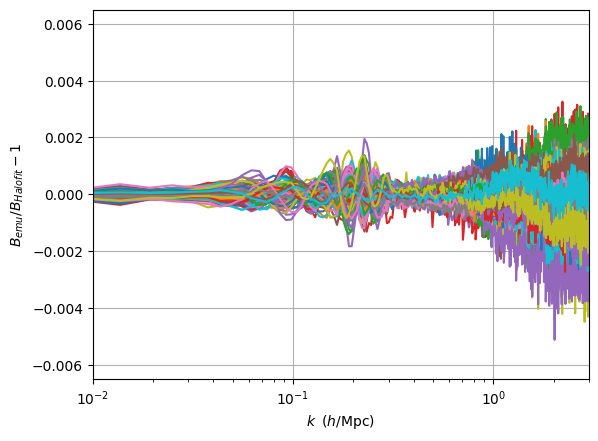

In [71]:
# COLA emulation errors, z=0
figure, errors = evaluate_model(mlp, test_samples, test_expqs, 0, smear=True)

Number of cosmologies with error > 0.005: 0 out of 100


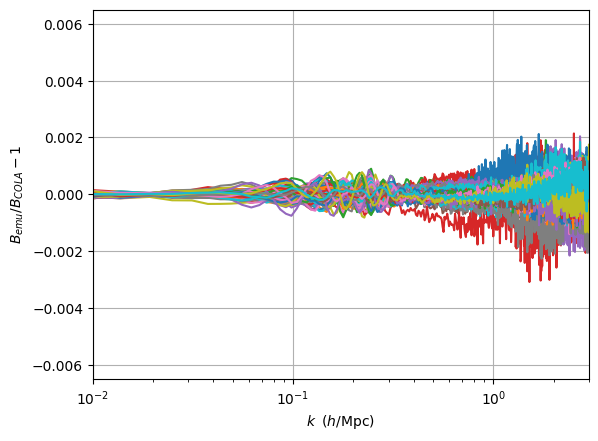

In [113]:
# COLA emulation errors, z=0.5
redshift = redshifts[17]
model = keras.models.load_model(f"./models/LCDM/NN_Z{redshift:.3f}")
figure, errors = evaluate_model(model, test_samples, test_expqs, 17, smear=True)